# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [3]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', title='HTML(value='', layout=Layout(display='none'))', show_hidden…

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [4]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/
Defaulting to output directory name "output" 


In [5]:
from osgeo import gdal

import matplotlib.pyplot as plt

import numpy as np
from numpy import nan
from numpy import isnan

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import pyopencl
import inspect

import time
from datetime import datetime

from tqdm import tqdm

class Timeseries:
    '''
    
    This is a class that holds a numpy array with time series data, a csv containing dates, and associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path, dates_path):
        
        self.name = time_series_path + "stack.vrt"
        self.dir = time_series_path
        
        self.time_series = gdal.Open(self.name)
        #time_series = self.time_series
        geotransform = self.time_series.GetGeoTransform()
        
        # geo metadata
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]
        self.ncols = self.time_series.RasterXSize
        self.nrows = self.time_series.RasterYSize
        self.projection = self.time_series.GetProjection()
        self.nbands = self.time_series.RasterCount
        
        band = self.time_series.GetRasterBand(1)
        self.block_size = band.GetBlockSize()
        self.time_dict = {}
        
        # self.raster_stack_orig = time_series.ReadAsArray()
        # This takes really long and will likely cause memory issues when running on large countries, so don't use it
        # Use blocks and base block size on what gdal sets or on ram calculation 
        
        # dates file
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))
    def __repr__(self):
            return("Timeseries: {} ".format(self.name))

    def run_bfast(self, block):
        data, dates = crop_data_dates(block, self.dates, self.start_hist, self.end_monitor)

        # only apply on a small subset
        #data = data[:,:80,:80]
        
        # change nans to a number bfastmonitor-GPU can work with
        where_are_NaNs = isnan(data)
        data[where_are_NaNs] = -32768

        # fit model
        self.model.fit(data, dates, nan_value = -32768) 
        
        # save breaks and mean magnitudes
        breaks = self.model.breaks # index of date that has a break in dates
        means = self.model.means # magnitudes of breaks
        
        return(breaks,means)
    
    def loop_blocks(self):

        start_time = time.time()
        
        x_block_size = self.block_size[0]
        y_block_size = self.block_size[1]
        print("rastersize: ",self.ncols,self.nrows)
        print("The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize: ",self.block_size)
        print("set blocksize explicitly: ",x_block_size,", " ,y_block_size)
        print("bytes required: ", str(8 * self.ncols * self.nrows * self.nbands))
        print("start monitor: ", self.start_monitor)
        print("end monitor: ", self.end_monitor)
        print("start history: ", self.start_hist)
        
        
        first_verstack=True

        # loop over yblocks
        with tqdm(total=(self.ncols/x_block_size)*(self.nrows/y_block_size)) as pbar2:
            pbar2.set_description("Processing blocks of tile:")
                    
                
            for i in range(0, self.nrows, y_block_size):
                
                
                first_horstack = True
                if i + y_block_size < self.nrows:
                    rows = y_block_size
                else:
                    rows = self.nrows - i

                # Loop over xblocks
                for j in range(0, self.ncols, x_block_size):
                    
                    
                    if j + x_block_size < self.ncols:
                        cols = x_block_size
                    else:
                        cols = self.ncols - j

                    print(j,i,cols,rows)

                    # first step creates the array
                    pbar2.update(1)
                    
                    if first_horstack==True:
                        data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                        breaks,means = self.run_bfast(data)
                        breaks_array = breaks
                        means_array = means
                        first_horstack=False

                    # after that add to array
                    else:                    
                        data = self.time_series.ReadAsArray(j, i, cols, rows).astype(np.int16)

                        breaks,means = self.run_bfast(data)
                        breaks_array = np.concatenate((breaks_array,breaks),axis = 1)
                        means_array = np.concatenate((means_array,means),axis = 1)
                
                
                # first step create new variable verstack for the data

                if first_verstack == True:
                    stack_breaks_array = breaks_array
                    stack_means_array = means_array
                    first_verstack = False
                
                # after that add data to array
                else:
                    stack_breaks_array = np.concatenate((stack_breaks_array,breaks_array),axis=0)
                    stack_means_array = np.concatenate((stack_means_array,means_array),axis=0)

            self.breaks_array = stack_breaks_array
            self.means_array = stack_means_array
            
            pbar2.close()
            end_time = time.time()
            print("Fitting model over all blocks took {} seconds.".format(end_time - start_time))
            self.time_dict[self.name] = str(end_time - start_time) + " seconds"

    def set_bfast_parameters(self, start_monitor, end_monitor, start_hist,freq,k,hfrac,trend,level,backend='opencl',verbose=1,device_id=0):
        self.start_monitor = start_monitor
        self.end_monitor = end_monitor
        self.start_hist = start_hist
        self.freq = freq
        self.k = k
        self.hfrac = hfrac
        self.trend = trend
        self.level = level
        self.backend = backend
        self.verbose = verbose
        
        self.model = BFASTMonitor(
                    self.start_monitor,
                    freq=freq, # add these
                    k=k,
                    hfrac=hfrac,
                    trend=trend,
                    level=level,
                    backend=backend,
                    verbose=verbose,
                    device_id=device_id,
                    )
        
        try:
            print(pyopencl.get_platforms()[0].get_devices())
        except:
            print("You selected  openCL, but no device was found, are you sure you set up a gpu session?")

    
    def get_bfast_parameters(self):
        print("Monitoring starts at: ", self.start_monitor)
        print("Monitoring ends at: ", self.end_monitor)
        print("Dataset history starts at: ", self.start_hist)
        print("frequency: ", self.freq)
        print("harmonic term: ", self.k)
        print("Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.: ", self.hfrac)
        print("Trend: Whether a tend offset term shall be used or not: ", self.trend)
        print("Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error: ", self.level)
        print("backend: GPU opencl or CPU python: ", self.backend)
        print("verbose: The verbosity level (0=no output, 1=output): ", self.verbose)
        
    
    def log_output_to_txt(self):

        self.date = str(datetime.now())
        self.device = pyopencl.get_platforms()[0].get_devices()
        
        attributes = inspect.getmembers(self, lambda a:not(inspect.isroutine(a)))
        
        logs_directory = "logs"
        if not os.path.exists("logs"):
            os.makedirs(logs_directory)
        
        save_dir = self.dir
        try:
            start_index = save_dir.find("Time_series")
        except:
            start_index = 1
        save_dir = self.dir.replace("/","-")[start_index:] + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + ".txt"
        
        
        with open(str(logs_directory + "/" + save_dir), "w") as f:
            for a in attributes:
                if not(a[0].startswith('__') and a[0].endswith('__')):
                    f.write(str(a))
                    f.write("\n")
    
    def log_breaks_means_arrays(self):
        
        arrays_directory = "output_arrays"
        if not os.path.exists("output_arrays"):
            os.makedirs(arrays_directory)
        
        save_dir = self.dir
        try:
            start_index = save_dir.find("Time_series")
        except:
            start_index = 1
        
        save_means_dir = arrays_directory + '/' + self.dir.replace("/","-")[start_index:] + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_means.npy"
        save_breaks_dir = arrays_directory + '/' +self.dir.replace("/","-")[start_index:] + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_breaks.npy"
        print(save_means_dir)
        print(save_breaks_dir)
        np.save(save_means_dir, self.means_array)
        np.save( save_breaks_dir,self.breaks_array)
        
        
        
    # Don't work anymore, fix later
    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
        
    def get_size(self):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(self.dir):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                # skip if it is symbolic link
                if not os.path.islink(fp):
                    total_size += os.path.getsize(fp)
        print(self.dir + "   holds  " + str(total_size) + " bytes")

      

# Load in data: if there are tiles in the directory, create a list and load per tile

In [6]:
# set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# check for tiles
file_list = os.listdir(timeseries_directory)
file_list.sort()
for file in file_list:
    if file.startswith('tile'):
        print(file)
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


tile-0000000000-0000000000
tile-0000000000-0000002048
tile-0000000000-0000004096
tile-0000000000-0000006144
tile-0000002048-0000000000
tile-0000002048-0000002048
tile-0000002048-0000004096
tile-0000002048-0000006144
tile-0000004096-0000000000
tile-0000004096-0000002048
tile-0000004096-0000004096
tile-0000004096-0000006144
tile-0000006144-0000000000
tile-0000006144-0000002048
tile-0000006144-0000004096
tile-0000006144-0000006144


In [8]:
# # Set up list of time series tiles and their metadata
if not tile_paths:
    print("No tiles, setting up data as one tile")
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, setting up tiles in 'data_list' ")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)

Data consists of tiles, setting up tiles in 'data_list' 


### Check some metadata of the created Timeseries class

In [9]:
# data_list = data_list[0:2]
#ts_data = data_list[0]
print("projection: ", data_list[0].projection)
print("pixel size: ", data_list[0].xpixelsize)
#ts_data.log_output_to_txt()

data_list = data_list[0:6]
data_list

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358554


[Timeseries: /home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000000000-0000000000/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000000000-0000002048/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000000000-0000004096/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000000000-0000006144/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000002048-0000000000/stack.vrt ,
 Timeseries: /home/dven/downloads/Time_series_2020-08-10_08-39-53_Rwanda/0/tile-0000002048-0000002048/stack.vrt ]

# Set parameters

In [10]:
# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
position = (100,100)

backend = 'opencl'
verbose = 1
device_id = 0


# start_hist = datetime(2018, 1, 1)
# start_monitor = datetime(2019, 1, 1)
# end_monitor = datetime(2020, 1, 1)


# Select monitoring period

In [11]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

start monitoring period 2018-02-10 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 903), l…

interactive(children=(SelectionSlider(description='Start history period:', options=(('2018-02-10', Timestamp('…

In [12]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

#start_monitor = datetime(2011, 11, 23)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00


### Loop over tiles, (or single tile), in data_list

In [13]:
from tqdm import tqdm
with tqdm(total=len(data_list)) as pbar1:
        
    for counter, ts_data in enumerate(data_list):
        pbar1.set_description("Processing tile %s out of %s" % (counter+1, len(data_list)) )
        ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend=backend,verbose=verbose,device_id=device_id)
        ts_data.loop_blocks()
        ts_data.get_bfast_parameters()
        ts_data.log_output_to_txt()
        ts_data.log_breaks_means_arrays()
        pbar1.update(counter)
pbar1.close()
# ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level,backend,verbose,device_id)
# print(ts_data.start_monitor)

# ts_data.get_bfast_parameters()

Processing tile 0 out of 6:   0%|          | 0/6 [00:00<?, ?it/s]
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c32a70>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  6610223104
start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00
0 0 128 128



Processing blocks of tile::   1%|          | 2/256.0 [00:06<13:40,  3.23s/it]

--- runtime for data initialization:		0.08934211730957031
--- runtime for data transfer (host->device):	0.001861572265625
--- runtime for data preprocessing:		0.0015439987182617188
--- runtime for kernel execution:		0.003208160400390625
--- runtime for data transfer (device->host):	0.0004937648773193359
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:07<10:58,  2.60s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.0017595291137695312
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.0030984878540039062
--- runtime for data transfer (device->host):	0.0004839897155761719
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:08<09:06,  2.17s/it]

--- runtime for data initialization:		0.0013744831085205078
--- runtime for data transfer (host->device):	0.001745462417602539
--- runtime for data preprocessing:		0.000957489013671875
--- runtime for kernel execution:		0.0031092166900634766
--- runtime for data transfer (device->host):	0.0004980564117431641
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:09<07:46,  1.86s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0016837120056152344
--- runtime for data preprocessing:		0.0009608268737792969
--- runtime for kernel execution:		0.0031287670135498047
--- runtime for data transfer (device->host):	0.0005004405975341797
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:11<06:51,  1.65s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0017600059509277344
--- runtime for data preprocessing:		0.0009818077087402344
--- runtime for kernel execution:		0.003116607666015625
--- runtime for data transfer (device->host):	0.0004928112030029297
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:12<06:14,  1.50s/it]

--- runtime for data initialization:		0.0013835430145263672
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.000993490219116211
--- runtime for kernel execution:		0.0031557083129882812
--- runtime for data transfer (device->host):	0.00047850608825683594
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:13<05:43,  1.39s/it]

--- runtime for data initialization:		0.0013763904571533203
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0009617805480957031
--- runtime for kernel execution:		0.0030977725982666016
--- runtime for data transfer (device->host):	0.0004820823669433594
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:14<05:25,  1.32s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0017066001892089844
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.0031213760375976562
--- runtime for data transfer (device->host):	0.0004968643188476562
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:15<05:08,  1.25s/it]

--- runtime for data initialization:		0.0014693737030029297
--- runtime for data transfer (host->device):	0.0017287731170654297
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.0031213760375976562
--- runtime for data transfer (device->host):	0.0004918575286865234
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:16<04:58,  1.22s/it]

--- runtime for data initialization:		0.0014057159423828125
--- runtime for data transfer (host->device):	0.0016951560974121094
--- runtime for data preprocessing:		0.0010349750518798828
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.0004885196685791016
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:17<04:55,  1.21s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.001718759536743164
--- runtime for data preprocessing:		0.0010006427764892578
--- runtime for kernel execution:		0.0031375885009765625
--- runtime for data transfer (device->host):	0.0004940032958984375
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:19<04:49,  1.19s/it]

--- runtime for data initialization:		0.001399993896484375
--- runtime for data transfer (host->device):	0.0017063617706298828
--- runtime for data preprocessing:		0.00096893310546875
--- runtime for kernel execution:		0.003137826919555664
--- runtime for data transfer (device->host):	0.00048804283142089844
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:20<04:45,  1.18s/it]

--- runtime for data initialization:		0.001413106918334961
--- runtime for data transfer (host->device):	0.001730203628540039
--- runtime for data preprocessing:		0.0009818077087402344
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004949569702148438
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:21<04:40,  1.16s/it]

--- runtime for data initialization:		0.001416921615600586
--- runtime for data transfer (host->device):	0.001695871353149414
--- runtime for data preprocessing:		0.0009584426879882812
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0004911422729492188
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [00:22<04:36,  1.15s/it]

--- runtime for data initialization:		0.0013763904571533203
--- runtime for data transfer (host->device):	0.0016884803771972656
--- runtime for data preprocessing:		0.0009596347808837891
--- runtime for kernel execution:		0.0031163692474365234
--- runtime for data transfer (device->host):	0.0004951953887939453
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [00:23<04:33,  1.15s/it]

--- runtime for data initialization:		0.0014221668243408203
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0009448528289794922
--- runtime for kernel execution:		0.0031135082244873047
--- runtime for data transfer (device->host):	0.00048804283142089844
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [00:24<04:32,  1.15s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017242431640625
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.0031096935272216797
--- runtime for data transfer (device->host):	0.0004992485046386719
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [00:25<04:30,  1.14s/it]

--- runtime for data initialization:		0.0014324188232421875
--- runtime for data transfer (host->device):	0.0017092227935791016
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.0031003952026367188
--- runtime for data transfer (device->host):	0.0004951953887939453
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [00:27<04:30,  1.15s/it]

--- runtime for data initialization:		0.0014302730560302734
--- runtime for data transfer (host->device):	0.0017201900482177734
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.0031540393829345703
--- runtime for data transfer (device->host):	0.00035691261291503906
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [00:28<04:30,  1.15s/it]

--- runtime for data initialization:		0.0014395713806152344
--- runtime for data transfer (host->device):	0.0017387866973876953
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.003144979476928711
--- runtime for data transfer (device->host):	0.0004925727844238281
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [00:29<04:29,  1.15s/it]

--- runtime for data initialization:		0.0014486312866210938
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009570121765136719
--- runtime for kernel execution:		0.003083467483520508
--- runtime for data transfer (device->host):	0.0004942417144775391
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [00:30<04:26,  1.14s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.0017168521881103516
--- runtime for data preprocessing:		0.0009522438049316406
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004901885986328125
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [00:31<04:26,  1.15s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.0016906261444091797
--- runtime for data preprocessing:		0.0009601116180419922
--- runtime for kernel execution:		0.003145933151245117
--- runtime for data transfer (device->host):	0.0004966259002685547
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [00:32<04:25,  1.15s/it]

--- runtime for data initialization:		0.00144195556640625
--- runtime for data transfer (host->device):	0.0017104148864746094
--- runtime for data preprocessing:		0.0009684562683105469
--- runtime for kernel execution:		0.003099203109741211
--- runtime for data transfer (device->host):	0.0004966259002685547
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [00:33<04:24,  1.15s/it]

--- runtime for data initialization:		0.0013873577117919922
--- runtime for data transfer (host->device):	0.0016891956329345703
--- runtime for data preprocessing:		0.0009515285491943359
--- runtime for kernel execution:		0.0031273365020751953
--- runtime for data transfer (device->host):	0.0004949569702148438
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [00:35<04:22,  1.14s/it]

--- runtime for data initialization:		0.001436471939086914
--- runtime for data transfer (host->device):	0.0016796588897705078
--- runtime for data preprocessing:		0.0009427070617675781
--- runtime for kernel execution:		0.0031280517578125
--- runtime for data transfer (device->host):	0.00048351287841796875
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [00:36<04:20,  1.14s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017020702362060547
--- runtime for data preprocessing:		0.0009467601776123047
--- runtime for kernel execution:		0.003129720687866211
--- runtime for data transfer (device->host):	0.00048828125
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [00:37<04:18,  1.14s/it]

--- runtime for data initialization:		0.0014352798461914062
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0009634494781494141
--- runtime for kernel execution:		0.003145933151245117
--- runtime for data transfer (device->host):	0.0004909038543701172
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [00:38<04:18,  1.14s/it]

--- runtime for data initialization:		0.001434326171875
--- runtime for data transfer (host->device):	0.0016813278198242188
--- runtime for data preprocessing:		0.0009586811065673828
--- runtime for kernel execution:		0.003130674362182617
--- runtime for data transfer (device->host):	0.0004963874816894531
1664 128 128 128



Processing blocks of tile::  12%|█▏        | 31/256.0 [00:39<04:17,  1.14s/it]

--- runtime for data initialization:		0.00138092041015625
--- runtime for data transfer (host->device):	0.0017077922821044922
--- runtime for data preprocessing:		0.0009493827819824219
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004885196685791016
1792 128 128 128



Processing blocks of tile::  12%|█▎        | 32/256.0 [00:40<04:14,  1.13s/it]

--- runtime for data initialization:		0.0013782978057861328
--- runtime for data transfer (host->device):	0.0017304420471191406
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.00313568115234375
--- runtime for data transfer (device->host):	0.0004899501800537109
1920 128 128 128



Processing blocks of tile::  13%|█▎        | 33/256.0 [00:41<04:13,  1.14s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.0016791820526123047
--- runtime for data preprocessing:		0.0009534358978271484
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0004940032958984375
0 256 128 128



Processing blocks of tile::  13%|█▎        | 34/256.0 [00:43<04:16,  1.16s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.0016798973083496094
--- runtime for data preprocessing:		0.0009737014770507812
--- runtime for kernel execution:		0.003128528594970703
--- runtime for data transfer (device->host):	0.0005004405975341797
128 256 128 128



Processing blocks of tile::  14%|█▎        | 35/256.0 [00:44<04:13,  1.15s/it]

--- runtime for data initialization:		0.0014336109161376953
--- runtime for data transfer (host->device):	0.0017170906066894531
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.003119945526123047
--- runtime for data transfer (device->host):	0.0004987716674804688
256 256 128 128



Processing blocks of tile::  14%|█▍        | 36/256.0 [00:45<04:12,  1.15s/it]

--- runtime for data initialization:		0.0014219284057617188
--- runtime for data transfer (host->device):	0.0016772747039794922
--- runtime for data preprocessing:		0.0009849071502685547
--- runtime for kernel execution:		0.003154754638671875
--- runtime for data transfer (device->host):	0.0004987716674804688
384 256 128 128



Processing blocks of tile::  14%|█▍        | 37/256.0 [00:46<04:10,  1.14s/it]

--- runtime for data initialization:		0.0014352798461914062
--- runtime for data transfer (host->device):	0.0017223358154296875
--- runtime for data preprocessing:		0.0009779930114746094
--- runtime for kernel execution:		0.0031099319458007812
--- runtime for data transfer (device->host):	0.000492095947265625
512 256 128 128



Processing blocks of tile::  15%|█▍        | 38/256.0 [00:47<04:07,  1.14s/it]

--- runtime for data initialization:		0.0014128684997558594
--- runtime for data transfer (host->device):	0.0017316341400146484
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.0031464099884033203
--- runtime for data transfer (device->host):	0.0004887580871582031
640 256 128 128



Processing blocks of tile::  15%|█▌        | 39/256.0 [00:48<04:05,  1.13s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.0016884803771972656
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.003149271011352539
--- runtime for data transfer (device->host):	0.0004892349243164062
768 256 128 128



Processing blocks of tile::  16%|█▌        | 40/256.0 [00:49<04:04,  1.13s/it]

--- runtime for data initialization:		0.0013806819915771484
--- runtime for data transfer (host->device):	0.0017151832580566406
--- runtime for data preprocessing:		0.0009450912475585938
--- runtime for kernel execution:		0.0031201839447021484
--- runtime for data transfer (device->host):	0.0004994869232177734
896 256 128 128



Processing blocks of tile::  16%|█▌        | 41/256.0 [00:50<04:02,  1.13s/it]

--- runtime for data initialization:		0.0014638900756835938
--- runtime for data transfer (host->device):	0.0017516613006591797
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.00036597251892089844
1024 256 128 128



Processing blocks of tile::  16%|█▋        | 42/256.0 [00:52<04:03,  1.14s/it]

--- runtime for data initialization:		0.001413106918334961
--- runtime for data transfer (host->device):	0.001687765121459961
--- runtime for data preprocessing:		0.0009768009185791016
--- runtime for kernel execution:		0.0031707286834716797
--- runtime for data transfer (device->host):	0.0004982948303222656
1152 256 128 128



Processing blocks of tile::  17%|█▋        | 43/256.0 [00:53<04:01,  1.13s/it]

--- runtime for data initialization:		0.001386880874633789
--- runtime for data transfer (host->device):	0.0017535686492919922
--- runtime for data preprocessing:		0.0009698867797851562
--- runtime for kernel execution:		0.003130674362182617
--- runtime for data transfer (device->host):	0.000492095947265625
1280 256 128 128



Processing blocks of tile::  17%|█▋        | 44/256.0 [00:54<04:03,  1.15s/it]

--- runtime for data initialization:		0.001377105712890625
--- runtime for data transfer (host->device):	0.0016934871673583984
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.003137350082397461
--- runtime for data transfer (device->host):	0.0004968643188476562
1408 256 128 128



Processing blocks of tile::  18%|█▊        | 45/256.0 [00:55<04:01,  1.14s/it]

--- runtime for data initialization:		0.0014407634735107422
--- runtime for data transfer (host->device):	0.0017495155334472656
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0003814697265625
1536 256 128 128



Processing blocks of tile::  18%|█▊        | 46/256.0 [00:56<04:00,  1.15s/it]

--- runtime for data initialization:		0.0014231204986572266
--- runtime for data transfer (host->device):	0.0018017292022705078
--- runtime for data preprocessing:		0.000995635986328125
--- runtime for kernel execution:		0.0031697750091552734
--- runtime for data transfer (device->host):	0.0003898143768310547
1664 256 128 128



Processing blocks of tile::  18%|█▊        | 47/256.0 [00:57<03:57,  1.14s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0017499923706054688
--- runtime for data preprocessing:		0.0010173320770263672
--- runtime for kernel execution:		0.003158092498779297
--- runtime for data transfer (device->host):	0.0004937648773193359
1792 256 128 128



Processing blocks of tile::  19%|█▉        | 48/256.0 [00:59<03:57,  1.14s/it]

--- runtime for data initialization:		0.0014102458953857422
--- runtime for data transfer (host->device):	0.0016813278198242188
--- runtime for data preprocessing:		0.0009520053863525391
--- runtime for kernel execution:		0.0031232833862304688
--- runtime for data transfer (device->host):	0.0004918575286865234
1920 256 128 128



Processing blocks of tile::  19%|█▉        | 49/256.0 [01:00<03:54,  1.14s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.001737356185913086
--- runtime for data preprocessing:		0.0009605884552001953
--- runtime for kernel execution:		0.0031201839447021484
--- runtime for data transfer (device->host):	0.0004913806915283203
0 384 128 128



Processing blocks of tile::  20%|█▉        | 50/256.0 [01:01<03:53,  1.13s/it]

--- runtime for data initialization:		0.0014116764068603516
--- runtime for data transfer (host->device):	0.0016863346099853516
--- runtime for data preprocessing:		0.0009644031524658203
--- runtime for kernel execution:		0.003128528594970703
--- runtime for data transfer (device->host):	0.0004951953887939453
128 384 128 128



Processing blocks of tile::  20%|█▉        | 51/256.0 [01:02<03:51,  1.13s/it]

--- runtime for data initialization:		0.0014224052429199219
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.000990152359008789
--- runtime for kernel execution:		0.0031290054321289062
--- runtime for data transfer (device->host):	0.0004961490631103516
256 384 128 128



Processing blocks of tile::  20%|██        | 52/256.0 [01:03<03:48,  1.12s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.0016970634460449219
--- runtime for data preprocessing:		0.0010061264038085938
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0005011558532714844
384 384 128 128



Processing blocks of tile::  21%|██        | 53/256.0 [01:04<03:51,  1.14s/it]

--- runtime for data initialization:		0.0013837814331054688
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009677410125732422
--- runtime for kernel execution:		0.0031235218048095703
--- runtime for data transfer (device->host):	0.0004971027374267578
512 384 128 128



Processing blocks of tile::  21%|██        | 54/256.0 [01:05<03:49,  1.14s/it]

--- runtime for data initialization:		0.0013937950134277344
--- runtime for data transfer (host->device):	0.0017483234405517578
--- runtime for data preprocessing:		0.0009553432464599609
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004968643188476562
640 384 128 128



Processing blocks of tile::  21%|██▏       | 55/256.0 [01:06<03:47,  1.13s/it]

--- runtime for data initialization:		0.0014429092407226562
--- runtime for data transfer (host->device):	0.0017626285552978516
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.003152132034301758
--- runtime for data transfer (device->host):	0.0003693103790283203
768 384 128 128



Processing blocks of tile::  22%|██▏       | 56/256.0 [01:08<03:45,  1.13s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0017380714416503906
--- runtime for data preprocessing:		0.00098419189453125
--- runtime for kernel execution:		0.003130197525024414
--- runtime for data transfer (device->host):	0.0004966259002685547
896 384 128 128



Processing blocks of tile::  22%|██▏       | 57/256.0 [01:09<03:42,  1.12s/it]

--- runtime for data initialization:		0.0014231204986572266
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0009832382202148438
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004923343658447266
1024 384 128 128



Processing blocks of tile::  23%|██▎       | 58/256.0 [01:10<03:44,  1.13s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0016932487487792969
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.0031473636627197266
--- runtime for data transfer (device->host):	0.000492095947265625
1152 384 128 128



Processing blocks of tile::  23%|██▎       | 59/256.0 [01:11<03:42,  1.13s/it]

--- runtime for data initialization:		0.0014274120330810547
--- runtime for data transfer (host->device):	0.001711130142211914
--- runtime for data preprocessing:		0.0009646415710449219
--- runtime for kernel execution:		0.0031347274780273438
--- runtime for data transfer (device->host):	0.0004951953887939453
1280 384 128 128



Processing blocks of tile::  23%|██▎       | 60/256.0 [01:12<03:39,  1.12s/it]

--- runtime for data initialization:		0.0014081001281738281
--- runtime for data transfer (host->device):	0.0016968250274658203
--- runtime for data preprocessing:		0.0009622573852539062
--- runtime for kernel execution:		0.0031321048736572266
--- runtime for data transfer (device->host):	0.0004887580871582031
1408 384 128 128



Processing blocks of tile::  24%|██▍       | 61/256.0 [01:13<03:42,  1.14s/it]

--- runtime for data initialization:		0.0014035701751708984
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0031280517578125
--- runtime for data transfer (device->host):	0.0004906654357910156
1536 384 128 128



Processing blocks of tile::  24%|██▍       | 62/256.0 [01:14<03:41,  1.14s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0009441375732421875
--- runtime for kernel execution:		0.0031135082244873047
--- runtime for data transfer (device->host):	0.0004894733428955078
1664 384 128 128



Processing blocks of tile::  25%|██▍       | 63/256.0 [01:15<03:39,  1.14s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.003131866455078125
--- runtime for data transfer (device->host):	0.0005185604095458984
1792 384 128 128



Processing blocks of tile::  25%|██▌       | 64/256.0 [01:17<03:38,  1.14s/it]

--- runtime for data initialization:		0.001417398452758789
--- runtime for data transfer (host->device):	0.0017085075378417969
--- runtime for data preprocessing:		0.0009953975677490234
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.0004897117614746094
1920 384 128 128



Processing blocks of tile::  25%|██▌       | 65/256.0 [01:18<03:36,  1.14s/it]

--- runtime for data initialization:		0.0014269351959228516
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0009555816650390625
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004925727844238281
0 512 128 128



Processing blocks of tile::  26%|██▌       | 66/256.0 [01:19<03:35,  1.14s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.001744985580444336
--- runtime for data preprocessing:		0.0009987354278564453
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004909038543701172
128 512 128 128



Processing blocks of tile::  26%|██▌       | 67/256.0 [01:20<03:34,  1.14s/it]

--- runtime for data initialization:		0.0013806819915771484
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.0009598731994628906
--- runtime for kernel execution:		0.0031218528747558594
--- runtime for data transfer (device->host):	0.0005156993865966797
256 512 128 128



Processing blocks of tile::  27%|██▋       | 68/256.0 [01:21<03:33,  1.13s/it]

--- runtime for data initialization:		0.0014081001281738281
--- runtime for data transfer (host->device):	0.0016891956329345703
--- runtime for data preprocessing:		0.0009517669677734375
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0004889965057373047
384 512 128 128



Processing blocks of tile::  27%|██▋       | 69/256.0 [01:22<03:33,  1.14s/it]

--- runtime for data initialization:		0.0013728141784667969
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0009541511535644531
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.0004949569702148438
512 512 128 128



Processing blocks of tile::  27%|██▋       | 70/256.0 [01:23<03:30,  1.13s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0009775161743164062
--- runtime for kernel execution:		0.003133058547973633
--- runtime for data transfer (device->host):	0.0005116462707519531
640 512 128 128



Processing blocks of tile::  28%|██▊       | 71/256.0 [01:25<03:30,  1.14s/it]

--- runtime for data initialization:		0.0014157295227050781
--- runtime for data transfer (host->device):	0.0017147064208984375
--- runtime for data preprocessing:		0.0009608268737792969
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004956722259521484
768 512 128 128



Processing blocks of tile::  28%|██▊       | 72/256.0 [01:26<03:28,  1.13s/it]

--- runtime for data initialization:		0.001402139663696289
--- runtime for data transfer (host->device):	0.0017163753509521484
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0005035400390625
896 512 128 128



Processing blocks of tile::  29%|██▊       | 73/256.0 [01:27<03:25,  1.12s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.0009591579437255859
--- runtime for kernel execution:		0.0031316280364990234
--- runtime for data transfer (device->host):	0.00047969818115234375
1024 512 128 128



Processing blocks of tile::  29%|██▉       | 74/256.0 [01:28<03:25,  1.13s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017642974853515625
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.00313568115234375
--- runtime for data transfer (device->host):	0.00049591064453125
1152 512 128 128



Processing blocks of tile::  29%|██▉       | 75/256.0 [01:29<03:27,  1.14s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.003120899200439453
--- runtime for data transfer (device->host):	0.0004978179931640625
1280 512 128 128



Processing blocks of tile::  30%|██▉       | 76/256.0 [01:30<03:22,  1.13s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0016939640045166016
--- runtime for data preprocessing:		0.0009608268737792969
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0004906654357910156
1408 512 128 128



Processing blocks of tile::  30%|███       | 77/256.0 [01:31<03:20,  1.12s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0005004405975341797
1536 512 128 128



Processing blocks of tile::  30%|███       | 78/256.0 [01:32<03:19,  1.12s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0016944408416748047
--- runtime for data preprocessing:		0.0009534358978271484
--- runtime for kernel execution:		0.003148317337036133
--- runtime for data transfer (device->host):	0.00048160552978515625
1664 512 128 128



Processing blocks of tile::  31%|███       | 79/256.0 [01:34<03:19,  1.13s/it]

--- runtime for data initialization:		0.0014519691467285156
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0009598731994628906
--- runtime for kernel execution:		0.0031342506408691406
--- runtime for data transfer (device->host):	0.0004889965057373047
1792 512 128 128



Processing blocks of tile::  31%|███▏      | 80/256.0 [01:35<03:18,  1.13s/it]

--- runtime for data initialization:		0.0014243125915527344
--- runtime for data transfer (host->device):	0.0017018318176269531
--- runtime for data preprocessing:		0.0010075569152832031
--- runtime for kernel execution:		0.0031595230102539062
--- runtime for data transfer (device->host):	0.0004963874816894531
1920 512 128 128



Processing blocks of tile::  32%|███▏      | 81/256.0 [01:36<03:18,  1.13s/it]

--- runtime for data initialization:		0.001439809799194336
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0009579658508300781
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004954338073730469
0 640 128 128



Processing blocks of tile::  32%|███▏      | 82/256.0 [01:37<03:16,  1.13s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0017201900482177734
--- runtime for data preprocessing:		0.00098419189453125
--- runtime for kernel execution:		0.003141641616821289
--- runtime for data transfer (device->host):	0.0004830360412597656
128 640 128 128



Processing blocks of tile::  32%|███▏      | 83/256.0 [01:38<03:15,  1.13s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0016717910766601562
--- runtime for data preprocessing:		0.0009567737579345703
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004999637603759766
256 640 128 128



Processing blocks of tile::  33%|███▎      | 84/256.0 [01:39<03:13,  1.13s/it]

--- runtime for data initialization:		0.0014011859893798828
--- runtime for data transfer (host->device):	0.0016987323760986328
--- runtime for data preprocessing:		0.0009818077087402344
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004947185516357422
384 640 128 128



Processing blocks of tile::  33%|███▎      | 85/256.0 [01:40<03:13,  1.13s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.001687765121459961
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.0031328201293945312
--- runtime for data transfer (device->host):	0.00048160552978515625
512 640 128 128



Processing blocks of tile::  34%|███▎      | 86/256.0 [01:41<03:13,  1.14s/it]

--- runtime for data initialization:		0.0014061927795410156
--- runtime for data transfer (host->device):	0.001674652099609375
--- runtime for data preprocessing:		0.0009565353393554688
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004923343658447266
640 640 128 128



Processing blocks of tile::  34%|███▍      | 87/256.0 [01:43<03:17,  1.17s/it]

--- runtime for data initialization:		0.0013799667358398438
--- runtime for data transfer (host->device):	0.0016939640045166016
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.0004971027374267578
768 640 128 128



Processing blocks of tile::  34%|███▍      | 88/256.0 [01:44<03:14,  1.16s/it]

--- runtime for data initialization:		0.0014221668243408203
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0010001659393310547
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.00048470497131347656
896 640 128 128



Processing blocks of tile::  35%|███▍      | 89/256.0 [01:45<03:12,  1.16s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.0017497539520263672
--- runtime for data preprocessing:		0.0009796619415283203
--- runtime for kernel execution:		0.003117084503173828
--- runtime for data transfer (device->host):	0.0004951953887939453
1024 640 128 128



Processing blocks of tile::  35%|███▌      | 90/256.0 [01:46<03:11,  1.15s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.001722574234008789
--- runtime for data preprocessing:		0.0010023117065429688
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0004994869232177734
1152 640 128 128



Processing blocks of tile::  36%|███▌      | 91/256.0 [01:47<03:09,  1.15s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0016891956329345703
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.0031130313873291016
--- runtime for data transfer (device->host):	0.0004899501800537109
1280 640 128 128



Processing blocks of tile::  36%|███▌      | 92/256.0 [01:48<03:08,  1.15s/it]

--- runtime for data initialization:		0.0013759136199951172
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0009598731994628906
--- runtime for kernel execution:		0.0031387805938720703
--- runtime for data transfer (device->host):	0.0004794597625732422
1408 640 128 128



Processing blocks of tile::  36%|███▋      | 93/256.0 [01:50<03:07,  1.15s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.001687765121459961
--- runtime for data preprocessing:		0.0009579658508300781
--- runtime for kernel execution:		0.003134489059448242
--- runtime for data transfer (device->host):	0.00048661231994628906
1536 640 128 128



Processing blocks of tile::  37%|███▋      | 94/256.0 [01:51<03:05,  1.14s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.001712799072265625
--- runtime for data preprocessing:		0.0009639263153076172
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.00048661231994628906
1664 640 128 128



Processing blocks of tile::  37%|███▋      | 95/256.0 [01:52<03:03,  1.14s/it]

--- runtime for data initialization:		0.001416921615600586
--- runtime for data transfer (host->device):	0.001741170883178711
--- runtime for data preprocessing:		0.0009529590606689453
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.00047969818115234375
1792 640 128 128



Processing blocks of tile::  38%|███▊      | 96/256.0 [01:53<03:02,  1.14s/it]

--- runtime for data initialization:		0.0014095306396484375
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0010149478912353516
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.0004887580871582031
1920 640 128 128



Processing blocks of tile::  38%|███▊      | 97/256.0 [01:54<03:02,  1.15s/it]

--- runtime for data initialization:		0.0014393329620361328
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.00096893310546875
--- runtime for kernel execution:		0.003179311752319336
--- runtime for data transfer (device->host):	0.00048232078552246094
0 768 128 128



Processing blocks of tile::  38%|███▊      | 98/256.0 [01:55<03:00,  1.14s/it]

--- runtime for data initialization:		0.0014297962188720703
--- runtime for data transfer (host->device):	0.001695871353149414
--- runtime for data preprocessing:		0.0010154247283935547
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004966259002685547
128 768 128 128



Processing blocks of tile::  39%|███▊      | 99/256.0 [01:56<02:59,  1.14s/it]

--- runtime for data initialization:		0.0014047622680664062
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.0031099319458007812
--- runtime for data transfer (device->host):	0.0004994869232177734
256 768 128 128



Processing blocks of tile::  39%|███▉      | 100/256.0 [01:58<02:57,  1.13s/it]

--- runtime for data initialization:		0.0014426708221435547
--- runtime for data transfer (host->device):	0.001674652099609375
--- runtime for data preprocessing:		0.0009520053863525391
--- runtime for kernel execution:		0.003145933151245117
--- runtime for data transfer (device->host):	0.0004973411560058594
384 768 128 128



Processing blocks of tile::  39%|███▉      | 101/256.0 [01:59<02:54,  1.13s/it]

--- runtime for data initialization:		0.001445770263671875
--- runtime for data transfer (host->device):	0.0017142295837402344
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.003128528594970703
--- runtime for data transfer (device->host):	0.0004918575286865234
512 768 128 128



Processing blocks of tile::  40%|███▉      | 102/256.0 [02:00<02:53,  1.12s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0009639263153076172
--- runtime for kernel execution:		0.003168821334838867
--- runtime for data transfer (device->host):	0.0004966259002685547
640 768 128 128



Processing blocks of tile::  40%|████      | 103/256.0 [02:01<02:52,  1.13s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.0017435550689697266
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.003110647201538086
--- runtime for data transfer (device->host):	0.000492095947265625
768 768 128 128



Processing blocks of tile::  41%|████      | 104/256.0 [02:02<02:53,  1.14s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0004868507385253906
896 768 128 128



Processing blocks of tile::  41%|████      | 105/256.0 [02:03<02:59,  1.19s/it]

--- runtime for data initialization:		0.0014202594757080078
--- runtime for data transfer (host->device):	0.001729726791381836
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.0031299591064453125
--- runtime for data transfer (device->host):	0.0004923343658447266
1024 768 128 128



Processing blocks of tile::  41%|████▏     | 106/256.0 [02:05<02:59,  1.20s/it]

--- runtime for data initialization:		0.0014109611511230469
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009899139404296875
--- runtime for kernel execution:		0.0031211376190185547
--- runtime for data transfer (device->host):	0.0004911422729492188
1152 768 128 128



Processing blocks of tile::  42%|████▏     | 107/256.0 [02:06<02:55,  1.18s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017786026000976562
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.003115415573120117
--- runtime for data transfer (device->host):	0.0004982948303222656
1280 768 128 128



Processing blocks of tile::  42%|████▏     | 108/256.0 [02:07<02:53,  1.17s/it]

--- runtime for data initialization:		0.0014145374298095703
--- runtime for data transfer (host->device):	0.0016775131225585938
--- runtime for data preprocessing:		0.0009543895721435547
--- runtime for kernel execution:		0.003182649612426758
--- runtime for data transfer (device->host):	0.0004930496215820312
1408 768 128 128



Processing blocks of tile::  43%|████▎     | 109/256.0 [02:08<02:51,  1.17s/it]

--- runtime for data initialization:		0.0013992786407470703
--- runtime for data transfer (host->device):	0.0017287731170654297
--- runtime for data preprocessing:		0.0009894371032714844
--- runtime for kernel execution:		0.003131389617919922
--- runtime for data transfer (device->host):	0.0005269050598144531
1536 768 128 128



Processing blocks of tile::  43%|████▎     | 110/256.0 [02:09<02:48,  1.15s/it]

--- runtime for data initialization:		0.0014278888702392578
--- runtime for data transfer (host->device):	0.0017232894897460938
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.0031173229217529297
--- runtime for data transfer (device->host):	0.0004973411560058594
1664 768 128 128



Processing blocks of tile::  43%|████▎     | 111/256.0 [02:10<02:46,  1.15s/it]

--- runtime for data initialization:		0.0013780593872070312
--- runtime for data transfer (host->device):	0.0016875267028808594
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.003141164779663086
--- runtime for data transfer (device->host):	0.0004923343658447266
1792 768 128 128



Processing blocks of tile::  44%|████▍     | 112/256.0 [02:11<02:45,  1.15s/it]

--- runtime for data initialization:		0.0014157295227050781
--- runtime for data transfer (host->device):	0.0017180442810058594
--- runtime for data preprocessing:		0.0009469985961914062
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.0004918575286865234
1920 768 128 128



Processing blocks of tile::  44%|████▍     | 113/256.0 [02:13<02:43,  1.14s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0009648799896240234
--- runtime for kernel execution:		0.003104686737060547
--- runtime for data transfer (device->host):	0.0004923343658447266
0 896 128 128



Processing blocks of tile::  45%|████▍     | 114/256.0 [02:14<02:43,  1.15s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0016734600067138672
--- runtime for data preprocessing:		0.0009634494781494141
--- runtime for kernel execution:		0.0031490325927734375
--- runtime for data transfer (device->host):	0.0004985332489013672
128 896 128 128



Processing blocks of tile::  45%|████▍     | 115/256.0 [02:15<02:42,  1.15s/it]

--- runtime for data initialization:		0.0014338493347167969
--- runtime for data transfer (host->device):	0.0017008781433105469
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.0031676292419433594
--- runtime for data transfer (device->host):	0.0005028247833251953
256 896 128 128



Processing blocks of tile::  45%|████▌     | 116/256.0 [02:16<02:40,  1.15s/it]

--- runtime for data initialization:		0.001397848129272461
--- runtime for data transfer (host->device):	0.0017123222351074219
--- runtime for data preprocessing:		0.0009553432464599609
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004971027374267578
384 896 128 128



Processing blocks of tile::  46%|████▌     | 117/256.0 [02:17<02:38,  1.14s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004944801330566406
512 896 128 128



Processing blocks of tile::  46%|████▌     | 118/256.0 [02:18<02:37,  1.14s/it]

--- runtime for data initialization:		0.0013909339904785156
--- runtime for data transfer (host->device):	0.0017557144165039062
--- runtime for data preprocessing:		0.0009717941284179688
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0004918575286865234
640 896 128 128



Processing blocks of tile::  46%|████▋     | 119/256.0 [02:19<02:36,  1.14s/it]

--- runtime for data initialization:		0.0013947486877441406
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.0009729862213134766
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.0004925727844238281
768 896 128 128



Processing blocks of tile::  47%|████▋     | 120/256.0 [02:21<02:34,  1.14s/it]

--- runtime for data initialization:		0.0013985633850097656
--- runtime for data transfer (host->device):	0.0017075538635253906
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004932880401611328
896 896 128 128



Processing blocks of tile::  47%|████▋     | 121/256.0 [02:22<02:32,  1.13s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.0016977787017822266
--- runtime for data preprocessing:		0.0009655952453613281
--- runtime for kernel execution:		0.0031099319458007812
--- runtime for data transfer (device->host):	0.0004954338073730469
1024 896 128 128



Processing blocks of tile::  48%|████▊     | 122/256.0 [02:23<02:32,  1.13s/it]

--- runtime for data initialization:		0.0014011859893798828
--- runtime for data transfer (host->device):	0.0016696453094482422
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.003122568130493164
--- runtime for data transfer (device->host):	0.0004971027374267578
1152 896 128 128



Processing blocks of tile::  48%|████▊     | 123/256.0 [02:24<02:31,  1.14s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.001699686050415039
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031557083129882812
--- runtime for data transfer (device->host):	0.0004944801330566406
1280 896 128 128



Processing blocks of tile::  48%|████▊     | 124/256.0 [02:25<02:30,  1.14s/it]

--- runtime for data initialization:		0.0014271736145019531
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0005021095275878906
1408 896 128 128



Processing blocks of tile::  49%|████▉     | 125/256.0 [02:26<02:27,  1.13s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.0017452239990234375
--- runtime for data preprocessing:		0.0009801387786865234
--- runtime for kernel execution:		0.0031609535217285156
--- runtime for data transfer (device->host):	0.0004928112030029297
1536 896 128 128



Processing blocks of tile::  49%|████▉     | 126/256.0 [02:27<02:26,  1.13s/it]

--- runtime for data initialization:		0.0014183521270751953
--- runtime for data transfer (host->device):	0.001688241958618164
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.003139972686767578
--- runtime for data transfer (device->host):	0.000492095947265625
1664 896 128 128



Processing blocks of tile::  50%|████▉     | 127/256.0 [02:28<02:24,  1.12s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0017075538635253906
--- runtime for data preprocessing:		0.0009610652923583984
--- runtime for kernel execution:		0.003135204315185547
--- runtime for data transfer (device->host):	0.0005075931549072266
1792 896 128 128



Processing blocks of tile::  50%|█████     | 128/256.0 [02:30<02:25,  1.14s/it]

--- runtime for data initialization:		0.001405477523803711
--- runtime for data transfer (host->device):	0.0016889572143554688
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.0004966259002685547
1920 896 128 128



Processing blocks of tile::  50%|█████     | 129/256.0 [02:31<02:25,  1.14s/it]

--- runtime for data initialization:		0.0014033317565917969
--- runtime for data transfer (host->device):	0.001687765121459961
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.003110647201538086
--- runtime for data transfer (device->host):	0.0005047321319580078
0 1024 128 128



Processing blocks of tile::  51%|█████     | 130/256.0 [02:32<02:27,  1.17s/it]

--- runtime for data initialization:		0.0014269351959228516
--- runtime for data transfer (host->device):	0.00171661376953125
--- runtime for data preprocessing:		0.0009853839874267578
--- runtime for kernel execution:		0.0031185150146484375
--- runtime for data transfer (device->host):	0.0005154609680175781
128 1024 128 128



Processing blocks of tile::  51%|█████     | 131/256.0 [02:33<02:24,  1.16s/it]

--- runtime for data initialization:		0.0014159679412841797
--- runtime for data transfer (host->device):	0.0017185211181640625
--- runtime for data preprocessing:		0.0009717941284179688
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.0004899501800537109
256 1024 128 128



Processing blocks of tile::  52%|█████▏    | 132/256.0 [02:35<02:39,  1.28s/it]

--- runtime for data initialization:		0.0014255046844482422
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009753704071044922
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.00047969818115234375
384 1024 128 128



Processing blocks of tile::  52%|█████▏    | 133/256.0 [02:39<04:26,  2.17s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.0009605884552001953
--- runtime for kernel execution:		0.0031096935272216797
--- runtime for data transfer (device->host):	0.0004937648773193359
512 1024 128 128



Processing blocks of tile::  52%|█████▏    | 134/256.0 [02:40<03:44,  1.84s/it]

--- runtime for data initialization:		0.0014171600341796875
--- runtime for data transfer (host->device):	0.0016906261444091797
--- runtime for data preprocessing:		0.0009925365447998047
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0004968643188476562
640 1024 128 128



Processing blocks of tile::  53%|█████▎    | 135/256.0 [02:41<03:15,  1.62s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0017058849334716797
--- runtime for data preprocessing:		0.0009746551513671875
--- runtime for kernel execution:		0.003168344497680664
--- runtime for data transfer (device->host):	0.00046372413635253906
768 1024 128 128



Processing blocks of tile::  53%|█████▎    | 136/256.0 [02:42<02:54,  1.46s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.001707315444946289
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.0004870891571044922
896 1024 128 128



Processing blocks of tile::  54%|█████▎    | 137/256.0 [02:43<02:39,  1.34s/it]

--- runtime for data initialization:		0.0013859272003173828
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.003122091293334961
--- runtime for data transfer (device->host):	0.0004887580871582031
1024 1024 128 128



Processing blocks of tile::  54%|█████▍    | 138/256.0 [02:44<02:29,  1.27s/it]

--- runtime for data initialization:		0.0014154911041259766
--- runtime for data transfer (host->device):	0.00174713134765625
--- runtime for data preprocessing:		0.0009691715240478516
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.0004878044128417969
1152 1024 128 128



Processing blocks of tile::  54%|█████▍    | 139/256.0 [02:46<02:22,  1.22s/it]

--- runtime for data initialization:		0.0013985633850097656
--- runtime for data transfer (host->device):	0.0017027854919433594
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004937648773193359
1280 1024 128 128



Processing blocks of tile::  55%|█████▍    | 140/256.0 [02:47<02:16,  1.18s/it]

--- runtime for data initialization:		0.001409292221069336
--- runtime for data transfer (host->device):	0.0016853809356689453
--- runtime for data preprocessing:		0.0009737014770507812
--- runtime for kernel execution:		0.0031595230102539062
--- runtime for data transfer (device->host):	0.0004942417144775391
1408 1024 128 128



Processing blocks of tile::  55%|█████▌    | 141/256.0 [02:48<02:15,  1.17s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.001752614974975586
--- runtime for data preprocessing:		0.0009624958038330078
--- runtime for kernel execution:		0.0031151771545410156
--- runtime for data transfer (device->host):	0.0004923343658447266
1536 1024 128 128



Processing blocks of tile::  55%|█████▌    | 142/256.0 [02:49<02:11,  1.15s/it]

--- runtime for data initialization:		0.0014393329620361328
--- runtime for data transfer (host->device):	0.0017237663269042969
--- runtime for data preprocessing:		0.0009639263153076172
--- runtime for kernel execution:		0.003131866455078125
--- runtime for data transfer (device->host):	0.0004916191101074219
1664 1024 128 128



Processing blocks of tile::  56%|█████▌    | 143/256.0 [02:50<02:08,  1.14s/it]

--- runtime for data initialization:		0.0014226436614990234
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004918575286865234
1792 1024 128 128



Processing blocks of tile::  56%|█████▋    | 144/256.0 [02:51<02:05,  1.12s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.001684427261352539
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.00313568115234375
--- runtime for data transfer (device->host):	0.0004973411560058594
1920 1024 128 128



Processing blocks of tile::  57%|█████▋    | 145/256.0 [02:52<02:03,  1.11s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0017359256744384766
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.003118276596069336
--- runtime for data transfer (device->host):	0.0004918575286865234
0 1152 128 128



Processing blocks of tile::  57%|█████▋    | 146/256.0 [02:53<02:02,  1.11s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0017545223236083984
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004954338073730469
128 1152 128 128



Processing blocks of tile::  57%|█████▋    | 147/256.0 [02:54<02:00,  1.11s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017323493957519531
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004949569702148438
256 1152 128 128



Processing blocks of tile::  58%|█████▊    | 148/256.0 [02:55<01:59,  1.10s/it]

--- runtime for data initialization:		0.001386880874633789
--- runtime for data transfer (host->device):	0.001684427261352539
--- runtime for data preprocessing:		0.0009515285491943359
--- runtime for kernel execution:		0.003139019012451172
--- runtime for data transfer (device->host):	0.000484466552734375
384 1152 128 128



Processing blocks of tile::  58%|█████▊    | 149/256.0 [02:57<01:59,  1.11s/it]

--- runtime for data initialization:		0.0013849735260009766
--- runtime for data transfer (host->device):	0.0017008781433105469
--- runtime for data preprocessing:		0.0009748935699462891
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004928112030029297
512 1152 128 128



Processing blocks of tile::  59%|█████▊    | 150/256.0 [02:58<01:57,  1.11s/it]

--- runtime for data initialization:		0.0013875961303710938
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0009572505950927734
--- runtime for kernel execution:		0.003154277801513672
--- runtime for data transfer (device->host):	0.00048422813415527344
640 1152 128 128



Processing blocks of tile::  59%|█████▉    | 151/256.0 [02:59<01:55,  1.10s/it]

--- runtime for data initialization:		0.0013842582702636719
--- runtime for data transfer (host->device):	0.0017018318176269531
--- runtime for data preprocessing:		0.0009531974792480469
--- runtime for kernel execution:		0.0031321048736572266
--- runtime for data transfer (device->host):	0.0004944801330566406
768 1152 128 128



Processing blocks of tile::  59%|█████▉    | 152/256.0 [03:00<01:54,  1.10s/it]

--- runtime for data initialization:		0.0014431476593017578
--- runtime for data transfer (host->device):	0.0016946792602539062
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.0031321048736572266
--- runtime for data transfer (device->host):	0.0004894733428955078
896 1152 128 128



Processing blocks of tile::  60%|█████▉    | 153/256.0 [03:01<01:52,  1.10s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0016851425170898438
--- runtime for data preprocessing:		0.0009591579437255859
--- runtime for kernel execution:		0.0031342506408691406
--- runtime for data transfer (device->host):	0.0004954338073730469
1024 1152 128 128



Processing blocks of tile::  60%|██████    | 154/256.0 [03:02<01:51,  1.10s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0016851425170898438
--- runtime for data preprocessing:		0.0009548664093017578
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.0005147457122802734
1152 1152 128 128



Processing blocks of tile::  61%|██████    | 155/256.0 [03:03<01:50,  1.09s/it]

--- runtime for data initialization:		0.0014126300811767578
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0009794235229492188
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0004928112030029297
1280 1152 128 128



Processing blocks of tile::  61%|██████    | 156/256.0 [03:04<01:48,  1.09s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0016970634460449219
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0004942417144775391
1408 1152 128 128



Processing blocks of tile::  61%|██████▏   | 157/256.0 [03:05<01:47,  1.09s/it]

--- runtime for data initialization:		0.0014319419860839844
--- runtime for data transfer (host->device):	0.0017213821411132812
--- runtime for data preprocessing:		0.0010154247283935547
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004875659942626953
1536 1152 128 128



Processing blocks of tile::  62%|██████▏   | 158/256.0 [03:06<01:46,  1.09s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.0017161369323730469
--- runtime for data preprocessing:		0.0009531974792480469
--- runtime for kernel execution:		0.003121614456176758
--- runtime for data transfer (device->host):	0.0004956722259521484
1664 1152 128 128



Processing blocks of tile::  62%|██████▏   | 159/256.0 [03:07<01:45,  1.09s/it]

--- runtime for data initialization:		0.0013773441314697266
--- runtime for data transfer (host->device):	0.0017266273498535156
--- runtime for data preprocessing:		0.0009741783142089844
--- runtime for kernel execution:		0.003131866455078125
--- runtime for data transfer (device->host):	0.0005028247833251953
1792 1152 128 128



Processing blocks of tile::  62%|██████▎   | 160/256.0 [03:09<01:44,  1.09s/it]

--- runtime for data initialization:		0.0014278888702392578
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.0031185150146484375
--- runtime for data transfer (device->host):	0.0004961490631103516
1920 1152 128 128



Processing blocks of tile::  63%|██████▎   | 161/256.0 [03:10<01:44,  1.10s/it]

--- runtime for data initialization:		0.0014841556549072266
--- runtime for data transfer (host->device):	0.0017075538635253906
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0005023479461669922
0 1280 128 128



Processing blocks of tile::  63%|██████▎   | 162/256.0 [03:11<01:42,  1.09s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.001712799072265625
--- runtime for data preprocessing:		0.0009610652923583984
--- runtime for kernel execution:		0.0031290054321289062
--- runtime for data transfer (device->host):	0.0005116462707519531
128 1280 128 128



Processing blocks of tile::  64%|██████▎   | 163/256.0 [03:12<01:41,  1.09s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.0017192363739013672
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.003122091293334961
--- runtime for data transfer (device->host):	0.0004925727844238281
256 1280 128 128



Processing blocks of tile::  64%|██████▍   | 164/256.0 [03:13<01:40,  1.09s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.0017011165618896484
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.0031538009643554688
--- runtime for data transfer (device->host):	0.00048613548278808594
384 1280 128 128



Processing blocks of tile::  64%|██████▍   | 165/256.0 [03:14<01:39,  1.09s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0016756057739257812
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004878044128417969
512 1280 128 128



Processing blocks of tile::  65%|██████▍   | 166/256.0 [03:15<01:37,  1.08s/it]

--- runtime for data initialization:		0.0014126300811767578
--- runtime for data transfer (host->device):	0.0016887187957763672
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031585693359375
--- runtime for data transfer (device->host):	0.0004875659942626953
640 1280 128 128



Processing blocks of tile::  65%|██████▌   | 167/256.0 [03:16<01:38,  1.10s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017123222351074219
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004942417144775391
768 1280 128 128



Processing blocks of tile::  66%|██████▌   | 168/256.0 [03:17<01:37,  1.11s/it]

--- runtime for data initialization:		0.0014355182647705078
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009808540344238281
--- runtime for kernel execution:		0.003156900405883789
--- runtime for data transfer (device->host):	0.0004913806915283203
896 1280 128 128



Processing blocks of tile::  66%|██████▌   | 169/256.0 [03:18<01:35,  1.10s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.0009851455688476562
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0004932880401611328
1024 1280 128 128



Processing blocks of tile::  66%|██████▋   | 170/256.0 [03:20<01:35,  1.12s/it]

--- runtime for data initialization:		0.0014829635620117188
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.0009670257568359375
--- runtime for kernel execution:		0.0031316280364990234
--- runtime for data transfer (device->host):	0.0004987716674804688
1152 1280 128 128



Processing blocks of tile::  67%|██████▋   | 171/256.0 [03:21<01:34,  1.11s/it]

--- runtime for data initialization:		0.0014047622680664062
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0009641647338867188
--- runtime for kernel execution:		0.0031747817993164062
--- runtime for data transfer (device->host):	0.0004897117614746094
1280 1280 128 128



Processing blocks of tile::  67%|██████▋   | 172/256.0 [03:22<01:33,  1.11s/it]

--- runtime for data initialization:		0.001428365707397461
--- runtime for data transfer (host->device):	0.0016987323760986328
--- runtime for data preprocessing:		0.0009911060333251953
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0005016326904296875
1408 1280 128 128



Processing blocks of tile::  68%|██████▊   | 173/256.0 [03:23<01:31,  1.10s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0017266273498535156
--- runtime for data preprocessing:		0.0009551048278808594
--- runtime for kernel execution:		0.003161907196044922
--- runtime for data transfer (device->host):	0.0004878044128417969
1536 1280 128 128



Processing blocks of tile::  68%|██████▊   | 174/256.0 [03:24<01:29,  1.09s/it]

--- runtime for data initialization:		0.0013837814331054688
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.0009412765502929688
--- runtime for kernel execution:		0.00312042236328125
--- runtime for data transfer (device->host):	0.00047516822814941406
1664 1280 128 128



Processing blocks of tile::  68%|██████▊   | 175/256.0 [03:25<01:28,  1.10s/it]

--- runtime for data initialization:		0.0013766288757324219
--- runtime for data transfer (host->device):	0.0016789436340332031
--- runtime for data preprocessing:		0.0009622573852539062
--- runtime for kernel execution:		0.0031900405883789062
--- runtime for data transfer (device->host):	0.0004897117614746094
1792 1280 128 128



Processing blocks of tile::  69%|██████▉   | 176/256.0 [03:26<01:28,  1.11s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0004799365997314453
1920 1280 128 128



Processing blocks of tile::  69%|██████▉   | 177/256.0 [03:27<01:27,  1.11s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.0016870498657226562
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.003129720687866211
--- runtime for data transfer (device->host):	0.0005030632019042969
0 1408 128 128



Processing blocks of tile::  70%|██████▉   | 178/256.0 [03:28<01:26,  1.10s/it]

--- runtime for data initialization:		0.0014252662658691406
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004947185516357422
128 1408 128 128



Processing blocks of tile::  70%|██████▉   | 179/256.0 [03:30<01:25,  1.11s/it]

--- runtime for data initialization:		0.0014235973358154297
--- runtime for data transfer (host->device):	0.0017273426055908203
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004968643188476562
256 1408 128 128



Processing blocks of tile::  70%|███████   | 180/256.0 [03:31<01:23,  1.10s/it]

--- runtime for data initialization:		0.001458883285522461
--- runtime for data transfer (host->device):	0.0017061233520507812
--- runtime for data preprocessing:		0.0009760856628417969
--- runtime for kernel execution:		0.0031189918518066406
--- runtime for data transfer (device->host):	0.0004878044128417969
384 1408 128 128



Processing blocks of tile::  71%|███████   | 181/256.0 [03:32<01:21,  1.09s/it]

--- runtime for data initialization:		0.0013968944549560547
--- runtime for data transfer (host->device):	0.0016834735870361328
--- runtime for data preprocessing:		0.0009663105010986328
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004973411560058594
512 1408 128 128



Processing blocks of tile::  71%|███████   | 182/256.0 [03:33<01:20,  1.09s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.0016977787017822266
--- runtime for data preprocessing:		0.0009605884552001953
--- runtime for kernel execution:		0.003178834915161133
--- runtime for data transfer (device->host):	0.0005011558532714844
640 1408 128 128



Processing blocks of tile::  71%|███████▏  | 183/256.0 [03:34<01:20,  1.11s/it]

--- runtime for data initialization:		0.0014302730560302734
--- runtime for data transfer (host->device):	0.0017287731170654297
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.0031273365020751953
--- runtime for data transfer (device->host):	0.000492095947265625
768 1408 128 128



Processing blocks of tile::  72%|███████▏  | 184/256.0 [03:35<01:19,  1.10s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.001695394515991211
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.0031576156616210938
--- runtime for data transfer (device->host):	0.0004978179931640625
896 1408 128 128



Processing blocks of tile::  72%|███████▏  | 185/256.0 [03:36<01:17,  1.10s/it]

--- runtime for data initialization:		0.001424551010131836
--- runtime for data transfer (host->device):	0.0016734600067138672
--- runtime for data preprocessing:		0.0009489059448242188
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004916191101074219
1024 1408 128 128



Processing blocks of tile::  73%|███████▎  | 186/256.0 [03:37<01:16,  1.09s/it]

--- runtime for data initialization:		0.0014052391052246094
--- runtime for data transfer (host->device):	0.0017561912536621094
--- runtime for data preprocessing:		0.0010023117065429688
--- runtime for kernel execution:		0.0031464099884033203
--- runtime for data transfer (device->host):	0.0004923343658447266
1152 1408 128 128



Processing blocks of tile::  73%|███████▎  | 187/256.0 [03:38<01:15,  1.10s/it]

--- runtime for data initialization:		0.0013849735260009766
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.0031538009643554688
--- runtime for data transfer (device->host):	0.0004925727844238281
1280 1408 128 128



Processing blocks of tile::  73%|███████▎  | 188/256.0 [03:39<01:14,  1.10s/it]

--- runtime for data initialization:		0.001413583755493164
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0009615421295166016
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004899501800537109
1408 1408 128 128



Processing blocks of tile::  74%|███████▍  | 189/256.0 [03:40<01:13,  1.09s/it]

--- runtime for data initialization:		0.0013849735260009766
--- runtime for data transfer (host->device):	0.0017290115356445312
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.003141641616821289
--- runtime for data transfer (device->host):	0.0004990100860595703
1536 1408 128 128



Processing blocks of tile::  74%|███████▍  | 190/256.0 [03:42<01:13,  1.11s/it]

--- runtime for data initialization:		0.0013799667358398438
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.0009465217590332031
--- runtime for kernel execution:		0.0031270980834960938
--- runtime for data transfer (device->host):	0.00048613548278808594
1664 1408 128 128



Processing blocks of tile::  75%|███████▍  | 191/256.0 [03:43<01:11,  1.11s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.0017387866973876953
--- runtime for data preprocessing:		0.0009834766387939453
--- runtime for kernel execution:		0.0031228065490722656
--- runtime for data transfer (device->host):	0.0004968643188476562
1792 1408 128 128



Processing blocks of tile::  75%|███████▌  | 192/256.0 [03:44<01:10,  1.11s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.0017230510711669922
--- runtime for data preprocessing:		0.0009579658508300781
--- runtime for kernel execution:		0.0031690597534179688
--- runtime for data transfer (device->host):	0.00035572052001953125
1920 1408 128 128



Processing blocks of tile::  75%|███████▌  | 193/256.0 [03:45<01:09,  1.10s/it]

--- runtime for data initialization:		0.0014045238494873047
--- runtime for data transfer (host->device):	0.0016696453094482422
--- runtime for data preprocessing:		0.0009496212005615234
--- runtime for kernel execution:		0.003121614456176758
--- runtime for data transfer (device->host):	0.0004892349243164062
0 1536 128 128



Processing blocks of tile::  76%|███████▌  | 194/256.0 [03:46<01:08,  1.10s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004918575286865234
128 1536 128 128



Processing blocks of tile::  76%|███████▌  | 195/256.0 [03:47<01:07,  1.10s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0017504692077636719
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0003674030303955078
256 1536 128 128



Processing blocks of tile::  77%|███████▋  | 196/256.0 [03:48<01:07,  1.13s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.003126382827758789
--- runtime for data transfer (device->host):	0.0004904270172119141
384 1536 128 128



Processing blocks of tile::  77%|███████▋  | 197/256.0 [03:49<01:06,  1.12s/it]

--- runtime for data initialization:		0.001470804214477539
--- runtime for data transfer (host->device):	0.0016779899597167969
--- runtime for data preprocessing:		0.0009670257568359375
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.000499725341796875
512 1536 128 128



Processing blocks of tile::  77%|███████▋  | 198/256.0 [03:50<01:04,  1.11s/it]

--- runtime for data initialization:		0.0013759136199951172
--- runtime for data transfer (host->device):	0.0016748905181884766
--- runtime for data preprocessing:		0.0009710788726806641
--- runtime for kernel execution:		0.0031769275665283203
--- runtime for data transfer (device->host):	0.0004932880401611328
640 1536 128 128



Processing blocks of tile::  78%|███████▊  | 199/256.0 [03:52<01:03,  1.11s/it]

--- runtime for data initialization:		0.001428842544555664
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0009593963623046875
--- runtime for kernel execution:		0.0031080245971679688
--- runtime for data transfer (device->host):	0.0004961490631103516
768 1536 128 128



Processing blocks of tile::  78%|███████▊  | 200/256.0 [03:53<01:01,  1.10s/it]

--- runtime for data initialization:		0.0014324188232421875
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0009720325469970703
--- runtime for kernel execution:		0.003121614456176758
--- runtime for data transfer (device->host):	0.0005002021789550781
896 1536 128 128



Processing blocks of tile::  79%|███████▊  | 201/256.0 [03:54<01:00,  1.11s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0016777515411376953
--- runtime for data preprocessing:		0.0010104179382324219
--- runtime for kernel execution:		0.0031557083129882812
--- runtime for data transfer (device->host):	0.0004937648773193359
1024 1536 128 128



Processing blocks of tile::  79%|███████▉  | 202/256.0 [03:55<01:00,  1.11s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017347335815429688
--- runtime for data preprocessing:		0.001001596450805664
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.00049591064453125
1152 1536 128 128



Processing blocks of tile::  79%|███████▉  | 203/256.0 [03:56<00:59,  1.12s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.0017254352569580078
--- runtime for data preprocessing:		0.0009779930114746094
--- runtime for kernel execution:		0.003164529800415039
--- runtime for data transfer (device->host):	0.0005190372467041016
1280 1536 128 128



Processing blocks of tile::  80%|███████▉  | 204/256.0 [03:57<00:57,  1.11s/it]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.0016636848449707031
--- runtime for data preprocessing:		0.0009431838989257812
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004973411560058594
1408 1536 128 128



Processing blocks of tile::  80%|████████  | 205/256.0 [03:58<00:56,  1.10s/it]

--- runtime for data initialization:		0.0014386177062988281
--- runtime for data transfer (host->device):	0.0016815662384033203
--- runtime for data preprocessing:		0.0009541511535644531
--- runtime for kernel execution:		0.003119945526123047
--- runtime for data transfer (device->host):	0.0004897117614746094
1536 1536 128 128



Processing blocks of tile::  80%|████████  | 206/256.0 [03:59<00:55,  1.10s/it]

--- runtime for data initialization:		0.0014867782592773438
--- runtime for data transfer (host->device):	0.0016736984252929688
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.003155946731567383
--- runtime for data transfer (device->host):	0.0004923343658447266
1664 1536 128 128



Processing blocks of tile::  81%|████████  | 207/256.0 [04:00<00:53,  1.10s/it]

--- runtime for data initialization:		0.0013782978057861328
--- runtime for data transfer (host->device):	0.0016698837280273438
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004949569702148438
1792 1536 128 128



Processing blocks of tile::  81%|████████▏ | 208/256.0 [04:01<00:52,  1.09s/it]

--- runtime for data initialization:		0.0014262199401855469
--- runtime for data transfer (host->device):	0.0017399787902832031
--- runtime for data preprocessing:		0.0010199546813964844
--- runtime for kernel execution:		0.0031585693359375
--- runtime for data transfer (device->host):	0.0004932880401611328
1920 1536 128 128



Processing blocks of tile::  82%|████████▏ | 209/256.0 [04:03<00:50,  1.08s/it]

--- runtime for data initialization:		0.0014376640319824219
--- runtime for data transfer (host->device):	0.0017390251159667969
--- runtime for data preprocessing:		0.0009796619415283203
--- runtime for kernel execution:		0.003127574920654297
--- runtime for data transfer (device->host):	0.000499725341796875
0 1664 128 128



Processing blocks of tile::  82%|████████▏ | 210/256.0 [04:04<00:50,  1.10s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.0016913414001464844
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.003163576126098633
--- runtime for data transfer (device->host):	0.0005130767822265625
128 1664 128 128



Processing blocks of tile::  82%|████████▏ | 211/256.0 [04:05<00:49,  1.09s/it]

--- runtime for data initialization:		0.0013823509216308594
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.000949859619140625
--- runtime for kernel execution:		0.0031235218048095703
--- runtime for data transfer (device->host):	0.0004916191101074219
256 1664 128 128



Processing blocks of tile::  83%|████████▎ | 212/256.0 [04:06<00:48,  1.10s/it]

--- runtime for data initialization:		0.0014159679412841797
--- runtime for data transfer (host->device):	0.0017063617706298828
--- runtime for data preprocessing:		0.0009691715240478516
--- runtime for kernel execution:		0.0031585693359375
--- runtime for data transfer (device->host):	0.0004932880401611328
384 1664 128 128



Processing blocks of tile::  83%|████████▎ | 213/256.0 [04:07<00:47,  1.10s/it]

--- runtime for data initialization:		0.0014138221740722656
--- runtime for data transfer (host->device):	0.0017101764678955078
--- runtime for data preprocessing:		0.001013040542602539
--- runtime for kernel execution:		0.0031714439392089844
--- runtime for data transfer (device->host):	0.0004899501800537109
512 1664 128 128



Processing blocks of tile::  84%|████████▎ | 214/256.0 [04:08<00:46,  1.11s/it]

--- runtime for data initialization:		0.0013759136199951172
--- runtime for data transfer (host->device):	0.0016891956329345703
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.00048828125
640 1664 128 128



Processing blocks of tile::  84%|████████▍ | 215/256.0 [04:09<00:45,  1.11s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.001695871353149414
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0004868507385253906
768 1664 128 128



Processing blocks of tile::  84%|████████▍ | 216/256.0 [04:10<00:44,  1.10s/it]

--- runtime for data initialization:		0.0013985633850097656
--- runtime for data transfer (host->device):	0.0016922950744628906
--- runtime for data preprocessing:		0.0009593963623046875
--- runtime for kernel execution:		0.003129243850708008
--- runtime for data transfer (device->host):	0.0004930496215820312
896 1664 128 128



Processing blocks of tile::  85%|████████▍ | 217/256.0 [04:11<00:43,  1.10s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0016832351684570312
--- runtime for data preprocessing:		0.0009860992431640625
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0004975795745849609
1024 1664 128 128



Processing blocks of tile::  85%|████████▌ | 218/256.0 [04:13<00:42,  1.11s/it]

--- runtime for data initialization:		0.001399993896484375
--- runtime for data transfer (host->device):	0.0016884803771972656
--- runtime for data preprocessing:		0.0009553432464599609
--- runtime for kernel execution:		0.0031249523162841797
--- runtime for data transfer (device->host):	0.0004916191101074219
1152 1664 128 128



Processing blocks of tile::  86%|████████▌ | 219/256.0 [04:14<00:40,  1.11s/it]

--- runtime for data initialization:		0.0014107227325439453
--- runtime for data transfer (host->device):	0.0017004013061523438
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0031261444091796875
--- runtime for data transfer (device->host):	0.0004892349243164062
1280 1664 128 128



Processing blocks of tile::  86%|████████▌ | 220/256.0 [04:15<00:39,  1.11s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0016791820526123047
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.0031256675720214844
--- runtime for data transfer (device->host):	0.0005011558532714844
1408 1664 128 128



Processing blocks of tile::  86%|████████▋ | 221/256.0 [04:16<00:38,  1.11s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0016918182373046875
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.003117084503173828
--- runtime for data transfer (device->host):	0.0005037784576416016
1536 1664 128 128



Processing blocks of tile::  87%|████████▋ | 222/256.0 [04:17<00:37,  1.10s/it]

--- runtime for data initialization:		0.001421213150024414
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0009541511535644531
--- runtime for kernel execution:		0.003156423568725586
--- runtime for data transfer (device->host):	0.0004894733428955078
1664 1664 128 128



Processing blocks of tile::  87%|████████▋ | 223/256.0 [04:18<00:36,  1.11s/it]

--- runtime for data initialization:		0.0014050006866455078
--- runtime for data transfer (host->device):	0.0016944408416748047
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0004839897155761719
1792 1664 128 128



Processing blocks of tile::  88%|████████▊ | 224/256.0 [04:19<00:35,  1.10s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017254352569580078
--- runtime for data preprocessing:		0.0009500980377197266
--- runtime for kernel execution:		0.00312042236328125
--- runtime for data transfer (device->host):	0.0004897117614746094
1920 1664 128 128



Processing blocks of tile::  88%|████████▊ | 225/256.0 [04:20<00:34,  1.10s/it]

--- runtime for data initialization:		0.001435995101928711
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.0031321048736572266
--- runtime for data transfer (device->host):	0.0004863739013671875
0 1792 128 128



Processing blocks of tile::  88%|████████▊ | 226/256.0 [04:21<00:33,  1.10s/it]

--- runtime for data initialization:		0.0014269351959228516
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.003123044967651367
--- runtime for data transfer (device->host):	0.0005104541778564453
128 1792 128 128



Processing blocks of tile::  89%|████████▊ | 227/256.0 [04:22<00:32,  1.11s/it]

--- runtime for data initialization:		0.0014121532440185547
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0009572505950927734
--- runtime for kernel execution:		0.003127574920654297
--- runtime for data transfer (device->host):	0.0004913806915283203
256 1792 128 128



Processing blocks of tile::  89%|████████▉ | 228/256.0 [04:24<00:30,  1.10s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0016901493072509766
--- runtime for data preprocessing:		0.0009593963623046875
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0005013942718505859
384 1792 128 128



Processing blocks of tile::  89%|████████▉ | 229/256.0 [04:25<00:29,  1.11s/it]

--- runtime for data initialization:		0.0013833045959472656
--- runtime for data transfer (host->device):	0.0017077922821044922
--- runtime for data preprocessing:		0.0009629726409912109
--- runtime for kernel execution:		0.0031197071075439453
--- runtime for data transfer (device->host):	0.0004885196685791016
512 1792 128 128



Processing blocks of tile::  90%|████████▉ | 230/256.0 [04:26<00:28,  1.11s/it]

--- runtime for data initialization:		0.0014233589172363281
--- runtime for data transfer (host->device):	0.0017147064208984375
--- runtime for data preprocessing:		0.0009429454803466797
--- runtime for kernel execution:		0.0031118392944335938
--- runtime for data transfer (device->host):	0.0004944801330566406
640 1792 128 128



Processing blocks of tile::  90%|█████████ | 231/256.0 [04:27<00:27,  1.10s/it]

--- runtime for data initialization:		0.0014584064483642578
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0009708404541015625
--- runtime for kernel execution:		0.003123044967651367
--- runtime for data transfer (device->host):	0.0004925727844238281
768 1792 128 128



Processing blocks of tile::  91%|█████████ | 232/256.0 [04:28<00:26,  1.11s/it]

--- runtime for data initialization:		0.0014483928680419922
--- runtime for data transfer (host->device):	0.0016753673553466797
--- runtime for data preprocessing:		0.0009481906890869141
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004968643188476562
896 1792 128 128



Processing blocks of tile::  91%|█████████ | 233/256.0 [04:29<00:25,  1.11s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017485618591308594
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.0031180381774902344
--- runtime for data transfer (device->host):	0.0005009174346923828
1024 1792 128 128



Processing blocks of tile::  91%|█████████▏| 234/256.0 [04:30<00:24,  1.11s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0017685890197753906
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.003140687942504883
--- runtime for data transfer (device->host):	0.0005009174346923828
1152 1792 128 128



Processing blocks of tile::  92%|█████████▏| 235/256.0 [04:31<00:23,  1.10s/it]

--- runtime for data initialization:		0.001371622085571289
--- runtime for data transfer (host->device):	0.0017228126525878906
--- runtime for data preprocessing:		0.0009808540344238281
--- runtime for kernel execution:		0.0031328201293945312
--- runtime for data transfer (device->host):	0.0004973411560058594
1280 1792 128 128



Processing blocks of tile::  92%|█████████▏| 236/256.0 [04:32<00:21,  1.10s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017273426055908203
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.0031669139862060547
--- runtime for data transfer (device->host):	0.00048422813415527344
1408 1792 128 128



Processing blocks of tile::  93%|█████████▎| 237/256.0 [04:33<00:20,  1.09s/it]

--- runtime for data initialization:		0.0013785362243652344
--- runtime for data transfer (host->device):	0.0017173290252685547
--- runtime for data preprocessing:		0.00096893310546875
--- runtime for kernel execution:		0.0031516551971435547
--- runtime for data transfer (device->host):	0.0005183219909667969
1536 1792 128 128



Processing blocks of tile::  93%|█████████▎| 238/256.0 [04:34<00:19,  1.06s/it]

--- runtime for data initialization:		0.0013861656188964844
--- runtime for data transfer (host->device):	0.0016710758209228516
--- runtime for data preprocessing:		0.0009744167327880859
--- runtime for kernel execution:		0.003191232681274414
--- runtime for data transfer (device->host):	0.0004899501800537109
1664 1792 128 128



Processing blocks of tile::  93%|█████████▎| 239/256.0 [04:35<00:17,  1.05s/it]

--- runtime for data initialization:		0.0014324188232421875
--- runtime for data transfer (host->device):	0.001734018325805664
--- runtime for data preprocessing:		0.0009777545928955078
--- runtime for kernel execution:		0.00313568115234375
--- runtime for data transfer (device->host):	0.0004916191101074219
1792 1792 128 128



Processing blocks of tile::  94%|█████████▍| 240/256.0 [04:37<00:17,  1.07s/it]

--- runtime for data initialization:		0.0014064311981201172
--- runtime for data transfer (host->device):	0.0016856193542480469
--- runtime for data preprocessing:		0.0010132789611816406
--- runtime for kernel execution:		0.0031576156616210938
--- runtime for data transfer (device->host):	0.0005009174346923828
1920 1792 128 128



Processing blocks of tile::  94%|█████████▍| 241/256.0 [04:38<00:16,  1.07s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0010111331939697266
--- runtime for kernel execution:		0.003156423568725586
--- runtime for data transfer (device->host):	0.0004940032958984375
0 1920 128 128



Processing blocks of tile::  95%|█████████▍| 242/256.0 [04:39<00:15,  1.08s/it]

--- runtime for data initialization:		0.0013861656188964844
--- runtime for data transfer (host->device):	0.0017573833465576172
--- runtime for data preprocessing:		0.0009627342224121094
--- runtime for kernel execution:		0.0031337738037109375
--- runtime for data transfer (device->host):	0.0004897117614746094
128 1920 128 128



Processing blocks of tile::  95%|█████████▍| 243/256.0 [04:40<00:14,  1.09s/it]

--- runtime for data initialization:		0.0013887882232666016
--- runtime for data transfer (host->device):	0.0017461776733398438
--- runtime for data preprocessing:		0.00096893310546875
--- runtime for kernel execution:		0.0031256675720214844
--- runtime for data transfer (device->host):	0.0004956722259521484
256 1920 128 128



Processing blocks of tile::  95%|█████████▌| 244/256.0 [04:41<00:13,  1.10s/it]

--- runtime for data initialization:		0.0014426708221435547
--- runtime for data transfer (host->device):	0.0016956329345703125
--- runtime for data preprocessing:		0.0009639263153076172
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004892349243164062
384 1920 128 128



Processing blocks of tile::  96%|█████████▌| 245/256.0 [04:42<00:12,  1.11s/it]

--- runtime for data initialization:		0.0014193058013916016
--- runtime for data transfer (host->device):	0.0017278194427490234
--- runtime for data preprocessing:		0.0009586811065673828
--- runtime for kernel execution:		0.003124237060546875
--- runtime for data transfer (device->host):	0.0004971027374267578
512 1920 128 128



Processing blocks of tile::  96%|█████████▌| 246/256.0 [04:43<00:10,  1.10s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.0017287731170654297
--- runtime for data preprocessing:		0.0009603500366210938
--- runtime for kernel execution:		0.003128528594970703
--- runtime for data transfer (device->host):	0.0004968643188476562
640 1920 128 128



Processing blocks of tile::  96%|█████████▋| 247/256.0 [04:44<00:09,  1.09s/it]

--- runtime for data initialization:		0.0014128684997558594
--- runtime for data transfer (host->device):	0.0016884803771972656
--- runtime for data preprocessing:		0.0009646415710449219
--- runtime for kernel execution:		0.0031578540802001953
--- runtime for data transfer (device->host):	0.0004937648773193359
768 1920 128 128



Processing blocks of tile::  97%|█████████▋| 248/256.0 [04:45<00:08,  1.10s/it]

--- runtime for data initialization:		0.0013811588287353516
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009729862213134766
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004954338073730469
896 1920 128 128



Processing blocks of tile::  97%|█████████▋| 249/256.0 [04:47<00:07,  1.10s/it]

--- runtime for data initialization:		0.0014100074768066406
--- runtime for data transfer (host->device):	0.0017015933990478516
--- runtime for data preprocessing:		0.0009794235229492188
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004901885986328125
1024 1920 128 128



Processing blocks of tile::  98%|█████████▊| 250/256.0 [04:48<00:06,  1.11s/it]

--- runtime for data initialization:		0.0014615058898925781
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0004987716674804688
1152 1920 128 128



Processing blocks of tile::  98%|█████████▊| 251/256.0 [04:49<00:05,  1.10s/it]

--- runtime for data initialization:		0.0014200210571289062
--- runtime for data transfer (host->device):	0.001741170883178711
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.0031745433807373047
--- runtime for data transfer (device->host):	0.0004928112030029297
1280 1920 128 128



Processing blocks of tile::  98%|█████████▊| 252/256.0 [04:50<00:04,  1.10s/it]

--- runtime for data initialization:		0.001373291015625
--- runtime for data transfer (host->device):	0.0017139911651611328
--- runtime for data preprocessing:		0.0009553432464599609
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004935264587402344
1408 1920 128 128



Processing blocks of tile::  99%|█████████▉| 253/256.0 [04:51<00:03,  1.10s/it]

--- runtime for data initialization:		0.0014259815216064453
--- runtime for data transfer (host->device):	0.0017185211181640625
--- runtime for data preprocessing:		0.00098419189453125
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.0005133152008056641
1536 1920 128 128



Processing blocks of tile::  99%|█████████▉| 254/256.0 [04:52<00:02,  1.08s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.0017142295837402344
--- runtime for data preprocessing:		0.001013040542602539
--- runtime for kernel execution:		0.0031423568725585938
--- runtime for data transfer (device->host):	0.0004937648773193359
1664 1920 128 128



Processing blocks of tile:: 100%|█████████▉| 255/256.0 [04:53<00:01,  1.08s/it]

--- runtime for data initialization:		0.0014181137084960938
--- runtime for data transfer (host->device):	0.0017404556274414062
--- runtime for data preprocessing:		0.0009648799896240234
--- runtime for kernel execution:		0.003124237060546875
--- runtime for data transfer (device->host):	0.0004906654357910156
1792 1920 128 128



Processing blocks of tile:: 100%|██████████| 256/256.0 [04:54<00:00,  1.09s/it]

--- runtime for data initialization:		0.0014011859893798828
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0009622573852539062
--- runtime for kernel execution:		0.0031523704528808594
--- runtime for data transfer (device->host):	0.0004911422729492188
1920 1920 128 128


Processing blocks of tile:: 100%|██████████| 256/256.0 [04:55<00:00,  1.16s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0017437934875488281
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.0031232833862304688
--- runtime for data transfer (device->host):	0.0004913806915283203
Fitting model over all blocks took 295.7525370121002 seconds.
Monitoring starts at:  2019-03-06 00:00:00
Monitoring ends at:  2020-08-01 00:00:00
Dataset history starts at:  2018-02-10 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-10_08-39-53_Rwa


Processing tile 1 out of 6:   0%|          | 0/6 [04:58<?, ?it/s]
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c32a70>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  6610223104
start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00
0 0 128 128



Processing blocks of tile::   1%|          | 2/256.0 [00:02<04:14,  1.00s/it]

--- runtime for data initialization:		0.0013811588287353516
--- runtime for data transfer (host->device):	0.0017418861389160156
--- runtime for data preprocessing:		0.000980377197265625
--- runtime for kernel execution:		0.003106355667114258
--- runtime for data transfer (device->host):	0.0004839897155761719
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:03<04:21,  1.03s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0016753673553466797
--- runtime for data preprocessing:		0.0009560585021972656
--- runtime for kernel execution:		0.003135204315185547
--- runtime for data transfer (device->host):	0.00049591064453125
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:04<04:24,  1.05s/it]

--- runtime for data initialization:		0.0013813972473144531
--- runtime for data transfer (host->device):	0.0017387866973876953
--- runtime for data preprocessing:		0.0009531974792480469
--- runtime for kernel execution:		0.003114461898803711
--- runtime for data transfer (device->host):	0.0004925727844238281
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:05<04:27,  1.06s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0017058849334716797
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004906654357910156
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:06<04:27,  1.07s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.00168609619140625
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004811286926269531
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:07<04:26,  1.07s/it]

--- runtime for data initialization:		0.0014417171478271484
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.00315093994140625
--- runtime for data transfer (device->host):	0.0004899501800537109
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:08<04:31,  1.10s/it]

--- runtime for data initialization:		0.0014553070068359375
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0009627342224121094
--- runtime for kernel execution:		0.0031113624572753906
--- runtime for data transfer (device->host):	0.0004916191101074219
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:09<04:30,  1.09s/it]

--- runtime for data initialization:		0.0014405250549316406
--- runtime for data transfer (host->device):	0.0016927719116210938
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.0031235218048095703
--- runtime for data transfer (device->host):	0.0004918575286865234
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:10<04:28,  1.09s/it]

--- runtime for data initialization:		0.0013849735260009766
--- runtime for data transfer (host->device):	0.0016946792602539062
--- runtime for data preprocessing:		0.0009813308715820312
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.0004901885986328125
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:11<04:29,  1.10s/it]

--- runtime for data initialization:		0.0014104843139648438
--- runtime for data transfer (host->device):	0.0017170906066894531
--- runtime for data preprocessing:		0.0009822845458984375
--- runtime for kernel execution:		0.0031270980834960938
--- runtime for data transfer (device->host):	0.0004949569702148438
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:12<04:25,  1.09s/it]

--- runtime for data initialization:		0.0014150142669677734
--- runtime for data transfer (host->device):	0.0016903877258300781
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.0031130313873291016
--- runtime for data transfer (device->host):	0.0004930496215820312
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:14<04:24,  1.09s/it]

--- runtime for data initialization:		0.0014312267303466797
--- runtime for data transfer (host->device):	0.001669168472290039
--- runtime for data preprocessing:		0.0009808540344238281
--- runtime for kernel execution:		0.0031480789184570312
--- runtime for data transfer (device->host):	0.0004916191101074219
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:15<04:29,  1.11s/it]

--- runtime for data initialization:		0.001413583755493164
--- runtime for data transfer (host->device):	0.0017044544219970703
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.003133058547973633
--- runtime for data transfer (device->host):	0.0004858970642089844
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:16<04:26,  1.10s/it]

--- runtime for data initialization:		0.0014529228210449219
--- runtime for data transfer (host->device):	0.0017163753509521484
--- runtime for data preprocessing:		0.0009844303131103516
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004956722259521484
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [00:17<04:24,  1.10s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0016961097717285156
--- runtime for data preprocessing:		0.0009801387786865234
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.0004932880401611328
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [00:18<04:22,  1.10s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017075538635253906
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004956722259521484
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [00:19<04:20,  1.10s/it]

--- runtime for data initialization:		0.0014142990112304688
--- runtime for data transfer (host->device):	0.0016970634460449219
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.0031480789184570312
--- runtime for data transfer (device->host):	0.0004918575286865234
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [00:20<04:18,  1.09s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0016980171203613281
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.003122091293334961
--- runtime for data transfer (device->host):	0.00049591064453125
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [00:21<04:18,  1.09s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0017323493957519531
--- runtime for data preprocessing:		0.0009739398956298828
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004901885986328125
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [00:22<04:16,  1.09s/it]

--- runtime for data initialization:		0.0014047622680664062
--- runtime for data transfer (host->device):	0.0016949176788330078
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0005240440368652344
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [00:23<04:15,  1.09s/it]

--- runtime for data initialization:		0.0013668537139892578
--- runtime for data transfer (host->device):	0.0017364025115966797
--- runtime for data preprocessing:		0.0009944438934326172
--- runtime for kernel execution:		0.003124237060546875
--- runtime for data transfer (device->host):	0.0004916191101074219
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [00:25<04:14,  1.09s/it]

--- runtime for data initialization:		0.001397848129272461
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004937648773193359
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [00:26<04:14,  1.10s/it]

--- runtime for data initialization:		0.0014109611511230469
--- runtime for data transfer (host->device):	0.001705169677734375
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.003120899200439453
--- runtime for data transfer (device->host):	0.0004947185516357422
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [00:27<04:14,  1.10s/it]

--- runtime for data initialization:		0.001474142074584961
--- runtime for data transfer (host->device):	0.0016779899597167969
--- runtime for data preprocessing:		0.0009710788726806641
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0004923343658447266
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [00:28<04:13,  1.10s/it]

--- runtime for data initialization:		0.0013823509216308594
--- runtime for data transfer (host->device):	0.0017483234405517578
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.003118276596069336
--- runtime for data transfer (device->host):	0.00049591064453125
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [00:29<04:11,  1.10s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.001729726791381836
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031626224517822266
--- runtime for data transfer (device->host):	0.00035643577575683594
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [00:30<04:14,  1.12s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0017693042755126953
--- runtime for data preprocessing:		0.0010137557983398438
--- runtime for kernel execution:		0.0031769275665283203
--- runtime for data transfer (device->host):	0.00037360191345214844
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [00:31<04:11,  1.11s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.0017824172973632812
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.003161907196044922
--- runtime for data transfer (device->host):	0.0005056858062744141
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [00:32<04:09,  1.10s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.0017023086547851562
--- runtime for data preprocessing:		0.0009894371032714844
--- runtime for kernel execution:		0.003156423568725586
--- runtime for data transfer (device->host):	0.0004940032958984375
1664 128 128 128



Processing blocks of tile::  12%|█▏        | 31/256.0 [00:33<04:07,  1.10s/it]

--- runtime for data initialization:		0.0013928413391113281
--- runtime for data transfer (host->device):	0.0016856193542480469
--- runtime for data preprocessing:		0.0009698867797851562
--- runtime for kernel execution:		0.003142118453979492
--- runtime for data transfer (device->host):	0.0004878044128417969
1792 128 128 128



Processing blocks of tile::  12%|█▎        | 32/256.0 [00:34<04:04,  1.09s/it]

--- runtime for data initialization:		0.0014510154724121094
--- runtime for data transfer (host->device):	0.0017275810241699219
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.0031332969665527344
--- runtime for data transfer (device->host):	0.0004966259002685547
1920 128 128 128



Processing blocks of tile::  13%|█▎        | 33/256.0 [00:36<04:03,  1.09s/it]

--- runtime for data initialization:		0.0014069080352783203
--- runtime for data transfer (host->device):	0.0017437934875488281
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.000492095947265625
0 256 128 128



Processing blocks of tile::  13%|█▎        | 34/256.0 [00:37<04:17,  1.16s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.001712799072265625
--- runtime for data preprocessing:		0.0009882450103759766
--- runtime for kernel execution:		0.0031943321228027344
--- runtime for data transfer (device->host):	0.0004954338073730469
128 256 128 128



Processing blocks of tile::  14%|█▎        | 35/256.0 [00:38<04:12,  1.14s/it]

--- runtime for data initialization:		0.0013930797576904297
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.0031490325927734375
--- runtime for data transfer (device->host):	0.00048732757568359375
256 256 128 128



Processing blocks of tile::  14%|█▍        | 36/256.0 [00:39<04:07,  1.13s/it]

--- runtime for data initialization:		0.0014157295227050781
--- runtime for data transfer (host->device):	0.0016987323760986328
--- runtime for data preprocessing:		0.001016855239868164
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.0004932880401611328
384 256 128 128



Processing blocks of tile::  14%|█▍        | 37/256.0 [00:40<04:03,  1.11s/it]

--- runtime for data initialization:		0.0013852119445800781
--- runtime for data transfer (host->device):	0.001695394515991211
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.003175020217895508
--- runtime for data transfer (device->host):	0.0004930496215820312
512 256 128 128



Processing blocks of tile::  15%|█▍        | 38/256.0 [00:41<04:02,  1.11s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017161369323730469
--- runtime for data preprocessing:		0.0009860992431640625
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0004987716674804688
640 256 128 128



Processing blocks of tile::  15%|█▌        | 39/256.0 [00:42<03:59,  1.11s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0016791820526123047
--- runtime for data preprocessing:		0.0010166168212890625
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0005068778991699219
768 256 128 128



Processing blocks of tile::  16%|█▌        | 40/256.0 [00:43<03:58,  1.10s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.0017421245574951172
--- runtime for data preprocessing:		0.0009834766387939453
--- runtime for kernel execution:		0.0031599998474121094
--- runtime for data transfer (device->host):	0.0004954338073730469
896 256 128 128



Processing blocks of tile::  16%|█▌        | 41/256.0 [00:45<03:57,  1.10s/it]

--- runtime for data initialization:		0.00138092041015625
--- runtime for data transfer (host->device):	0.0017690658569335938
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.0004940032958984375
1024 256 128 128



Processing blocks of tile::  16%|█▋        | 42/256.0 [00:46<03:57,  1.11s/it]

--- runtime for data initialization:		0.0013816356658935547
--- runtime for data transfer (host->device):	0.001722574234008789
--- runtime for data preprocessing:		0.0009922981262207031
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.00048041343688964844
1152 256 128 128



Processing blocks of tile::  17%|█▋        | 43/256.0 [00:47<03:55,  1.11s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0009772777557373047
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0005214214324951172
1280 256 128 128



Processing blocks of tile::  17%|█▋        | 44/256.0 [00:48<03:53,  1.10s/it]

--- runtime for data initialization:		0.0013887882232666016
--- runtime for data transfer (host->device):	0.0016880035400390625
--- runtime for data preprocessing:		0.0009741783142089844
--- runtime for kernel execution:		0.003140687942504883
--- runtime for data transfer (device->host):	0.000507354736328125
1408 256 128 128



Processing blocks of tile::  18%|█▊        | 45/256.0 [00:49<03:50,  1.09s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0017447471618652344
--- runtime for data preprocessing:		0.0010099411010742188
--- runtime for kernel execution:		0.0032224655151367188
--- runtime for data transfer (device->host):	0.0003669261932373047
1536 256 128 128



Processing blocks of tile::  18%|█▊        | 46/256.0 [00:50<03:49,  1.09s/it]

--- runtime for data initialization:		0.0014452934265136719
--- runtime for data transfer (host->device):	0.0017833709716796875
--- runtime for data preprocessing:		0.0009961128234863281
--- runtime for kernel execution:		0.0031692981719970703
--- runtime for data transfer (device->host):	0.0003523826599121094
1664 256 128 128



Processing blocks of tile::  18%|█▊        | 47/256.0 [00:51<03:47,  1.09s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.0017468929290771484
--- runtime for data preprocessing:		0.0010044574737548828
--- runtime for kernel execution:		0.0032074451446533203
--- runtime for data transfer (device->host):	0.00034809112548828125
1792 256 128 128



Processing blocks of tile::  19%|█▉        | 48/256.0 [00:52<03:46,  1.09s/it]

--- runtime for data initialization:		0.0013818740844726562
--- runtime for data transfer (host->device):	0.0017151832580566406
--- runtime for data preprocessing:		0.001018524169921875
--- runtime for kernel execution:		0.0031349658966064453
--- runtime for data transfer (device->host):	0.0004961490631103516
1920 256 128 128



Processing blocks of tile::  19%|█▉        | 49/256.0 [00:53<03:48,  1.10s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0016994476318359375
--- runtime for data preprocessing:		0.00101470947265625
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004968643188476562
0 384 128 128



Processing blocks of tile::  20%|█▉        | 50/256.0 [00:54<03:47,  1.10s/it]

--- runtime for data initialization:		0.001390695571899414
--- runtime for data transfer (host->device):	0.0017714500427246094
--- runtime for data preprocessing:		0.000986337661743164
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0004966259002685547
128 384 128 128



Processing blocks of tile::  20%|█▉        | 51/256.0 [00:56<03:45,  1.10s/it]

--- runtime for data initialization:		0.0014386177062988281
--- runtime for data transfer (host->device):	0.0017132759094238281
--- runtime for data preprocessing:		0.0009968280792236328
--- runtime for kernel execution:		0.0031349658966064453
--- runtime for data transfer (device->host):	0.0005009174346923828
256 384 128 128



Processing blocks of tile::  20%|██        | 52/256.0 [00:57<03:42,  1.09s/it]

--- runtime for data initialization:		0.0014214515686035156
--- runtime for data transfer (host->device):	0.0017077922821044922
--- runtime for data preprocessing:		0.0009832382202148438
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.000492095947265625
384 384 128 128



Processing blocks of tile::  21%|██        | 53/256.0 [00:58<03:43,  1.10s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0016789436340332031
--- runtime for data preprocessing:		0.0009748935699462891
--- runtime for kernel execution:		0.0031709671020507812
--- runtime for data transfer (device->host):	0.0004949569702148438
512 384 128 128



Processing blocks of tile::  21%|██        | 54/256.0 [00:59<03:42,  1.10s/it]

--- runtime for data initialization:		0.0014204978942871094
--- runtime for data transfer (host->device):	0.0016858577728271484
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.0031795501708984375
--- runtime for data transfer (device->host):	0.0004980564117431641
640 384 128 128



Processing blocks of tile::  21%|██▏       | 55/256.0 [01:00<03:43,  1.11s/it]

--- runtime for data initialization:		0.0013937950134277344
--- runtime for data transfer (host->device):	0.0017507076263427734
--- runtime for data preprocessing:		0.0009944438934326172
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0004928112030029297
768 384 128 128



Processing blocks of tile::  22%|██▏       | 56/256.0 [01:01<03:41,  1.11s/it]

--- runtime for data initialization:		0.00141143798828125
--- runtime for data transfer (host->device):	0.0016901493072509766
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.00048613548278808594
896 384 128 128



Processing blocks of tile::  22%|██▏       | 57/256.0 [01:02<03:41,  1.11s/it]

--- runtime for data initialization:		0.0013806819915771484
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.0031549930572509766
--- runtime for data transfer (device->host):	0.0004961490631103516
1024 384 128 128



Processing blocks of tile::  23%|██▎       | 58/256.0 [01:03<03:39,  1.11s/it]

--- runtime for data initialization:		0.0014805793762207031
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.003146648406982422
--- runtime for data transfer (device->host):	0.0004971027374267578
1152 384 128 128



Processing blocks of tile::  23%|██▎       | 59/256.0 [01:04<03:36,  1.10s/it]

--- runtime for data initialization:		0.0014133453369140625
--- runtime for data transfer (host->device):	0.0017452239990234375
--- runtime for data preprocessing:		0.001001596450805664
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004973411560058594
1280 384 128 128



Processing blocks of tile::  23%|██▎       | 60/256.0 [01:05<03:34,  1.09s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0017278194427490234
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.003156423568725586
--- runtime for data transfer (device->host):	0.0004901885986328125
1408 384 128 128



Processing blocks of tile::  24%|██▍       | 61/256.0 [01:07<03:36,  1.11s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017275810241699219
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.003171205520629883
--- runtime for data transfer (device->host):	0.0004894733428955078
1536 384 128 128



Processing blocks of tile::  24%|██▍       | 62/256.0 [01:08<03:34,  1.11s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0009908676147460938
--- runtime for kernel execution:		0.0031876564025878906
--- runtime for data transfer (device->host):	0.0004911422729492188
1664 384 128 128



Processing blocks of tile::  25%|██▍       | 63/256.0 [01:09<03:34,  1.11s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0016963481903076172
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.0031790733337402344
--- runtime for data transfer (device->host):	0.000492095947265625
1792 384 128 128



Processing blocks of tile::  25%|██▌       | 64/256.0 [01:10<03:33,  1.11s/it]

--- runtime for data initialization:		0.0014452934265136719
--- runtime for data transfer (host->device):	0.0017285346984863281
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.0031502246856689453
--- runtime for data transfer (device->host):	0.0004892349243164062
1920 384 128 128



Processing blocks of tile::  25%|██▌       | 65/256.0 [01:11<03:32,  1.11s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.001691579818725586
--- runtime for data preprocessing:		0.0009822845458984375
--- runtime for kernel execution:		0.0031709671020507812
--- runtime for data transfer (device->host):	0.0004878044128417969
0 512 128 128



Processing blocks of tile::  26%|██▌       | 66/256.0 [01:12<03:34,  1.13s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0016999244689941406
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.0005002021789550781
128 512 128 128



Processing blocks of tile::  26%|██▌       | 67/256.0 [01:13<03:31,  1.12s/it]

--- runtime for data initialization:		0.0013816356658935547
--- runtime for data transfer (host->device):	0.0016984939575195312
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.0031468868255615234
--- runtime for data transfer (device->host):	0.0004944801330566406
256 512 128 128



Processing blocks of tile::  27%|██▋       | 68/256.0 [01:14<03:30,  1.12s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.0017390251159667969
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.003136873245239258
--- runtime for data transfer (device->host):	0.0004973411560058594
384 512 128 128



Processing blocks of tile::  27%|██▋       | 69/256.0 [01:16<03:31,  1.13s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.0031502246856689453
--- runtime for data transfer (device->host):	0.0004932880401611328
512 512 128 128



Processing blocks of tile::  27%|██▋       | 70/256.0 [01:17<03:29,  1.13s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.0017561912536621094
--- runtime for data preprocessing:		0.0010194778442382812
--- runtime for kernel execution:		0.0031540393829345703
--- runtime for data transfer (device->host):	0.0004913806915283203
640 512 128 128



Processing blocks of tile::  28%|██▊       | 71/256.0 [01:18<03:32,  1.15s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0017440319061279297
--- runtime for data preprocessing:		0.0009634494781494141
--- runtime for kernel execution:		0.003126859664916992
--- runtime for data transfer (device->host):	0.0004904270172119141
768 512 128 128



Processing blocks of tile::  28%|██▊       | 72/256.0 [01:19<03:28,  1.13s/it]

--- runtime for data initialization:		0.0014045238494873047
--- runtime for data transfer (host->device):	0.0017330646514892578
--- runtime for data preprocessing:		0.001013040542602539
--- runtime for kernel execution:		0.003164529800415039
--- runtime for data transfer (device->host):	0.0004930496215820312
896 512 128 128



Processing blocks of tile::  29%|██▊       | 73/256.0 [01:20<03:25,  1.12s/it]

--- runtime for data initialization:		0.0014202594757080078
--- runtime for data transfer (host->device):	0.0017008781433105469
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.003180980682373047
--- runtime for data transfer (device->host):	0.0004966259002685547
1024 512 128 128



Processing blocks of tile::  29%|██▉       | 74/256.0 [01:21<03:22,  1.11s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.0017201900482177734
--- runtime for data preprocessing:		0.000982522964477539
--- runtime for kernel execution:		0.0031604766845703125
--- runtime for data transfer (device->host):	0.0004909038543701172
1152 512 128 128



Processing blocks of tile::  29%|██▉       | 75/256.0 [01:22<03:20,  1.11s/it]

--- runtime for data initialization:		0.0013928413391113281
--- runtime for data transfer (host->device):	0.0017399787902832031
--- runtime for data preprocessing:		0.0010085105895996094
--- runtime for kernel execution:		0.003158092498779297
--- runtime for data transfer (device->host):	0.0004947185516357422
1280 512 128 128



Processing blocks of tile::  30%|██▉       | 76/256.0 [01:23<03:19,  1.11s/it]

--- runtime for data initialization:		0.0013782978057861328
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.0042438507080078125
--- runtime for data transfer (device->host):	0.0005064010620117188
1408 512 128 128



Processing blocks of tile::  30%|███       | 77/256.0 [01:24<03:18,  1.11s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.0031626224517822266
--- runtime for data transfer (device->host):	0.0004820823669433594
1536 512 128 128



Processing blocks of tile::  30%|███       | 78/256.0 [01:26<03:20,  1.13s/it]

--- runtime for data initialization:		0.001421213150024414
--- runtime for data transfer (host->device):	0.0016906261444091797
--- runtime for data preprocessing:		0.0009739398956298828
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.00048470497131347656
1664 512 128 128



Processing blocks of tile::  31%|███       | 79/256.0 [01:27<03:18,  1.12s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017027854919433594
--- runtime for data preprocessing:		0.0009772777557373047
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004909038543701172
1792 512 128 128



Processing blocks of tile::  31%|███▏      | 80/256.0 [01:28<03:16,  1.12s/it]

--- runtime for data initialization:		0.0014469623565673828
--- runtime for data transfer (host->device):	0.0017151832580566406
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.003129243850708008
--- runtime for data transfer (device->host):	0.0004940032958984375
1920 512 128 128



Processing blocks of tile::  32%|███▏      | 81/256.0 [01:29<03:14,  1.11s/it]

--- runtime for data initialization:		0.001420736312866211
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.0009827613830566406
--- runtime for kernel execution:		0.003124713897705078
--- runtime for data transfer (device->host):	0.000492095947265625
0 640 128 128



Processing blocks of tile::  32%|███▏      | 82/256.0 [01:30<03:13,  1.11s/it]

--- runtime for data initialization:		0.0013873577117919922
--- runtime for data transfer (host->device):	0.001722097396850586
--- runtime for data preprocessing:		0.0009796619415283203
--- runtime for kernel execution:		0.003163576126098633
--- runtime for data transfer (device->host):	0.00048732757568359375
128 640 128 128



Processing blocks of tile::  32%|███▏      | 83/256.0 [01:31<03:12,  1.11s/it]

--- runtime for data initialization:		0.0014007091522216797
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.003160715103149414
--- runtime for data transfer (device->host):	0.0004944801330566406
256 640 128 128



Processing blocks of tile::  33%|███▎      | 84/256.0 [01:32<03:10,  1.11s/it]

--- runtime for data initialization:		0.0014014244079589844
--- runtime for data transfer (host->device):	0.0017359256744384766
--- runtime for data preprocessing:		0.0009894371032714844
--- runtime for kernel execution:		0.0031554698944091797
--- runtime for data transfer (device->host):	0.0004897117614746094
384 640 128 128



Processing blocks of tile::  33%|███▎      | 85/256.0 [01:33<03:10,  1.11s/it]

--- runtime for data initialization:		0.0014009475708007812
--- runtime for data transfer (host->device):	0.0016946792602539062
--- runtime for data preprocessing:		0.0009777545928955078
--- runtime for kernel execution:		0.0031309127807617188
--- runtime for data transfer (device->host):	0.0004935264587402344
512 640 128 128



Processing blocks of tile::  34%|███▎      | 86/256.0 [01:35<03:08,  1.11s/it]

--- runtime for data initialization:		0.0014061927795410156
--- runtime for data transfer (host->device):	0.0017147064208984375
--- runtime for data preprocessing:		0.0009741783142089844
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.00048804283142089844
640 640 128 128



Processing blocks of tile::  34%|███▍      | 87/256.0 [01:36<03:06,  1.10s/it]

--- runtime for data initialization:		0.0014312267303466797
--- runtime for data transfer (host->device):	0.0017635822296142578
--- runtime for data preprocessing:		0.0009903907775878906
--- runtime for kernel execution:		0.003187894821166992
--- runtime for data transfer (device->host):	0.00034999847412109375
768 640 128 128



Processing blocks of tile::  34%|███▍      | 88/256.0 [01:37<03:05,  1.10s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0017883777618408203
--- runtime for data preprocessing:		0.0010104179382324219
--- runtime for kernel execution:		0.0031859874725341797
--- runtime for data transfer (device->host):	0.0005092620849609375
896 640 128 128



Processing blocks of tile::  35%|███▍      | 89/256.0 [01:38<03:07,  1.12s/it]

--- runtime for data initialization:		0.0014188289642333984
--- runtime for data transfer (host->device):	0.0017824172973632812
--- runtime for data preprocessing:		0.0010209083557128906
--- runtime for kernel execution:		0.0031855106353759766
--- runtime for data transfer (device->host):	0.0003600120544433594
1024 640 128 128



Processing blocks of tile::  35%|███▌      | 90/256.0 [01:39<03:04,  1.11s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.0016832351684570312
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.0004892349243164062
1152 640 128 128



Processing blocks of tile::  36%|███▌      | 91/256.0 [01:40<03:02,  1.11s/it]

--- runtime for data initialization:		0.0014274120330810547
--- runtime for data transfer (host->device):	0.0016880035400390625
--- runtime for data preprocessing:		0.0009996891021728516
--- runtime for kernel execution:		0.0031332969665527344
--- runtime for data transfer (device->host):	0.0004978179931640625
1280 640 128 128



Processing blocks of tile::  36%|███▌      | 92/256.0 [01:41<03:01,  1.11s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.00098419189453125
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.0004925727844238281
1408 640 128 128



Processing blocks of tile::  36%|███▋      | 93/256.0 [01:42<03:00,  1.11s/it]

--- runtime for data initialization:		0.0014269351959228516
--- runtime for data transfer (host->device):	0.0017058849334716797
--- runtime for data preprocessing:		0.0010030269622802734
--- runtime for kernel execution:		0.003118753433227539
--- runtime for data transfer (device->host):	0.0004966259002685547
1536 640 128 128



Processing blocks of tile::  37%|███▋      | 94/256.0 [01:43<03:00,  1.11s/it]

--- runtime for data initialization:		0.0014801025390625
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0031752586364746094
--- runtime for data transfer (device->host):	0.0004925727844238281
1664 640 128 128



Processing blocks of tile::  37%|███▋      | 95/256.0 [01:45<02:59,  1.12s/it]

--- runtime for data initialization:		0.0014371871948242188
--- runtime for data transfer (host->device):	0.001720428466796875
--- runtime for data preprocessing:		0.0009889602661132812
--- runtime for kernel execution:		0.003157377243041992
--- runtime for data transfer (device->host):	0.0004899501800537109
1792 640 128 128



Processing blocks of tile::  38%|███▊      | 96/256.0 [01:46<02:58,  1.11s/it]

--- runtime for data initialization:		0.0014178752899169922
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.000993967056274414
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.0005025863647460938
1920 640 128 128



Processing blocks of tile::  38%|███▊      | 97/256.0 [01:47<02:57,  1.12s/it]

--- runtime for data initialization:		0.0014197826385498047
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.0031790733337402344
--- runtime for data transfer (device->host):	0.0004954338073730469
0 768 128 128



Processing blocks of tile::  38%|███▊      | 98/256.0 [01:48<02:56,  1.12s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.0031728744506835938
--- runtime for data transfer (device->host):	0.0004742145538330078
128 768 128 128



Processing blocks of tile::  39%|███▊      | 99/256.0 [01:49<02:56,  1.12s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0016970634460449219
--- runtime for data preprocessing:		0.0009708404541015625
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.000492095947265625
256 768 128 128



Processing blocks of tile::  39%|███▉      | 100/256.0 [01:50<02:56,  1.13s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0016984939575195312
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.003156900405883789
--- runtime for data transfer (device->host):	0.0004906654357910156
384 768 128 128



Processing blocks of tile::  39%|███▉      | 101/256.0 [01:51<02:53,  1.12s/it]

--- runtime for data initialization:		0.0014464855194091797
--- runtime for data transfer (host->device):	0.0017321109771728516
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.003146648406982422
--- runtime for data transfer (device->host):	0.0004982948303222656
512 768 128 128



Processing blocks of tile::  40%|███▉      | 102/256.0 [01:52<02:50,  1.11s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0016939640045166016
--- runtime for data preprocessing:		0.0009860992431640625
--- runtime for kernel execution:		0.0031502246856689453
--- runtime for data transfer (device->host):	0.0004987716674804688
640 768 128 128



Processing blocks of tile::  40%|████      | 103/256.0 [01:53<02:49,  1.11s/it]

--- runtime for data initialization:		0.0013842582702636719
--- runtime for data transfer (host->device):	0.001735687255859375
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.0031375885009765625
--- runtime for data transfer (device->host):	0.0004973411560058594
768 768 128 128



Processing blocks of tile::  41%|████      | 104/256.0 [01:55<02:49,  1.11s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017256736755371094
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.003164052963256836
--- runtime for data transfer (device->host):	0.0004930496215820312
896 768 128 128



Processing blocks of tile::  41%|████      | 105/256.0 [01:56<02:49,  1.12s/it]

--- runtime for data initialization:		0.0014133453369140625
--- runtime for data transfer (host->device):	0.0017235279083251953
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004930496215820312
1024 768 128 128



Processing blocks of tile::  41%|████▏     | 106/256.0 [01:57<02:48,  1.12s/it]

--- runtime for data initialization:		0.0013859272003173828
--- runtime for data transfer (host->device):	0.001711130142211914
--- runtime for data preprocessing:		0.0009715557098388672
--- runtime for kernel execution:		0.0031833648681640625
--- runtime for data transfer (device->host):	0.00047469139099121094
1152 768 128 128



Processing blocks of tile::  42%|████▏     | 107/256.0 [01:58<02:49,  1.14s/it]

--- runtime for data initialization:		0.0014162063598632812
--- runtime for data transfer (host->device):	0.0017020702362060547
--- runtime for data preprocessing:		0.0010068416595458984
--- runtime for kernel execution:		0.003168344497680664
--- runtime for data transfer (device->host):	0.0004935264587402344
1280 768 128 128



Processing blocks of tile::  42%|████▏     | 108/256.0 [01:59<02:47,  1.13s/it]

--- runtime for data initialization:		0.0014200210571289062
--- runtime for data transfer (host->device):	0.0017313957214355469
--- runtime for data preprocessing:		0.0009794235229492188
--- runtime for kernel execution:		0.003118276596069336
--- runtime for data transfer (device->host):	0.0005004405975341797
1408 768 128 128



Processing blocks of tile::  43%|████▎     | 109/256.0 [02:00<02:44,  1.12s/it]

--- runtime for data initialization:		0.0014674663543701172
--- runtime for data transfer (host->device):	0.0016987323760986328
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.003200531005859375
--- runtime for data transfer (device->host):	0.0004899501800537109
1536 768 128 128



Processing blocks of tile::  43%|████▎     | 110/256.0 [02:01<02:42,  1.12s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0010075569152832031
--- runtime for kernel execution:		0.003130674362182617
--- runtime for data transfer (device->host):	0.0004971027374267578
1664 768 128 128



Processing blocks of tile::  43%|████▎     | 111/256.0 [02:02<02:40,  1.11s/it]

--- runtime for data initialization:		0.0014081001281738281
--- runtime for data transfer (host->device):	0.0017018318176269531
--- runtime for data preprocessing:		0.000986337661743164
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004935264587402344
1792 768 128 128



Processing blocks of tile::  44%|████▍     | 112/256.0 [02:04<02:40,  1.11s/it]

--- runtime for data initialization:		0.0014286041259765625
--- runtime for data transfer (host->device):	0.0016918182373046875
--- runtime for data preprocessing:		0.0009853839874267578
--- runtime for kernel execution:		0.00318145751953125
--- runtime for data transfer (device->host):	0.000492095947265625
1920 768 128 128



Processing blocks of tile::  44%|████▍     | 113/256.0 [02:05<02:38,  1.11s/it]

--- runtime for data initialization:		0.0013852119445800781
--- runtime for data transfer (host->device):	0.001691579818725586
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004875659942626953
0 896 128 128



Processing blocks of tile::  45%|████▍     | 114/256.0 [02:06<02:36,  1.11s/it]

--- runtime for data initialization:		0.0014226436614990234
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.003133535385131836
--- runtime for data transfer (device->host):	0.0005290508270263672
128 896 128 128



Processing blocks of tile::  45%|████▍     | 115/256.0 [02:07<02:36,  1.11s/it]

--- runtime for data initialization:		0.0014116764068603516
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009968280792236328
--- runtime for kernel execution:		0.003165006637573242
--- runtime for data transfer (device->host):	0.0004918575286865234
256 896 128 128



Processing blocks of tile::  45%|████▌     | 116/256.0 [02:08<02:36,  1.12s/it]

--- runtime for data initialization:		0.001399993896484375
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004897117614746094
384 896 128 128



Processing blocks of tile::  46%|████▌     | 117/256.0 [02:09<02:34,  1.11s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004658699035644531
512 896 128 128



Processing blocks of tile::  46%|████▌     | 118/256.0 [02:10<02:32,  1.11s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.001712799072265625
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.0031850337982177734
--- runtime for data transfer (device->host):	0.0004961490631103516
640 896 128 128



Processing blocks of tile::  46%|████▋     | 119/256.0 [02:11<02:32,  1.11s/it]

--- runtime for data initialization:		0.0014374256134033203
--- runtime for data transfer (host->device):	0.001756429672241211
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.000492095947265625
768 896 128 128



Processing blocks of tile::  47%|████▋     | 120/256.0 [02:12<02:30,  1.11s/it]

--- runtime for data initialization:		0.0014052391052246094
--- runtime for data transfer (host->device):	0.0017867088317871094
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.0032205581665039062
--- runtime for data transfer (device->host):	0.0005023479461669922
896 896 128 128



Processing blocks of tile::  47%|████▋     | 121/256.0 [02:13<02:28,  1.10s/it]

--- runtime for data initialization:		0.001413583755493164
--- runtime for data transfer (host->device):	0.0016913414001464844
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.00048732757568359375
1024 896 128 128



Processing blocks of tile::  48%|████▊     | 122/256.0 [02:15<02:27,  1.10s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0016963481903076172
--- runtime for data preprocessing:		0.0009624958038330078
--- runtime for kernel execution:		0.003155946731567383
--- runtime for data transfer (device->host):	0.0004868507385253906
1152 896 128 128



Processing blocks of tile::  48%|████▊     | 123/256.0 [02:16<02:27,  1.11s/it]

--- runtime for data initialization:		0.001409292221069336
--- runtime for data transfer (host->device):	0.0017766952514648438
--- runtime for data preprocessing:		0.0010023117065429688
--- runtime for kernel execution:		0.0031516551971435547
--- runtime for data transfer (device->host):	0.0004909038543701172
1280 896 128 128



Processing blocks of tile::  48%|████▊     | 124/256.0 [02:17<02:27,  1.12s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017299652099609375
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.0031690597534179688
--- runtime for data transfer (device->host):	0.0004897117614746094
1408 896 128 128



Processing blocks of tile::  49%|████▉     | 125/256.0 [02:18<02:25,  1.11s/it]

--- runtime for data initialization:		0.0014331340789794922
--- runtime for data transfer (host->device):	0.0017404556274414062
--- runtime for data preprocessing:		0.0009927749633789062
--- runtime for kernel execution:		0.0031728744506835938
--- runtime for data transfer (device->host):	0.0004951953887939453
1536 896 128 128



Processing blocks of tile::  49%|████▉     | 126/256.0 [02:19<02:23,  1.10s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.0016937255859375
--- runtime for data preprocessing:		0.0009684562683105469
--- runtime for kernel execution:		0.003166675567626953
--- runtime for data transfer (device->host):	0.0004942417144775391
1664 896 128 128



Processing blocks of tile::  50%|████▉     | 127/256.0 [02:20<02:23,  1.11s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.0017011165618896484
--- runtime for data preprocessing:		0.0009772777557373047
--- runtime for kernel execution:		0.0031833648681640625
--- runtime for data transfer (device->host):	0.0004980564117431641
1792 896 128 128



Processing blocks of tile::  50%|█████     | 128/256.0 [02:21<02:21,  1.10s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017054080963134766
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0005173683166503906
1920 896 128 128



Processing blocks of tile::  50%|█████     | 129/256.0 [02:22<02:20,  1.11s/it]

--- runtime for data initialization:		0.0014600753784179688
--- runtime for data transfer (host->device):	0.0016994476318359375
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.003169536590576172
--- runtime for data transfer (device->host):	0.0004940032958984375
0 1024 128 128



Processing blocks of tile::  51%|█████     | 130/256.0 [02:23<02:20,  1.11s/it]

--- runtime for data initialization:		0.0014557838439941406
--- runtime for data transfer (host->device):	0.0017261505126953125
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031468868255615234
--- runtime for data transfer (device->host):	0.0004930496215820312
128 1024 128 128



Processing blocks of tile::  51%|█████     | 131/256.0 [02:25<02:18,  1.11s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.0017087459564208984
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0031800270080566406
--- runtime for data transfer (device->host):	0.00047087669372558594
256 1024 128 128



Processing blocks of tile::  52%|█████▏    | 132/256.0 [02:26<02:17,  1.11s/it]

--- runtime for data initialization:		0.0014033317565917969
--- runtime for data transfer (host->device):	0.0016984939575195312
--- runtime for data preprocessing:		0.0010056495666503906
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0004968643188476562
384 1024 128 128



Processing blocks of tile::  52%|█████▏    | 133/256.0 [02:27<02:16,  1.11s/it]

--- runtime for data initialization:		0.0013947486877441406
--- runtime for data transfer (host->device):	0.0017635822296142578
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031270980834960938
--- runtime for data transfer (device->host):	0.0004935264587402344
512 1024 128 128



Processing blocks of tile::  52%|█████▏    | 134/256.0 [02:28<02:14,  1.10s/it]

--- runtime for data initialization:		0.0014183521270751953
--- runtime for data transfer (host->device):	0.0017580986022949219
--- runtime for data preprocessing:		0.0010242462158203125
--- runtime for kernel execution:		0.003212451934814453
--- runtime for data transfer (device->host):	0.00036644935607910156
640 1024 128 128



Processing blocks of tile::  53%|█████▎    | 135/256.0 [02:29<02:13,  1.10s/it]

--- runtime for data initialization:		0.0014996528625488281
--- runtime for data transfer (host->device):	0.0017750263214111328
--- runtime for data preprocessing:		0.000988006591796875
--- runtime for kernel execution:		0.003184080123901367
--- runtime for data transfer (device->host):	0.0003619194030761719
768 1024 128 128



Processing blocks of tile::  53%|█████▎    | 136/256.0 [02:30<02:11,  1.10s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.0017230510711669922
--- runtime for data preprocessing:		0.0009698867797851562
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.0004951953887939453
896 1024 128 128



Processing blocks of tile::  54%|█████▎    | 137/256.0 [02:31<02:09,  1.09s/it]

--- runtime for data initialization:		0.0014674663543701172
--- runtime for data transfer (host->device):	0.001745462417602539
--- runtime for data preprocessing:		0.0009694099426269531
--- runtime for kernel execution:		0.003220796585083008
--- runtime for data transfer (device->host):	0.0003666877746582031
1024 1024 128 128



Processing blocks of tile::  54%|█████▍    | 138/256.0 [02:32<02:11,  1.12s/it]

--- runtime for data initialization:		0.0013933181762695312
--- runtime for data transfer (host->device):	0.0017888545989990234
--- runtime for data preprocessing:		0.000982522964477539
--- runtime for kernel execution:		0.0031392574310302734
--- runtime for data transfer (device->host):	0.0003676414489746094
1152 1024 128 128



Processing blocks of tile::  54%|█████▍    | 139/256.0 [02:33<02:09,  1.11s/it]

--- runtime for data initialization:		0.0013995170593261719
--- runtime for data transfer (host->device):	0.0016875267028808594
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004870891571044922
1280 1024 128 128



Processing blocks of tile::  55%|█████▍    | 140/256.0 [02:35<02:08,  1.10s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0017294883728027344
--- runtime for data preprocessing:		0.0010149478912353516
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.00047969818115234375
1408 1024 128 128



Processing blocks of tile::  55%|█████▌    | 141/256.0 [02:36<02:05,  1.09s/it]

--- runtime for data initialization:		0.0014679431915283203
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.0031669139862060547
--- runtime for data transfer (device->host):	0.0004906654357910156
1536 1024 128 128



Processing blocks of tile::  55%|█████▌    | 142/256.0 [02:37<02:04,  1.09s/it]

--- runtime for data initialization:		0.001390695571899414
--- runtime for data transfer (host->device):	0.0016949176788330078
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0005025863647460938
1664 1024 128 128



Processing blocks of tile::  56%|█████▌    | 143/256.0 [02:38<02:02,  1.09s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.0031392574310302734
--- runtime for data transfer (device->host):	0.0005011558532714844
1792 1024 128 128



Processing blocks of tile::  56%|█████▋    | 144/256.0 [02:39<02:01,  1.08s/it]

--- runtime for data initialization:		0.001378774642944336
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0009832382202148438
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004918575286865234
1920 1024 128 128



Processing blocks of tile::  57%|█████▋    | 145/256.0 [02:40<02:00,  1.08s/it]

--- runtime for data initialization:		0.0013959407806396484
--- runtime for data transfer (host->device):	0.0017197132110595703
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.003185272216796875
--- runtime for data transfer (device->host):	0.0004985332489013672
0 1152 128 128



Processing blocks of tile::  57%|█████▋    | 146/256.0 [02:41<02:02,  1.11s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.000993490219116211
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.00048804283142089844
128 1152 128 128



Processing blocks of tile::  57%|█████▋    | 147/256.0 [02:42<02:00,  1.11s/it]

--- runtime for data initialization:		0.0014154911041259766
--- runtime for data transfer (host->device):	0.001783609390258789
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.0031905174255371094
--- runtime for data transfer (device->host):	0.0005040168762207031
256 1152 128 128



Processing blocks of tile::  58%|█████▊    | 148/256.0 [02:43<01:58,  1.10s/it]

--- runtime for data initialization:		0.001413583755493164
--- runtime for data transfer (host->device):	0.0017321109771728516
--- runtime for data preprocessing:		0.0010366439819335938
--- runtime for kernel execution:		0.003180265426635742
--- runtime for data transfer (device->host):	0.0004906654357910156
384 1152 128 128



Processing blocks of tile::  58%|█████▊    | 149/256.0 [02:44<01:58,  1.11s/it]

--- runtime for data initialization:		0.0014472007751464844
--- runtime for data transfer (host->device):	0.0016949176788330078
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004951953887939453
512 1152 128 128



Processing blocks of tile::  59%|█████▊    | 150/256.0 [02:45<01:56,  1.10s/it]

--- runtime for data initialization:		0.001416921615600586
--- runtime for data transfer (host->device):	0.0017366409301757812
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004918575286865234
640 1152 128 128



Processing blocks of tile::  59%|█████▉    | 151/256.0 [02:47<01:55,  1.10s/it]

--- runtime for data initialization:		0.0014190673828125
--- runtime for data transfer (host->device):	0.0017707347869873047
--- runtime for data preprocessing:		0.0010006427764892578
--- runtime for kernel execution:		0.003169536590576172
--- runtime for data transfer (device->host):	0.0003552436828613281
768 1152 128 128



Processing blocks of tile::  59%|█████▉    | 152/256.0 [02:48<01:56,  1.12s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017232894897460938
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.003202676773071289
--- runtime for data transfer (device->host):	0.0005002021789550781
896 1152 128 128



Processing blocks of tile::  60%|█████▉    | 153/256.0 [02:49<01:53,  1.10s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.0016925334930419922
--- runtime for data preprocessing:		0.0009989738464355469
--- runtime for kernel execution:		0.003151416778564453
--- runtime for data transfer (device->host):	0.0004336833953857422
1024 1152 128 128



Processing blocks of tile::  60%|██████    | 154/256.0 [02:50<01:52,  1.10s/it]

--- runtime for data initialization:		0.0014379024505615234
--- runtime for data transfer (host->device):	0.001703023910522461
--- runtime for data preprocessing:		0.000995635986328125
--- runtime for kernel execution:		0.0031299591064453125
--- runtime for data transfer (device->host):	0.0004932880401611328
1152 1152 128 128



Processing blocks of tile::  61%|██████    | 155/256.0 [02:51<01:52,  1.11s/it]

--- runtime for data initialization:		0.0014226436614990234
--- runtime for data transfer (host->device):	0.0017266273498535156
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.003179788589477539
--- runtime for data transfer (device->host):	0.0004901885986328125
1280 1152 128 128



Processing blocks of tile::  61%|██████    | 156/256.0 [02:52<01:51,  1.11s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.0017194747924804688
--- runtime for data preprocessing:		0.0009884834289550781
--- runtime for kernel execution:		0.0031425952911376953
--- runtime for data transfer (device->host):	0.00048804283142089844
1408 1152 128 128



Processing blocks of tile::  61%|██████▏   | 157/256.0 [02:53<01:49,  1.11s/it]

--- runtime for data initialization:		0.0014421939849853516
--- runtime for data transfer (host->device):	0.001726388931274414
--- runtime for data preprocessing:		0.0009970664978027344
--- runtime for kernel execution:		0.0031440258026123047
--- runtime for data transfer (device->host):	0.0004987716674804688
1536 1152 128 128



Processing blocks of tile::  62%|██████▏   | 158/256.0 [02:54<01:48,  1.10s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004966259002685547
1664 1152 128 128



Processing blocks of tile::  62%|██████▏   | 159/256.0 [02:55<01:46,  1.10s/it]

--- runtime for data initialization:		0.0014193058013916016
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.0009925365447998047
--- runtime for kernel execution:		0.0031561851501464844
--- runtime for data transfer (device->host):	0.0004966259002685547
1792 1152 128 128



Processing blocks of tile::  62%|██████▎   | 160/256.0 [02:57<01:46,  1.11s/it]

--- runtime for data initialization:		0.0014297962188720703
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0009746551513671875
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004913806915283203
1920 1152 128 128



Processing blocks of tile::  63%|██████▎   | 161/256.0 [02:58<01:46,  1.12s/it]

--- runtime for data initialization:		0.0014185905456542969
--- runtime for data transfer (host->device):	0.0016889572143554688
--- runtime for data preprocessing:		0.0010085105895996094
--- runtime for kernel execution:		0.0031888484954833984
--- runtime for data transfer (device->host):	0.0004901885986328125
0 1280 128 128



Processing blocks of tile::  63%|██████▎   | 162/256.0 [02:59<01:46,  1.13s/it]

--- runtime for data initialization:		0.0014255046844482422
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009911060333251953
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004947185516357422
128 1280 128 128



Processing blocks of tile::  64%|██████▎   | 163/256.0 [03:00<01:47,  1.16s/it]

--- runtime for data initialization:		0.0014486312866210938
--- runtime for data transfer (host->device):	0.0017154216766357422
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.003153562545776367
--- runtime for data transfer (device->host):	0.0004901885986328125
256 1280 128 128



Processing blocks of tile::  64%|██████▍   | 164/256.0 [03:01<01:44,  1.14s/it]

--- runtime for data initialization:		0.001432180404663086
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.001024484634399414
--- runtime for kernel execution:		0.0031914710998535156
--- runtime for data transfer (device->host):	0.00048089027404785156
384 1280 128 128



Processing blocks of tile::  64%|██████▍   | 165/256.0 [03:02<01:40,  1.10s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.0016913414001464844
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.003141641616821289
--- runtime for data transfer (device->host):	0.0005011558532714844
512 1280 128 128



Processing blocks of tile::  65%|██████▍   | 166/256.0 [03:03<01:37,  1.09s/it]

--- runtime for data initialization:		0.0014235973358154297
--- runtime for data transfer (host->device):	0.0016789436340332031
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.003159761428833008
--- runtime for data transfer (device->host):	0.0004949569702148438
640 1280 128 128



Processing blocks of tile::  65%|██████▌   | 167/256.0 [03:04<01:35,  1.08s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0009884834289550781
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0004940032958984375
768 1280 128 128



Processing blocks of tile::  66%|██████▌   | 168/256.0 [03:05<01:34,  1.07s/it]

--- runtime for data initialization:		0.0014216899871826172
--- runtime for data transfer (host->device):	0.0016956329345703125
--- runtime for data preprocessing:		0.0009834766387939453
--- runtime for kernel execution:		0.003136873245239258
--- runtime for data transfer (device->host):	0.0004909038543701172
896 1280 128 128



Processing blocks of tile::  66%|██████▌   | 169/256.0 [03:06<01:32,  1.07s/it]

--- runtime for data initialization:		0.001444101333618164
--- runtime for data transfer (host->device):	0.0017256736755371094
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.0031774044036865234
--- runtime for data transfer (device->host):	0.0004818439483642578
1024 1280 128 128



Processing blocks of tile::  66%|██████▋   | 170/256.0 [03:08<01:32,  1.08s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.0017423629760742188
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.0031430721282958984
--- runtime for data transfer (device->host):	0.0004944801330566406
1152 1280 128 128



Processing blocks of tile::  67%|██████▋   | 171/256.0 [03:09<01:32,  1.09s/it]

--- runtime for data initialization:		0.0014259815216064453
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.001020669937133789
--- runtime for kernel execution:		0.003177165985107422
--- runtime for data transfer (device->host):	0.0004966259002685547
1280 1280 128 128



Processing blocks of tile::  67%|██████▋   | 172/256.0 [03:10<01:34,  1.13s/it]

--- runtime for data initialization:		0.0014011859893798828
--- runtime for data transfer (host->device):	0.001771688461303711
--- runtime for data preprocessing:		0.000995635986328125
--- runtime for kernel execution:		0.0031538009643554688
--- runtime for data transfer (device->host):	0.0004940032958984375
1408 1280 128 128



Processing blocks of tile::  68%|██████▊   | 173/256.0 [03:11<01:34,  1.13s/it]

--- runtime for data initialization:		0.0014033317565917969
--- runtime for data transfer (host->device):	0.0017383098602294922
--- runtime for data preprocessing:		0.000993967056274414
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.0004971027374267578
1536 1280 128 128



Processing blocks of tile::  68%|██████▊   | 174/256.0 [03:12<01:34,  1.15s/it]

--- runtime for data initialization:		0.0014483928680419922
--- runtime for data transfer (host->device):	0.0017287731170654297
--- runtime for data preprocessing:		0.0009942054748535156
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0004999637603759766
1664 1280 128 128



Processing blocks of tile::  68%|██████▊   | 175/256.0 [03:13<01:31,  1.13s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0017223358154296875
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.0031766891479492188
--- runtime for data transfer (device->host):	0.0004932880401611328
1792 1280 128 128



Processing blocks of tile::  69%|██████▉   | 176/256.0 [03:14<01:30,  1.14s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.001718759536743164
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.003186464309692383
--- runtime for data transfer (device->host):	0.0004906654357910156
1920 1280 128 128



Processing blocks of tile::  69%|██████▉   | 177/256.0 [03:16<01:30,  1.15s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017015933990478516
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004978179931640625
0 1408 128 128



Processing blocks of tile::  70%|██████▉   | 178/256.0 [03:17<01:28,  1.14s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0004909038543701172
128 1408 128 128



Processing blocks of tile::  70%|██████▉   | 179/256.0 [03:18<01:27,  1.14s/it]

--- runtime for data initialization:		0.0014514923095703125
--- runtime for data transfer (host->device):	0.0017611980438232422
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.0031528472900390625
--- runtime for data transfer (device->host):	0.0004901885986328125
256 1408 128 128



Processing blocks of tile::  70%|███████   | 180/256.0 [03:19<01:23,  1.10s/it]

--- runtime for data initialization:		0.0014650821685791016
--- runtime for data transfer (host->device):	0.0017249584197998047
--- runtime for data preprocessing:		0.000990152359008789
--- runtime for kernel execution:		0.003136873245239258
--- runtime for data transfer (device->host):	0.0004897117614746094
384 1408 128 128



Processing blocks of tile::  71%|███████   | 181/256.0 [03:20<01:20,  1.08s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017409324645996094
--- runtime for data preprocessing:		0.000993490219116211
--- runtime for kernel execution:		0.003192901611328125
--- runtime for data transfer (device->host):	0.0004935264587402344
512 1408 128 128



Processing blocks of tile::  71%|███████   | 182/256.0 [03:21<01:19,  1.08s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.0016939640045166016
--- runtime for data preprocessing:		0.000982522964477539
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.000492095947265625
640 1408 128 128



Processing blocks of tile::  71%|███████▏  | 183/256.0 [03:22<01:18,  1.08s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.001705169677734375
--- runtime for data preprocessing:		0.0010080337524414062
--- runtime for kernel execution:		0.003179311752319336
--- runtime for data transfer (device->host):	0.00047516822814941406
768 1408 128 128



Processing blocks of tile::  72%|███████▏  | 184/256.0 [03:23<01:17,  1.08s/it]

--- runtime for data initialization:		0.001390695571899414
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004858970642089844
896 1408 128 128



Processing blocks of tile::  72%|███████▏  | 185/256.0 [03:24<01:16,  1.08s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0017518997192382812
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004906654357910156
1024 1408 128 128



Processing blocks of tile::  73%|███████▎  | 186/256.0 [03:25<01:16,  1.10s/it]

--- runtime for data initialization:		0.0014257431030273438
--- runtime for data transfer (host->device):	0.0017344951629638672
--- runtime for data preprocessing:		0.0009856224060058594
--- runtime for kernel execution:		0.003140687942504883
--- runtime for data transfer (device->host):	0.0004930496215820312
1152 1408 128 128



Processing blocks of tile::  73%|███████▎  | 187/256.0 [03:27<01:17,  1.12s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017285346984863281
--- runtime for data preprocessing:		0.000980377197265625
--- runtime for kernel execution:		0.0031938552856445312
--- runtime for data transfer (device->host):	0.0004944801330566406
1280 1408 128 128



Processing blocks of tile::  73%|███████▎  | 188/256.0 [03:28<01:15,  1.12s/it]

--- runtime for data initialization:		0.0013947486877441406
--- runtime for data transfer (host->device):	0.0017673969268798828
--- runtime for data preprocessing:		0.0009827613830566406
--- runtime for kernel execution:		0.003161907196044922
--- runtime for data transfer (device->host):	0.0004932880401611328
1408 1408 128 128



Processing blocks of tile::  74%|███████▍  | 189/256.0 [03:29<01:15,  1.12s/it]

--- runtime for data initialization:		0.0013875961303710938
--- runtime for data transfer (host->device):	0.0017120838165283203
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0005016326904296875
1536 1408 128 128



Processing blocks of tile::  74%|███████▍  | 190/256.0 [03:30<01:13,  1.11s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.003172159194946289
--- runtime for data transfer (device->host):	0.0004980564117431641
1664 1408 128 128



Processing blocks of tile::  75%|███████▍  | 191/256.0 [03:31<01:11,  1.11s/it]

--- runtime for data initialization:		0.0014142990112304688
--- runtime for data transfer (host->device):	0.001692056655883789
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.0031347274780273438
--- runtime for data transfer (device->host):	0.0004940032958984375
1792 1408 128 128



Processing blocks of tile::  75%|███████▌  | 192/256.0 [03:32<01:10,  1.11s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0010051727294921875
--- runtime for kernel execution:		0.003159761428833008
--- runtime for data transfer (device->host):	0.0004909038543701172
1920 1408 128 128



Processing blocks of tile::  75%|███████▌  | 193/256.0 [03:33<01:09,  1.10s/it]

--- runtime for data initialization:		0.0014009475708007812
--- runtime for data transfer (host->device):	0.0017275810241699219
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.0031845569610595703
--- runtime for data transfer (device->host):	0.0004956722259521484
0 1536 128 128



Processing blocks of tile::  76%|███████▌  | 194/256.0 [03:34<01:06,  1.08s/it]

--- runtime for data initialization:		0.0013959407806396484
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0009772777557373047
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004956722259521484
128 1536 128 128



Processing blocks of tile::  76%|███████▌  | 195/256.0 [03:35<01:04,  1.06s/it]

--- runtime for data initialization:		0.001421213150024414
--- runtime for data transfer (host->device):	0.001726388931274414
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.003126382827758789
--- runtime for data transfer (device->host):	0.0004980564117431641
256 1536 128 128



Processing blocks of tile::  77%|███████▋  | 196/256.0 [03:36<01:03,  1.05s/it]

--- runtime for data initialization:		0.0014181137084960938
--- runtime for data transfer (host->device):	0.0016982555389404297
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004928112030029297
384 1536 128 128



Processing blocks of tile::  77%|███████▋  | 197/256.0 [03:37<01:02,  1.05s/it]

--- runtime for data initialization:		0.0014224052429199219
--- runtime for data transfer (host->device):	0.0016834735870361328
--- runtime for data preprocessing:		0.0009748935699462891
--- runtime for kernel execution:		0.0031828880310058594
--- runtime for data transfer (device->host):	0.00049591064453125
512 1536 128 128



Processing blocks of tile::  77%|███████▋  | 198/256.0 [03:38<01:02,  1.07s/it]

--- runtime for data initialization:		0.0014238357543945312
--- runtime for data transfer (host->device):	0.0017542839050292969
--- runtime for data preprocessing:		0.0009834766387939453
--- runtime for kernel execution:		0.003157377243041992
--- runtime for data transfer (device->host):	0.0004947185516357422
640 1536 128 128



Processing blocks of tile::  78%|███████▊  | 199/256.0 [03:40<01:01,  1.08s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0016963481903076172
--- runtime for data preprocessing:		0.0010006427764892578
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004954338073730469
768 1536 128 128



Processing blocks of tile::  78%|███████▊  | 200/256.0 [03:41<01:01,  1.09s/it]

--- runtime for data initialization:		0.0014095306396484375
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0009932518005371094
--- runtime for kernel execution:		0.0031540393829345703
--- runtime for data transfer (device->host):	0.0005083084106445312
896 1536 128 128



Processing blocks of tile::  79%|███████▊  | 201/256.0 [03:42<01:00,  1.10s/it]

--- runtime for data initialization:		0.001451253890991211
--- runtime for data transfer (host->device):	0.001726388931274414
--- runtime for data preprocessing:		0.0009849071502685547
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004858970642089844
1024 1536 128 128



Processing blocks of tile::  79%|███████▉  | 202/256.0 [03:43<01:00,  1.12s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0017359256744384766
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.003173828125
--- runtime for data transfer (device->host):	0.000492095947265625
1152 1536 128 128



Processing blocks of tile::  79%|███████▉  | 203/256.0 [03:44<00:59,  1.13s/it]

--- runtime for data initialization:		0.0013959407806396484
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.0009813308715820312
--- runtime for kernel execution:		0.0031960010528564453
--- runtime for data transfer (device->host):	0.0004928112030029297
1280 1536 128 128



Processing blocks of tile::  80%|███████▉  | 204/256.0 [03:45<00:58,  1.13s/it]

--- runtime for data initialization:		0.0014545917510986328
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.003183603286743164
--- runtime for data transfer (device->host):	0.000499725341796875
1408 1536 128 128



Processing blocks of tile::  80%|████████  | 205/256.0 [03:46<00:56,  1.12s/it]

--- runtime for data initialization:		0.0013933181762695312
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0009760856628417969
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.0004811286926269531
1536 1536 128 128



Processing blocks of tile::  80%|████████  | 206/256.0 [03:47<00:55,  1.11s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0016849040985107422
--- runtime for data preprocessing:		0.0009822845458984375
--- runtime for kernel execution:		0.003130197525024414
--- runtime for data transfer (device->host):	0.0004980564117431641
1664 1536 128 128



Processing blocks of tile::  81%|████████  | 207/256.0 [03:48<00:54,  1.10s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.0031480789184570312
--- runtime for data transfer (device->host):	0.0004944801330566406
1792 1536 128 128



Processing blocks of tile::  81%|████████▏ | 208/256.0 [03:50<00:52,  1.10s/it]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.0017168521881103516
--- runtime for data preprocessing:		0.0009737014770507812
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.0004928112030029297
1920 1536 128 128



Processing blocks of tile::  82%|████████▏ | 209/256.0 [03:51<00:51,  1.10s/it]

--- runtime for data initialization:		0.0014376640319824219
--- runtime for data transfer (host->device):	0.0017228126525878906
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.003133535385131836
--- runtime for data transfer (device->host):	0.0004849433898925781
0 1664 128 128



Processing blocks of tile::  82%|████████▏ | 210/256.0 [03:52<00:50,  1.09s/it]

--- runtime for data initialization:		0.0013988018035888672
--- runtime for data transfer (host->device):	0.0017223358154296875
--- runtime for data preprocessing:		0.0009884834289550781
--- runtime for kernel execution:		0.0031387805938720703
--- runtime for data transfer (device->host):	0.0004906654357910156
128 1664 128 128



Processing blocks of tile::  82%|████████▏ | 211/256.0 [03:53<00:48,  1.07s/it]

--- runtime for data initialization:		0.001421213150024414
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.000988006591796875
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.0004897117614746094
256 1664 128 128



Processing blocks of tile::  83%|████████▎ | 212/256.0 [03:54<00:46,  1.06s/it]

--- runtime for data initialization:		0.0014235973358154297
--- runtime for data transfer (host->device):	0.0017046928405761719
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0032842159271240234
--- runtime for data transfer (device->host):	0.0004937648773193359
384 1664 128 128



Processing blocks of tile::  83%|████████▎ | 213/256.0 [03:55<00:45,  1.06s/it]

--- runtime for data initialization:		0.001425027847290039
--- runtime for data transfer (host->device):	0.0017540454864501953
--- runtime for data preprocessing:		0.001020193099975586
--- runtime for kernel execution:		0.003195524215698242
--- runtime for data transfer (device->host):	0.00048732757568359375
512 1664 128 128



Processing blocks of tile::  84%|████████▎ | 214/256.0 [03:56<00:45,  1.08s/it]

--- runtime for data initialization:		0.0014367103576660156
--- runtime for data transfer (host->device):	0.00173187255859375
--- runtime for data preprocessing:		0.0009875297546386719
--- runtime for kernel execution:		0.0031402111053466797
--- runtime for data transfer (device->host):	0.0004930496215820312
640 1664 128 128



Processing blocks of tile::  84%|████████▍ | 215/256.0 [03:57<00:44,  1.09s/it]

--- runtime for data initialization:		0.0014193058013916016
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0009944438934326172
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0005137920379638672
768 1664 128 128



Processing blocks of tile::  84%|████████▍ | 216/256.0 [03:58<00:43,  1.09s/it]

--- runtime for data initialization:		0.0013930797576904297
--- runtime for data transfer (host->device):	0.0017633438110351562
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.003136873245239258
--- runtime for data transfer (device->host):	0.0004909038543701172
896 1664 128 128



Processing blocks of tile::  85%|████████▍ | 217/256.0 [03:59<00:42,  1.10s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017178058624267578
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.003179311752319336
--- runtime for data transfer (device->host):	0.0004963874816894531
1024 1664 128 128



Processing blocks of tile::  85%|████████▌ | 218/256.0 [04:00<00:42,  1.13s/it]

--- runtime for data initialization:		0.0014209747314453125
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.003178834915161133
--- runtime for data transfer (device->host):	0.0004980564117431641
1152 1664 128 128



Processing blocks of tile::  86%|████████▌ | 219/256.0 [04:02<00:41,  1.13s/it]

--- runtime for data initialization:		0.001416921615600586
--- runtime for data transfer (host->device):	0.0017066001892089844
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.003182649612426758
--- runtime for data transfer (device->host):	0.00048828125
1280 1664 128 128



Processing blocks of tile::  86%|████████▌ | 220/256.0 [04:03<00:40,  1.11s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.0010025501251220703
--- runtime for kernel execution:		0.0032079219818115234
--- runtime for data transfer (device->host):	0.0004899501800537109
1408 1664 128 128



Processing blocks of tile::  86%|████████▋ | 221/256.0 [04:04<00:38,  1.11s/it]

--- runtime for data initialization:		0.0014793872833251953
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.0031633377075195312
--- runtime for data transfer (device->host):	0.0004925727844238281
1536 1664 128 128



Processing blocks of tile::  87%|████████▋ | 222/256.0 [04:05<00:37,  1.11s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.0016894340515136719
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.0031180381774902344
--- runtime for data transfer (device->host):	0.0004925727844238281
1664 1664 128 128



Processing blocks of tile::  87%|████████▋ | 223/256.0 [04:06<00:36,  1.11s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0009868144989013672
--- runtime for kernel execution:		0.0032012462615966797
--- runtime for data transfer (device->host):	0.0004935264587402344
1792 1664 128 128



Processing blocks of tile::  88%|████████▊ | 224/256.0 [04:07<00:35,  1.10s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0009927749633789062
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.0004937648773193359
1920 1664 128 128



Processing blocks of tile::  88%|████████▊ | 225/256.0 [04:08<00:34,  1.10s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.001695394515991211
--- runtime for data preprocessing:		0.0009958744049072266
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004937648773193359
0 1792 128 128



Processing blocks of tile::  88%|████████▊ | 226/256.0 [04:09<00:32,  1.10s/it]

--- runtime for data initialization:		0.0014252662658691406
--- runtime for data transfer (host->device):	0.0017948150634765625
--- runtime for data preprocessing:		0.0010166168212890625
--- runtime for kernel execution:		0.0031578540802001953
--- runtime for data transfer (device->host):	0.0004940032958984375
128 1792 128 128



Processing blocks of tile::  89%|████████▊ | 227/256.0 [04:10<00:31,  1.09s/it]

--- runtime for data initialization:		0.001379251480102539
--- runtime for data transfer (host->device):	0.0017361640930175781
--- runtime for data preprocessing:		0.0009856224060058594
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0004949569702148438
256 1792 128 128



Processing blocks of tile::  89%|████████▉ | 228/256.0 [04:11<00:30,  1.09s/it]

--- runtime for data initialization:		0.0014317035675048828
--- runtime for data transfer (host->device):	0.0017101764678955078
--- runtime for data preprocessing:		0.0010058879852294922
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004887580871582031
384 1792 128 128



Processing blocks of tile::  89%|████████▉ | 229/256.0 [04:13<00:29,  1.08s/it]

--- runtime for data initialization:		0.0014209747314453125
--- runtime for data transfer (host->device):	0.0017061233520507812
--- runtime for data preprocessing:		0.0010063648223876953
--- runtime for kernel execution:		0.0032389163970947266
--- runtime for data transfer (device->host):	0.0004940032958984375
512 1792 128 128



Processing blocks of tile::  90%|████████▉ | 230/256.0 [04:14<00:28,  1.10s/it]

--- runtime for data initialization:		0.0014204978942871094
--- runtime for data transfer (host->device):	0.001707315444946289
--- runtime for data preprocessing:		0.000997781753540039
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0004756450653076172
640 1792 128 128



Processing blocks of tile::  90%|█████████ | 231/256.0 [04:15<00:27,  1.11s/it]

--- runtime for data initialization:		0.0014035701751708984
--- runtime for data transfer (host->device):	0.0017099380493164062
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.003149271011352539
--- runtime for data transfer (device->host):	0.0004992485046386719
768 1792 128 128



Processing blocks of tile::  91%|█████████ | 232/256.0 [04:16<00:27,  1.13s/it]

--- runtime for data initialization:		0.0014202594757080078
--- runtime for data transfer (host->device):	0.0017495155334472656
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004987716674804688
896 1792 128 128



Processing blocks of tile::  91%|█████████ | 233/256.0 [04:17<00:26,  1.14s/it]

--- runtime for data initialization:		0.0014247894287109375
--- runtime for data transfer (host->device):	0.0017452239990234375
--- runtime for data preprocessing:		0.0009851455688476562
--- runtime for kernel execution:		0.003164529800415039
--- runtime for data transfer (device->host):	0.0004916191101074219
1024 1792 128 128



Processing blocks of tile::  91%|█████████▏| 234/256.0 [04:18<00:25,  1.14s/it]

--- runtime for data initialization:		0.0014271736145019531
--- runtime for data transfer (host->device):	0.0017020702362060547
--- runtime for data preprocessing:		0.0009868144989013672
--- runtime for kernel execution:		0.003155946731567383
--- runtime for data transfer (device->host):	0.0004878044128417969
1152 1792 128 128



Processing blocks of tile::  92%|█████████▏| 235/256.0 [04:19<00:23,  1.13s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017521381378173828
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.0031363964080810547
--- runtime for data transfer (device->host):	0.0004954338073730469
1280 1792 128 128



Processing blocks of tile::  92%|█████████▏| 236/256.0 [04:20<00:22,  1.13s/it]

--- runtime for data initialization:		0.0014598369598388672
--- runtime for data transfer (host->device):	0.0017192363739013672
--- runtime for data preprocessing:		0.0009794235229492188
--- runtime for kernel execution:		0.0031528472900390625
--- runtime for data transfer (device->host):	0.0004978179931640625
1408 1792 128 128



Processing blocks of tile::  93%|█████████▎| 237/256.0 [04:22<00:21,  1.12s/it]

--- runtime for data initialization:		0.0014519691467285156
--- runtime for data transfer (host->device):	0.0016889572143554688
--- runtime for data preprocessing:		0.0009946823120117188
--- runtime for kernel execution:		0.0031299591064453125
--- runtime for data transfer (device->host):	0.0004973411560058594
1536 1792 128 128



Processing blocks of tile::  93%|█████████▎| 238/256.0 [04:23<00:20,  1.12s/it]

--- runtime for data initialization:		0.0014541149139404297
--- runtime for data transfer (host->device):	0.0016753673553466797
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004935264587402344
1664 1792 128 128



Processing blocks of tile::  93%|█████████▎| 239/256.0 [04:24<00:19,  1.12s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0016937255859375
--- runtime for data preprocessing:		0.0009717941284179688
--- runtime for kernel execution:		0.0031728744506835938
--- runtime for data transfer (device->host):	0.0004911422729492188
1792 1792 128 128



Processing blocks of tile::  94%|█████████▍| 240/256.0 [04:25<00:17,  1.11s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.0017352104187011719
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.003151416778564453
--- runtime for data transfer (device->host):	0.0004906654357910156
1920 1792 128 128



Processing blocks of tile::  94%|█████████▍| 241/256.0 [04:26<00:16,  1.11s/it]

--- runtime for data initialization:		0.0013988018035888672
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0009918212890625
--- runtime for kernel execution:		0.0031511783599853516
--- runtime for data transfer (device->host):	0.0004940032958984375
0 1920 128 128



Processing blocks of tile::  95%|█████████▍| 242/256.0 [04:27<00:15,  1.10s/it]

--- runtime for data initialization:		0.0014035701751708984
--- runtime for data transfer (host->device):	0.0017278194427490234
--- runtime for data preprocessing:		0.0010221004486083984
--- runtime for kernel execution:		0.0031714439392089844
--- runtime for data transfer (device->host):	0.0004944801330566406
128 1920 128 128



Processing blocks of tile::  95%|█████████▍| 243/256.0 [04:28<00:14,  1.09s/it]

--- runtime for data initialization:		0.001378774642944336
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0009968280792236328
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.0005016326904296875
256 1920 128 128



Processing blocks of tile::  95%|█████████▌| 244/256.0 [04:29<00:13,  1.09s/it]

--- runtime for data initialization:		0.0014047622680664062
--- runtime for data transfer (host->device):	0.0017185211181640625
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.0032014846801757812
--- runtime for data transfer (device->host):	0.0004987716674804688
384 1920 128 128



Processing blocks of tile::  96%|█████████▌| 245/256.0 [04:30<00:11,  1.08s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.0031745433807373047
--- runtime for data transfer (device->host):	0.0004925727844238281
512 1920 128 128



Processing blocks of tile::  96%|█████████▌| 246/256.0 [04:32<00:11,  1.12s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.0017292499542236328
--- runtime for data preprocessing:		0.0009877681732177734
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.0004935264587402344
640 1920 128 128



Processing blocks of tile::  96%|█████████▋| 247/256.0 [04:33<00:10,  1.14s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0017161369323730469
--- runtime for data preprocessing:		0.0009739398956298828
--- runtime for kernel execution:		0.003148317337036133
--- runtime for data transfer (device->host):	0.0004906654357910156
768 1920 128 128



Processing blocks of tile::  97%|█████████▋| 248/256.0 [04:34<00:09,  1.15s/it]

--- runtime for data initialization:		0.001409292221069336
--- runtime for data transfer (host->device):	0.0017383098602294922
--- runtime for data preprocessing:		0.0009951591491699219
--- runtime for kernel execution:		0.003151416778564453
--- runtime for data transfer (device->host):	0.0004930496215820312
896 1920 128 128



Processing blocks of tile::  97%|█████████▋| 249/256.0 [04:35<00:07,  1.14s/it]

--- runtime for data initialization:		0.001409292221069336
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.0005016326904296875
1024 1920 128 128



Processing blocks of tile::  98%|█████████▊| 250/256.0 [04:36<00:06,  1.13s/it]

--- runtime for data initialization:		0.001470327377319336
--- runtime for data transfer (host->device):	0.0017101764678955078
--- runtime for data preprocessing:		0.000986337661743164
--- runtime for kernel execution:		0.0031697750091552734
--- runtime for data transfer (device->host):	0.0004897117614746094
1152 1920 128 128



Processing blocks of tile::  98%|█████████▊| 251/256.0 [04:37<00:05,  1.12s/it]

--- runtime for data initialization:		0.001417398452758789
--- runtime for data transfer (host->device):	0.001703023910522461
--- runtime for data preprocessing:		0.0009801387786865234
--- runtime for kernel execution:		0.003133535385131836
--- runtime for data transfer (device->host):	0.0004909038543701172
1280 1920 128 128



Processing blocks of tile::  98%|█████████▊| 252/256.0 [04:38<00:04,  1.11s/it]

--- runtime for data initialization:		0.0014410018920898438
--- runtime for data transfer (host->device):	0.0017271041870117188
--- runtime for data preprocessing:		0.0009918212890625
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0004904270172119141
1408 1920 128 128



Processing blocks of tile::  99%|█████████▉| 253/256.0 [04:39<00:03,  1.11s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0009975433349609375
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004909038543701172
1536 1920 128 128



Processing blocks of tile::  99%|█████████▉| 254/256.0 [04:41<00:02,  1.13s/it]

--- runtime for data initialization:		0.0014617443084716797
--- runtime for data transfer (host->device):	0.0017604827880859375
--- runtime for data preprocessing:		0.0009856224060058594
--- runtime for kernel execution:		0.003152132034301758
--- runtime for data transfer (device->host):	0.0004932880401611328
1664 1920 128 128



Processing blocks of tile:: 100%|█████████▉| 255/256.0 [04:42<00:01,  1.12s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009946823120117188
--- runtime for kernel execution:		0.0031888484954833984
--- runtime for data transfer (device->host):	0.000476837158203125
1792 1920 128 128



Processing blocks of tile:: 100%|██████████| 256/256.0 [04:43<00:00,  1.13s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0016908645629882812
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.0031538009643554688
--- runtime for data transfer (device->host):	0.0004930496215820312
1920 1920 128 128


Processing blocks of tile:: 100%|██████████| 256/256.0 [04:44<00:00,  1.11s/it]

--- runtime for data initialization:		0.0014863014221191406
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009853839874267578
--- runtime for kernel execution:		0.0031528472900390625
--- runtime for data transfer (device->host):	0.0004932880401611328
Fitting model over all blocks took 284.4286937713623 seconds.
Monitoring starts at:  2019-03-06 00:00:00
Monitoring ends at:  2020-08-01 00:00:00
Dataset history starts at:  2018-02-10 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-10_08-39-53


Processing tile 2 out of 6:  17%|█▋        | 1/6 [09:43<23:44, 284.95s/it]
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c32a70>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  6610223104
start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00
0 0 128 128



Processing blocks of tile::   1%|          | 2/256.0 [00:01<04:05,  1.04it/s]

--- runtime for data initialization:		0.001402139663696289
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0009586811065673828
--- runtime for kernel execution:		0.0031232833862304688
--- runtime for data transfer (device->host):	0.0004875659942626953
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:03<04:13,  1.00s/it]

--- runtime for data initialization:		0.0014064311981201172
--- runtime for data transfer (host->device):	0.001756429672241211
--- runtime for data preprocessing:		0.0009589195251464844
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.00048041343688964844
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:04<04:20,  1.03s/it]

--- runtime for data initialization:		0.0013821125030517578
--- runtime for data transfer (host->device):	0.0017871856689453125
--- runtime for data preprocessing:		0.0009744167327880859
--- runtime for kernel execution:		0.0031349658966064453
--- runtime for data transfer (device->host):	0.0004901885986328125
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:05<04:24,  1.05s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017244815826416016
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0031316280364990234
--- runtime for data transfer (device->host):	0.0004987716674804688
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:06<04:29,  1.08s/it]

--- runtime for data initialization:		0.0014171600341796875
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.003129243850708008
--- runtime for data transfer (device->host):	0.0004868507385253906
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:07<04:28,  1.08s/it]

--- runtime for data initialization:		0.001401662826538086
--- runtime for data transfer (host->device):	0.0017216205596923828
--- runtime for data preprocessing:		0.0009808540344238281
--- runtime for kernel execution:		0.0031363964080810547
--- runtime for data transfer (device->host):	0.00043463706970214844
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:08<04:29,  1.09s/it]

--- runtime for data initialization:		0.0014777183532714844
--- runtime for data transfer (host->device):	0.001725912094116211
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.0031375885009765625
--- runtime for data transfer (device->host):	0.000499725341796875
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:09<04:28,  1.09s/it]

--- runtime for data initialization:		0.0013780593872070312
--- runtime for data transfer (host->device):	0.0017349720001220703
--- runtime for data preprocessing:		0.0009586811065673828
--- runtime for kernel execution:		0.0031423568725585938
--- runtime for data transfer (device->host):	0.0004937648773193359
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:10<04:28,  1.09s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0017447471618652344
--- runtime for data preprocessing:		0.0009889602661132812
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0004947185516357422
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:11<04:28,  1.10s/it]

--- runtime for data initialization:		0.0014014244079589844
--- runtime for data transfer (host->device):	0.0017457008361816406
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.003178119659423828
--- runtime for data transfer (device->host):	0.0004811286926269531
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:13<04:33,  1.12s/it]

--- runtime for data initialization:		0.0014214515686035156
--- runtime for data transfer (host->device):	0.0017430782318115234
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.0031468868255615234
--- runtime for data transfer (device->host):	0.0005159378051757812
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:14<04:35,  1.13s/it]

--- runtime for data initialization:		0.001483917236328125
--- runtime for data transfer (host->device):	0.0017616748809814453
--- runtime for data preprocessing:		0.000980377197265625
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0004913806915283203
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:15<04:35,  1.14s/it]

--- runtime for data initialization:		0.0014102458953857422
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.0009622573852539062
--- runtime for kernel execution:		0.0031363964080810547
--- runtime for data transfer (device->host):	0.0005002021789550781
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:16<04:31,  1.13s/it]

--- runtime for data initialization:		0.0013947486877441406
--- runtime for data transfer (host->device):	0.001748800277709961
--- runtime for data preprocessing:		0.0009653568267822266
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.0004944801330566406
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [00:17<04:20,  1.09s/it]

--- runtime for data initialization:		0.001477956771850586
--- runtime for data transfer (host->device):	0.0017275810241699219
--- runtime for data preprocessing:		0.0009746551513671875
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004909038543701172
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [00:18<04:15,  1.07s/it]

--- runtime for data initialization:		0.001397848129272461
--- runtime for data transfer (host->device):	0.0017347335815429688
--- runtime for data preprocessing:		0.0009808540344238281
--- runtime for kernel execution:		0.003123044967651367
--- runtime for data transfer (device->host):	0.0004947185516357422
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [00:19<04:15,  1.07s/it]

--- runtime for data initialization:		0.0014426708221435547
--- runtime for data transfer (host->device):	0.001750946044921875
--- runtime for data preprocessing:		0.0009634494781494141
--- runtime for kernel execution:		0.0031235218048095703
--- runtime for data transfer (device->host):	0.0004980564117431641
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [00:20<04:16,  1.08s/it]

--- runtime for data initialization:		0.0014328956604003906
--- runtime for data transfer (host->device):	0.0017547607421875
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.003133058547973633
--- runtime for data transfer (device->host):	0.0004982948303222656
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [00:21<04:15,  1.08s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.00179290771484375
--- runtime for data preprocessing:		0.0009717941284179688
--- runtime for kernel execution:		0.0031299591064453125
--- runtime for data transfer (device->host):	0.0004925727844238281
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [00:22<04:17,  1.09s/it]

--- runtime for data initialization:		0.0014376640319824219
--- runtime for data transfer (host->device):	0.0017387866973876953
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.0031249523162841797
--- runtime for data transfer (device->host):	0.0004990100860595703
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [00:23<04:16,  1.09s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017545223236083984
--- runtime for data preprocessing:		0.0009620189666748047
--- runtime for kernel execution:		0.0031175613403320312
--- runtime for data transfer (device->host):	0.0004968643188476562
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [00:25<04:15,  1.09s/it]

--- runtime for data initialization:		0.0014276504516601562
--- runtime for data transfer (host->device):	0.0017235279083251953
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.0004992485046386719
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [00:26<04:14,  1.10s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.0017261505126953125
--- runtime for data preprocessing:		0.0009677410125732422
--- runtime for kernel execution:		0.0031251907348632812
--- runtime for data transfer (device->host):	0.0005009174346923828
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [00:27<04:15,  1.11s/it]

--- runtime for data initialization:		0.001386880874633789
--- runtime for data transfer (host->device):	0.0017757415771484375
--- runtime for data preprocessing:		0.0009744167327880859
--- runtime for kernel execution:		0.0031349658966064453
--- runtime for data transfer (device->host):	0.0004935264587402344
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [00:28<04:19,  1.13s/it]

--- runtime for data initialization:		0.0014133453369140625
--- runtime for data transfer (host->device):	0.0017354488372802734
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004775524139404297
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [00:29<04:17,  1.12s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0017337799072265625
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.0031211376190185547
--- runtime for data transfer (device->host):	0.0004909038543701172
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [00:30<04:13,  1.11s/it]

--- runtime for data initialization:		0.0014324188232421875
--- runtime for data transfer (host->device):	0.0017352104187011719
--- runtime for data preprocessing:		0.0009658336639404297
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0004980564117431641
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [00:31<04:10,  1.11s/it]

--- runtime for data initialization:		0.0014004707336425781
--- runtime for data transfer (host->device):	0.0017309188842773438
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.003129720687866211
--- runtime for data transfer (device->host):	0.0004868507385253906
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [00:32<04:09,  1.10s/it]

--- runtime for data initialization:		0.0014262199401855469
--- runtime for data transfer (host->device):	0.0017659664154052734
--- runtime for data preprocessing:		0.0009636878967285156
--- runtime for kernel execution:		0.003126382827758789
--- runtime for data transfer (device->host):	0.0004947185516357422
1664 128 128 128



Processing blocks of tile::  12%|█▏        | 31/256.0 [00:33<04:09,  1.11s/it]

--- runtime for data initialization:		0.0014178752899169922
--- runtime for data transfer (host->device):	0.0017154216766357422
--- runtime for data preprocessing:		0.0009679794311523438
--- runtime for kernel execution:		0.0031850337982177734
--- runtime for data transfer (device->host):	0.0004978179931640625
1792 128 128 128



Processing blocks of tile::  12%|█▎        | 32/256.0 [00:34<04:01,  1.08s/it]

--- runtime for data initialization:		0.0014185905456542969
--- runtime for data transfer (host->device):	0.0017523765563964844
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0004925727844238281
1920 128 128 128



Processing blocks of tile::  13%|█▎        | 33/256.0 [00:35<03:56,  1.06s/it]

--- runtime for data initialization:		0.001394033432006836
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009710788726806641
--- runtime for kernel execution:		0.0032007694244384766
--- runtime for data transfer (device->host):	0.0004985332489013672
0 256 128 128



Processing blocks of tile::  13%|█▎        | 34/256.0 [00:37<03:56,  1.07s/it]

--- runtime for data initialization:		0.0013775825500488281
--- runtime for data transfer (host->device):	0.001753091812133789
--- runtime for data preprocessing:		0.0009658336639404297
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004897117614746094
128 256 128 128



Processing blocks of tile::  14%|█▎        | 35/256.0 [00:38<04:00,  1.09s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.001729726791381836
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.003183126449584961
--- runtime for data transfer (device->host):	0.00048422813415527344
256 256 128 128



Processing blocks of tile::  14%|█▍        | 36/256.0 [00:39<04:00,  1.09s/it]

--- runtime for data initialization:		0.0014607906341552734
--- runtime for data transfer (host->device):	0.0017468929290771484
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.0031464099884033203
--- runtime for data transfer (device->host):	0.0004980564117431641
384 256 128 128



Processing blocks of tile::  14%|█▍        | 37/256.0 [00:40<03:58,  1.09s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.0031425952911376953
--- runtime for data transfer (device->host):	0.00047588348388671875
512 256 128 128



Processing blocks of tile::  15%|█▍        | 38/256.0 [00:41<03:57,  1.09s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0017561912536621094
--- runtime for data preprocessing:		0.0009996891021728516
--- runtime for kernel execution:		0.0031583309173583984
--- runtime for data transfer (device->host):	0.0004971027374267578
640 256 128 128



Processing blocks of tile::  15%|█▌        | 39/256.0 [00:42<04:01,  1.11s/it]

--- runtime for data initialization:		0.001417398452758789
--- runtime for data transfer (host->device):	0.0017323493957519531
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.003152608871459961
--- runtime for data transfer (device->host):	0.0004913806915283203
768 256 128 128



Processing blocks of tile::  16%|█▌        | 40/256.0 [00:43<03:59,  1.11s/it]

--- runtime for data initialization:		0.0013852119445800781
--- runtime for data transfer (host->device):	0.001748800277709961
--- runtime for data preprocessing:		0.0010082721710205078
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004923343658447266
896 256 128 128



Processing blocks of tile::  16%|█▌        | 41/256.0 [00:44<03:58,  1.11s/it]

--- runtime for data initialization:		0.0014052391052246094
--- runtime for data transfer (host->device):	0.001764535903930664
--- runtime for data preprocessing:		0.0009930133819580078
--- runtime for kernel execution:		0.003134012222290039
--- runtime for data transfer (device->host):	0.0005049705505371094
1024 256 128 128



Processing blocks of tile::  16%|█▋        | 42/256.0 [00:45<03:53,  1.09s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0017619132995605469
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031692981719970703
--- runtime for data transfer (device->host):	0.0004954338073730469
1152 256 128 128



Processing blocks of tile::  17%|█▋        | 43/256.0 [00:47<03:52,  1.09s/it]

--- runtime for data initialization:		0.0014295578002929688
--- runtime for data transfer (host->device):	0.0017402172088623047
--- runtime for data preprocessing:		0.0009617805480957031
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.0005242824554443359
1280 256 128 128



Processing blocks of tile::  17%|█▋        | 44/256.0 [00:48<03:55,  1.11s/it]

--- runtime for data initialization:		0.001438140869140625
--- runtime for data transfer (host->device):	0.0017561912536621094
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0004916191101074219
1408 256 128 128



Processing blocks of tile::  18%|█▊        | 45/256.0 [00:49<03:55,  1.12s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0017938613891601562
--- runtime for data preprocessing:		0.0009741783142089844
--- runtime for kernel execution:		0.0031859874725341797
--- runtime for data transfer (device->host):	0.0005059242248535156
1536 256 128 128



Processing blocks of tile::  18%|█▊        | 46/256.0 [00:50<03:56,  1.13s/it]

--- runtime for data initialization:		0.0014069080352783203
--- runtime for data transfer (host->device):	0.0018024444580078125
--- runtime for data preprocessing:		0.001007080078125
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.00036835670471191406
1664 256 128 128



Processing blocks of tile::  18%|█▊        | 47/256.0 [00:51<03:55,  1.13s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.0017821788787841797
--- runtime for data preprocessing:		0.0009889602661132812
--- runtime for kernel execution:		0.0032262802124023438
--- runtime for data transfer (device->host):	0.0005068778991699219
1792 256 128 128



Processing blocks of tile::  19%|█▉        | 48/256.0 [00:52<03:53,  1.12s/it]

--- runtime for data initialization:		0.0014195442199707031
--- runtime for data transfer (host->device):	0.0017654895782470703
--- runtime for data preprocessing:		0.0009624958038330078
--- runtime for kernel execution:		0.0031888484954833984
--- runtime for data transfer (device->host):	0.0005042552947998047
1920 256 128 128



Processing blocks of tile::  19%|█▉        | 49/256.0 [00:53<03:49,  1.11s/it]

--- runtime for data initialization:		0.0013959407806396484
--- runtime for data transfer (host->device):	0.0017547607421875
--- runtime for data preprocessing:		0.0009679794311523438
--- runtime for kernel execution:		0.0031621456146240234
--- runtime for data transfer (device->host):	0.0004932880401611328
0 384 128 128



Processing blocks of tile::  20%|█▉        | 50/256.0 [00:54<03:50,  1.12s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0009543895721435547
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0005037784576416016
128 384 128 128



Processing blocks of tile::  20%|█▉        | 51/256.0 [00:55<03:48,  1.11s/it]

--- runtime for data initialization:		0.0014102458953857422
--- runtime for data transfer (host->device):	0.001758575439453125
--- runtime for data preprocessing:		0.0009582042694091797
--- runtime for kernel execution:		0.0031609535217285156
--- runtime for data transfer (device->host):	0.0004911422729492188
256 384 128 128



Processing blocks of tile::  20%|██        | 52/256.0 [00:57<03:47,  1.12s/it]

--- runtime for data initialization:		0.001458883285522461
--- runtime for data transfer (host->device):	0.0017557144165039062
--- runtime for data preprocessing:		0.0009720325469970703
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0005033016204833984
384 384 128 128



Processing blocks of tile::  21%|██        | 53/256.0 [00:58<03:47,  1.12s/it]

--- runtime for data initialization:		0.0014405250549316406
--- runtime for data transfer (host->device):	0.0017154216766357422
--- runtime for data preprocessing:		0.000980377197265625
--- runtime for kernel execution:		0.0031502246856689453
--- runtime for data transfer (device->host):	0.0004913806915283203
512 384 128 128



Processing blocks of tile::  21%|██        | 54/256.0 [00:59<03:46,  1.12s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.0009617805480957031
--- runtime for kernel execution:		0.003146648406982422
--- runtime for data transfer (device->host):	0.0004975795745849609
640 384 128 128



Processing blocks of tile::  21%|██▏       | 55/256.0 [01:00<03:45,  1.12s/it]

--- runtime for data initialization:		0.001438140869140625
--- runtime for data transfer (host->device):	0.0017242431640625
--- runtime for data preprocessing:		0.0009620189666748047
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.0004966259002685547
768 384 128 128



Processing blocks of tile::  22%|██▏       | 56/256.0 [01:01<03:44,  1.12s/it]

--- runtime for data initialization:		0.0014045238494873047
--- runtime for data transfer (host->device):	0.0017457008361816406
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.003165721893310547
--- runtime for data transfer (device->host):	0.00048041343688964844
896 384 128 128



Processing blocks of tile::  22%|██▏       | 57/256.0 [01:02<03:44,  1.13s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.001720428466796875
--- runtime for data preprocessing:		0.0009737014770507812
--- runtime for kernel execution:		0.0031387805938720703
--- runtime for data transfer (device->host):	0.0004982948303222656
1024 384 128 128



Processing blocks of tile::  23%|██▎       | 58/256.0 [01:03<03:39,  1.11s/it]

--- runtime for data initialization:		0.0014314651489257812
--- runtime for data transfer (host->device):	0.0017507076263427734
--- runtime for data preprocessing:		0.0009586811065673828
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004923343658447266
1152 384 128 128



Processing blocks of tile::  23%|██▎       | 59/256.0 [01:04<03:36,  1.10s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017523765563964844
--- runtime for data preprocessing:		0.0009622573852539062
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0004911422729492188
1280 384 128 128



Processing blocks of tile::  23%|██▎       | 60/256.0 [01:06<03:37,  1.11s/it]

--- runtime for data initialization:		0.0013995170593261719
--- runtime for data transfer (host->device):	0.0017621517181396484
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.003165006637573242
--- runtime for data transfer (device->host):	0.0004935264587402344
1408 384 128 128



Processing blocks of tile::  24%|██▍       | 61/256.0 [01:07<03:37,  1.12s/it]

--- runtime for data initialization:		0.001432180404663086
--- runtime for data transfer (host->device):	0.001752614974975586
--- runtime for data preprocessing:		0.0009725093841552734
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.000499725341796875
1536 384 128 128



Processing blocks of tile::  24%|██▍       | 62/256.0 [01:08<03:37,  1.12s/it]

--- runtime for data initialization:		0.0014247894287109375
--- runtime for data transfer (host->device):	0.0017437934875488281
--- runtime for data preprocessing:		0.0009768009185791016
--- runtime for kernel execution:		0.0031843185424804688
--- runtime for data transfer (device->host):	0.000492095947265625
1664 384 128 128



Processing blocks of tile::  25%|██▍       | 63/256.0 [01:09<03:36,  1.12s/it]

--- runtime for data initialization:		0.0014338493347167969
--- runtime for data transfer (host->device):	0.0017244815826416016
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.0031583309173583984
--- runtime for data transfer (device->host):	0.0004754066467285156
1792 384 128 128



Processing blocks of tile::  25%|██▌       | 64/256.0 [01:10<03:30,  1.10s/it]

--- runtime for data initialization:		0.0014357566833496094
--- runtime for data transfer (host->device):	0.001752614974975586
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004937648773193359
1920 384 128 128



Processing blocks of tile::  25%|██▌       | 65/256.0 [01:11<03:27,  1.09s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.0017218589782714844
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.003209352493286133
--- runtime for data transfer (device->host):	0.0004985332489013672
0 512 128 128



Processing blocks of tile::  26%|██▌       | 66/256.0 [01:12<03:26,  1.09s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.0017402172088623047
--- runtime for data preprocessing:		0.000982522964477539
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0004940032958984375
128 512 128 128



Processing blocks of tile::  26%|██▌       | 67/256.0 [01:13<03:30,  1.11s/it]

--- runtime for data initialization:		0.0014209747314453125
--- runtime for data transfer (host->device):	0.0017633438110351562
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031991004943847656
--- runtime for data transfer (device->host):	0.0004875659942626953
256 512 128 128



Processing blocks of tile::  27%|██▋       | 68/256.0 [01:14<03:28,  1.11s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.0017681121826171875
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031571388244628906
--- runtime for data transfer (device->host):	0.000492095947265625
384 512 128 128



Processing blocks of tile::  27%|██▋       | 69/256.0 [01:16<03:29,  1.12s/it]

--- runtime for data initialization:		0.0014486312866210938
--- runtime for data transfer (host->device):	0.0017437934875488281
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.0004944801330566406
512 512 128 128



Processing blocks of tile::  27%|██▋       | 70/256.0 [01:17<03:26,  1.11s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0017566680908203125
--- runtime for data preprocessing:		0.0009639263153076172
--- runtime for kernel execution:		0.0031752586364746094
--- runtime for data transfer (device->host):	0.0004756450653076172
640 512 128 128



Processing blocks of tile::  28%|██▊       | 71/256.0 [01:18<03:25,  1.11s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017848014831542969
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.0004992485046386719
768 512 128 128



Processing blocks of tile::  28%|██▊       | 72/256.0 [01:19<03:23,  1.11s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017435550689697266
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.0031332969665527344
--- runtime for data transfer (device->host):	0.0005097389221191406
896 512 128 128



Processing blocks of tile::  29%|██▊       | 73/256.0 [01:20<03:20,  1.10s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017364025115966797
--- runtime for data preprocessing:		0.0009860992431640625
--- runtime for kernel execution:		0.003164052963256836
--- runtime for data transfer (device->host):	0.0004909038543701172
1024 512 128 128



Processing blocks of tile::  29%|██▉       | 74/256.0 [01:21<03:23,  1.12s/it]

--- runtime for data initialization:		0.0013833045959472656
--- runtime for data transfer (host->device):	0.0017652511596679688
--- runtime for data preprocessing:		0.0009715557098388672
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004968643188476562
1152 512 128 128



Processing blocks of tile::  29%|██▉       | 75/256.0 [01:22<03:22,  1.12s/it]

--- runtime for data initialization:		0.0014410018920898438
--- runtime for data transfer (host->device):	0.0017061233520507812
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.0031332969665527344
--- runtime for data transfer (device->host):	0.0004961490631103516
1280 512 128 128



Processing blocks of tile::  30%|██▉       | 76/256.0 [01:23<03:26,  1.15s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0017790794372558594
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031464099884033203
--- runtime for data transfer (device->host):	0.0004899501800537109
1408 512 128 128



Processing blocks of tile::  30%|███       | 77/256.0 [01:25<03:25,  1.15s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017139911651611328
--- runtime for data preprocessing:		0.0009903907775878906
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0004935264587402344
1536 512 128 128



Processing blocks of tile::  30%|███       | 78/256.0 [01:26<03:23,  1.15s/it]

--- runtime for data initialization:		0.0014674663543701172
--- runtime for data transfer (host->device):	0.0017571449279785156
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.0031669139862060547
--- runtime for data transfer (device->host):	0.0004928112030029297
1664 512 128 128



Processing blocks of tile::  31%|███       | 79/256.0 [01:27<03:23,  1.15s/it]

--- runtime for data initialization:		0.0014264583587646484
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.001007080078125
--- runtime for kernel execution:		0.0031745433807373047
--- runtime for data transfer (device->host):	0.0005106925964355469
1792 512 128 128



Processing blocks of tile::  31%|███▏      | 80/256.0 [01:28<03:21,  1.15s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.0017573833465576172
--- runtime for data preprocessing:		0.0009813308715820312
--- runtime for kernel execution:		0.0031468868255615234
--- runtime for data transfer (device->host):	0.0004961490631103516
1920 512 128 128



Processing blocks of tile::  32%|███▏      | 81/256.0 [01:29<03:19,  1.14s/it]

--- runtime for data initialization:		0.0014562606811523438
--- runtime for data transfer (host->device):	0.0017447471618652344
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.0031328201293945312
--- runtime for data transfer (device->host):	0.0004971027374267578
0 640 128 128



Processing blocks of tile::  32%|███▏      | 82/256.0 [01:30<03:17,  1.14s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017180442810058594
--- runtime for data preprocessing:		0.0009844303131103516
--- runtime for kernel execution:		0.0031697750091552734
--- runtime for data transfer (device->host):	0.0004725456237792969
128 640 128 128



Processing blocks of tile::  32%|███▏      | 83/256.0 [01:31<03:16,  1.14s/it]

--- runtime for data initialization:		0.0014219284057617188
--- runtime for data transfer (host->device):	0.0017518997192382812
--- runtime for data preprocessing:		0.0009598731994628906
--- runtime for kernel execution:		0.0031523704528808594
--- runtime for data transfer (device->host):	0.0004949569702148438
256 640 128 128



Processing blocks of tile::  33%|███▎      | 84/256.0 [01:33<03:14,  1.13s/it]

--- runtime for data initialization:		0.0014181137084960938
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009567737579345703
--- runtime for kernel execution:		0.003136873245239258
--- runtime for data transfer (device->host):	0.0004975795745849609
384 640 128 128



Processing blocks of tile::  33%|███▎      | 85/256.0 [01:34<03:13,  1.13s/it]

--- runtime for data initialization:		0.0014176368713378906
--- runtime for data transfer (host->device):	0.0017547607421875
--- runtime for data preprocessing:		0.0009531974792480469
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.0004978179931640625
512 640 128 128



Processing blocks of tile::  34%|███▎      | 86/256.0 [01:35<03:12,  1.13s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0017545223236083984
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.0031766891479492188
--- runtime for data transfer (device->host):	0.0004937648773193359
640 640 128 128



Processing blocks of tile::  34%|███▍      | 87/256.0 [01:36<03:09,  1.12s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0017900466918945312
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.0004963874816894531
768 640 128 128



Processing blocks of tile::  34%|███▍      | 88/256.0 [01:37<03:08,  1.12s/it]

--- runtime for data initialization:		0.001379251480102539
--- runtime for data transfer (host->device):	0.0017442703247070312
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.003152608871459961
--- runtime for data transfer (device->host):	0.0004992485046386719
896 640 128 128



Processing blocks of tile::  35%|███▍      | 89/256.0 [01:38<03:05,  1.11s/it]

--- runtime for data initialization:		0.0014362335205078125
--- runtime for data transfer (host->device):	0.0017664432525634766
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.0031540393829345703
--- runtime for data transfer (device->host):	0.0004935264587402344
1024 640 128 128



Processing blocks of tile::  35%|███▌      | 90/256.0 [01:39<03:04,  1.11s/it]

--- runtime for data initialization:		0.0013937950134277344
--- runtime for data transfer (host->device):	0.0017518997192382812
--- runtime for data preprocessing:		0.0009753704071044922
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.0004744529724121094
1152 640 128 128



Processing blocks of tile::  36%|███▌      | 91/256.0 [01:40<03:05,  1.12s/it]

--- runtime for data initialization:		0.0013780593872070312
--- runtime for data transfer (host->device):	0.0017468929290771484
--- runtime for data preprocessing:		0.0009634494781494141
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.0005002021789550781
1280 640 128 128



Processing blocks of tile::  36%|███▌      | 92/256.0 [01:41<03:03,  1.12s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0009593963623046875
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004913806915283203
1408 640 128 128



Processing blocks of tile::  36%|███▋      | 93/256.0 [01:43<03:04,  1.13s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0017535686492919922
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031769275665283203
--- runtime for data transfer (device->host):	0.0004899501800537109
1536 640 128 128



Processing blocks of tile::  37%|███▋      | 94/256.0 [01:44<03:03,  1.13s/it]

--- runtime for data initialization:		0.0014214515686035156
--- runtime for data transfer (host->device):	0.0017709732055664062
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031583309173583984
--- runtime for data transfer (device->host):	0.0004909038543701172
1664 640 128 128



Processing blocks of tile::  37%|███▋      | 95/256.0 [01:45<03:01,  1.13s/it]

--- runtime for data initialization:		0.0013740062713623047
--- runtime for data transfer (host->device):	0.0017199516296386719
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.003172159194946289
--- runtime for data transfer (device->host):	0.0004947185516357422
1792 640 128 128



Processing blocks of tile::  38%|███▊      | 96/256.0 [01:46<02:59,  1.12s/it]

--- runtime for data initialization:		0.0014700889587402344
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0009517669677734375
--- runtime for kernel execution:		0.0031690597534179688
--- runtime for data transfer (device->host):	0.00049591064453125
1920 640 128 128



Processing blocks of tile::  38%|███▊      | 97/256.0 [01:47<02:59,  1.13s/it]

--- runtime for data initialization:		0.001445770263671875
--- runtime for data transfer (host->device):	0.0017592906951904297
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.0031833648681640625
--- runtime for data transfer (device->host):	0.0004932880401611328
0 768 128 128



Processing blocks of tile::  38%|███▊      | 98/256.0 [01:48<02:56,  1.12s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0010101795196533203
--- runtime for kernel execution:		0.00318145751953125
--- runtime for data transfer (device->host):	0.0004980564117431641
128 768 128 128



Processing blocks of tile::  39%|███▊      | 99/256.0 [01:49<02:53,  1.11s/it]

--- runtime for data initialization:		0.0013747215270996094
--- runtime for data transfer (host->device):	0.0017266273498535156
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.0031690597534179688
--- runtime for data transfer (device->host):	0.0004918575286865234
256 768 128 128



Processing blocks of tile::  39%|███▉      | 100/256.0 [01:50<02:51,  1.10s/it]

--- runtime for data initialization:		0.001413106918334961
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0009884834289550781
--- runtime for kernel execution:		0.003191709518432617
--- runtime for data transfer (device->host):	0.0004956722259521484
384 768 128 128



Processing blocks of tile::  39%|███▉      | 101/256.0 [01:52<02:53,  1.12s/it]

--- runtime for data initialization:		0.0013840198516845703
--- runtime for data transfer (host->device):	0.0017240047454833984
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031914710998535156
--- runtime for data transfer (device->host):	0.00048542022705078125
512 768 128 128



Processing blocks of tile::  40%|███▉      | 102/256.0 [01:53<02:49,  1.10s/it]

--- runtime for data initialization:		0.0014274120330810547
--- runtime for data transfer (host->device):	0.0017766952514648438
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004978179931640625
640 768 128 128



Processing blocks of tile::  40%|████      | 103/256.0 [01:54<02:46,  1.09s/it]

--- runtime for data initialization:		0.00138092041015625
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0009500980377197266
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.0004911422729492188
768 768 128 128



Processing blocks of tile::  41%|████      | 104/256.0 [01:55<02:49,  1.11s/it]

--- runtime for data initialization:		0.0014214515686035156
--- runtime for data transfer (host->device):	0.0017323493957519531
--- runtime for data preprocessing:		0.0009670257568359375
--- runtime for kernel execution:		0.003144979476928711
--- runtime for data transfer (device->host):	0.0005016326904296875
896 768 128 128



Processing blocks of tile::  41%|████      | 105/256.0 [01:56<02:50,  1.13s/it]

--- runtime for data initialization:		0.0014064311981201172
--- runtime for data transfer (host->device):	0.0017142295837402344
--- runtime for data preprocessing:		0.0009627342224121094
--- runtime for kernel execution:		0.0031554698944091797
--- runtime for data transfer (device->host):	0.0004961490631103516
1024 768 128 128



Processing blocks of tile::  41%|████▏     | 106/256.0 [01:57<02:52,  1.15s/it]

--- runtime for data initialization:		0.0014081001281738281
--- runtime for data transfer (host->device):	0.0017313957214355469
--- runtime for data preprocessing:		0.0009627342224121094
--- runtime for kernel execution:		0.003152132034301758
--- runtime for data transfer (device->host):	0.000492095947265625
1152 768 128 128



Processing blocks of tile::  42%|████▏     | 107/256.0 [01:58<02:54,  1.17s/it]

--- runtime for data initialization:		0.001405477523803711
--- runtime for data transfer (host->device):	0.001735687255859375
--- runtime for data preprocessing:		0.0009677410125732422
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.00048065185546875
1280 768 128 128



Processing blocks of tile::  42%|████▏     | 108/256.0 [02:00<02:53,  1.17s/it]

--- runtime for data initialization:		0.0014483928680419922
--- runtime for data transfer (host->device):	0.0017580986022949219
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031480789184570312
--- runtime for data transfer (device->host):	0.000492095947265625
1408 768 128 128



Processing blocks of tile::  43%|████▎     | 109/256.0 [02:01<02:50,  1.16s/it]

--- runtime for data initialization:		0.0013852119445800781
--- runtime for data transfer (host->device):	0.0017247200012207031
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.0031642913818359375
--- runtime for data transfer (device->host):	0.00046253204345703125
1536 768 128 128



Processing blocks of tile::  43%|████▎     | 110/256.0 [02:02<02:48,  1.16s/it]

--- runtime for data initialization:		0.001481771469116211
--- runtime for data transfer (host->device):	0.0017197132110595703
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.0031774044036865234
--- runtime for data transfer (device->host):	0.0004973411560058594
1664 768 128 128



Processing blocks of tile::  43%|████▎     | 111/256.0 [02:03<02:47,  1.15s/it]

--- runtime for data initialization:		0.001401662826538086
--- runtime for data transfer (host->device):	0.0017719268798828125
--- runtime for data preprocessing:		0.0010097026824951172
--- runtime for kernel execution:		0.003178834915161133
--- runtime for data transfer (device->host):	0.0004935264587402344
1792 768 128 128



Processing blocks of tile::  44%|████▍     | 112/256.0 [02:04<02:45,  1.15s/it]

--- runtime for data initialization:		0.0014133453369140625
--- runtime for data transfer (host->device):	0.0017783641815185547
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.0031599998474121094
--- runtime for data transfer (device->host):	0.0004940032958984375
1920 768 128 128



Processing blocks of tile::  44%|████▍     | 113/256.0 [02:05<02:44,  1.15s/it]

--- runtime for data initialization:		0.0013828277587890625
--- runtime for data transfer (host->device):	0.0017604827880859375
--- runtime for data preprocessing:		0.0009694099426269531
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004901885986328125
0 896 128 128



Processing blocks of tile::  45%|████▍     | 114/256.0 [02:06<02:40,  1.13s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0017864704132080078
--- runtime for data preprocessing:		0.0009632110595703125
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.0004892349243164062
128 896 128 128



Processing blocks of tile::  45%|████▍     | 115/256.0 [02:08<02:41,  1.14s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0017292499542236328
--- runtime for data preprocessing:		0.000990152359008789
--- runtime for kernel execution:		0.003164529800415039
--- runtime for data transfer (device->host):	0.0004990100860595703
256 896 128 128



Processing blocks of tile::  45%|████▌     | 116/256.0 [02:09<02:39,  1.14s/it]

--- runtime for data initialization:		0.001405477523803711
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009884834289550781
--- runtime for kernel execution:		0.0031528472900390625
--- runtime for data transfer (device->host):	0.0004904270172119141
384 896 128 128



Processing blocks of tile::  46%|████▌     | 117/256.0 [02:10<02:39,  1.15s/it]

--- runtime for data initialization:		0.001405477523803711
--- runtime for data transfer (host->device):	0.0017707347869873047
--- runtime for data preprocessing:		0.0009853839874267578
--- runtime for kernel execution:		0.0031468868255615234
--- runtime for data transfer (device->host):	0.0004954338073730469
512 896 128 128



Processing blocks of tile::  46%|████▌     | 118/256.0 [02:11<02:33,  1.11s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.001758575439453125
--- runtime for data preprocessing:		0.0010128021240234375
--- runtime for kernel execution:		0.003171205520629883
--- runtime for data transfer (device->host):	0.0004942417144775391
640 896 128 128



Processing blocks of tile::  46%|████▋     | 119/256.0 [02:12<02:29,  1.09s/it]

--- runtime for data initialization:		0.0013890266418457031
--- runtime for data transfer (host->device):	0.0017273426055908203
--- runtime for data preprocessing:		0.0009987354278564453
--- runtime for kernel execution:		0.0031919479370117188
--- runtime for data transfer (device->host):	0.0004918575286865234
768 896 128 128



Processing blocks of tile::  47%|████▋     | 120/256.0 [02:13<02:32,  1.12s/it]

--- runtime for data initialization:		0.001439809799194336
--- runtime for data transfer (host->device):	0.001743316650390625
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004935264587402344
896 896 128 128



Processing blocks of tile::  47%|████▋     | 121/256.0 [02:14<02:34,  1.14s/it]

--- runtime for data initialization:		0.0014448165893554688
--- runtime for data transfer (host->device):	0.0017540454864501953
--- runtime for data preprocessing:		0.0009796619415283203
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.0004928112030029297
1024 896 128 128



Processing blocks of tile::  48%|████▊     | 122/256.0 [02:15<02:34,  1.15s/it]

--- runtime for data initialization:		0.001445770263671875
--- runtime for data transfer (host->device):	0.0017442703247070312
--- runtime for data preprocessing:		0.0009617805480957031
--- runtime for kernel execution:		0.003163576126098633
--- runtime for data transfer (device->host):	0.0004909038543701172
1152 896 128 128



Processing blocks of tile::  48%|████▊     | 123/256.0 [02:17<02:34,  1.16s/it]

--- runtime for data initialization:		0.0013828277587890625
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.003214120864868164
--- runtime for data transfer (device->host):	0.00048828125
1280 896 128 128



Processing blocks of tile::  48%|████▊     | 124/256.0 [02:18<02:31,  1.15s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017557144165039062
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0004999637603759766
1408 896 128 128



Processing blocks of tile::  49%|████▉     | 125/256.0 [02:19<02:30,  1.15s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.0009734630584716797
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.00047326087951660156
1536 896 128 128



Processing blocks of tile::  49%|████▉     | 126/256.0 [02:20<02:29,  1.15s/it]

--- runtime for data initialization:		0.0014009475708007812
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0009844303131103516
--- runtime for kernel execution:		0.0031843185424804688
--- runtime for data transfer (device->host):	0.0004825592041015625
1664 896 128 128



Processing blocks of tile::  50%|████▉     | 127/256.0 [02:21<02:27,  1.14s/it]

--- runtime for data initialization:		0.0014095306396484375
--- runtime for data transfer (host->device):	0.0017428398132324219
--- runtime for data preprocessing:		0.0009708404541015625
--- runtime for kernel execution:		0.0031707286834716797
--- runtime for data transfer (device->host):	0.0004980564117431641
1792 896 128 128



Processing blocks of tile::  50%|█████     | 128/256.0 [02:22<02:24,  1.13s/it]

--- runtime for data initialization:		0.0014271736145019531
--- runtime for data transfer (host->device):	0.0017116069793701172
--- runtime for data preprocessing:		0.0009531974792480469
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.0004963874816894531
1920 896 128 128



Processing blocks of tile::  50%|█████     | 129/256.0 [02:23<02:23,  1.13s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.001743316650390625
--- runtime for data preprocessing:		0.0009617805480957031
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004878044128417969
0 1024 128 128



Processing blocks of tile::  51%|█████     | 130/256.0 [02:25<02:21,  1.13s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.0017173290252685547
--- runtime for data preprocessing:		0.0009629726409912109
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004916191101074219
128 1024 128 128



Processing blocks of tile::  51%|█████     | 131/256.0 [02:26<02:18,  1.11s/it]

--- runtime for data initialization:		0.0014190673828125
--- runtime for data transfer (host->device):	0.001725912094116211
--- runtime for data preprocessing:		0.0009636878967285156
--- runtime for kernel execution:		0.003154277801513672
--- runtime for data transfer (device->host):	0.0004980564117431641
256 1024 128 128



Processing blocks of tile::  52%|█████▏    | 132/256.0 [02:27<02:18,  1.12s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017321109771728516
--- runtime for data preprocessing:		0.0010216236114501953
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0004947185516357422
384 1024 128 128



Processing blocks of tile::  52%|█████▏    | 133/256.0 [02:28<02:15,  1.10s/it]

--- runtime for data initialization:		0.0013837814331054688
--- runtime for data transfer (host->device):	0.0017473697662353516
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.0031549930572509766
--- runtime for data transfer (device->host):	0.0005028247833251953
512 1024 128 128



Processing blocks of tile::  52%|█████▏    | 134/256.0 [02:29<02:14,  1.10s/it]

--- runtime for data initialization:		0.0014393329620361328
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0031549930572509766
--- runtime for data transfer (device->host):	0.0004985332489013672
640 1024 128 128



Processing blocks of tile::  53%|█████▎    | 135/256.0 [02:30<02:13,  1.10s/it]

--- runtime for data initialization:		0.00144195556640625
--- runtime for data transfer (host->device):	0.001750946044921875
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.003167867660522461
--- runtime for data transfer (device->host):	0.0004937648773193359
768 1024 128 128



Processing blocks of tile::  53%|█████▎    | 136/256.0 [02:31<02:16,  1.13s/it]

--- runtime for data initialization:		0.001434326171875
--- runtime for data transfer (host->device):	0.0017170906066894531
--- runtime for data preprocessing:		0.0009644031524658203
--- runtime for kernel execution:		0.0031888484954833984
--- runtime for data transfer (device->host):	0.0005006790161132812
896 1024 128 128



Processing blocks of tile::  54%|█████▎    | 137/256.0 [02:32<02:18,  1.17s/it]

--- runtime for data initialization:		0.0014433860778808594
--- runtime for data transfer (host->device):	0.0017139911651611328
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0031425952911376953
--- runtime for data transfer (device->host):	0.0004975795745849609
1024 1024 128 128



Processing blocks of tile::  54%|█████▍    | 138/256.0 [02:34<02:17,  1.16s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.001722097396850586
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.003187417984008789
--- runtime for data transfer (device->host):	0.0005056858062744141
1152 1024 128 128



Processing blocks of tile::  54%|█████▍    | 139/256.0 [02:35<02:14,  1.15s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.0017266273498535156
--- runtime for data preprocessing:		0.0009641647338867188
--- runtime for kernel execution:		0.0031805038452148438
--- runtime for data transfer (device->host):	0.0004928112030029297
1280 1024 128 128



Processing blocks of tile::  55%|█████▍    | 140/256.0 [02:36<02:14,  1.16s/it]

--- runtime for data initialization:		0.0014290809631347656
--- runtime for data transfer (host->device):	0.0017261505126953125
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.0031538009643554688
--- runtime for data transfer (device->host):	0.0004875659942626953
1408 1024 128 128



Processing blocks of tile::  55%|█████▌    | 141/256.0 [02:37<02:12,  1.15s/it]

--- runtime for data initialization:		0.0014195442199707031
--- runtime for data transfer (host->device):	0.0017514228820800781
--- runtime for data preprocessing:		0.0009555816650390625
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0004980564117431641
1536 1024 128 128



Processing blocks of tile::  55%|█████▌    | 142/256.0 [02:38<02:11,  1.15s/it]

--- runtime for data initialization:		0.0014119148254394531
--- runtime for data transfer (host->device):	0.0017344951629638672
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004949569702148438
1664 1024 128 128



Processing blocks of tile::  56%|█████▌    | 143/256.0 [02:39<02:10,  1.15s/it]

--- runtime for data initialization:		0.0013985633850097656
--- runtime for data transfer (host->device):	0.0017440319061279297
--- runtime for data preprocessing:		0.0009877681732177734
--- runtime for kernel execution:		0.003158092498779297
--- runtime for data transfer (device->host):	0.0004961490631103516
1792 1024 128 128



Processing blocks of tile::  56%|█████▋    | 144/256.0 [02:41<02:10,  1.16s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.0018131732940673828
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.003141164779663086
--- runtime for data transfer (device->host):	0.0004954338073730469
1920 1024 128 128



Processing blocks of tile::  57%|█████▋    | 145/256.0 [02:42<02:08,  1.16s/it]

--- runtime for data initialization:		0.001417398452758789
--- runtime for data transfer (host->device):	0.0017354488372802734
--- runtime for data preprocessing:		0.0009698867797851562
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0004985332489013672
0 1152 128 128



Processing blocks of tile::  57%|█████▋    | 146/256.0 [02:43<02:05,  1.14s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0009551048278808594
--- runtime for kernel execution:		0.003174304962158203
--- runtime for data transfer (device->host):	0.00048732757568359375
128 1152 128 128



Processing blocks of tile::  57%|█████▋    | 147/256.0 [02:44<02:03,  1.13s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0005011558532714844
256 1152 128 128



Processing blocks of tile::  58%|█████▊    | 148/256.0 [02:45<02:00,  1.12s/it]

--- runtime for data initialization:		0.0014412403106689453
--- runtime for data transfer (host->device):	0.0018336772918701172
--- runtime for data preprocessing:		0.0009710788726806641
--- runtime for kernel execution:		0.0031871795654296875
--- runtime for data transfer (device->host):	0.0005004405975341797
384 1152 128 128



Processing blocks of tile::  58%|█████▊    | 149/256.0 [02:46<02:01,  1.14s/it]

--- runtime for data initialization:		0.0014259815216064453
--- runtime for data transfer (host->device):	0.0017247200012207031
--- runtime for data preprocessing:		0.0009677410125732422
--- runtime for kernel execution:		0.0031876564025878906
--- runtime for data transfer (device->host):	0.0005023479461669922
512 1152 128 128



Processing blocks of tile::  59%|█████▊    | 150/256.0 [02:47<01:59,  1.13s/it]

--- runtime for data initialization:		0.0014138221740722656
--- runtime for data transfer (host->device):	0.0017518997192382812
--- runtime for data preprocessing:		0.0009632110595703125
--- runtime for kernel execution:		0.003184080123901367
--- runtime for data transfer (device->host):	0.000484466552734375
640 1152 128 128



Processing blocks of tile::  59%|█████▉    | 151/256.0 [02:48<01:58,  1.13s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.0017879009246826172
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.0031604766845703125
--- runtime for data transfer (device->host):	0.0004909038543701172
768 1152 128 128



Processing blocks of tile::  59%|█████▉    | 152/256.0 [02:50<02:00,  1.16s/it]

--- runtime for data initialization:		0.0014204978942871094
--- runtime for data transfer (host->device):	0.001734018325805664
--- runtime for data preprocessing:		0.0009760856628417969
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0005047321319580078
896 1152 128 128



Processing blocks of tile::  60%|█████▉    | 153/256.0 [02:51<02:00,  1.17s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017583370208740234
--- runtime for data preprocessing:		0.0009708404541015625
--- runtime for kernel execution:		0.0031690597534179688
--- runtime for data transfer (device->host):	0.0004944801330566406
1024 1152 128 128



Processing blocks of tile::  60%|██████    | 154/256.0 [02:52<01:58,  1.16s/it]

--- runtime for data initialization:		0.001402139663696289
--- runtime for data transfer (host->device):	0.001737356185913086
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.0031821727752685547
--- runtime for data transfer (device->host):	0.0004916191101074219
1152 1152 128 128



Processing blocks of tile::  61%|██████    | 155/256.0 [02:53<01:57,  1.17s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0018038749694824219
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.003193378448486328
--- runtime for data transfer (device->host):	0.0005123615264892578
1280 1152 128 128



Processing blocks of tile::  61%|██████    | 156/256.0 [02:54<01:56,  1.16s/it]

--- runtime for data initialization:		0.0014197826385498047
--- runtime for data transfer (host->device):	0.0017271041870117188
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.003179788589477539
--- runtime for data transfer (device->host):	0.0005059242248535156
1408 1152 128 128



Processing blocks of tile::  61%|██████▏   | 157/256.0 [02:55<01:55,  1.16s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.001720428466796875
--- runtime for data preprocessing:		0.0009629726409912109
--- runtime for kernel execution:		0.003166675567626953
--- runtime for data transfer (device->host):	0.0004975795745849609
1536 1152 128 128



Processing blocks of tile::  62%|██████▏   | 158/256.0 [02:57<01:53,  1.16s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0017523765563964844
--- runtime for data preprocessing:		0.0009679794311523438
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0004711151123046875
1664 1152 128 128



Processing blocks of tile::  62%|██████▏   | 159/256.0 [02:58<01:54,  1.19s/it]

--- runtime for data initialization:		0.0013928413391113281
--- runtime for data transfer (host->device):	0.0017421245574951172
--- runtime for data preprocessing:		0.0009691715240478516
--- runtime for kernel execution:		0.0031528472900390625
--- runtime for data transfer (device->host):	0.0004932880401611328
1792 1152 128 128



Processing blocks of tile::  62%|██████▎   | 160/256.0 [02:59<01:52,  1.18s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017521381378173828
--- runtime for data preprocessing:		0.001001596450805664
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0005016326904296875
1920 1152 128 128



Processing blocks of tile::  63%|██████▎   | 161/256.0 [03:00<01:51,  1.17s/it]

--- runtime for data initialization:		0.0013933181762695312
--- runtime for data transfer (host->device):	0.0017426013946533203
--- runtime for data preprocessing:		0.0009942054748535156
--- runtime for kernel execution:		0.0032029151916503906
--- runtime for data transfer (device->host):	0.00048828125
0 1280 128 128



Processing blocks of tile::  63%|██████▎   | 162/256.0 [03:01<01:47,  1.14s/it]

--- runtime for data initialization:		0.001425027847290039
--- runtime for data transfer (host->device):	0.0017497539520263672
--- runtime for data preprocessing:		0.0009577274322509766
--- runtime for kernel execution:		0.003236055374145508
--- runtime for data transfer (device->host):	0.00048828125
128 1280 128 128



Processing blocks of tile::  64%|██████▎   | 163/256.0 [03:02<01:44,  1.12s/it]

--- runtime for data initialization:		0.0014231204986572266
--- runtime for data transfer (host->device):	0.00173187255859375
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.0031821727752685547
--- runtime for data transfer (device->host):	0.0004918575286865234
256 1280 128 128



Processing blocks of tile::  64%|██████▍   | 164/256.0 [03:04<01:43,  1.13s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0017414093017578125
--- runtime for data preprocessing:		0.0009729862213134766
--- runtime for kernel execution:		0.0031523704528808594
--- runtime for data transfer (device->host):	0.0004968643188476562
384 1280 128 128



Processing blocks of tile::  64%|██████▍   | 165/256.0 [03:05<01:42,  1.13s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0017375946044921875
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.003149271011352539
--- runtime for data transfer (device->host):	0.0004868507385253906
512 1280 128 128



Processing blocks of tile::  65%|██████▍   | 166/256.0 [03:06<01:44,  1.17s/it]

--- runtime for data initialization:		0.001421213150024414
--- runtime for data transfer (host->device):	0.001760721206665039
--- runtime for data preprocessing:		0.00096893310546875
--- runtime for kernel execution:		0.003175973892211914
--- runtime for data transfer (device->host):	0.0004799365997314453
640 1280 128 128



Processing blocks of tile::  65%|██████▌   | 167/256.0 [03:07<01:45,  1.19s/it]

--- runtime for data initialization:		0.0014278888702392578
--- runtime for data transfer (host->device):	0.0017404556274414062
--- runtime for data preprocessing:		0.000972747802734375
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004990100860595703
768 1280 128 128



Processing blocks of tile::  66%|██████▌   | 168/256.0 [03:08<01:44,  1.19s/it]

--- runtime for data initialization:		0.0014238357543945312
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.003194570541381836
--- runtime for data transfer (device->host):	0.0004982948303222656
896 1280 128 128



Processing blocks of tile::  66%|██████▌   | 169/256.0 [03:10<01:44,  1.20s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0016868114471435547
--- runtime for data preprocessing:		0.0009515285491943359
--- runtime for kernel execution:		0.0031273365020751953
--- runtime for data transfer (device->host):	0.0004980564117431641
1024 1280 128 128



Processing blocks of tile::  66%|██████▋   | 170/256.0 [03:11<01:42,  1.20s/it]

--- runtime for data initialization:		0.0014035701751708984
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.003160238265991211
--- runtime for data transfer (device->host):	0.0004730224609375
1152 1280 128 128



Processing blocks of tile::  67%|██████▋   | 171/256.0 [03:12<01:41,  1.20s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0017910003662109375
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.003152608871459961
--- runtime for data transfer (device->host):	0.000492095947265625
1280 1280 128 128



Processing blocks of tile::  67%|██████▋   | 172/256.0 [03:13<01:39,  1.19s/it]

--- runtime for data initialization:		0.0014307498931884766
--- runtime for data transfer (host->device):	0.0018339157104492188
--- runtime for data preprocessing:		0.0009942054748535156
--- runtime for kernel execution:		0.0031952857971191406
--- runtime for data transfer (device->host):	0.00035691261291503906
1408 1280 128 128



Processing blocks of tile::  68%|██████▊   | 173/256.0 [03:14<01:37,  1.17s/it]

--- runtime for data initialization:		0.0014405250549316406
--- runtime for data transfer (host->device):	0.0017402172088623047
--- runtime for data preprocessing:		0.00096893310546875
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004904270172119141
1536 1280 128 128



Processing blocks of tile::  68%|██████▊   | 174/256.0 [03:15<01:36,  1.17s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.0018074512481689453
--- runtime for data preprocessing:		0.0009741783142089844
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004949569702148438
1664 1280 128 128



Processing blocks of tile::  68%|██████▊   | 175/256.0 [03:17<01:34,  1.16s/it]

--- runtime for data initialization:		0.001409769058227539
--- runtime for data transfer (host->device):	0.0017154216766357422
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.003179788589477539
--- runtime for data transfer (device->host):	0.0004899501800537109
1792 1280 128 128



Processing blocks of tile::  69%|██████▉   | 176/256.0 [03:18<01:32,  1.16s/it]

--- runtime for data initialization:		0.0014138221740722656
--- runtime for data transfer (host->device):	0.0017771720886230469
--- runtime for data preprocessing:		0.0009603500366210938
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004951953887939453
1920 1280 128 128



Processing blocks of tile::  69%|██████▉   | 177/256.0 [03:19<01:31,  1.15s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.001749277114868164
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.0031516551971435547
--- runtime for data transfer (device->host):	0.0005061626434326172
0 1408 128 128



Processing blocks of tile::  70%|██████▉   | 178/256.0 [03:20<01:28,  1.13s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0005023479461669922
128 1408 128 128



Processing blocks of tile::  70%|██████▉   | 179/256.0 [03:21<01:26,  1.12s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.001711130142211914
--- runtime for data preprocessing:		0.0009627342224121094
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0005018711090087891
256 1408 128 128



Processing blocks of tile::  70%|███████   | 180/256.0 [03:22<01:25,  1.13s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017824172973632812
--- runtime for data preprocessing:		0.0009775161743164062
--- runtime for kernel execution:		0.00315093994140625
--- runtime for data transfer (device->host):	0.000492095947265625
384 1408 128 128



Processing blocks of tile::  71%|███████   | 181/256.0 [03:23<01:24,  1.13s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017621517181396484
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.003142833709716797
--- runtime for data transfer (device->host):	0.0004913806915283203
512 1408 128 128



Processing blocks of tile::  71%|███████   | 182/256.0 [03:25<01:25,  1.16s/it]

--- runtime for data initialization:		0.0014095306396484375
--- runtime for data transfer (host->device):	0.0017402172088623047
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.0031790733337402344
--- runtime for data transfer (device->host):	0.0004820823669433594
640 1408 128 128



Processing blocks of tile::  71%|███████▏  | 183/256.0 [03:26<01:25,  1.17s/it]

--- runtime for data initialization:		0.0014126300811767578
--- runtime for data transfer (host->device):	0.001714468002319336
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.0031833648681640625
--- runtime for data transfer (device->host):	0.0004889965057373047
768 1408 128 128



Processing blocks of tile::  72%|███████▏  | 184/256.0 [03:27<01:25,  1.19s/it]

--- runtime for data initialization:		0.0013835430145263672
--- runtime for data transfer (host->device):	0.0017447471618652344
--- runtime for data preprocessing:		0.0009999275207519531
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004944801330566406
896 1408 128 128



Processing blocks of tile::  72%|███████▏  | 185/256.0 [03:28<01:24,  1.20s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017199516296386719
--- runtime for data preprocessing:		0.0009684562683105469
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004954338073730469
1024 1408 128 128



Processing blocks of tile::  73%|███████▎  | 186/256.0 [03:29<01:22,  1.19s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.0017442703247070312
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.0004975795745849609
1152 1408 128 128



Processing blocks of tile::  73%|███████▎  | 187/256.0 [03:30<01:21,  1.18s/it]

--- runtime for data initialization:		0.0014312267303466797
--- runtime for data transfer (host->device):	0.0017502307891845703
--- runtime for data preprocessing:		0.0009629726409912109
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0004913806915283203
1280 1408 128 128



Processing blocks of tile::  73%|███████▎  | 188/256.0 [03:32<01:19,  1.18s/it]

--- runtime for data initialization:		0.0014042854309082031
--- runtime for data transfer (host->device):	0.0017483234405517578
--- runtime for data preprocessing:		0.0009918212890625
--- runtime for kernel execution:		0.0031533241271972656
--- runtime for data transfer (device->host):	0.0004839897155761719
1408 1408 128 128



Processing blocks of tile::  74%|███████▍  | 189/256.0 [03:33<01:18,  1.17s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.0017254352569580078
--- runtime for data preprocessing:		0.001024007797241211
--- runtime for kernel execution:		0.003172159194946289
--- runtime for data transfer (device->host):	0.0004937648773193359
1536 1408 128 128



Processing blocks of tile::  74%|███████▍  | 190/256.0 [03:34<01:16,  1.15s/it]

--- runtime for data initialization:		0.0014045238494873047
--- runtime for data transfer (host->device):	0.0017905235290527344
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.0032050609588623047
--- runtime for data transfer (device->host):	0.0003676414489746094
1664 1408 128 128



Processing blocks of tile::  75%|███████▍  | 191/256.0 [03:35<01:16,  1.17s/it]

--- runtime for data initialization:		0.0014274120330810547
--- runtime for data transfer (host->device):	0.0017499923706054688
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.003223896026611328
--- runtime for data transfer (device->host):	0.0004897117614746094
1792 1408 128 128



Processing blocks of tile::  75%|███████▌  | 192/256.0 [03:36<01:14,  1.16s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.001766204833984375
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.0031702518463134766
--- runtime for data transfer (device->host):	0.0004980564117431641
1920 1408 128 128



Processing blocks of tile::  75%|███████▌  | 193/256.0 [03:37<01:12,  1.15s/it]

--- runtime for data initialization:		0.001399993896484375
--- runtime for data transfer (host->device):	0.0017666816711425781
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.003186464309692383
--- runtime for data transfer (device->host):	0.0004894733428955078
0 1536 128 128



Processing blocks of tile::  76%|███████▌  | 194/256.0 [03:38<01:10,  1.14s/it]

--- runtime for data initialization:		0.0013737678527832031
--- runtime for data transfer (host->device):	0.0017199516296386719
--- runtime for data preprocessing:		0.0009796619415283203
--- runtime for kernel execution:		0.0031464099884033203
--- runtime for data transfer (device->host):	0.0004978179931640625
128 1536 128 128



Processing blocks of tile::  76%|███████▌  | 195/256.0 [03:40<01:09,  1.14s/it]

--- runtime for data initialization:		0.0013992786407470703
--- runtime for data transfer (host->device):	0.0017914772033691406
--- runtime for data preprocessing:		0.0009720325469970703
--- runtime for kernel execution:		0.003142118453979492
--- runtime for data transfer (device->host):	0.0004868507385253906
256 1536 128 128



Processing blocks of tile::  77%|███████▋  | 196/256.0 [03:41<01:08,  1.15s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.00319671630859375
--- runtime for data transfer (device->host):	0.0004885196685791016
384 1536 128 128



Processing blocks of tile::  77%|███████▋  | 197/256.0 [03:42<01:08,  1.16s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017359256744384766
--- runtime for data preprocessing:		0.000982522964477539
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.0005085468292236328
512 1536 128 128



Processing blocks of tile::  77%|███████▋  | 198/256.0 [03:43<01:07,  1.17s/it]

--- runtime for data initialization:		0.001447916030883789
--- runtime for data transfer (host->device):	0.0017611980438232422
--- runtime for data preprocessing:		0.0009672641754150391
--- runtime for kernel execution:		0.0031592845916748047
--- runtime for data transfer (device->host):	0.0004925727844238281
640 1536 128 128



Processing blocks of tile::  78%|███████▊  | 199/256.0 [03:44<01:07,  1.18s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.003175020217895508
--- runtime for data transfer (device->host):	0.000499725341796875
768 1536 128 128



Processing blocks of tile::  78%|███████▊  | 200/256.0 [03:46<01:06,  1.19s/it]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.0009899139404296875
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0005002021789550781
896 1536 128 128



Processing blocks of tile::  79%|███████▊  | 201/256.0 [03:47<01:07,  1.22s/it]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.001781463623046875
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.0031919479370117188
--- runtime for data transfer (device->host):	0.00035858154296875
1024 1536 128 128



Processing blocks of tile::  79%|███████▉  | 202/256.0 [03:48<01:04,  1.20s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.0017952919006347656
--- runtime for data preprocessing:		0.0009903907775878906
--- runtime for kernel execution:		0.0031578540802001953
--- runtime for data transfer (device->host):	0.0004925727844238281
1152 1536 128 128



Processing blocks of tile::  79%|███████▉  | 203/256.0 [03:49<01:02,  1.18s/it]

--- runtime for data initialization:		0.0014808177947998047
--- runtime for data transfer (host->device):	0.0017213821411132812
--- runtime for data preprocessing:		0.0009653568267822266
--- runtime for kernel execution:		0.003172636032104492
--- runtime for data transfer (device->host):	0.0004937648773193359
1280 1536 128 128



Processing blocks of tile::  80%|███████▉  | 204/256.0 [03:50<01:00,  1.17s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017507076263427734
--- runtime for data preprocessing:		0.0010077953338623047
--- runtime for kernel execution:		0.003175497055053711
--- runtime for data transfer (device->host):	0.0004909038543701172
1408 1536 128 128



Processing blocks of tile::  80%|████████  | 205/256.0 [03:51<00:59,  1.16s/it]

--- runtime for data initialization:		0.0014715194702148438
--- runtime for data transfer (host->device):	0.0017521381378173828
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.0004971027374267578
1536 1536 128 128



Processing blocks of tile::  80%|████████  | 206/256.0 [03:53<00:57,  1.15s/it]

--- runtime for data initialization:		0.0014216899871826172
--- runtime for data transfer (host->device):	0.0017256736755371094
--- runtime for data preprocessing:		0.0009670257568359375
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.0005002021789550781
1664 1536 128 128



Processing blocks of tile::  81%|████████  | 207/256.0 [03:54<00:56,  1.16s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.0017936229705810547
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0031740665435791016
--- runtime for data transfer (device->host):	0.00035762786865234375
1792 1536 128 128



Processing blocks of tile::  81%|████████▏ | 208/256.0 [03:55<00:54,  1.15s/it]

--- runtime for data initialization:		0.0014150142669677734
--- runtime for data transfer (host->device):	0.0017173290252685547
--- runtime for data preprocessing:		0.0009512901306152344
--- runtime for kernel execution:		0.003142118453979492
--- runtime for data transfer (device->host):	0.0004906654357910156
1920 1536 128 128



Processing blocks of tile::  82%|████████▏ | 209/256.0 [03:56<00:53,  1.14s/it]

--- runtime for data initialization:		0.0014836788177490234
--- runtime for data transfer (host->device):	0.001695394515991211
--- runtime for data preprocessing:		0.0009486675262451172
--- runtime for kernel execution:		0.0031676292419433594
--- runtime for data transfer (device->host):	0.0004918575286865234
0 1664 128 128



Processing blocks of tile::  82%|████████▏ | 210/256.0 [03:57<00:53,  1.15s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.0017085075378417969
--- runtime for data preprocessing:		0.0009562969207763672
--- runtime for kernel execution:		0.0031871795654296875
--- runtime for data transfer (device->host):	0.0005004405975341797
128 1664 128 128



Processing blocks of tile::  82%|████████▏ | 211/256.0 [03:58<00:51,  1.15s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0017993450164794922
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.0031633377075195312
--- runtime for data transfer (device->host):	0.0004918575286865234
256 1664 128 128



Processing blocks of tile::  83%|████████▎ | 212/256.0 [04:00<00:51,  1.17s/it]

--- runtime for data initialization:		0.0014731884002685547
--- runtime for data transfer (host->device):	0.0017540454864501953
--- runtime for data preprocessing:		0.0009708404541015625
--- runtime for kernel execution:		0.0031578540802001953
--- runtime for data transfer (device->host):	0.0004966259002685547
384 1664 128 128



Processing blocks of tile::  83%|████████▎ | 213/256.0 [04:01<00:50,  1.17s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0010104179382324219
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0005161762237548828
512 1664 128 128



Processing blocks of tile::  84%|████████▎ | 214/256.0 [04:02<00:49,  1.18s/it]

--- runtime for data initialization:		0.0014240741729736328
--- runtime for data transfer (host->device):	0.0017685890197753906
--- runtime for data preprocessing:		0.0009906291961669922
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.0004906654357910156
640 1664 128 128



Processing blocks of tile::  84%|████████▍ | 215/256.0 [04:03<00:48,  1.18s/it]

--- runtime for data initialization:		0.0014061927795410156
--- runtime for data transfer (host->device):	0.0017504692077636719
--- runtime for data preprocessing:		0.0009744167327880859
--- runtime for kernel execution:		0.003155946731567383
--- runtime for data transfer (device->host):	0.0004918575286865234
768 1664 128 128



Processing blocks of tile::  84%|████████▍ | 216/256.0 [04:04<00:47,  1.18s/it]

--- runtime for data initialization:		0.0014047622680664062
--- runtime for data transfer (host->device):	0.001728057861328125
--- runtime for data preprocessing:		0.0009925365447998047
--- runtime for kernel execution:		0.0031516551971435547
--- runtime for data transfer (device->host):	0.0004985332489013672
896 1664 128 128



Processing blocks of tile::  85%|████████▍ | 217/256.0 [04:06<00:47,  1.21s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.001767873764038086
--- runtime for data preprocessing:		0.0009851455688476562
--- runtime for kernel execution:		0.0031890869140625
--- runtime for data transfer (device->host):	0.00049591064453125
1024 1664 128 128



Processing blocks of tile::  85%|████████▌ | 218/256.0 [04:07<00:45,  1.19s/it]

--- runtime for data initialization:		0.0013968944549560547
--- runtime for data transfer (host->device):	0.001825094223022461
--- runtime for data preprocessing:		0.0009963512420654297
--- runtime for kernel execution:		0.0032088756561279297
--- runtime for data transfer (device->host):	0.0005040168762207031
1152 1664 128 128



Processing blocks of tile::  86%|████████▌ | 219/256.0 [04:08<00:43,  1.17s/it]

--- runtime for data initialization:		0.0014369487762451172
--- runtime for data transfer (host->device):	0.001836538314819336
--- runtime for data preprocessing:		0.0009818077087402344
--- runtime for kernel execution:		0.003185749053955078
--- runtime for data transfer (device->host):	0.000507354736328125
1280 1664 128 128



Processing blocks of tile::  86%|████████▌ | 220/256.0 [04:09<00:41,  1.15s/it]

--- runtime for data initialization:		0.0014109611511230469
--- runtime for data transfer (host->device):	0.001714468002319336
--- runtime for data preprocessing:		0.0009627342224121094
--- runtime for kernel execution:		0.0031843185424804688
--- runtime for data transfer (device->host):	0.0004930496215820312
1408 1664 128 128



Processing blocks of tile::  86%|████████▋ | 221/256.0 [04:10<00:40,  1.14s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0009832382202148438
--- runtime for kernel execution:		0.0032296180725097656
--- runtime for data transfer (device->host):	0.000484466552734375
1536 1664 128 128



Processing blocks of tile::  87%|████████▋ | 222/256.0 [04:11<00:38,  1.13s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017366409301757812
--- runtime for data preprocessing:		0.0009610652923583984
--- runtime for kernel execution:		0.0031342506408691406
--- runtime for data transfer (device->host):	0.0004944801330566406
1664 1664 128 128



Processing blocks of tile::  87%|████████▋ | 223/256.0 [04:12<00:37,  1.13s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0017843246459960938
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.0031430721282958984
--- runtime for data transfer (device->host):	0.0004942417144775391
1792 1664 128 128



Processing blocks of tile::  88%|████████▊ | 224/256.0 [04:13<00:35,  1.12s/it]

--- runtime for data initialization:		0.0014033317565917969
--- runtime for data transfer (host->device):	0.0017459392547607422
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.003148317337036133
--- runtime for data transfer (device->host):	0.0004956722259521484
1920 1664 128 128



Processing blocks of tile::  88%|████████▊ | 225/256.0 [04:15<00:34,  1.12s/it]

--- runtime for data initialization:		0.0014698505401611328
--- runtime for data transfer (host->device):	0.0017414093017578125
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004940032958984375
0 1792 128 128



Processing blocks of tile::  88%|████████▊ | 226/256.0 [04:16<00:33,  1.12s/it]

--- runtime for data initialization:		0.001397848129272461
--- runtime for data transfer (host->device):	0.0017769336700439453
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.0031604766845703125
--- runtime for data transfer (device->host):	0.0004942417144775391
128 1792 128 128



Processing blocks of tile::  89%|████████▊ | 227/256.0 [04:17<00:32,  1.12s/it]

--- runtime for data initialization:		0.0014636516571044922
--- runtime for data transfer (host->device):	0.0017473697662353516
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.0005011558532714844
256 1792 128 128



Processing blocks of tile::  89%|████████▉ | 228/256.0 [04:18<00:31,  1.12s/it]

--- runtime for data initialization:		0.0014281272888183594
--- runtime for data transfer (host->device):	0.0017163753509521484
--- runtime for data preprocessing:		0.0009646415710449219
--- runtime for kernel execution:		0.003190279006958008
--- runtime for data transfer (device->host):	0.0005021095275878906
384 1792 128 128



Processing blocks of tile::  89%|████████▉ | 229/256.0 [04:19<00:30,  1.15s/it]

--- runtime for data initialization:		0.0014290809631347656
--- runtime for data transfer (host->device):	0.0017328262329101562
--- runtime for data preprocessing:		0.0009739398956298828
--- runtime for kernel execution:		0.003141164779663086
--- runtime for data transfer (device->host):	0.0004978179931640625
512 1792 128 128



Processing blocks of tile::  90%|████████▉ | 230/256.0 [04:20<00:30,  1.16s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017580986022949219
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.0004918575286865234
640 1792 128 128



Processing blocks of tile::  90%|█████████ | 231/256.0 [04:21<00:29,  1.17s/it]

--- runtime for data initialization:		0.0014216899871826172
--- runtime for data transfer (host->device):	0.0017266273498535156
--- runtime for data preprocessing:		0.0009641647338867188
--- runtime for kernel execution:		0.0031592845916748047
--- runtime for data transfer (device->host):	0.00047850608825683594
768 1792 128 128



Processing blocks of tile::  91%|█████████ | 232/256.0 [04:23<00:28,  1.17s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017261505126953125
--- runtime for data preprocessing:		0.0009746551513671875
--- runtime for kernel execution:		0.0032074451446533203
--- runtime for data transfer (device->host):	0.00049591064453125
896 1792 128 128



Processing blocks of tile::  91%|█████████ | 233/256.0 [04:24<00:26,  1.17s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0009629726409912109
--- runtime for kernel execution:		0.0031516551971435547
--- runtime for data transfer (device->host):	0.0004990100860595703
1024 1792 128 128



Processing blocks of tile::  91%|█████████▏| 234/256.0 [04:25<00:25,  1.15s/it]

--- runtime for data initialization:		0.0014581680297851562
--- runtime for data transfer (host->device):	0.0017383098602294922
--- runtime for data preprocessing:		0.0009694099426269531
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0004918575286865234
1152 1792 128 128



Processing blocks of tile::  92%|█████████▏| 235/256.0 [04:26<00:23,  1.14s/it]

--- runtime for data initialization:		0.0014057159423828125
--- runtime for data transfer (host->device):	0.0017275810241699219
--- runtime for data preprocessing:		0.0009658336639404297
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0005018711090087891
1280 1792 128 128



Processing blocks of tile::  92%|█████████▏| 236/256.0 [04:27<00:22,  1.15s/it]

--- runtime for data initialization:		0.0013840198516845703
--- runtime for data transfer (host->device):	0.0018084049224853516
--- runtime for data preprocessing:		0.0009694099426269531
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0004923343658447266
1408 1792 128 128



Processing blocks of tile::  93%|█████████▎| 237/256.0 [04:28<00:21,  1.14s/it]

--- runtime for data initialization:		0.0014636516571044922
--- runtime for data transfer (host->device):	0.001739501953125
--- runtime for data preprocessing:		0.0009591579437255859
--- runtime for kernel execution:		0.003184080123901367
--- runtime for data transfer (device->host):	0.0004932880401611328
1536 1792 128 128



Processing blocks of tile::  93%|█████████▎| 238/256.0 [04:29<00:20,  1.14s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0017333030700683594
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.003156423568725586
--- runtime for data transfer (device->host):	0.0004980564117431641
1664 1792 128 128



Processing blocks of tile::  93%|█████████▎| 239/256.0 [04:31<00:19,  1.14s/it]

--- runtime for data initialization:		0.001399993896484375
--- runtime for data transfer (host->device):	0.0017635822296142578
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.000492095947265625
1792 1792 128 128



Processing blocks of tile::  94%|█████████▍| 240/256.0 [04:32<00:18,  1.13s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0017392635345458984
--- runtime for data preprocessing:		0.0009582042694091797
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0004982948303222656
1920 1792 128 128



Processing blocks of tile::  94%|█████████▍| 241/256.0 [04:33<00:17,  1.14s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.0017292499542236328
--- runtime for data preprocessing:		0.0009510517120361328
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0004894733428955078
0 1920 128 128



Processing blocks of tile::  95%|█████████▍| 242/256.0 [04:34<00:15,  1.13s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.00095367431640625
--- runtime for kernel execution:		0.0031576156616210938
--- runtime for data transfer (device->host):	0.0004956722259521484
128 1920 128 128



Processing blocks of tile::  95%|█████████▍| 243/256.0 [04:35<00:14,  1.12s/it]

--- runtime for data initialization:		0.0014150142669677734
--- runtime for data transfer (host->device):	0.0017518997192382812
--- runtime for data preprocessing:		0.0009717941284179688
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.0004868507385253906
256 1920 128 128



Processing blocks of tile::  95%|█████████▌| 244/256.0 [04:36<00:13,  1.13s/it]

--- runtime for data initialization:		0.0014078617095947266
--- runtime for data transfer (host->device):	0.0017695426940917969
--- runtime for data preprocessing:		0.0009813308715820312
--- runtime for kernel execution:		0.0031692981719970703
--- runtime for data transfer (device->host):	0.0004930496215820312
384 1920 128 128



Processing blocks of tile::  96%|█████████▌| 245/256.0 [04:37<00:12,  1.13s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.0017540454864501953
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.003169536590576172
--- runtime for data transfer (device->host):	0.000492095947265625
512 1920 128 128



Processing blocks of tile::  96%|█████████▌| 246/256.0 [04:39<00:11,  1.15s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0017676353454589844
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.0031795501708984375
--- runtime for data transfer (device->host):	0.0004935264587402344
640 1920 128 128



Processing blocks of tile::  96%|█████████▋| 247/256.0 [04:40<00:10,  1.17s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0017440319061279297
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.003134012222290039
--- runtime for data transfer (device->host):	0.0005004405975341797
768 1920 128 128



Processing blocks of tile::  97%|█████████▋| 248/256.0 [04:41<00:09,  1.17s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009713172912597656
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004968643188476562
896 1920 128 128



Processing blocks of tile::  97%|█████████▋| 249/256.0 [04:42<00:08,  1.16s/it]

--- runtime for data initialization:		0.0014133453369140625
--- runtime for data transfer (host->device):	0.0017404556274414062
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.0031697750091552734
--- runtime for data transfer (device->host):	0.0004963874816894531
1024 1920 128 128



Processing blocks of tile::  98%|█████████▊| 250/256.0 [04:43<00:06,  1.15s/it]

--- runtime for data initialization:		0.0014200210571289062
--- runtime for data transfer (host->device):	0.0017306804656982422
--- runtime for data preprocessing:		0.0009613037109375
--- runtime for kernel execution:		0.003130674362182617
--- runtime for data transfer (device->host):	0.0005035400390625
1152 1920 128 128



Processing blocks of tile::  98%|█████████▊| 251/256.0 [04:44<00:05,  1.14s/it]

--- runtime for data initialization:		0.0014309883117675781
--- runtime for data transfer (host->device):	0.0017185211181640625
--- runtime for data preprocessing:		0.0009675025939941406
--- runtime for kernel execution:		0.0031387805938720703
--- runtime for data transfer (device->host):	0.0005013942718505859
1280 1920 128 128



Processing blocks of tile::  98%|█████████▊| 252/256.0 [04:45<00:04,  1.14s/it]

--- runtime for data initialization:		0.00148773193359375
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.0009691715240478516
--- runtime for kernel execution:		0.0032019615173339844
--- runtime for data transfer (device->host):	0.0004949569702148438
1408 1920 128 128



Processing blocks of tile::  99%|█████████▉| 253/256.0 [04:47<00:03,  1.13s/it]

--- runtime for data initialization:		0.0014426708221435547
--- runtime for data transfer (host->device):	0.0017392635345458984
--- runtime for data preprocessing:		0.0009775161743164062
--- runtime for kernel execution:		0.003166675567626953
--- runtime for data transfer (device->host):	0.00048041343688964844
1536 1920 128 128



Processing blocks of tile::  99%|█████████▉| 254/256.0 [04:48<00:02,  1.14s/it]

--- runtime for data initialization:		0.0014154911041259766
--- runtime for data transfer (host->device):	0.0017476081848144531
--- runtime for data preprocessing:		0.0009789466857910156
--- runtime for kernel execution:		0.003164052963256836
--- runtime for data transfer (device->host):	0.0004794597625732422
1664 1920 128 128



Processing blocks of tile:: 100%|█████████▉| 255/256.0 [04:49<00:01,  1.14s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.001714944839477539
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.00319671630859375
--- runtime for data transfer (device->host):	0.00049591064453125
1792 1920 128 128



Processing blocks of tile:: 100%|██████████| 256/256.0 [04:50<00:00,  1.13s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.001728057861328125
--- runtime for data preprocessing:		0.0009708404541015625
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004999637603759766
1920 1920 128 128


Processing blocks of tile:: 100%|██████████| 256/256.0 [04:51<00:00,  1.14s/it]

--- runtime for data initialization:		0.0014793872833251953
--- runtime for data transfer (host->device):	0.0017423629760742188
--- runtime for data preprocessing:		0.0009760856628417969
--- runtime for kernel execution:		0.0031549930572509766
--- runtime for data transfer (device->host):	0.0004930496215820312
Fitting model over all blocks took 291.5815336704254 seconds.
Monitoring starts at:  2019-03-06 00:00:00
Monitoring ends at:  2020-08-01 00:00:00
Dataset history starts at:  2018-02-10 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-10_08-39-53


Processing tile 3 out of 6:  50%|█████     | 3/6 [14:35<12:09, 243.27s/it]
  0%|          | 0/159.875 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/159.875 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c32a70>]
rastersize:  1279 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  4128161792
start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00
0 0 128 128



Processing blocks of tile::   1%|▏         | 2/159.875 [00:01<02:26,  1.08it/s]

--- runtime for data initialization:		0.0014576911926269531
--- runtime for data transfer (host->device):	0.0016949176788330078
--- runtime for data preprocessing:		0.0009775161743164062
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.00048613548278808594
128 0 128 128



Processing blocks of tile::   2%|▏         | 3/159.875 [00:02<02:33,  1.02it/s]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.0017247200012207031
--- runtime for data preprocessing:		0.0010046958923339844
--- runtime for kernel execution:		0.0031740665435791016
--- runtime for data transfer (device->host):	0.0004971027374267578
256 0 128 128



Processing blocks of tile::   3%|▎         | 4/159.875 [00:04<02:39,  1.03s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.001753091812133789
--- runtime for data preprocessing:		0.0009679794311523438
--- runtime for kernel execution:		0.003141641616821289
--- runtime for data transfer (device->host):	0.0004968643188476562
384 0 128 128



Processing blocks of tile::   3%|▎         | 5/159.875 [00:05<02:41,  1.04s/it]

--- runtime for data initialization:		0.001379251480102539
--- runtime for data transfer (host->device):	0.0017099380493164062
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.003162384033203125
--- runtime for data transfer (device->host):	0.0004973411560058594
512 0 128 128



Processing blocks of tile::   4%|▍         | 6/159.875 [00:06<02:43,  1.06s/it]

--- runtime for data initialization:		0.001409769058227539
--- runtime for data transfer (host->device):	0.0017361640930175781
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0031654834747314453
--- runtime for data transfer (device->host):	0.0004975795745849609
640 0 128 128



Processing blocks of tile::   4%|▍         | 7/159.875 [00:07<02:43,  1.07s/it]

--- runtime for data initialization:		0.0013790130615234375
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.0032253265380859375
--- runtime for data transfer (device->host):	0.000492095947265625
768 0 128 128



Processing blocks of tile::   5%|▌         | 8/159.875 [00:08<02:44,  1.08s/it]

--- runtime for data initialization:		0.0014629364013671875
--- runtime for data transfer (host->device):	0.0016710758209228516
--- runtime for data preprocessing:		0.0009596347808837891
--- runtime for kernel execution:		0.0031549930572509766
--- runtime for data transfer (device->host):	0.0004909038543701172
896 0 128 128



Processing blocks of tile::   6%|▌         | 9/159.875 [00:09<02:43,  1.09s/it]

--- runtime for data initialization:		0.0014269351959228516
--- runtime for data transfer (host->device):	0.0017077922821044922
--- runtime for data preprocessing:		0.0009698867797851562
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004987716674804688
1024 0 128 128



Processing blocks of tile::   6%|▋         | 10/159.875 [00:10<02:41,  1.07s/it]

--- runtime for data initialization:		0.001428842544555664
--- runtime for data transfer (host->device):	0.0017132759094238281
--- runtime for data preprocessing:		0.0009744167327880859
--- runtime for kernel execution:		0.003191709518432617
--- runtime for data transfer (device->host):	0.0004901885986328125
1152 0 127 128



Processing blocks of tile::   7%|▋         | 11/159.875 [00:11<02:39,  1.07s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.001684427261352539
--- runtime for data preprocessing:		0.0009877681732177734
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.00047588348388671875
0 128 128 128



Processing blocks of tile::   8%|▊         | 12/159.875 [00:12<02:39,  1.08s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0009660720825195312
--- runtime for kernel execution:		0.003154277801513672
--- runtime for data transfer (device->host):	0.0004911422729492188
128 128 128 128



Processing blocks of tile::   8%|▊         | 13/159.875 [00:13<02:41,  1.10s/it]

--- runtime for data initialization:		0.001377105712890625
--- runtime for data transfer (host->device):	0.0017123222351074219
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0005004405975341797
256 128 128 128



Processing blocks of tile::   9%|▉         | 14/159.875 [00:15<02:39,  1.10s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0016949176788330078
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.0031440258026123047
--- runtime for data transfer (device->host):	0.000492095947265625
384 128 128 128



Processing blocks of tile::   9%|▉         | 15/159.875 [00:16<02:39,  1.10s/it]

--- runtime for data initialization:		0.001390695571899414
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0009894371032714844
--- runtime for kernel execution:		0.003160238265991211
--- runtime for data transfer (device->host):	0.0004901885986328125
512 128 128 128



Processing blocks of tile::  10%|█         | 16/159.875 [00:17<02:37,  1.10s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009746551513671875
--- runtime for kernel execution:		0.003173828125
--- runtime for data transfer (device->host):	0.0004930496215820312
640 128 128 128



Processing blocks of tile::  11%|█         | 17/159.875 [00:18<02:36,  1.10s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0009851455688476562
--- runtime for kernel execution:		0.0031883716583251953
--- runtime for data transfer (device->host):	0.00049591064453125
768 128 128 128



Processing blocks of tile::  11%|█▏        | 18/159.875 [00:19<02:35,  1.09s/it]

--- runtime for data initialization:		0.0014607906341552734
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0009717941284179688
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0004913806915283203
896 128 128 128



Processing blocks of tile::  12%|█▏        | 19/159.875 [00:20<02:36,  1.11s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.0009667873382568359
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.0004947185516357422
1024 128 128 128



Processing blocks of tile::  13%|█▎        | 20/159.875 [00:21<02:33,  1.10s/it]

--- runtime for data initialization:		0.0013844966888427734
--- runtime for data transfer (host->device):	0.0017571449279785156
--- runtime for data preprocessing:		0.0009710788726806641
--- runtime for kernel execution:		0.003156900405883789
--- runtime for data transfer (device->host):	0.0004899501800537109
1152 128 127 128



Processing blocks of tile::  13%|█▎        | 21/159.875 [00:22<02:30,  1.09s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.003117799758911133
--- runtime for data transfer (device->host):	0.0005133152008056641
0 256 128 128



Processing blocks of tile::  14%|█▍        | 22/159.875 [00:23<02:29,  1.09s/it]

--- runtime for data initialization:		0.0013780593872070312
--- runtime for data transfer (host->device):	0.001714468002319336
--- runtime for data preprocessing:		0.0009729862213134766
--- runtime for kernel execution:		0.0031592845916748047
--- runtime for data transfer (device->host):	0.0004887580871582031
128 256 128 128



Processing blocks of tile::  14%|█▍        | 23/159.875 [00:24<02:29,  1.09s/it]

--- runtime for data initialization:		0.0013947486877441406
--- runtime for data transfer (host->device):	0.0016927719116210938
--- runtime for data preprocessing:		0.0009644031524658203
--- runtime for kernel execution:		0.0031669139862060547
--- runtime for data transfer (device->host):	0.0004911422729492188
256 256 128 128



Processing blocks of tile::  15%|█▌        | 24/159.875 [00:25<02:28,  1.09s/it]

--- runtime for data initialization:		0.0013992786407470703
--- runtime for data transfer (host->device):	0.0016982555389404297
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.0031609535217285156
--- runtime for data transfer (device->host):	0.0004940032958984375
384 256 128 128



Processing blocks of tile::  16%|█▌        | 25/159.875 [00:27<02:27,  1.09s/it]

--- runtime for data initialization:		0.0013804435729980469
--- runtime for data transfer (host->device):	0.0017058849334716797
--- runtime for data preprocessing:		0.000957489013671875
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004932880401611328
512 256 128 128



Processing blocks of tile::  16%|█▋        | 26/159.875 [00:28<02:27,  1.10s/it]

--- runtime for data initialization:		0.0014052391052246094
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.0004925727844238281
640 256 128 128



Processing blocks of tile::  17%|█▋        | 27/159.875 [00:29<02:26,  1.10s/it]

--- runtime for data initialization:		0.0014722347259521484
--- runtime for data transfer (host->device):	0.0016946792602539062
--- runtime for data preprocessing:		0.0009729862213134766
--- runtime for kernel execution:		0.0031921863555908203
--- runtime for data transfer (device->host):	0.0004968643188476562
768 256 128 128



Processing blocks of tile::  18%|█▊        | 28/159.875 [00:30<02:25,  1.10s/it]

--- runtime for data initialization:		0.0014057159423828125
--- runtime for data transfer (host->device):	0.0017399787902832031
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.0031931400299072266
--- runtime for data transfer (device->host):	0.0004930496215820312
896 256 128 128



Processing blocks of tile::  18%|█▊        | 29/159.875 [00:31<02:23,  1.10s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017573833465576172
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.003186464309692383
--- runtime for data transfer (device->host):	0.0004878044128417969
1024 256 128 128



Processing blocks of tile::  19%|█▉        | 30/159.875 [00:32<02:21,  1.09s/it]

--- runtime for data initialization:		0.0014069080352783203
--- runtime for data transfer (host->device):	0.0017285346984863281
--- runtime for data preprocessing:		0.0010044574737548828
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004928112030029297
1152 256 127 128



Processing blocks of tile::  19%|█▉        | 31/159.875 [00:33<02:22,  1.11s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0016932487487792969
--- runtime for data preprocessing:		0.0009644031524658203
--- runtime for kernel execution:		0.0031273365020751953
--- runtime for data transfer (device->host):	0.00048732757568359375
0 384 128 128



Processing blocks of tile::  20%|██        | 32/159.875 [00:34<02:21,  1.11s/it]

--- runtime for data initialization:		0.0014340877532958984
--- runtime for data transfer (host->device):	0.0017151832580566406
--- runtime for data preprocessing:		0.000986337661743164
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0004913806915283203
128 384 128 128



Processing blocks of tile::  21%|██        | 33/159.875 [00:35<02:19,  1.10s/it]

--- runtime for data initialization:		0.0014104843139648438
--- runtime for data transfer (host->device):	0.0017123222351074219
--- runtime for data preprocessing:		0.0009801387786865234
--- runtime for kernel execution:		0.0032155513763427734
--- runtime for data transfer (device->host):	0.0004909038543701172
256 384 128 128



Processing blocks of tile::  21%|██▏       | 34/159.875 [00:36<02:19,  1.11s/it]

--- runtime for data initialization:		0.0014176368713378906
--- runtime for data transfer (host->device):	0.001699686050415039
--- runtime for data preprocessing:		0.0009794235229492188
--- runtime for kernel execution:		0.0031838417053222656
--- runtime for data transfer (device->host):	0.0004947185516357422
384 384 128 128



Processing blocks of tile::  22%|██▏       | 35/159.875 [00:38<02:18,  1.11s/it]

--- runtime for data initialization:		0.0013780593872070312
--- runtime for data transfer (host->device):	0.0016939640045166016
--- runtime for data preprocessing:		0.0009546279907226562
--- runtime for kernel execution:		0.0031621456146240234
--- runtime for data transfer (device->host):	0.0004951953887939453
512 384 128 128



Processing blocks of tile::  23%|██▎       | 36/159.875 [00:39<02:16,  1.10s/it]

--- runtime for data initialization:		0.0014333724975585938
--- runtime for data transfer (host->device):	0.0017180442810058594
--- runtime for data preprocessing:		0.0009527206420898438
--- runtime for kernel execution:		0.00313568115234375
--- runtime for data transfer (device->host):	0.0004947185516357422
640 384 128 128



Processing blocks of tile::  23%|██▎       | 37/159.875 [00:40<02:14,  1.10s/it]

--- runtime for data initialization:		0.0014009475708007812
--- runtime for data transfer (host->device):	0.0017421245574951172
--- runtime for data preprocessing:		0.0009911060333251953
--- runtime for kernel execution:		0.0031876564025878906
--- runtime for data transfer (device->host):	0.0004975795745849609
768 384 128 128



Processing blocks of tile::  24%|██▍       | 38/159.875 [00:41<02:13,  1.09s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017397403717041016
--- runtime for data preprocessing:		0.0009903907775878906
--- runtime for kernel execution:		0.00315093994140625
--- runtime for data transfer (device->host):	0.0004935264587402344
896 384 128 128



Processing blocks of tile::  24%|██▍       | 39/159.875 [00:42<02:12,  1.09s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.0017268657684326172
--- runtime for data preprocessing:		0.0009849071502685547
--- runtime for kernel execution:		0.003175020217895508
--- runtime for data transfer (device->host):	0.0004954338073730469
1024 384 128 128



Processing blocks of tile::  25%|██▌       | 40/159.875 [00:43<02:11,  1.10s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.001678466796875
--- runtime for data preprocessing:		0.0009732246398925781
--- runtime for kernel execution:		0.0031676292419433594
--- runtime for data transfer (device->host):	0.0004868507385253906
1152 384 127 128



Processing blocks of tile::  26%|██▌       | 41/159.875 [00:44<02:09,  1.09s/it]

--- runtime for data initialization:		0.0014033317565917969
--- runtime for data transfer (host->device):	0.0017714500427246094
--- runtime for data preprocessing:		0.0010006427764892578
--- runtime for kernel execution:		0.0031769275665283203
--- runtime for data transfer (device->host):	0.0004899501800537109
0 512 128 128



Processing blocks of tile::  26%|██▋       | 42/159.875 [00:45<02:07,  1.08s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0009827613830566406
--- runtime for kernel execution:		0.003172636032104492
--- runtime for data transfer (device->host):	0.0004949569702148438
128 512 128 128



Processing blocks of tile::  27%|██▋       | 43/159.875 [00:46<02:04,  1.07s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.0017552375793457031
--- runtime for data preprocessing:		0.0009922981262207031
--- runtime for kernel execution:		0.003184795379638672
--- runtime for data transfer (device->host):	0.0004911422729492188
256 512 128 128



Processing blocks of tile::  28%|██▊       | 44/159.875 [00:47<02:05,  1.09s/it]

--- runtime for data initialization:		0.0014493465423583984
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.000978231430053711
--- runtime for kernel execution:		0.0031681060791015625
--- runtime for data transfer (device->host):	0.0004954338073730469
384 512 128 128



Processing blocks of tile::  28%|██▊       | 45/159.875 [00:48<02:05,  1.09s/it]

--- runtime for data initialization:		0.001421213150024414
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.0009918212890625
--- runtime for kernel execution:		0.0031888484954833984
--- runtime for data transfer (device->host):	0.0005223751068115234
512 512 128 128



Processing blocks of tile::  29%|██▉       | 46/159.875 [00:50<02:04,  1.10s/it]

--- runtime for data initialization:		0.0013790130615234375
--- runtime for data transfer (host->device):	0.001764059066772461
--- runtime for data preprocessing:		0.0009777545928955078
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004897117614746094
640 512 128 128



Processing blocks of tile::  29%|██▉       | 47/159.875 [00:51<02:03,  1.09s/it]

--- runtime for data initialization:		0.0013802051544189453
--- runtime for data transfer (host->device):	0.0017201900482177734
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.0032029151916503906
--- runtime for data transfer (device->host):	0.0004944801330566406
768 512 128 128



Processing blocks of tile::  30%|███       | 48/159.875 [00:52<02:01,  1.09s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0016944408416748047
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.0031747817993164062
--- runtime for data transfer (device->host):	0.000484466552734375
896 512 128 128



Processing blocks of tile::  31%|███       | 49/159.875 [00:53<02:00,  1.09s/it]

--- runtime for data initialization:		0.0013806819915771484
--- runtime for data transfer (host->device):	0.001767873764038086
--- runtime for data preprocessing:		0.0009992122650146484
--- runtime for kernel execution:		0.003199338912963867
--- runtime for data transfer (device->host):	0.00036334991455078125
1024 512 128 128



Processing blocks of tile::  31%|███▏      | 50/159.875 [00:54<01:58,  1.08s/it]

--- runtime for data initialization:		0.0014493465423583984
--- runtime for data transfer (host->device):	0.0017104148864746094
--- runtime for data preprocessing:		0.0009598731994628906
--- runtime for kernel execution:		0.003165006637573242
--- runtime for data transfer (device->host):	0.0004990100860595703
1152 512 127 128



Processing blocks of tile::  32%|███▏      | 51/159.875 [00:55<01:57,  1.08s/it]

--- runtime for data initialization:		0.0014252662658691406
--- runtime for data transfer (host->device):	0.0016841888427734375
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.00048422813415527344
0 640 128 128



Processing blocks of tile::  33%|███▎      | 52/159.875 [00:56<01:53,  1.06s/it]

--- runtime for data initialization:		0.0014438629150390625
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009930133819580078
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.0004947185516357422
128 640 128 128



Processing blocks of tile::  33%|███▎      | 53/159.875 [00:57<01:51,  1.05s/it]

--- runtime for data initialization:		0.0014348030090332031
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.0031952857971191406
--- runtime for data transfer (device->host):	0.0004894733428955078
256 640 128 128



Processing blocks of tile::  34%|███▍      | 54/159.875 [00:58<01:51,  1.05s/it]

--- runtime for data initialization:		0.001424551010131836
--- runtime for data transfer (host->device):	0.001689910888671875
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.0031561851501464844
--- runtime for data transfer (device->host):	0.0004932880401611328
384 640 128 128



Processing blocks of tile::  34%|███▍      | 55/159.875 [00:59<01:51,  1.06s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.0017330646514892578
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031769275665283203
--- runtime for data transfer (device->host):	0.0004930496215820312
512 640 128 128



Processing blocks of tile::  35%|███▌      | 56/159.875 [01:00<01:50,  1.07s/it]

--- runtime for data initialization:		0.00141143798828125
--- runtime for data transfer (host->device):	0.0017387866973876953
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.0031592845916748047
--- runtime for data transfer (device->host):	0.0004956722259521484
640 640 128 128



Processing blocks of tile::  36%|███▌      | 57/159.875 [01:01<01:49,  1.06s/it]

--- runtime for data initialization:		0.0014197826385498047
--- runtime for data transfer (host->device):	0.0017130374908447266
--- runtime for data preprocessing:		0.0009722709655761719
--- runtime for kernel execution:		0.0031816959381103516
--- runtime for data transfer (device->host):	0.0004947185516357422
768 640 128 128



Processing blocks of tile::  36%|███▋      | 58/159.875 [01:02<01:48,  1.06s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009827613830566406
--- runtime for kernel execution:		0.0032095909118652344
--- runtime for data transfer (device->host):	0.0004849433898925781
896 640 128 128



Processing blocks of tile::  37%|███▋      | 59/159.875 [01:03<01:47,  1.07s/it]

--- runtime for data initialization:		0.0014045238494873047
--- runtime for data transfer (host->device):	0.0017194747924804688
--- runtime for data preprocessing:		0.0009696483612060547
--- runtime for kernel execution:		0.0032172203063964844
--- runtime for data transfer (device->host):	0.00048804283142089844
1024 640 128 128



Processing blocks of tile::  38%|███▊      | 60/159.875 [01:04<01:46,  1.06s/it]

--- runtime for data initialization:		0.0014104843139648438
--- runtime for data transfer (host->device):	0.0017333030700683594
--- runtime for data preprocessing:		0.0009775161743164062
--- runtime for kernel execution:		0.0031571388244628906
--- runtime for data transfer (device->host):	0.0004909038543701172
1152 640 127 128



Processing blocks of tile::  38%|███▊      | 61/159.875 [01:06<01:44,  1.06s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0009844303131103516
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004980564117431641
0 768 128 128



Processing blocks of tile::  39%|███▉      | 62/159.875 [01:07<01:46,  1.09s/it]

--- runtime for data initialization:		0.0013725757598876953
--- runtime for data transfer (host->device):	0.0017116069793701172
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.003166675567626953
--- runtime for data transfer (device->host):	0.0005040168762207031
128 768 128 128



Processing blocks of tile::  39%|███▉      | 63/159.875 [01:08<01:45,  1.09s/it]

--- runtime for data initialization:		0.0013821125030517578
--- runtime for data transfer (host->device):	0.0017445087432861328
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031948089599609375
--- runtime for data transfer (device->host):	0.0004951953887939453
256 768 128 128



Processing blocks of tile::  40%|████      | 64/159.875 [01:09<01:44,  1.09s/it]

--- runtime for data initialization:		0.0014591217041015625
--- runtime for data transfer (host->device):	0.0017247200012207031
--- runtime for data preprocessing:		0.001005411148071289
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004904270172119141
384 768 128 128



Processing blocks of tile::  41%|████      | 65/159.875 [01:10<01:43,  1.09s/it]

--- runtime for data initialization:		0.0014383792877197266
--- runtime for data transfer (host->device):	0.0017309188842773438
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.003196239471435547
--- runtime for data transfer (device->host):	0.00047707557678222656
512 768 128 128



Processing blocks of tile::  41%|████▏     | 66/159.875 [01:11<01:42,  1.09s/it]

--- runtime for data initialization:		0.0014460086822509766
--- runtime for data transfer (host->device):	0.0017423629760742188
--- runtime for data preprocessing:		0.0009746551513671875
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.0004875659942626953
640 768 128 128



Processing blocks of tile::  42%|████▏     | 67/159.875 [01:12<01:40,  1.08s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0017371177673339844
--- runtime for data preprocessing:		0.000989675521850586
--- runtime for kernel execution:		0.003195047378540039
--- runtime for data transfer (device->host):	0.0004904270172119141
768 768 128 128



Processing blocks of tile::  43%|████▎     | 68/159.875 [01:13<01:41,  1.11s/it]

--- runtime for data initialization:		0.0014240741729736328
--- runtime for data transfer (host->device):	0.0017046928405761719
--- runtime for data preprocessing:		0.0009758472442626953
--- runtime for kernel execution:		0.00323486328125
--- runtime for data transfer (device->host):	0.0004901885986328125
896 768 128 128



Processing blocks of tile::  43%|████▎     | 69/159.875 [01:14<01:40,  1.10s/it]

--- runtime for data initialization:		0.0013844966888427734
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0009646415710449219
--- runtime for kernel execution:		0.0031807422637939453
--- runtime for data transfer (device->host):	0.0004928112030029297
1024 768 128 128



Processing blocks of tile::  44%|████▍     | 70/159.875 [01:15<01:38,  1.10s/it]

--- runtime for data initialization:		0.0014111995697021484
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.0009882450103759766
--- runtime for kernel execution:		0.0032186508178710938
--- runtime for data transfer (device->host):	0.0004973411560058594
1152 768 127 128



Processing blocks of tile::  44%|████▍     | 71/159.875 [01:17<01:37,  1.09s/it]

--- runtime for data initialization:		0.0014178752899169922
--- runtime for data transfer (host->device):	0.0017163753509521484
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.003159761428833008
--- runtime for data transfer (device->host):	0.0004904270172119141
0 896 128 128



Processing blocks of tile::  45%|████▌     | 72/159.875 [01:18<01:36,  1.09s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.001739501953125
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.0031926631927490234
--- runtime for data transfer (device->host):	0.0004966259002685547
128 896 128 128



Processing blocks of tile::  46%|████▌     | 73/159.875 [01:19<01:34,  1.08s/it]

--- runtime for data initialization:		0.0013797283172607422
--- runtime for data transfer (host->device):	0.0017695426940917969
--- runtime for data preprocessing:		0.0009860992431640625
--- runtime for kernel execution:		0.0032362937927246094
--- runtime for data transfer (device->host):	0.0005083084106445312
256 896 128 128



Processing blocks of tile::  46%|████▋     | 74/159.875 [01:20<01:34,  1.09s/it]

--- runtime for data initialization:		0.0014221668243408203
--- runtime for data transfer (host->device):	0.0017704963684082031
--- runtime for data preprocessing:		0.0010135173797607422
--- runtime for kernel execution:		0.0031905174255371094
--- runtime for data transfer (device->host):	0.0005106925964355469
384 896 128 128



Processing blocks of tile::  47%|████▋     | 75/159.875 [01:21<01:32,  1.09s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017402172088623047
--- runtime for data preprocessing:		0.0009796619415283203
--- runtime for kernel execution:		0.003202676773071289
--- runtime for data transfer (device->host):	0.0005037784576416016
512 896 128 128



Processing blocks of tile::  48%|████▊     | 76/159.875 [01:22<01:32,  1.11s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017719268798828125
--- runtime for data preprocessing:		0.00098419189453125
--- runtime for kernel execution:		0.0032088756561279297
--- runtime for data transfer (device->host):	0.0003592967987060547
640 896 128 128



Processing blocks of tile::  48%|████▊     | 77/159.875 [01:23<01:33,  1.13s/it]

--- runtime for data initialization:		0.0014200210571289062
--- runtime for data transfer (host->device):	0.001749277114868164
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0032341480255126953
--- runtime for data transfer (device->host):	0.0003483295440673828
768 896 128 128



Processing blocks of tile::  49%|████▉     | 78/159.875 [01:24<01:31,  1.12s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017323493957519531
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.003164052963256836
--- runtime for data transfer (device->host):	0.0004923343658447266
896 896 128 128



Processing blocks of tile::  49%|████▉     | 79/159.875 [01:25<01:29,  1.11s/it]

--- runtime for data initialization:		0.0014390945434570312
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.003183603286743164
--- runtime for data transfer (device->host):	0.0004830360412597656
1024 896 128 128



Processing blocks of tile::  50%|█████     | 80/159.875 [01:26<01:27,  1.09s/it]

--- runtime for data initialization:		0.0014293193817138672
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0009818077087402344
--- runtime for kernel execution:		0.0031914710998535156
--- runtime for data transfer (device->host):	0.0004899501800537109
1152 896 127 128



Processing blocks of tile::  51%|█████     | 81/159.875 [01:28<01:26,  1.09s/it]

--- runtime for data initialization:		0.0014014244079589844
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0010311603546142578
--- runtime for kernel execution:		0.0031740665435791016
--- runtime for data transfer (device->host):	0.0005047321319580078
0 1024 128 128



Processing blocks of tile::  51%|█████▏    | 82/159.875 [01:29<01:26,  1.11s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017154216766357422
--- runtime for data preprocessing:		0.0010209083557128906
--- runtime for kernel execution:		0.0031898021697998047
--- runtime for data transfer (device->host):	0.0004985332489013672
128 1024 128 128



Processing blocks of tile::  52%|█████▏    | 83/159.875 [01:30<01:25,  1.11s/it]

--- runtime for data initialization:		0.0013933181762695312
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.003224611282348633
--- runtime for data transfer (device->host):	0.0004961490631103516
256 1024 128 128



Processing blocks of tile::  53%|█████▎    | 84/159.875 [01:31<01:23,  1.10s/it]

--- runtime for data initialization:		0.0014450550079345703
--- runtime for data transfer (host->device):	0.0017285346984863281
--- runtime for data preprocessing:		0.0009784698486328125
--- runtime for kernel execution:		0.003194570541381836
--- runtime for data transfer (device->host):	0.0004889965057373047
384 1024 128 128



Processing blocks of tile::  53%|█████▎    | 85/159.875 [01:32<01:23,  1.11s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0017867088317871094
--- runtime for data preprocessing:		0.001007080078125
--- runtime for kernel execution:		0.0032262802124023438
--- runtime for data transfer (device->host):	0.0005054473876953125
512 1024 128 128



Processing blocks of tile::  54%|█████▍    | 86/159.875 [01:33<01:21,  1.10s/it]

--- runtime for data initialization:		0.0014026165008544922
--- runtime for data transfer (host->device):	0.0017499923706054688
--- runtime for data preprocessing:		0.0009822845458984375
--- runtime for kernel execution:		0.003179788589477539
--- runtime for data transfer (device->host):	0.0004932880401611328
640 1024 128 128



Processing blocks of tile::  54%|█████▍    | 87/159.875 [01:34<01:19,  1.09s/it]

--- runtime for data initialization:		0.0014338493347167969
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0009875297546386719
--- runtime for kernel execution:		0.00321197509765625
--- runtime for data transfer (device->host):	0.0004742145538330078
768 1024 128 128



Processing blocks of tile::  55%|█████▌    | 88/159.875 [01:35<01:19,  1.10s/it]

--- runtime for data initialization:		0.001399993896484375
--- runtime for data transfer (host->device):	0.001749277114868164
--- runtime for data preprocessing:		0.0009725093841552734
--- runtime for kernel execution:		0.003186941146850586
--- runtime for data transfer (device->host):	0.0004940032958984375
896 1024 128 128



Processing blocks of tile::  56%|█████▌    | 89/159.875 [01:36<01:18,  1.11s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0009682178497314453
--- runtime for kernel execution:		0.0032231807708740234
--- runtime for data transfer (device->host):	0.0004930496215820312
1024 1024 128 128



Processing blocks of tile::  56%|█████▋    | 90/159.875 [01:37<01:16,  1.10s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017840862274169922
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.0031828880310058594
--- runtime for data transfer (device->host):	0.0004949569702148438
1152 1024 127 128



Processing blocks of tile::  57%|█████▋    | 91/159.875 [01:39<01:15,  1.09s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.003200531005859375
--- runtime for data transfer (device->host):	0.0004878044128417969
0 1152 128 128



Processing blocks of tile::  58%|█████▊    | 92/159.875 [01:40<01:14,  1.10s/it]

--- runtime for data initialization:		0.0013873577117919922
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0009968280792236328
--- runtime for kernel execution:		0.0032074451446533203
--- runtime for data transfer (device->host):	0.0004980564117431641
128 1152 128 128



Processing blocks of tile::  58%|█████▊    | 93/159.875 [01:41<01:13,  1.10s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0017783641815185547
--- runtime for data preprocessing:		0.0009849071502685547
--- runtime for kernel execution:		0.0031633377075195312
--- runtime for data transfer (device->host):	0.0004954338073730469
256 1152 128 128



Processing blocks of tile::  59%|█████▉    | 94/159.875 [01:42<01:12,  1.10s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017299652099609375
--- runtime for data preprocessing:		0.0009868144989013672
--- runtime for kernel execution:		0.003174304962158203
--- runtime for data transfer (device->host):	0.0005013942718505859
384 1152 128 128



Processing blocks of tile::  59%|█████▉    | 95/159.875 [01:43<01:10,  1.09s/it]

--- runtime for data initialization:		0.001439809799194336
--- runtime for data transfer (host->device):	0.0017580986022949219
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.003225088119506836
--- runtime for data transfer (device->host):	0.0003516674041748047
512 1152 128 128



Processing blocks of tile::  60%|██████    | 96/159.875 [01:44<01:09,  1.09s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.001718759536743164
--- runtime for data preprocessing:		0.000993490219116211
--- runtime for kernel execution:		0.0031807422637939453
--- runtime for data transfer (device->host):	0.0004863739013671875
640 1152 128 128



Processing blocks of tile::  61%|██████    | 97/159.875 [01:45<01:08,  1.08s/it]

--- runtime for data initialization:		0.0014259815216064453
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0009806156158447266
--- runtime for kernel execution:		0.0031862258911132812
--- runtime for data transfer (device->host):	0.0004885196685791016
768 1152 128 128



Processing blocks of tile::  61%|██████▏   | 98/159.875 [01:46<01:08,  1.10s/it]

--- runtime for data initialization:		0.0014052391052246094
--- runtime for data transfer (host->device):	0.0017154216766357422
--- runtime for data preprocessing:		0.0009815692901611328
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.000499725341796875
896 1152 128 128



Processing blocks of tile::  62%|██████▏   | 99/159.875 [01:47<01:07,  1.11s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.0017044544219970703
--- runtime for data preprocessing:		0.0009791851043701172
--- runtime for kernel execution:		0.0032224655151367188
--- runtime for data transfer (device->host):	0.0004944801330566406
1024 1152 128 128



Processing blocks of tile::  63%|██████▎   | 100/159.875 [01:48<01:05,  1.10s/it]

--- runtime for data initialization:		0.0014002323150634766
--- runtime for data transfer (host->device):	0.0017464160919189453
--- runtime for data preprocessing:		0.0010228157043457031
--- runtime for kernel execution:		0.003188610076904297
--- runtime for data transfer (device->host):	0.0004916191101074219
1152 1152 127 128



Processing blocks of tile::  63%|██████▎   | 101/159.875 [01:50<01:04,  1.09s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0017495155334472656
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.003167390823364258
--- runtime for data transfer (device->host):	0.0004851818084716797
0 1280 128 128



Processing blocks of tile::  64%|██████▍   | 102/159.875 [01:51<01:04,  1.12s/it]

--- runtime for data initialization:		0.0014116764068603516
--- runtime for data transfer (host->device):	0.0017418861389160156
--- runtime for data preprocessing:		0.000988006591796875
--- runtime for kernel execution:		0.003175020217895508
--- runtime for data transfer (device->host):	0.0004951953887939453
128 1280 128 128



Processing blocks of tile::  64%|██████▍   | 103/159.875 [01:52<01:03,  1.12s/it]

--- runtime for data initialization:		0.0014255046844482422
--- runtime for data transfer (host->device):	0.0017011165618896484
--- runtime for data preprocessing:		0.0009706020355224609
--- runtime for kernel execution:		0.0032095909118652344
--- runtime for data transfer (device->host):	0.0004875659942626953
256 1280 128 128



Processing blocks of tile::  65%|██████▌   | 104/159.875 [01:53<01:02,  1.12s/it]

--- runtime for data initialization:		0.0014100074768066406
--- runtime for data transfer (host->device):	0.0017046928405761719
--- runtime for data preprocessing:		0.0009992122650146484
--- runtime for kernel execution:		0.003187894821166992
--- runtime for data transfer (device->host):	0.0004911422729492188
384 1280 128 128



Processing blocks of tile::  66%|██████▌   | 105/159.875 [01:54<01:01,  1.12s/it]

--- runtime for data initialization:		0.0014581680297851562
--- runtime for data transfer (host->device):	0.0017240047454833984
--- runtime for data preprocessing:		0.001007080078125
--- runtime for kernel execution:		0.0031948089599609375
--- runtime for data transfer (device->host):	0.0004885196685791016
512 1280 128 128



Processing blocks of tile::  66%|██████▋   | 106/159.875 [01:55<01:00,  1.11s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0032262802124023438
--- runtime for data transfer (device->host):	0.0004985332489013672
640 1280 128 128



Processing blocks of tile::  67%|██████▋   | 107/159.875 [01:56<00:58,  1.11s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.0017008781433105469
--- runtime for data preprocessing:		0.0009951591491699219
--- runtime for kernel execution:		0.0031752586364746094
--- runtime for data transfer (device->host):	0.0004971027374267578
768 1280 128 128



Processing blocks of tile::  68%|██████▊   | 108/159.875 [01:57<00:56,  1.10s/it]

--- runtime for data initialization:		0.0014128684997558594
--- runtime for data transfer (host->device):	0.0017316341400146484
--- runtime for data preprocessing:		0.000982046127319336
--- runtime for kernel execution:		0.0031843185424804688
--- runtime for data transfer (device->host):	0.0004966259002685547
896 1280 128 128



Processing blocks of tile::  68%|██████▊   | 109/159.875 [01:58<00:54,  1.08s/it]

--- runtime for data initialization:		0.001420736312866211
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.003180980682373047
--- runtime for data transfer (device->host):	0.0004956722259521484
1024 1280 128 128



Processing blocks of tile::  69%|██████▉   | 110/159.875 [01:59<00:53,  1.08s/it]

--- runtime for data initialization:		0.0014615058898925781
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.001009225845336914
--- runtime for kernel execution:		0.00318145751953125
--- runtime for data transfer (device->host):	0.0004892349243164062
1152 1280 127 128



Processing blocks of tile::  69%|██████▉   | 111/159.875 [02:00<00:52,  1.07s/it]

--- runtime for data initialization:		0.0014412403106689453
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0009794235229492188
--- runtime for kernel execution:		0.0031883716583251953
--- runtime for data transfer (device->host):	0.0004892349243164062
0 1408 128 128



Processing blocks of tile::  70%|███████   | 112/159.875 [02:02<00:51,  1.09s/it]

--- runtime for data initialization:		0.0014328956604003906
--- runtime for data transfer (host->device):	0.0016868114471435547
--- runtime for data preprocessing:		0.0009701251983642578
--- runtime for kernel execution:		0.0031626224517822266
--- runtime for data transfer (device->host):	0.0004940032958984375
128 1408 128 128



Processing blocks of tile::  71%|███████   | 113/159.875 [02:03<00:51,  1.10s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.0009837150573730469
--- runtime for kernel execution:		0.0032422542572021484
--- runtime for data transfer (device->host):	0.0004916191101074219
256 1408 128 128



Processing blocks of tile::  71%|███████▏  | 114/159.875 [02:04<00:50,  1.11s/it]

--- runtime for data initialization:		0.0014221668243408203
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009810924530029297
--- runtime for kernel execution:		0.00315093994140625
--- runtime for data transfer (device->host):	0.00049591064453125
384 1408 128 128



Processing blocks of tile::  72%|███████▏  | 115/159.875 [02:05<00:49,  1.11s/it]

--- runtime for data initialization:		0.0014214515686035156
--- runtime for data transfer (host->device):	0.001734018325805664
--- runtime for data preprocessing:		0.0009872913360595703
--- runtime for kernel execution:		0.0031681060791015625
--- runtime for data transfer (device->host):	0.000492095947265625
512 1408 128 128



Processing blocks of tile::  73%|███████▎  | 116/159.875 [02:06<00:49,  1.12s/it]

--- runtime for data initialization:		0.0014069080352783203
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0009741783142089844
--- runtime for kernel execution:		0.0031969547271728516
--- runtime for data transfer (device->host):	0.0004978179931640625
640 1408 128 128



Processing blocks of tile::  73%|███████▎  | 117/159.875 [02:07<00:48,  1.12s/it]

--- runtime for data initialization:		0.001440286636352539
--- runtime for data transfer (host->device):	0.0017201900482177734
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.0031862258911132812
--- runtime for data transfer (device->host):	0.0004956722259521484
768 1408 128 128



Processing blocks of tile::  74%|███████▍  | 118/159.875 [02:08<00:45,  1.10s/it]

--- runtime for data initialization:		0.0014126300811767578
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.003162384033203125
--- runtime for data transfer (device->host):	0.0004971027374267578
896 1408 128 128



Processing blocks of tile::  74%|███████▍  | 119/159.875 [02:09<00:44,  1.09s/it]

--- runtime for data initialization:		0.0014181137084960938
--- runtime for data transfer (host->device):	0.0016932487487792969
--- runtime for data preprocessing:		0.0010023117065429688
--- runtime for kernel execution:		0.0032203197479248047
--- runtime for data transfer (device->host):	0.0004904270172119141
1024 1408 128 128



Processing blocks of tile::  75%|███████▌  | 120/159.875 [02:10<00:43,  1.08s/it]

--- runtime for data initialization:		0.0014581680297851562
--- runtime for data transfer (host->device):	0.0017018318176269531
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.0031652450561523438
--- runtime for data transfer (device->host):	0.0004932880401611328
1152 1408 127 128



Processing blocks of tile::  76%|███████▌  | 121/159.875 [02:11<00:41,  1.07s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.001695871353149414
--- runtime for data preprocessing:		0.0010113716125488281
--- runtime for kernel execution:		0.0031995773315429688
--- runtime for data transfer (device->host):	0.0004904270172119141
0 1536 128 128



Processing blocks of tile::  76%|███████▋  | 122/159.875 [02:13<00:41,  1.08s/it]

--- runtime for data initialization:		0.0014562606811523438
--- runtime for data transfer (host->device):	0.0017235279083251953
--- runtime for data preprocessing:		0.0009799003601074219
--- runtime for kernel execution:		0.003176450729370117
--- runtime for data transfer (device->host):	0.0004992485046386719
128 1536 128 128



Processing blocks of tile::  77%|███████▋  | 123/159.875 [02:14<00:40,  1.09s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0016942024230957031
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003229856491088867
--- runtime for data transfer (device->host):	0.0004913806915283203
256 1536 128 128



Processing blocks of tile::  78%|███████▊  | 124/159.875 [02:15<00:39,  1.10s/it]

--- runtime for data initialization:		0.0014190673828125
--- runtime for data transfer (host->device):	0.0017440319061279297
--- runtime for data preprocessing:		0.0009953975677490234
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004963874816894531
384 1536 128 128



Processing blocks of tile::  78%|███████▊  | 125/159.875 [02:16<00:38,  1.11s/it]

--- runtime for data initialization:		0.0014047622680664062
--- runtime for data transfer (host->device):	0.001718759536743164
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.003176450729370117
--- runtime for data transfer (device->host):	0.000499725341796875
512 1536 128 128



Processing blocks of tile::  79%|███████▉  | 126/159.875 [02:17<00:37,  1.12s/it]

--- runtime for data initialization:		0.0014257431030273438
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0009765625
--- runtime for kernel execution:		0.0031845569610595703
--- runtime for data transfer (device->host):	0.0004904270172119141
640 1536 128 128



Processing blocks of tile::  79%|███████▉  | 127/159.875 [02:18<00:36,  1.12s/it]

--- runtime for data initialization:		0.001481771469116211
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.003206491470336914
--- runtime for data transfer (device->host):	0.0004990100860595703
768 1536 128 128



Processing blocks of tile::  80%|████████  | 128/159.875 [02:19<00:35,  1.11s/it]

--- runtime for data initialization:		0.0014519691467285156
--- runtime for data transfer (host->device):	0.00173187255859375
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.003172636032104492
--- runtime for data transfer (device->host):	0.0004918575286865234
896 1536 128 128



Processing blocks of tile::  81%|████████  | 129/159.875 [02:20<00:33,  1.09s/it]

--- runtime for data initialization:		0.0014033317565917969
--- runtime for data transfer (host->device):	0.0017230510711669922
--- runtime for data preprocessing:		0.0009856224060058594
--- runtime for kernel execution:		0.003184080123901367
--- runtime for data transfer (device->host):	0.0004930496215820312
1024 1536 128 128



Processing blocks of tile::  81%|████████▏ | 130/159.875 [02:21<00:32,  1.10s/it]

--- runtime for data initialization:		0.0014390945434570312
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0009877681732177734
--- runtime for kernel execution:		0.0031800270080566406
--- runtime for data transfer (device->host):	0.0004913806915283203
1152 1536 127 128



Processing blocks of tile::  82%|████████▏ | 131/159.875 [02:23<00:31,  1.09s/it]

--- runtime for data initialization:		0.0014407634735107422
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0009753704071044922
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0004904270172119141
0 1664 128 128



Processing blocks of tile::  83%|████████▎ | 132/159.875 [02:24<00:30,  1.10s/it]

--- runtime for data initialization:		0.0013933181762695312
--- runtime for data transfer (host->device):	0.001750946044921875
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004937648773193359
128 1664 128 128



Processing blocks of tile::  83%|████████▎ | 133/159.875 [02:25<00:29,  1.11s/it]

--- runtime for data initialization:		0.0014677047729492188
--- runtime for data transfer (host->device):	0.0017390251159667969
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.0031621456146240234
--- runtime for data transfer (device->host):	0.0004894733428955078
256 1664 128 128



Processing blocks of tile::  84%|████████▍ | 134/159.875 [02:26<00:28,  1.12s/it]

--- runtime for data initialization:		0.0014450550079345703
--- runtime for data transfer (host->device):	0.0017061233520507812
--- runtime for data preprocessing:		0.000988006591796875
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004947185516357422
384 1664 128 128



Processing blocks of tile::  84%|████████▍ | 135/159.875 [02:27<00:28,  1.14s/it]

--- runtime for data initialization:		0.0014014244079589844
--- runtime for data transfer (host->device):	0.0017352104187011719
--- runtime for data preprocessing:		0.0009984970092773438
--- runtime for kernel execution:		0.0032067298889160156
--- runtime for data transfer (device->host):	0.0005025863647460938
512 1664 128 128



Processing blocks of tile::  85%|████████▌ | 136/159.875 [02:28<00:27,  1.14s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.0017578601837158203
--- runtime for data preprocessing:		0.0009756088256835938
--- runtime for kernel execution:		0.003180265426635742
--- runtime for data transfer (device->host):	0.0004992485046386719
640 1664 128 128



Processing blocks of tile::  86%|████████▌ | 137/159.875 [02:29<00:25,  1.14s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017077922821044922
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.003190755844116211
--- runtime for data transfer (device->host):	0.0004956722259521484
768 1664 128 128



Processing blocks of tile::  86%|████████▋ | 138/159.875 [02:30<00:24,  1.11s/it]

--- runtime for data initialization:		0.0014126300811767578
--- runtime for data transfer (host->device):	0.0017151832580566406
--- runtime for data preprocessing:		0.0010037422180175781
--- runtime for kernel execution:		0.003184795379638672
--- runtime for data transfer (device->host):	0.00048041343688964844
896 1664 128 128



Processing blocks of tile::  87%|████████▋ | 139/159.875 [02:31<00:22,  1.09s/it]

--- runtime for data initialization:		0.0014142990112304688
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.000982522964477539
--- runtime for kernel execution:		0.0032033920288085938
--- runtime for data transfer (device->host):	0.0004730224609375
1024 1664 128 128



Processing blocks of tile::  88%|████████▊ | 140/159.875 [02:33<00:21,  1.11s/it]

--- runtime for data initialization:		0.001428365707397461
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.003194570541381836
--- runtime for data transfer (device->host):	0.00047898292541503906
1152 1664 127 128



Processing blocks of tile::  88%|████████▊ | 141/159.875 [02:34<00:20,  1.10s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.0016863346099853516
--- runtime for data preprocessing:		0.0010046958923339844
--- runtime for kernel execution:		0.0031654834747314453
--- runtime for data transfer (device->host):	0.0004887580871582031
0 1792 128 128



Processing blocks of tile::  89%|████████▉ | 142/159.875 [02:35<00:19,  1.11s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.0017309188842773438
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031921863555908203
--- runtime for data transfer (device->host):	0.0004930496215820312
128 1792 128 128



Processing blocks of tile::  89%|████████▉ | 143/159.875 [02:36<00:18,  1.12s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0010111331939697266
--- runtime for kernel execution:		0.003206968307495117
--- runtime for data transfer (device->host):	0.0005004405975341797
256 1792 128 128



Processing blocks of tile::  90%|█████████ | 144/159.875 [02:37<00:17,  1.13s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017292499542236328
--- runtime for data preprocessing:		0.0009849071502685547
--- runtime for kernel execution:		0.0031957626342773438
--- runtime for data transfer (device->host):	0.0004942417144775391
384 1792 128 128



Processing blocks of tile::  91%|█████████ | 145/159.875 [02:38<00:17,  1.16s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017580986022949219
--- runtime for data preprocessing:		0.0009965896606445312
--- runtime for kernel execution:		0.003190279006958008
--- runtime for data transfer (device->host):	0.0004971027374267578
512 1792 128 128



Processing blocks of tile::  91%|█████████▏| 146/159.875 [02:40<00:16,  1.17s/it]

--- runtime for data initialization:		0.0013890266418457031
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0010170936584472656
--- runtime for kernel execution:		0.003231048583984375
--- runtime for data transfer (device->host):	0.0004901885986328125
640 1792 128 128



Processing blocks of tile::  92%|█████████▏| 147/159.875 [02:41<00:14,  1.16s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0010077953338623047
--- runtime for kernel execution:		0.003189563751220703
--- runtime for data transfer (device->host):	0.000492095947265625
768 1792 128 128



Processing blocks of tile::  93%|█████████▎| 148/159.875 [02:42<00:13,  1.16s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0017764568328857422
--- runtime for data preprocessing:		0.0009822845458984375
--- runtime for kernel execution:		0.0031702518463134766
--- runtime for data transfer (device->host):	0.0004909038543701172
896 1792 128 128



Processing blocks of tile::  93%|█████████▎| 149/159.875 [02:43<00:12,  1.15s/it]

--- runtime for data initialization:		0.0014185905456542969
--- runtime for data transfer (host->device):	0.0018084049224853516
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.0032324790954589844
--- runtime for data transfer (device->host):	0.0003662109375
1024 1792 128 128



Processing blocks of tile::  94%|█████████▍| 150/159.875 [02:44<00:11,  1.14s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.003178119659423828
--- runtime for data transfer (device->host):	0.0004954338073730469
1152 1792 127 128



Processing blocks of tile::  94%|█████████▍| 151/159.875 [02:45<00:10,  1.13s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.0016789436340332031
--- runtime for data preprocessing:		0.0009665489196777344
--- runtime for kernel execution:		0.003160715103149414
--- runtime for data transfer (device->host):	0.0004940032958984375
0 1920 128 128



Processing blocks of tile::  95%|█████████▌| 152/159.875 [02:46<00:08,  1.14s/it]

--- runtime for data initialization:		0.0014138221740722656
--- runtime for data transfer (host->device):	0.0017058849334716797
--- runtime for data preprocessing:		0.00099945068359375
--- runtime for kernel execution:		0.0032138824462890625
--- runtime for data transfer (device->host):	0.0004985332489013672
128 1920 128 128



Processing blocks of tile::  96%|█████████▌| 153/159.875 [02:48<00:07,  1.14s/it]

--- runtime for data initialization:		0.0014302730560302734
--- runtime for data transfer (host->device):	0.0017495155334472656
--- runtime for data preprocessing:		0.0010313987731933594
--- runtime for kernel execution:		0.0032444000244140625
--- runtime for data transfer (device->host):	0.0003669261932373047
256 1920 128 128



Processing blocks of tile::  96%|█████████▋| 154/159.875 [02:49<00:06,  1.15s/it]

--- runtime for data initialization:		0.0014340877532958984
--- runtime for data transfer (host->device):	0.0017349720001220703
--- runtime for data preprocessing:		0.0009768009185791016
--- runtime for kernel execution:		0.0031709671020507812
--- runtime for data transfer (device->host):	0.0004954338073730469
384 1920 128 128



Processing blocks of tile::  97%|█████████▋| 155/159.875 [02:50<00:05,  1.15s/it]

--- runtime for data initialization:		0.0013995170593261719
--- runtime for data transfer (host->device):	0.0017809867858886719
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.0031855106353759766
--- runtime for data transfer (device->host):	0.0004961490631103516
512 1920 128 128



Processing blocks of tile::  98%|█████████▊| 156/159.875 [02:51<00:04,  1.15s/it]

--- runtime for data initialization:		0.0014107227325439453
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0010144710540771484
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0005009174346923828
640 1920 128 128



Processing blocks of tile::  98%|█████████▊| 157/159.875 [02:52<00:03,  1.15s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.0017380714416503906
--- runtime for data preprocessing:		0.0009953975677490234
--- runtime for kernel execution:		0.0031838417053222656
--- runtime for data transfer (device->host):	0.0004875659942626953
768 1920 128 128



Processing blocks of tile::  99%|█████████▉| 158/159.875 [02:53<00:02,  1.14s/it]

--- runtime for data initialization:		0.0014002323150634766
--- runtime for data transfer (host->device):	0.0017290115356445312
--- runtime for data preprocessing:		0.0009770393371582031
--- runtime for kernel execution:		0.003183126449584961
--- runtime for data transfer (device->host):	0.0004940032958984375
896 1920 128 128



Processing blocks of tile::  99%|█████████▉| 159/159.875 [02:54<00:00,  1.13s/it]

--- runtime for data initialization:		0.0014243125915527344
--- runtime for data transfer (host->device):	0.0017116069793701172
--- runtime for data preprocessing:		0.000985860824584961
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.0004963874816894531
1024 1920 128 128



Processing blocks of tile:: 100%|██████████| 160/159.875 [02:55<00:00,  1.13s/it]

--- runtime for data initialization:		0.00138092041015625
--- runtime for data transfer (host->device):	0.0017199516296386719
--- runtime for data preprocessing:		0.0009703636169433594
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.00049591064453125
1152 1920 127 128


Processing blocks of tile:: 100%|██████████| 160/159.875 [02:57<00:00,  1.11s/it]

--- runtime for data initialization:		0.0014507770538330078
--- runtime for data transfer (host->device):	0.001678466796875
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.003149271011352539
--- runtime for data transfer (device->host):	0.0004911422729492188
Fitting model over all blocks took 177.08074951171875 seconds.
Monitoring starts at:  2019-03-06 00:00:00
Monitoring ends at:  2020-08-01 00:00:00
Dataset history starts at:  2018-02-10 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-10_08-39-53_Rwa


Processing tile 4 out of 6: 100%|██████████| 6/6 [17:32<00:00, 188.04s/it]
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c32a70>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  6610223104
start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00
0 0 128 128



Processing blocks of tile::   1%|          | 2/256.0 [00:01<04:01,  1.05it/s]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.003137826919555664
--- runtime for data transfer (device->host):	0.0004885196685791016
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:03<04:12,  1.00it/s]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0016903877258300781
--- runtime for data preprocessing:		0.0010030269622802734
--- runtime for kernel execution:		0.003131389617919922
--- runtime for data transfer (device->host):	0.0004820823669433594
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:04<04:21,  1.04s/it]

--- runtime for data initialization:		0.0013806819915771484
--- runtime for data transfer (host->device):	0.001705169677734375
--- runtime for data preprocessing:		0.0010192394256591797
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004982948303222656
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:05<04:27,  1.06s/it]

--- runtime for data initialization:		0.0013909339904785156
--- runtime for data transfer (host->device):	0.0017101764678955078
--- runtime for data preprocessing:		0.0010161399841308594
--- runtime for kernel execution:		0.0031375885009765625
--- runtime for data transfer (device->host):	0.0004966259002685547
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:06<04:29,  1.08s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.001760244369506836
--- runtime for data preprocessing:		0.001003265380859375
--- runtime for kernel execution:		0.0031228065490722656
--- runtime for data transfer (device->host):	0.0004942417144775391
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:07<04:34,  1.10s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0017168521881103516
--- runtime for data preprocessing:		0.0010144710540771484
--- runtime for kernel execution:		0.0031337738037109375
--- runtime for data transfer (device->host):	0.0004894733428955078
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:08<04:34,  1.11s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.001748800277709961
--- runtime for data preprocessing:		0.0009963512420654297
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004897117614746094
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:09<04:35,  1.11s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.001735687255859375
--- runtime for data preprocessing:		0.0010237693786621094
--- runtime for kernel execution:		0.003154754638671875
--- runtime for data transfer (device->host):	0.0004918575286865234
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:10<04:33,  1.11s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.0017294883728027344
--- runtime for data preprocessing:		0.0009996891021728516
--- runtime for kernel execution:		0.003129243850708008
--- runtime for data transfer (device->host):	0.0004911422729492188
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:12<04:33,  1.12s/it]

--- runtime for data initialization:		0.0013890266418457031
--- runtime for data transfer (host->device):	0.0017473697662353516
--- runtime for data preprocessing:		0.0009958744049072266
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0004918575286865234
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:13<04:29,  1.11s/it]

--- runtime for data initialization:		0.0013859272003173828
--- runtime for data transfer (host->device):	0.0017061233520507812
--- runtime for data preprocessing:		0.0009908676147460938
--- runtime for kernel execution:		0.003129720687866211
--- runtime for data transfer (device->host):	0.0004906654357910156
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:14<04:29,  1.11s/it]

--- runtime for data initialization:		0.0014519691467285156
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0009911060333251953
--- runtime for kernel execution:		0.0031266212463378906
--- runtime for data transfer (device->host):	0.0004897117614746094
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:15<04:30,  1.12s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.001691579818725586
--- runtime for data preprocessing:		0.0009922981262207031
--- runtime for kernel execution:		0.0031287670135498047
--- runtime for data transfer (device->host):	0.0004961490631103516
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:16<04:27,  1.11s/it]

--- runtime for data initialization:		0.001386880874633789
--- runtime for data transfer (host->device):	0.0016927719116210938
--- runtime for data preprocessing:		0.0009984970092773438
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.0004889965057373047
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [00:17<04:24,  1.10s/it]

--- runtime for data initialization:		0.0014128684997558594
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.003180265426635742
--- runtime for data transfer (device->host):	0.0004942417144775391
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [00:18<04:21,  1.09s/it]

--- runtime for data initialization:		0.0013775825500488281
--- runtime for data transfer (host->device):	0.0017139911651611328
--- runtime for data preprocessing:		0.0009968280792236328
--- runtime for kernel execution:		0.0031261444091796875
--- runtime for data transfer (device->host):	0.0005009174346923828
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [00:19<04:20,  1.09s/it]

--- runtime for data initialization:		0.0014240741729736328
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.003152132034301758
--- runtime for data transfer (device->host):	0.0004892349243164062
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [00:20<04:20,  1.10s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0017170906066894531
--- runtime for data preprocessing:		0.001035451889038086
--- runtime for kernel execution:		0.0031604766845703125
--- runtime for data transfer (device->host):	0.0004973411560058594
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [00:21<04:20,  1.11s/it]

--- runtime for data initialization:		0.0014259815216064453
--- runtime for data transfer (host->device):	0.0017387866973876953
--- runtime for data preprocessing:		0.001001119613647461
--- runtime for kernel execution:		0.0031270980834960938
--- runtime for data transfer (device->host):	0.0004916191101074219
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [00:23<04:22,  1.12s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.001791238784790039
--- runtime for data preprocessing:		0.0010190010070800781
--- runtime for kernel execution:		0.0031104087829589844
--- runtime for data transfer (device->host):	0.0004980564117431641
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [00:24<04:23,  1.13s/it]

--- runtime for data initialization:		0.0014510154724121094
--- runtime for data transfer (host->device):	0.001711130142211914
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0031235218048095703
--- runtime for data transfer (device->host):	0.0004985332489013672
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [00:25<04:22,  1.13s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010230541229248047
--- runtime for kernel execution:		0.003162384033203125
--- runtime for data transfer (device->host):	0.0004973411560058594
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [00:26<04:20,  1.12s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0016980171203613281
--- runtime for data preprocessing:		0.0010180473327636719
--- runtime for kernel execution:		0.0031549930572509766
--- runtime for data transfer (device->host):	0.0004937648773193359
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [00:27<04:22,  1.14s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0010170936584472656
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0004980564117431641
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [00:28<04:19,  1.13s/it]

--- runtime for data initialization:		0.0014085769653320312
--- runtime for data transfer (host->device):	0.0017442703247070312
--- runtime for data preprocessing:		0.0010137557983398438
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004923343658447266
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [00:29<04:18,  1.13s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017230510711669922
--- runtime for data preprocessing:		0.0010077953338623047
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0004954338073730469
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [00:30<04:13,  1.11s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.0017290115356445312
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003121614456176758
--- runtime for data transfer (device->host):	0.00048089027404785156
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [00:32<04:11,  1.11s/it]

--- runtime for data initialization:		0.0014176368713378906
--- runtime for data transfer (host->device):	0.001729726791381836
--- runtime for data preprocessing:		0.0010488033294677734
--- runtime for kernel execution:		0.0031762123107910156
--- runtime for data transfer (device->host):	0.000492095947265625
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [00:33<04:08,  1.10s/it]

--- runtime for data initialization:		0.001386880874633789
--- runtime for data transfer (host->device):	0.0017101764678955078
--- runtime for data preprocessing:		0.0010290145874023438
--- runtime for kernel execution:		0.0031511783599853516
--- runtime for data transfer (device->host):	0.0004887580871582031
1664 128 128 128



Processing blocks of tile::  12%|█▏        | 31/256.0 [00:34<04:07,  1.10s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.0017337799072265625
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.0031280517578125
--- runtime for data transfer (device->host):	0.0004947185516357422
1792 128 128 128



Processing blocks of tile::  12%|█▎        | 32/256.0 [00:35<04:05,  1.10s/it]

--- runtime for data initialization:		0.0014262199401855469
--- runtime for data transfer (host->device):	0.0017170906066894531
--- runtime for data preprocessing:		0.0010204315185546875
--- runtime for kernel execution:		0.0031387805938720703
--- runtime for data transfer (device->host):	0.00048470497131347656
1920 128 128 128



Processing blocks of tile::  13%|█▎        | 33/256.0 [00:36<04:04,  1.10s/it]

--- runtime for data initialization:		0.0014252662658691406
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004949569702148438
0 256 128 128



Processing blocks of tile::  13%|█▎        | 34/256.0 [00:37<04:05,  1.11s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.0017344951629638672
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.003183603286743164
--- runtime for data transfer (device->host):	0.0004889965057373047
128 256 128 128



Processing blocks of tile::  14%|█▎        | 35/256.0 [00:38<04:07,  1.12s/it]

--- runtime for data initialization:		0.0014190673828125
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0010051727294921875
--- runtime for kernel execution:		0.0031294822692871094
--- runtime for data transfer (device->host):	0.0004930496215820312
256 256 128 128



Processing blocks of tile::  14%|█▍        | 36/256.0 [00:39<04:06,  1.12s/it]

--- runtime for data initialization:		0.0013833045959472656
--- runtime for data transfer (host->device):	0.0017099380493164062
--- runtime for data preprocessing:		0.0010006427764892578
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.0004982948303222656
384 256 128 128



Processing blocks of tile::  14%|█▍        | 37/256.0 [00:40<04:06,  1.13s/it]

--- runtime for data initialization:		0.0014085769653320312
--- runtime for data transfer (host->device):	0.0017311573028564453
--- runtime for data preprocessing:		0.0010128021240234375
--- runtime for kernel execution:		0.0031309127807617188
--- runtime for data transfer (device->host):	0.00049591064453125
512 256 128 128



Processing blocks of tile::  15%|█▍        | 38/256.0 [00:42<04:06,  1.13s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0010113716125488281
--- runtime for kernel execution:		0.003178119659423828
--- runtime for data transfer (device->host):	0.000492095947265625
640 256 128 128



Processing blocks of tile::  15%|█▌        | 39/256.0 [00:43<04:06,  1.14s/it]

--- runtime for data initialization:		0.0014693737030029297
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0004899501800537109
768 256 128 128



Processing blocks of tile::  16%|█▌        | 40/256.0 [00:44<04:03,  1.13s/it]

--- runtime for data initialization:		0.0014142990112304688
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0010166168212890625
--- runtime for kernel execution:		0.0031287670135498047
--- runtime for data transfer (device->host):	0.00048661231994628906
896 256 128 128



Processing blocks of tile::  16%|█▌        | 41/256.0 [00:45<04:01,  1.12s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.001722097396850586
--- runtime for data preprocessing:		0.0009961128234863281
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004932880401611328
1024 256 128 128



Processing blocks of tile::  16%|█▋        | 42/256.0 [00:46<04:00,  1.12s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017004013061523438
--- runtime for data preprocessing:		0.0010352134704589844
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0004918575286865234
1152 256 128 128



Processing blocks of tile::  17%|█▋        | 43/256.0 [00:47<03:57,  1.12s/it]

--- runtime for data initialization:		0.0014035701751708984
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0010030269622802734
--- runtime for kernel execution:		0.0032002925872802734
--- runtime for data transfer (device->host):	0.0004961490631103516
1280 256 128 128



Processing blocks of tile::  17%|█▋        | 44/256.0 [00:48<03:59,  1.13s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0016977787017822266
--- runtime for data preprocessing:		0.001008749008178711
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004918575286865234
1408 256 128 128



Processing blocks of tile::  18%|█▊        | 45/256.0 [00:49<03:55,  1.12s/it]

--- runtime for data initialization:		0.0014159679412841797
--- runtime for data transfer (host->device):	0.0017173290252685547
--- runtime for data preprocessing:		0.001046895980834961
--- runtime for kernel execution:		0.0031845569610595703
--- runtime for data transfer (device->host):	0.0004906654357910156
1536 256 128 128



Processing blocks of tile::  18%|█▊        | 46/256.0 [00:51<03:58,  1.14s/it]

--- runtime for data initialization:		0.001424551010131836
--- runtime for data transfer (host->device):	0.0017015933990478516
--- runtime for data preprocessing:		0.0010061264038085938
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0005047321319580078
1664 256 128 128



Processing blocks of tile::  18%|█▊        | 47/256.0 [00:52<03:57,  1.13s/it]

--- runtime for data initialization:		0.0014162063598632812
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.0004904270172119141
1792 256 128 128



Processing blocks of tile::  19%|█▉        | 48/256.0 [00:53<03:56,  1.14s/it]

--- runtime for data initialization:		0.0013794898986816406
--- runtime for data transfer (host->device):	0.0017247200012207031
--- runtime for data preprocessing:		0.0010023117065429688
--- runtime for kernel execution:		0.003187417984008789
--- runtime for data transfer (device->host):	0.0004923343658447266
1920 256 128 128



Processing blocks of tile::  19%|█▉        | 49/256.0 [00:54<03:58,  1.15s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0009949207305908203
--- runtime for kernel execution:		0.003148317337036133
--- runtime for data transfer (device->host):	0.0004928112030029297
0 384 128 128



Processing blocks of tile::  20%|█▉        | 50/256.0 [00:55<04:00,  1.17s/it]

--- runtime for data initialization:		0.0014231204986572266
--- runtime for data transfer (host->device):	0.0017139911651611328
--- runtime for data preprocessing:		0.0009999275207519531
--- runtime for kernel execution:		0.0031905174255371094
--- runtime for data transfer (device->host):	0.0004801750183105469
128 384 128 128



Processing blocks of tile::  20%|█▉        | 51/256.0 [00:56<03:55,  1.15s/it]

--- runtime for data initialization:		0.001397848129272461
--- runtime for data transfer (host->device):	0.0017879009246826172
--- runtime for data preprocessing:		0.0010135173797607422
--- runtime for kernel execution:		0.0031538009643554688
--- runtime for data transfer (device->host):	0.0004947185516357422
256 384 128 128



Processing blocks of tile::  20%|██        | 52/256.0 [00:57<03:51,  1.14s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.0017342567443847656
--- runtime for data preprocessing:		0.0010383129119873047
--- runtime for kernel execution:		0.0031774044036865234
--- runtime for data transfer (device->host):	0.0004937648773193359
384 384 128 128



Processing blocks of tile::  21%|██        | 53/256.0 [00:59<03:49,  1.13s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0017330646514892578
--- runtime for data preprocessing:		0.0010156631469726562
--- runtime for kernel execution:		0.0031404495239257812
--- runtime for data transfer (device->host):	0.0004994869232177734
512 384 128 128



Processing blocks of tile::  21%|██        | 54/256.0 [01:00<03:47,  1.13s/it]

--- runtime for data initialization:		0.001435995101928711
--- runtime for data transfer (host->device):	0.0017197132110595703
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.0031595230102539062
--- runtime for data transfer (device->host):	0.0004839897155761719
640 384 128 128



Processing blocks of tile::  21%|██▏       | 55/256.0 [01:01<03:46,  1.12s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017299652099609375
--- runtime for data preprocessing:		0.001005411148071289
--- runtime for kernel execution:		0.0031762123107910156
--- runtime for data transfer (device->host):	0.0004951953887939453
768 384 128 128



Processing blocks of tile::  22%|██▏       | 56/256.0 [01:02<03:48,  1.14s/it]

--- runtime for data initialization:		0.0014297962188720703
--- runtime for data transfer (host->device):	0.0017180442810058594
--- runtime for data preprocessing:		0.0010280609130859375
--- runtime for kernel execution:		0.0031499862670898438
--- runtime for data transfer (device->host):	0.0005009174346923828
896 384 128 128



Processing blocks of tile::  22%|██▏       | 57/256.0 [01:03<03:47,  1.14s/it]

--- runtime for data initialization:		0.0014357566833496094
--- runtime for data transfer (host->device):	0.0017521381378173828
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.003145933151245117
--- runtime for data transfer (device->host):	0.0004966259002685547
1024 384 128 128



Processing blocks of tile::  23%|██▎       | 58/256.0 [01:04<03:44,  1.13s/it]

--- runtime for data initialization:		0.0015311241149902344
--- runtime for data transfer (host->device):	0.0017261505126953125
--- runtime for data preprocessing:		0.0010294914245605469
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0004951953887939453
1152 384 128 128



Processing blocks of tile::  23%|██▎       | 59/256.0 [01:05<03:41,  1.13s/it]

--- runtime for data initialization:		0.001447916030883789
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.0031499862670898438
--- runtime for data transfer (device->host):	0.0004968643188476562
1280 384 128 128



Processing blocks of tile::  23%|██▎       | 60/256.0 [01:06<03:38,  1.11s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017616748809814453
--- runtime for data preprocessing:		0.0009989738464355469
--- runtime for kernel execution:		0.003118753433227539
--- runtime for data transfer (device->host):	0.0004992485046386719
1408 384 128 128



Processing blocks of tile::  24%|██▍       | 61/256.0 [01:08<03:37,  1.12s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0017404556274414062
--- runtime for data preprocessing:		0.0010018348693847656
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0005025863647460938
1536 384 128 128



Processing blocks of tile::  24%|██▍       | 62/256.0 [01:09<03:38,  1.13s/it]

--- runtime for data initialization:		0.0014412403106689453
--- runtime for data transfer (host->device):	0.0016963481903076172
--- runtime for data preprocessing:		0.0010082721710205078
--- runtime for kernel execution:		0.003187894821166992
--- runtime for data transfer (device->host):	0.0004990100860595703
1664 384 128 128



Processing blocks of tile::  25%|██▍       | 63/256.0 [01:10<03:38,  1.13s/it]

--- runtime for data initialization:		0.0014693737030029297
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.0010211467742919922
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.000492095947265625
1792 384 128 128



Processing blocks of tile::  25%|██▌       | 64/256.0 [01:11<03:37,  1.13s/it]

--- runtime for data initialization:		0.0013887882232666016
--- runtime for data transfer (host->device):	0.001730203628540039
--- runtime for data preprocessing:		0.0010361671447753906
--- runtime for kernel execution:		0.003152608871459961
--- runtime for data transfer (device->host):	0.0004990100860595703
1920 384 128 128



Processing blocks of tile::  25%|██▌       | 65/256.0 [01:12<03:34,  1.12s/it]

--- runtime for data initialization:		0.0013928413391113281
--- runtime for data transfer (host->device):	0.001729726791381836
--- runtime for data preprocessing:		0.0010454654693603516
--- runtime for kernel execution:		0.003161907196044922
--- runtime for data transfer (device->host):	0.0004918575286865234
0 512 128 128



Processing blocks of tile::  26%|██▌       | 66/256.0 [01:13<03:34,  1.13s/it]

--- runtime for data initialization:		0.0014388561248779297
--- runtime for data transfer (host->device):	0.001714944839477539
--- runtime for data preprocessing:		0.0009949207305908203
--- runtime for kernel execution:		0.003135204315185547
--- runtime for data transfer (device->host):	0.0004982948303222656
128 512 128 128



Processing blocks of tile::  26%|██▌       | 67/256.0 [01:14<03:32,  1.12s/it]

--- runtime for data initialization:		0.0014324188232421875
--- runtime for data transfer (host->device):	0.001775503158569336
--- runtime for data preprocessing:		0.0010356903076171875
--- runtime for kernel execution:		0.003133535385131836
--- runtime for data transfer (device->host):	0.0004973411560058594
256 512 128 128



Processing blocks of tile::  27%|██▋       | 68/256.0 [01:16<03:41,  1.18s/it]

--- runtime for data initialization:		0.0014240741729736328
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.001013040542602539
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.0004947185516357422
384 512 128 128



Processing blocks of tile::  27%|██▋       | 69/256.0 [01:17<03:38,  1.17s/it]

--- runtime for data initialization:		0.0014195442199707031
--- runtime for data transfer (host->device):	0.0017142295837402344
--- runtime for data preprocessing:		0.0009922981262207031
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.000492095947265625
512 512 128 128



Processing blocks of tile::  27%|██▋       | 70/256.0 [01:18<03:33,  1.15s/it]

--- runtime for data initialization:		0.001428365707397461
--- runtime for data transfer (host->device):	0.0016942024230957031
--- runtime for data preprocessing:		0.001031637191772461
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004911422729492188
640 512 128 128



Processing blocks of tile::  28%|██▊       | 71/256.0 [01:19<03:31,  1.14s/it]

--- runtime for data initialization:		0.0014679431915283203
--- runtime for data transfer (host->device):	0.0016863346099853516
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.0031557083129882812
--- runtime for data transfer (device->host):	0.0004966259002685547
768 512 128 128



Processing blocks of tile::  28%|██▊       | 72/256.0 [01:20<03:33,  1.16s/it]

--- runtime for data initialization:		0.0013909339904785156
--- runtime for data transfer (host->device):	0.00171661376953125
--- runtime for data preprocessing:		0.0009961128234863281
--- runtime for kernel execution:		0.0031194686889648438
--- runtime for data transfer (device->host):	0.0004975795745849609
896 512 128 128



Processing blocks of tile::  29%|██▊       | 73/256.0 [01:21<03:30,  1.15s/it]

--- runtime for data initialization:		0.0014159679412841797
--- runtime for data transfer (host->device):	0.0017092227935791016
--- runtime for data preprocessing:		0.0010037422180175781
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.0004897117614746094
1024 512 128 128



Processing blocks of tile::  29%|██▉       | 74/256.0 [01:22<03:26,  1.13s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.0009987354278564453
--- runtime for kernel execution:		0.0031795501708984375
--- runtime for data transfer (device->host):	0.0004940032958984375
1152 512 128 128



Processing blocks of tile::  29%|██▉       | 75/256.0 [01:24<03:22,  1.12s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.0010068416595458984
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.0004982948303222656
1280 512 128 128



Processing blocks of tile::  30%|██▉       | 76/256.0 [01:25<03:24,  1.13s/it]

--- runtime for data initialization:		0.0014083385467529297
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.0005125999450683594
1408 512 128 128



Processing blocks of tile::  30%|███       | 77/256.0 [01:26<03:25,  1.15s/it]

--- runtime for data initialization:		0.0014195442199707031
--- runtime for data transfer (host->device):	0.0017361640930175781
--- runtime for data preprocessing:		0.0010209083557128906
--- runtime for kernel execution:		0.003129720687866211
--- runtime for data transfer (device->host):	0.0005033016204833984
1536 512 128 128



Processing blocks of tile::  30%|███       | 78/256.0 [01:27<03:23,  1.15s/it]

--- runtime for data initialization:		0.0014162063598632812
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.00099945068359375
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.0004718303680419922
1664 512 128 128



Processing blocks of tile::  31%|███       | 79/256.0 [01:28<03:22,  1.14s/it]

--- runtime for data initialization:		0.001378774642944336
--- runtime for data transfer (host->device):	0.0017669200897216797
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.0031328201293945312
--- runtime for data transfer (device->host):	0.0004901885986328125
1792 512 128 128



Processing blocks of tile::  31%|███▏      | 80/256.0 [01:29<03:18,  1.13s/it]

--- runtime for data initialization:		0.0014100074768066406
--- runtime for data transfer (host->device):	0.0016720294952392578
--- runtime for data preprocessing:		0.0010180473327636719
--- runtime for kernel execution:		0.003169536590576172
--- runtime for data transfer (device->host):	0.0004966259002685547
1920 512 128 128



Processing blocks of tile::  32%|███▏      | 81/256.0 [01:30<03:15,  1.12s/it]

--- runtime for data initialization:		0.001444101333618164
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0009846687316894531
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.00048089027404785156
0 640 128 128



Processing blocks of tile::  32%|███▏      | 82/256.0 [01:32<03:14,  1.12s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.0010111331939697266
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.0004906654357910156
128 640 128 128



Processing blocks of tile::  32%|███▏      | 83/256.0 [01:33<03:13,  1.12s/it]

--- runtime for data initialization:		0.0014193058013916016
--- runtime for data transfer (host->device):	0.0017399787902832031
--- runtime for data preprocessing:		0.0010128021240234375
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0004973411560058594
256 640 128 128



Processing blocks of tile::  33%|███▎      | 84/256.0 [01:34<03:14,  1.13s/it]

--- runtime for data initialization:		0.0013861656188964844
--- runtime for data transfer (host->device):	0.0017201900482177734
--- runtime for data preprocessing:		0.001013040542602539
--- runtime for kernel execution:		0.0031571388244628906
--- runtime for data transfer (device->host):	0.0004906654357910156
384 640 128 128



Processing blocks of tile::  33%|███▎      | 85/256.0 [01:35<03:12,  1.12s/it]

--- runtime for data initialization:		0.0013937950134277344
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.0031845569610595703
--- runtime for data transfer (device->host):	0.0004963874816894531
512 640 128 128



Processing blocks of tile::  34%|███▎      | 86/256.0 [01:36<03:13,  1.14s/it]

--- runtime for data initialization:		0.0013844966888427734
--- runtime for data transfer (host->device):	0.0017194747924804688
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.003135204315185547
--- runtime for data transfer (device->host):	0.0004901885986328125
640 640 128 128



Processing blocks of tile::  34%|███▍      | 87/256.0 [01:37<03:12,  1.14s/it]

--- runtime for data initialization:		0.0014095306396484375
--- runtime for data transfer (host->device):	0.0017151832580566406
--- runtime for data preprocessing:		0.0010027885437011719
--- runtime for kernel execution:		0.0031707286834716797
--- runtime for data transfer (device->host):	0.0004942417144775391
768 640 128 128



Processing blocks of tile::  34%|███▍      | 88/256.0 [01:38<03:10,  1.13s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.001764059066772461
--- runtime for data preprocessing:		0.001001119613647461
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.0004982948303222656
896 640 128 128



Processing blocks of tile::  35%|███▍      | 89/256.0 [01:39<03:08,  1.13s/it]

--- runtime for data initialization:		0.001405954360961914
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0009753704071044922
--- runtime for kernel execution:		0.0031321048736572266
--- runtime for data transfer (device->host):	0.0004911422729492188
1024 640 128 128



Processing blocks of tile::  35%|███▌      | 90/256.0 [01:40<03:03,  1.11s/it]

--- runtime for data initialization:		0.001401662826538086
--- runtime for data transfer (host->device):	0.0017237663269042969
--- runtime for data preprocessing:		0.0010063648223876953
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004916191101074219
1152 640 128 128



Processing blocks of tile::  36%|███▌      | 91/256.0 [01:42<03:01,  1.10s/it]

--- runtime for data initialization:		0.0014042854309082031
--- runtime for data transfer (host->device):	0.0016994476318359375
--- runtime for data preprocessing:		0.0009839534759521484
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0005137920379638672
1280 640 128 128



Processing blocks of tile::  36%|███▌      | 92/256.0 [01:43<03:03,  1.12s/it]

--- runtime for data initialization:		0.0013861656188964844
--- runtime for data transfer (host->device):	0.0017218589782714844
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.003160238265991211
--- runtime for data transfer (device->host):	0.0004909038543701172
1408 640 128 128



Processing blocks of tile::  36%|███▋      | 93/256.0 [01:44<03:03,  1.13s/it]

--- runtime for data initialization:		0.001428365707397461
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.003144979476928711
--- runtime for data transfer (device->host):	0.0004913806915283203
1536 640 128 128



Processing blocks of tile::  37%|███▋      | 94/256.0 [01:45<03:01,  1.12s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.0031309127807617188
--- runtime for data transfer (device->host):	0.0004966259002685547
1664 640 128 128



Processing blocks of tile::  37%|███▋      | 95/256.0 [01:46<02:59,  1.12s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0010144710540771484
--- runtime for kernel execution:		0.0031821727752685547
--- runtime for data transfer (device->host):	0.000492095947265625
1792 640 128 128



Processing blocks of tile::  38%|███▊      | 96/256.0 [01:47<02:56,  1.11s/it]

--- runtime for data initialization:		0.0013887882232666016
--- runtime for data transfer (host->device):	0.0017557144165039062
--- runtime for data preprocessing:		0.0010371208190917969
--- runtime for kernel execution:		0.0031440258026123047
--- runtime for data transfer (device->host):	0.0004961490631103516
1920 640 128 128



Processing blocks of tile::  38%|███▊      | 97/256.0 [01:48<02:56,  1.11s/it]

--- runtime for data initialization:		0.0014262199401855469
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.003119945526123047
--- runtime for data transfer (device->host):	0.0004982948303222656
0 768 128 128



Processing blocks of tile::  38%|███▊      | 98/256.0 [01:49<02:57,  1.12s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0017392635345458984
--- runtime for data preprocessing:		0.0010056495666503906
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.000492095947265625
128 768 128 128



Processing blocks of tile::  39%|███▊      | 99/256.0 [01:51<02:55,  1.12s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017075538635253906
--- runtime for data preprocessing:		0.0010216236114501953
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004868507385253906
256 768 128 128



Processing blocks of tile::  39%|███▉      | 100/256.0 [01:52<02:53,  1.11s/it]

--- runtime for data initialization:		0.0013813972473144531
--- runtime for data transfer (host->device):	0.0016891956329345703
--- runtime for data preprocessing:		0.0010118484497070312
--- runtime for kernel execution:		0.0031621456146240234
--- runtime for data transfer (device->host):	0.0004906654357910156
384 768 128 128



Processing blocks of tile::  39%|███▉      | 101/256.0 [01:53<02:54,  1.13s/it]

--- runtime for data initialization:		0.0014200210571289062
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.0009949207305908203
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0004925727844238281
512 768 128 128



Processing blocks of tile::  40%|███▉      | 102/256.0 [01:54<02:53,  1.13s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.0017085075378417969
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0005037784576416016
640 768 128 128



Processing blocks of tile::  40%|████      | 103/256.0 [01:55<02:51,  1.12s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010366439819335938
--- runtime for kernel execution:		0.0031838417053222656
--- runtime for data transfer (device->host):	0.0004949569702148438
768 768 128 128



Processing blocks of tile::  41%|████      | 104/256.0 [01:56<02:49,  1.12s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0009832382202148438
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004928112030029297
896 768 128 128



Processing blocks of tile::  41%|████      | 105/256.0 [01:57<02:48,  1.11s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0017321109771728516
--- runtime for data preprocessing:		0.0010058879852294922
--- runtime for kernel execution:		0.0031404495239257812
--- runtime for data transfer (device->host):	0.0004928112030029297
1024 768 128 128



Processing blocks of tile::  41%|████▏     | 106/256.0 [01:59<02:52,  1.15s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.0017192363739013672
--- runtime for data preprocessing:		0.0010230541229248047
--- runtime for kernel execution:		0.0031599998474121094
--- runtime for data transfer (device->host):	0.0004954338073730469
1152 768 128 128



Processing blocks of tile::  42%|████▏     | 107/256.0 [02:00<02:49,  1.13s/it]

--- runtime for data initialization:		0.001425027847290039
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.003225564956665039
--- runtime for data transfer (device->host):	0.0004799365997314453
1280 768 128 128



Processing blocks of tile::  42%|████▏     | 108/256.0 [02:01<02:48,  1.14s/it]

--- runtime for data initialization:		0.0014750957489013672
--- runtime for data transfer (host->device):	0.0017309188842773438
--- runtime for data preprocessing:		0.0010166168212890625
--- runtime for kernel execution:		0.0031659603118896484
--- runtime for data transfer (device->host):	0.0005006790161132812
1408 768 128 128



Processing blocks of tile::  43%|████▎     | 109/256.0 [02:02<02:46,  1.14s/it]

--- runtime for data initialization:		0.001382589340209961
--- runtime for data transfer (host->device):	0.0017402172088623047
--- runtime for data preprocessing:		0.0010044574737548828
--- runtime for kernel execution:		0.003148317337036133
--- runtime for data transfer (device->host):	0.0005183219909667969
1536 768 128 128



Processing blocks of tile::  43%|████▎     | 110/256.0 [02:03<02:45,  1.13s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0016944408416748047
--- runtime for data preprocessing:		0.00101470947265625
--- runtime for kernel execution:		0.0031876564025878906
--- runtime for data transfer (device->host):	0.0004937648773193359
1664 768 128 128



Processing blocks of tile::  43%|████▎     | 111/256.0 [02:04<02:46,  1.15s/it]

--- runtime for data initialization:		0.0014786720275878906
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.0009984970092773438
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0004913806915283203
1792 768 128 128



Processing blocks of tile::  44%|████▍     | 112/256.0 [02:05<02:41,  1.12s/it]

--- runtime for data initialization:		0.001440286636352539
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0010001659393310547
--- runtime for kernel execution:		0.003160715103149414
--- runtime for data transfer (device->host):	0.0004856586456298828
1920 768 128 128



Processing blocks of tile::  44%|████▍     | 113/256.0 [02:06<02:39,  1.12s/it]

--- runtime for data initialization:		0.001390695571899414
--- runtime for data transfer (host->device):	0.0017256736755371094
--- runtime for data preprocessing:		0.0010209083557128906
--- runtime for kernel execution:		0.0031702518463134766
--- runtime for data transfer (device->host):	0.0004985332489013672
0 896 128 128



Processing blocks of tile::  45%|████▍     | 114/256.0 [02:08<02:39,  1.12s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.0017142295837402344
--- runtime for data preprocessing:		0.0010304450988769531
--- runtime for kernel execution:		0.0031671524047851562
--- runtime for data transfer (device->host):	0.0004947185516357422
128 896 128 128



Processing blocks of tile::  45%|████▍     | 115/256.0 [02:09<02:37,  1.12s/it]

--- runtime for data initialization:		0.0013887882232666016
--- runtime for data transfer (host->device):	0.0017116069793701172
--- runtime for data preprocessing:		0.0010097026824951172
--- runtime for kernel execution:		0.0031723976135253906
--- runtime for data transfer (device->host):	0.0004911422729492188
256 896 128 128



Processing blocks of tile::  45%|████▌     | 116/256.0 [02:10<02:36,  1.12s/it]

--- runtime for data initialization:		0.0013937950134277344
--- runtime for data transfer (host->device):	0.0017290115356445312
--- runtime for data preprocessing:		0.0009999275207519531
--- runtime for kernel execution:		0.003159761428833008
--- runtime for data transfer (device->host):	0.0004911422729492188
384 896 128 128



Processing blocks of tile::  46%|████▌     | 117/256.0 [02:11<02:40,  1.16s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.0009889602661132812
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0005004405975341797
512 896 128 128



Processing blocks of tile::  46%|████▌     | 118/256.0 [02:12<02:38,  1.15s/it]

--- runtime for data initialization:		0.0013821125030517578
--- runtime for data transfer (host->device):	0.0017392635345458984
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.003123044967651367
--- runtime for data transfer (device->host):	0.0004942417144775391
640 896 128 128



Processing blocks of tile::  46%|████▋     | 119/256.0 [02:13<02:36,  1.15s/it]

--- runtime for data initialization:		0.0014045238494873047
--- runtime for data transfer (host->device):	0.0017085075378417969
--- runtime for data preprocessing:		0.0010120868682861328
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004994869232177734
768 896 128 128



Processing blocks of tile::  47%|████▋     | 120/256.0 [02:14<02:33,  1.13s/it]

--- runtime for data initialization:		0.0013828277587890625
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004944801330566406
896 896 128 128



Processing blocks of tile::  47%|████▋     | 121/256.0 [02:15<02:31,  1.12s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0016856193542480469
--- runtime for data preprocessing:		0.0009763240814208984
--- runtime for kernel execution:		0.003170013427734375
--- runtime for data transfer (device->host):	0.0005099773406982422
1024 896 128 128



Processing blocks of tile::  48%|████▊     | 122/256.0 [02:17<02:31,  1.13s/it]

--- runtime for data initialization:		0.0014002323150634766
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0004906654357910156
1152 896 128 128



Processing blocks of tile::  48%|████▊     | 123/256.0 [02:18<02:29,  1.12s/it]

--- runtime for data initialization:		0.0013804435729980469
--- runtime for data transfer (host->device):	0.0016901493072509766
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.003142833709716797
--- runtime for data transfer (device->host):	0.0005064010620117188
1280 896 128 128



Processing blocks of tile::  48%|████▊     | 124/256.0 [02:19<02:29,  1.13s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004954338073730469
1408 896 128 128



Processing blocks of tile::  49%|████▉     | 125/256.0 [02:20<02:28,  1.14s/it]

--- runtime for data initialization:		0.0014188289642333984
--- runtime for data transfer (host->device):	0.0017595291137695312
--- runtime for data preprocessing:		0.0010159015655517578
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0004940032958984375
1536 896 128 128



Processing blocks of tile::  49%|████▉     | 126/256.0 [02:21<02:27,  1.14s/it]

--- runtime for data initialization:		0.0014209747314453125
--- runtime for data transfer (host->device):	0.0017092227935791016
--- runtime for data preprocessing:		0.0009927749633789062
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.0004811286926269531
1664 896 128 128



Processing blocks of tile::  50%|████▉     | 127/256.0 [02:22<02:26,  1.13s/it]

--- runtime for data initialization:		0.001398324966430664
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.0010464191436767578
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.00048351287841796875
1792 896 128 128



Processing blocks of tile::  50%|█████     | 128/256.0 [02:23<02:24,  1.13s/it]

--- runtime for data initialization:		0.0014345645904541016
--- runtime for data transfer (host->device):	0.0017254352569580078
--- runtime for data preprocessing:		0.001024007797241211
--- runtime for kernel execution:		0.0031557083129882812
--- runtime for data transfer (device->host):	0.00047469139099121094
1920 896 128 128



Processing blocks of tile::  50%|█████     | 129/256.0 [02:24<02:22,  1.12s/it]

--- runtime for data initialization:		0.001413106918334961
--- runtime for data transfer (host->device):	0.0017066001892089844
--- runtime for data preprocessing:		0.0010051727294921875
--- runtime for kernel execution:		0.0032134056091308594
--- runtime for data transfer (device->host):	0.0004954338073730469
0 1024 128 128



Processing blocks of tile::  51%|█████     | 130/256.0 [02:26<02:22,  1.13s/it]

--- runtime for data initialization:		0.0013773441314697266
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.001001596450805664
--- runtime for kernel execution:		0.003145933151245117
--- runtime for data transfer (device->host):	0.0004932880401611328
128 1024 128 128



Processing blocks of tile::  51%|█████     | 131/256.0 [02:27<02:21,  1.13s/it]

--- runtime for data initialization:		0.001444101333618164
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.000990152359008789
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0004971027374267578
256 1024 128 128



Processing blocks of tile::  52%|█████▏    | 132/256.0 [02:28<02:20,  1.13s/it]

--- runtime for data initialization:		0.0013904571533203125
--- runtime for data transfer (host->device):	0.0017020702362060547
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.0031480789184570312
--- runtime for data transfer (device->host):	0.0004913806915283203
384 1024 128 128



Processing blocks of tile::  52%|█████▏    | 133/256.0 [02:29<02:18,  1.13s/it]

--- runtime for data initialization:		0.0014004707336425781
--- runtime for data transfer (host->device):	0.0017614364624023438
--- runtime for data preprocessing:		0.0009899139404296875
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.000492095947265625
512 1024 128 128



Processing blocks of tile::  52%|█████▏    | 134/256.0 [02:30<02:17,  1.13s/it]

--- runtime for data initialization:		0.0014491081237792969
--- runtime for data transfer (host->device):	0.001707315444946289
--- runtime for data preprocessing:		0.000978708267211914
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004887580871582031
640 1024 128 128



Processing blocks of tile::  53%|█████▎    | 135/256.0 [02:31<02:15,  1.12s/it]

--- runtime for data initialization:		0.0014200210571289062
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0009815692901611328
--- runtime for kernel execution:		0.003146648406982422
--- runtime for data transfer (device->host):	0.0004930496215820312
768 1024 128 128



Processing blocks of tile::  53%|█████▎    | 136/256.0 [02:32<02:10,  1.09s/it]

--- runtime for data initialization:		0.0013837814331054688
--- runtime for data transfer (host->device):	0.0016922950744628906
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.00048828125
896 1024 128 128



Processing blocks of tile::  54%|█████▎    | 137/256.0 [02:33<02:06,  1.06s/it]

--- runtime for data initialization:		0.0013794898986816406
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0009729862213134766
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0004925727844238281
1024 1024 128 128



Processing blocks of tile::  54%|█████▍    | 138/256.0 [02:34<02:08,  1.09s/it]

--- runtime for data initialization:		0.0013861656188964844
--- runtime for data transfer (host->device):	0.0017242431640625
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.0031387805938720703
--- runtime for data transfer (device->host):	0.0004875659942626953
1152 1024 128 128



Processing blocks of tile::  54%|█████▍    | 139/256.0 [02:36<02:10,  1.11s/it]

--- runtime for data initialization:		0.0014579296112060547
--- runtime for data transfer (host->device):	0.001684427261352539
--- runtime for data preprocessing:		0.0009877681732177734
--- runtime for kernel execution:		0.00315093994140625
--- runtime for data transfer (device->host):	0.0004894733428955078
1280 1024 128 128



Processing blocks of tile::  55%|█████▍    | 140/256.0 [02:37<02:10,  1.13s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.001741647720336914
--- runtime for data preprocessing:		0.001033782958984375
--- runtime for kernel execution:		0.003137350082397461
--- runtime for data transfer (device->host):	0.0004947185516357422
1408 1024 128 128



Processing blocks of tile::  55%|█████▌    | 141/256.0 [02:38<02:11,  1.14s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.0031423568725585938
--- runtime for data transfer (device->host):	0.0005059242248535156
1536 1024 128 128



Processing blocks of tile::  55%|█████▌    | 142/256.0 [02:39<02:11,  1.16s/it]

--- runtime for data initialization:		0.0014226436614990234
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0010030269622802734
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004935264587402344
1664 1024 128 128



Processing blocks of tile::  56%|█████▌    | 143/256.0 [02:40<02:10,  1.16s/it]

--- runtime for data initialization:		0.0014150142669677734
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.0010106563568115234
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0004982948303222656
1792 1024 128 128



Processing blocks of tile::  56%|█████▋    | 144/256.0 [02:41<02:09,  1.15s/it]

--- runtime for data initialization:		0.0014121532440185547
--- runtime for data transfer (host->device):	0.0017042160034179688
--- runtime for data preprocessing:		0.0010423660278320312
--- runtime for kernel execution:		0.003194570541381836
--- runtime for data transfer (device->host):	0.0004911422729492188
1920 1024 128 128



Processing blocks of tile::  57%|█████▋    | 145/256.0 [02:43<02:06,  1.14s/it]

--- runtime for data initialization:		0.0013873577117919922
--- runtime for data transfer (host->device):	0.0017330646514892578
--- runtime for data preprocessing:		0.001039266586303711
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004963874816894531
0 1152 128 128



Processing blocks of tile::  57%|█████▋    | 146/256.0 [02:44<02:05,  1.14s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.0017116069793701172
--- runtime for data preprocessing:		0.0010232925415039062
--- runtime for kernel execution:		0.003142833709716797
--- runtime for data transfer (device->host):	0.0004985332489013672
128 1152 128 128



Processing blocks of tile::  57%|█████▋    | 147/256.0 [02:45<02:02,  1.13s/it]

--- runtime for data initialization:		0.0014078617095947266
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0009975433349609375
--- runtime for kernel execution:		0.0031609535217285156
--- runtime for data transfer (device->host):	0.0004930496215820312
256 1152 128 128



Processing blocks of tile::  58%|█████▊    | 148/256.0 [02:46<02:00,  1.12s/it]

--- runtime for data initialization:		0.001375436782836914
--- runtime for data transfer (host->device):	0.0017087459564208984
--- runtime for data preprocessing:		0.0009751319885253906
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004801750183105469
384 1152 128 128



Processing blocks of tile::  58%|█████▊    | 149/256.0 [02:47<01:58,  1.11s/it]

--- runtime for data initialization:		0.0013842582702636719
--- runtime for data transfer (host->device):	0.0017633438110351562
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.003128528594970703
--- runtime for data transfer (device->host):	0.0004932880401611328
512 1152 128 128



Processing blocks of tile::  59%|█████▊    | 150/256.0 [02:48<01:57,  1.11s/it]

--- runtime for data initialization:		0.0013959407806396484
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.001046895980834961
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004954338073730469
640 1152 128 128



Processing blocks of tile::  59%|█████▉    | 151/256.0 [02:49<01:56,  1.11s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0017130374908447266
--- runtime for data preprocessing:		0.0010080337524414062
--- runtime for kernel execution:		0.0031633377075195312
--- runtime for data transfer (device->host):	0.0004832744598388672
768 1152 128 128



Processing blocks of tile::  59%|█████▉    | 152/256.0 [02:50<01:53,  1.09s/it]

--- runtime for data initialization:		0.0013909339904785156
--- runtime for data transfer (host->device):	0.0017080307006835938
--- runtime for data preprocessing:		0.0010037422180175781
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0005030632019042969
896 1152 128 128



Processing blocks of tile::  60%|█████▉    | 153/256.0 [02:51<01:50,  1.08s/it]

--- runtime for data initialization:		0.0013852119445800781
--- runtime for data transfer (host->device):	0.0016894340515136719
--- runtime for data preprocessing:		0.0009870529174804688
--- runtime for kernel execution:		0.0031583309173583984
--- runtime for data transfer (device->host):	0.0004305839538574219
1024 1152 128 128



Processing blocks of tile::  60%|██████    | 154/256.0 [02:52<01:52,  1.10s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.0016887187957763672
--- runtime for data preprocessing:		0.00099945068359375
--- runtime for kernel execution:		0.0031278133392333984
--- runtime for data transfer (device->host):	0.0005011558532714844
1152 1152 128 128



Processing blocks of tile::  61%|██████    | 155/256.0 [02:54<01:53,  1.12s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.000995635986328125
--- runtime for kernel execution:		0.0031342506408691406
--- runtime for data transfer (device->host):	0.0005049705505371094
1280 1152 128 128



Processing blocks of tile::  61%|██████    | 156/256.0 [02:55<01:53,  1.13s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017044544219970703
--- runtime for data preprocessing:		0.0010161399841308594
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004954338073730469
1408 1152 128 128



Processing blocks of tile::  61%|██████▏   | 157/256.0 [02:56<01:52,  1.14s/it]

--- runtime for data initialization:		0.0014176368713378906
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.001005411148071289
--- runtime for kernel execution:		0.003122568130493164
--- runtime for data transfer (device->host):	0.0005097389221191406
1536 1152 128 128



Processing blocks of tile::  62%|██████▏   | 158/256.0 [02:57<01:51,  1.14s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017046928405761719
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.0031938552856445312
--- runtime for data transfer (device->host):	0.0004942417144775391
1664 1152 128 128



Processing blocks of tile::  62%|██████▏   | 159/256.0 [02:58<01:50,  1.14s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0016999244689941406
--- runtime for data preprocessing:		0.0010001659393310547
--- runtime for kernel execution:		0.003190279006958008
--- runtime for data transfer (device->host):	0.0004913806915283203
1792 1152 128 128



Processing blocks of tile::  62%|██████▎   | 160/256.0 [02:59<01:47,  1.12s/it]

--- runtime for data initialization:		0.0013833045959472656
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.0031731128692626953
--- runtime for data transfer (device->host):	0.00046825408935546875
1920 1152 128 128



Processing blocks of tile::  63%|██████▎   | 161/256.0 [03:00<01:46,  1.12s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0017290115356445312
--- runtime for data preprocessing:		0.0010137557983398438
--- runtime for kernel execution:		0.003124713897705078
--- runtime for data transfer (device->host):	0.000499725341796875
0 1280 128 128



Processing blocks of tile::  63%|██████▎   | 162/256.0 [03:02<01:45,  1.13s/it]

--- runtime for data initialization:		0.0014240741729736328
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0010061264038085938
--- runtime for kernel execution:		0.0031473636627197266
--- runtime for data transfer (device->host):	0.0004894733428955078
128 1280 128 128



Processing blocks of tile::  64%|██████▎   | 163/256.0 [03:03<01:44,  1.12s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.0017004013061523438
--- runtime for data preprocessing:		0.0009942054748535156
--- runtime for kernel execution:		0.0031464099884033203
--- runtime for data transfer (device->host):	0.0004968643188476562
256 1280 128 128



Processing blocks of tile::  64%|██████▍   | 164/256.0 [03:04<01:42,  1.12s/it]

--- runtime for data initialization:		0.0014760494232177734
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.001001119613647461
--- runtime for kernel execution:		0.0031592845916748047
--- runtime for data transfer (device->host):	0.0004966259002685547
384 1280 128 128



Processing blocks of tile::  64%|██████▍   | 165/256.0 [03:05<01:40,  1.11s/it]

--- runtime for data initialization:		0.001382589340209961
--- runtime for data transfer (host->device):	0.0017271041870117188
--- runtime for data preprocessing:		0.0009889602661132812
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.000492095947265625
512 1280 128 128



Processing blocks of tile::  65%|██████▍   | 166/256.0 [03:06<01:39,  1.10s/it]

--- runtime for data initialization:		0.0013968944549560547
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.003141641616821289
--- runtime for data transfer (device->host):	0.0004982948303222656
640 1280 128 128



Processing blocks of tile::  65%|██████▌   | 167/256.0 [03:07<01:38,  1.11s/it]

--- runtime for data initialization:		0.0014240741729736328
--- runtime for data transfer (host->device):	0.0017430782318115234
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.003154754638671875
--- runtime for data transfer (device->host):	0.0004956722259521484
768 1280 128 128



Processing blocks of tile::  66%|██████▌   | 168/256.0 [03:08<01:38,  1.12s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.001737833023071289
--- runtime for data preprocessing:		0.001007080078125
--- runtime for kernel execution:		0.003139019012451172
--- runtime for data transfer (device->host):	0.0004940032958984375
896 1280 128 128



Processing blocks of tile::  66%|██████▌   | 169/256.0 [03:09<01:36,  1.11s/it]

--- runtime for data initialization:		0.0014791488647460938
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0010085105895996094
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004901885986328125
1024 1280 128 128



Processing blocks of tile::  66%|██████▋   | 170/256.0 [03:10<01:36,  1.13s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.0010499954223632812
--- runtime for kernel execution:		0.0031652450561523438
--- runtime for data transfer (device->host):	0.0004935264587402344
1152 1280 128 128



Processing blocks of tile::  67%|██████▋   | 171/256.0 [03:12<01:35,  1.13s/it]

--- runtime for data initialization:		0.0014331340789794922
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.0031626224517822266
--- runtime for data transfer (device->host):	0.0004942417144775391
1280 1280 128 128



Processing blocks of tile::  67%|██████▋   | 172/256.0 [03:13<01:38,  1.18s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0010018348693847656
--- runtime for kernel execution:		0.0031473636627197266
--- runtime for data transfer (device->host):	0.0004658699035644531
1408 1280 128 128



Processing blocks of tile::  68%|██████▊   | 173/256.0 [03:14<01:37,  1.17s/it]

--- runtime for data initialization:		0.001440286636352539
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004990100860595703
1536 1280 128 128



Processing blocks of tile::  68%|██████▊   | 174/256.0 [03:15<01:36,  1.17s/it]

--- runtime for data initialization:		0.0014064311981201172
--- runtime for data transfer (host->device):	0.0017676353454589844
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.0031490325927734375
--- runtime for data transfer (device->host):	0.0004992485046386719
1664 1280 128 128



Processing blocks of tile::  68%|██████▊   | 175/256.0 [03:16<01:34,  1.17s/it]

--- runtime for data initialization:		0.0013763904571533203
--- runtime for data transfer (host->device):	0.0016808509826660156
--- runtime for data preprocessing:		0.0009779930114746094
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004899501800537109
1792 1280 128 128



Processing blocks of tile::  69%|██████▉   | 176/256.0 [03:18<01:34,  1.18s/it]

--- runtime for data initialization:		0.0013804435729980469
--- runtime for data transfer (host->device):	0.0017578601837158203
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004956722259521484
1920 1280 128 128



Processing blocks of tile::  69%|██████▉   | 177/256.0 [03:19<01:32,  1.17s/it]

--- runtime for data initialization:		0.0013988018035888672
--- runtime for data transfer (host->device):	0.0017242431640625
--- runtime for data preprocessing:		0.0009992122650146484
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004892349243164062
0 1408 128 128



Processing blocks of tile::  70%|██████▉   | 178/256.0 [03:20<01:29,  1.15s/it]

--- runtime for data initialization:		0.0013968944549560547
--- runtime for data transfer (host->device):	0.001720428466796875
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.0031702518463134766
--- runtime for data transfer (device->host):	0.0004899501800537109
128 1408 128 128



Processing blocks of tile::  70%|██████▉   | 179/256.0 [03:21<01:27,  1.14s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017092227935791016
--- runtime for data preprocessing:		0.0010209083557128906
--- runtime for kernel execution:		0.0031943321228027344
--- runtime for data transfer (device->host):	0.0004897117614746094
256 1408 128 128



Processing blocks of tile::  70%|███████   | 180/256.0 [03:22<01:26,  1.13s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017371177673339844
--- runtime for data preprocessing:		0.0009968280792236328
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0004942417144775391
384 1408 128 128



Processing blocks of tile::  71%|███████   | 181/256.0 [03:23<01:24,  1.13s/it]

--- runtime for data initialization:		0.0013861656188964844
--- runtime for data transfer (host->device):	0.0017516613006591797
--- runtime for data preprocessing:		0.0009775161743164062
--- runtime for kernel execution:		0.003143310546875
--- runtime for data transfer (device->host):	0.0004885196685791016
512 1408 128 128



Processing blocks of tile::  71%|███████   | 182/256.0 [03:24<01:22,  1.11s/it]

--- runtime for data initialization:		0.0014224052429199219
--- runtime for data transfer (host->device):	0.0017044544219970703
--- runtime for data preprocessing:		0.0009932518005371094
--- runtime for kernel execution:		0.003206491470336914
--- runtime for data transfer (device->host):	0.0004937648773193359
640 1408 128 128



Processing blocks of tile::  71%|███████▏  | 183/256.0 [03:25<01:20,  1.10s/it]

--- runtime for data initialization:		0.001394033432006836
--- runtime for data transfer (host->device):	0.0017173290252685547
--- runtime for data preprocessing:		0.001008749008178711
--- runtime for kernel execution:		0.003184795379638672
--- runtime for data transfer (device->host):	0.0004925727844238281
768 1408 128 128



Processing blocks of tile::  72%|███████▏  | 184/256.0 [03:26<01:19,  1.10s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0016875267028808594
--- runtime for data preprocessing:		0.0009875297546386719
--- runtime for kernel execution:		0.003168344497680664
--- runtime for data transfer (device->host):	0.0004875659942626953
896 1408 128 128



Processing blocks of tile::  72%|███████▏  | 185/256.0 [03:27<01:17,  1.09s/it]

--- runtime for data initialization:		0.0013852119445800781
--- runtime for data transfer (host->device):	0.0017058849334716797
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.003140687942504883
--- runtime for data transfer (device->host):	0.0004894733428955078
1024 1408 128 128



Processing blocks of tile::  73%|███████▎  | 186/256.0 [03:29<01:17,  1.11s/it]

--- runtime for data initialization:		0.0014145374298095703
--- runtime for data transfer (host->device):	0.0017044544219970703
--- runtime for data preprocessing:		0.0010380744934082031
--- runtime for kernel execution:		0.003168344497680664
--- runtime for data transfer (device->host):	0.0005156993865966797
1152 1408 128 128



Processing blocks of tile::  73%|███████▎  | 187/256.0 [03:30<01:17,  1.12s/it]

--- runtime for data initialization:		0.0014460086822509766
--- runtime for data transfer (host->device):	0.0017521381378173828
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.0031228065490722656
--- runtime for data transfer (device->host):	0.000499725341796875
1280 1408 128 128



Processing blocks of tile::  73%|███████▎  | 188/256.0 [03:31<01:17,  1.13s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0016930103302001953
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.0031735897064208984
--- runtime for data transfer (device->host):	0.00048089027404785156
1408 1408 128 128



Processing blocks of tile::  74%|███████▍  | 189/256.0 [03:32<01:17,  1.15s/it]

--- runtime for data initialization:		0.0014095306396484375
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.001031637191772461
--- runtime for kernel execution:		0.0031576156616210938
--- runtime for data transfer (device->host):	0.0005002021789550781
1536 1408 128 128



Processing blocks of tile::  74%|███████▍  | 190/256.0 [03:33<01:16,  1.16s/it]

--- runtime for data initialization:		0.0014090538024902344
--- runtime for data transfer (host->device):	0.0016903877258300781
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.003167867660522461
--- runtime for data transfer (device->host):	0.0004906654357910156
1664 1408 128 128



Processing blocks of tile::  75%|███████▍  | 191/256.0 [03:34<01:15,  1.16s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.0016956329345703125
--- runtime for data preprocessing:		0.0009882450103759766
--- runtime for kernel execution:		0.0031585693359375
--- runtime for data transfer (device->host):	0.0004961490631103516
1792 1408 128 128



Processing blocks of tile::  75%|███████▌  | 192/256.0 [03:36<01:13,  1.15s/it]

--- runtime for data initialization:		0.0013935565948486328
--- runtime for data transfer (host->device):	0.0017218589782714844
--- runtime for data preprocessing:		0.0010204315185546875
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004913806915283203
1920 1408 128 128



Processing blocks of tile::  75%|███████▌  | 193/256.0 [03:37<01:12,  1.15s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0010066032409667969
--- runtime for kernel execution:		0.0031805038452148438
--- runtime for data transfer (device->host):	0.0004916191101074219
0 1536 128 128



Processing blocks of tile::  76%|███████▌  | 194/256.0 [03:38<01:10,  1.14s/it]

--- runtime for data initialization:		0.0014109611511230469
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.001016378402709961
--- runtime for kernel execution:		0.0031578540802001953
--- runtime for data transfer (device->host):	0.0005028247833251953
128 1536 128 128



Processing blocks of tile::  76%|███████▌  | 195/256.0 [03:39<01:09,  1.14s/it]

--- runtime for data initialization:		0.0013947486877441406
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.003171205520629883
--- runtime for data transfer (device->host):	0.0004930496215820312
256 1536 128 128



Processing blocks of tile::  77%|███████▋  | 196/256.0 [03:40<01:07,  1.13s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.001714944839477539
--- runtime for data preprocessing:		0.0009980201721191406
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.0004992485046386719
384 1536 128 128



Processing blocks of tile::  77%|███████▋  | 197/256.0 [03:41<01:06,  1.12s/it]

--- runtime for data initialization:		0.0013875961303710938
--- runtime for data transfer (host->device):	0.0016853809356689453
--- runtime for data preprocessing:		0.000995635986328125
--- runtime for kernel execution:		0.0031692981719970703
--- runtime for data transfer (device->host):	0.0005033016204833984
512 1536 128 128



Processing blocks of tile::  77%|███████▋  | 198/256.0 [03:42<01:04,  1.12s/it]

--- runtime for data initialization:		0.0014529228210449219
--- runtime for data transfer (host->device):	0.0017161369323730469
--- runtime for data preprocessing:		0.0009989738464355469
--- runtime for kernel execution:		0.003140687942504883
--- runtime for data transfer (device->host):	0.0004928112030029297
640 1536 128 128



Processing blocks of tile::  78%|███████▊  | 199/256.0 [03:43<01:03,  1.12s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.001725912094116211
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.0005025863647460938
768 1536 128 128



Processing blocks of tile::  78%|███████▊  | 200/256.0 [03:45<01:02,  1.11s/it]

--- runtime for data initialization:		0.0014157295227050781
--- runtime for data transfer (host->device):	0.001689910888671875
--- runtime for data preprocessing:		0.0010004043579101562
--- runtime for kernel execution:		0.0031402111053466797
--- runtime for data transfer (device->host):	0.0004928112030029297
896 1536 128 128



Processing blocks of tile::  79%|███████▊  | 201/256.0 [03:46<01:01,  1.11s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.00173187255859375
--- runtime for data preprocessing:		0.0009925365447998047
--- runtime for kernel execution:		0.003129720687866211
--- runtime for data transfer (device->host):	0.0005011558532714844
1024 1536 128 128



Processing blocks of tile::  79%|███████▉  | 202/256.0 [03:47<00:59,  1.11s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0016777515411376953
--- runtime for data preprocessing:		0.0009946823120117188
--- runtime for kernel execution:		0.003175973892211914
--- runtime for data transfer (device->host):	0.0004935264587402344
1152 1536 128 128



Processing blocks of tile::  79%|███████▉  | 203/256.0 [03:48<00:58,  1.11s/it]

--- runtime for data initialization:		0.0013875961303710938
--- runtime for data transfer (host->device):	0.0016887187957763672
--- runtime for data preprocessing:		0.00101470947265625
--- runtime for kernel execution:		0.003130674362182617
--- runtime for data transfer (device->host):	0.0005025863647460938
1280 1536 128 128



Processing blocks of tile::  80%|███████▉  | 204/256.0 [03:49<00:59,  1.14s/it]

--- runtime for data initialization:		0.001409769058227539
--- runtime for data transfer (host->device):	0.0017445087432861328
--- runtime for data preprocessing:		0.0010063648223876953
--- runtime for kernel execution:		0.003146648406982422
--- runtime for data transfer (device->host):	0.0005025863647460938
1408 1536 128 128



Processing blocks of tile::  80%|████████  | 205/256.0 [03:50<00:58,  1.14s/it]

--- runtime for data initialization:		0.0014162063598632812
--- runtime for data transfer (host->device):	0.0017087459564208984
--- runtime for data preprocessing:		0.000988006591796875
--- runtime for kernel execution:		0.003148317337036133
--- runtime for data transfer (device->host):	0.0004961490631103516
1536 1536 128 128



Processing blocks of tile::  80%|████████  | 206/256.0 [03:51<00:58,  1.16s/it]

--- runtime for data initialization:		0.0014712810516357422
--- runtime for data transfer (host->device):	0.0017173290252685547
--- runtime for data preprocessing:		0.0009992122650146484
--- runtime for kernel execution:		0.003154754638671875
--- runtime for data transfer (device->host):	0.0004961490631103516
1664 1536 128 128



Processing blocks of tile::  81%|████████  | 207/256.0 [03:53<00:57,  1.18s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0010211467742919922
--- runtime for kernel execution:		0.0031349658966064453
--- runtime for data transfer (device->host):	0.0004978179931640625
1792 1536 128 128



Processing blocks of tile::  81%|████████▏ | 208/256.0 [03:54<00:56,  1.18s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.0017268657684326172
--- runtime for data preprocessing:		0.0011115074157714844
--- runtime for kernel execution:		0.003139019012451172
--- runtime for data transfer (device->host):	0.0004949569702148438
1920 1536 128 128



Processing blocks of tile::  82%|████████▏ | 209/256.0 [03:55<00:55,  1.17s/it]

--- runtime for data initialization:		0.0013799667358398438
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0010080337524414062
--- runtime for kernel execution:		0.003153562545776367
--- runtime for data transfer (device->host):	0.0004935264587402344
0 1664 128 128



Processing blocks of tile::  82%|████████▏ | 210/256.0 [03:56<00:52,  1.15s/it]

--- runtime for data initialization:		0.0014455318450927734
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0010137557983398438
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0005033016204833984
128 1664 128 128



Processing blocks of tile::  82%|████████▏ | 211/256.0 [03:57<00:50,  1.13s/it]

--- runtime for data initialization:		0.001474142074584961
--- runtime for data transfer (host->device):	0.0016870498657226562
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.003162860870361328
--- runtime for data transfer (device->host):	0.0004951953887939453
256 1664 128 128



Processing blocks of tile::  83%|████████▎ | 212/256.0 [03:58<00:49,  1.13s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0017383098602294922
--- runtime for data preprocessing:		0.0010161399841308594
--- runtime for kernel execution:		0.0031502246856689453
--- runtime for data transfer (device->host):	0.0004894733428955078
384 1664 128 128



Processing blocks of tile::  83%|████████▎ | 213/256.0 [03:59<00:48,  1.12s/it]

--- runtime for data initialization:		0.001397848129272461
--- runtime for data transfer (host->device):	0.0016829967498779297
--- runtime for data preprocessing:		0.0010199546813964844
--- runtime for kernel execution:		0.0031349658966064453
--- runtime for data transfer (device->host):	0.0004923343658447266
512 1664 128 128



Processing blocks of tile::  84%|████████▎ | 214/256.0 [04:00<00:46,  1.11s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.0017271041870117188
--- runtime for data preprocessing:		0.0010249614715576172
--- runtime for kernel execution:		0.003134489059448242
--- runtime for data transfer (device->host):	0.0004951953887939453
640 1664 128 128



Processing blocks of tile::  84%|████████▍ | 215/256.0 [04:02<00:45,  1.11s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017423629760742188
--- runtime for data preprocessing:		0.0009853839874267578
--- runtime for kernel execution:		0.0031278133392333984
--- runtime for data transfer (device->host):	0.0004932880401611328
768 1664 128 128



Processing blocks of tile::  84%|████████▍ | 216/256.0 [04:03<00:44,  1.10s/it]

--- runtime for data initialization:		0.0014138221740722656
--- runtime for data transfer (host->device):	0.0017218589782714844
--- runtime for data preprocessing:		0.0010211467742919922
--- runtime for kernel execution:		0.0031261444091796875
--- runtime for data transfer (device->host):	0.0004916191101074219
896 1664 128 128



Processing blocks of tile::  85%|████████▍ | 217/256.0 [04:04<00:42,  1.10s/it]

--- runtime for data initialization:		0.0013930797576904297
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0009915828704833984
--- runtime for kernel execution:		0.0031998157501220703
--- runtime for data transfer (device->host):	0.0004944801330566406
1024 1664 128 128



Processing blocks of tile::  85%|████████▌ | 218/256.0 [04:05<00:42,  1.11s/it]

--- runtime for data initialization:		0.0014257431030273438
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003153562545776367
--- runtime for data transfer (device->host):	0.0004892349243164062
1152 1664 128 128



Processing blocks of tile::  86%|████████▌ | 219/256.0 [04:06<00:41,  1.11s/it]

--- runtime for data initialization:		0.0014162063598632812
--- runtime for data transfer (host->device):	0.0016875267028808594
--- runtime for data preprocessing:		0.0010037422180175781
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004994869232177734
1280 1664 128 128



Processing blocks of tile::  86%|████████▌ | 220/256.0 [04:07<00:40,  1.13s/it]

--- runtime for data initialization:		0.0013806819915771484
--- runtime for data transfer (host->device):	0.0017161369323730469
--- runtime for data preprocessing:		0.0009911060333251953
--- runtime for kernel execution:		0.003166675567626953
--- runtime for data transfer (device->host):	0.0004661083221435547
1408 1664 128 128



Processing blocks of tile::  86%|████████▋ | 221/256.0 [04:08<00:39,  1.14s/it]

--- runtime for data initialization:		0.0014379024505615234
--- runtime for data transfer (host->device):	0.0017189979553222656
--- runtime for data preprocessing:		0.0010170936584472656
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004818439483642578
1536 1664 128 128



Processing blocks of tile::  87%|████████▋ | 222/256.0 [04:09<00:38,  1.15s/it]

--- runtime for data initialization:		0.0014014244079589844
--- runtime for data transfer (host->device):	0.0017075538635253906
--- runtime for data preprocessing:		0.0010068416595458984
--- runtime for kernel execution:		0.0031371116638183594
--- runtime for data transfer (device->host):	0.0004978179931640625
1664 1664 128 128



Processing blocks of tile::  87%|████████▋ | 223/256.0 [04:11<00:38,  1.16s/it]

--- runtime for data initialization:		0.001402139663696289
--- runtime for data transfer (host->device):	0.001775979995727539
--- runtime for data preprocessing:		0.0010068416595458984
--- runtime for kernel execution:		0.0031404495239257812
--- runtime for data transfer (device->host):	0.0004987716674804688
1792 1664 128 128



Processing blocks of tile::  88%|████████▊ | 224/256.0 [04:12<00:37,  1.18s/it]

--- runtime for data initialization:		0.0014233589172363281
--- runtime for data transfer (host->device):	0.0017478466033935547
--- runtime for data preprocessing:		0.001020669937133789
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004954338073730469
1920 1664 128 128



Processing blocks of tile::  88%|████████▊ | 225/256.0 [04:13<00:36,  1.19s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.001703023910522461
--- runtime for data preprocessing:		0.0010521411895751953
--- runtime for kernel execution:		0.0031774044036865234
--- runtime for data transfer (device->host):	0.0005011558532714844
0 1792 128 128



Processing blocks of tile::  88%|████████▊ | 226/256.0 [04:14<00:34,  1.16s/it]

--- runtime for data initialization:		0.0014314651489257812
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.000997781753540039
--- runtime for kernel execution:		0.0031745433807373047
--- runtime for data transfer (device->host):	0.0004944801330566406
128 1792 128 128



Processing blocks of tile::  89%|████████▊ | 227/256.0 [04:15<00:33,  1.15s/it]

--- runtime for data initialization:		0.0014028549194335938
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004949569702148438
256 1792 128 128



Processing blocks of tile::  89%|████████▉ | 228/256.0 [04:16<00:31,  1.14s/it]

--- runtime for data initialization:		0.0014183521270751953
--- runtime for data transfer (host->device):	0.0017271041870117188
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.0031599998474121094
--- runtime for data transfer (device->host):	0.0004975795745849609
384 1792 128 128



Processing blocks of tile::  89%|████████▉ | 229/256.0 [04:18<00:30,  1.13s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.001695394515991211
--- runtime for data preprocessing:		0.001031637191772461
--- runtime for kernel execution:		0.0031402111053466797
--- runtime for data transfer (device->host):	0.0005054473876953125
512 1792 128 128



Processing blocks of tile::  90%|████████▉ | 230/256.0 [04:19<00:29,  1.14s/it]

--- runtime for data initialization:		0.001428842544555664
--- runtime for data transfer (host->device):	0.0017027854919433594
--- runtime for data preprocessing:		0.0009942054748535156
--- runtime for kernel execution:		0.00313568115234375
--- runtime for data transfer (device->host):	0.0004954338073730469
640 1792 128 128



Processing blocks of tile::  90%|█████████ | 231/256.0 [04:20<00:28,  1.14s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0016980171203613281
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004928112030029297
768 1792 128 128



Processing blocks of tile::  91%|█████████ | 232/256.0 [04:21<00:27,  1.13s/it]

--- runtime for data initialization:		0.001434326171875
--- runtime for data transfer (host->device):	0.00174713134765625
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0004916191101074219
896 1792 128 128



Processing blocks of tile::  91%|█████████ | 233/256.0 [04:22<00:25,  1.12s/it]

--- runtime for data initialization:		0.0013911724090576172
--- runtime for data transfer (host->device):	0.0017218589782714844
--- runtime for data preprocessing:		0.0010156631469726562
--- runtime for kernel execution:		0.00319671630859375
--- runtime for data transfer (device->host):	0.0004889965057373047
1024 1792 128 128



Processing blocks of tile::  91%|█████████▏| 234/256.0 [04:23<00:24,  1.11s/it]

--- runtime for data initialization:		0.0014586448669433594
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.0010271072387695312
--- runtime for kernel execution:		0.0031616687774658203
--- runtime for data transfer (device->host):	0.0005033016204833984
1152 1792 128 128



Processing blocks of tile::  92%|█████████▏| 235/256.0 [04:24<00:23,  1.11s/it]

--- runtime for data initialization:		0.001405477523803711
--- runtime for data transfer (host->device):	0.00174713134765625
--- runtime for data preprocessing:		0.0010149478912353516
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0005011558532714844
1280 1792 128 128



Processing blocks of tile::  92%|█████████▏| 236/256.0 [04:25<00:22,  1.12s/it]

--- runtime for data initialization:		0.0014009475708007812
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0005054473876953125
1408 1792 128 128



Processing blocks of tile::  93%|█████████▎| 237/256.0 [04:27<00:22,  1.17s/it]

--- runtime for data initialization:		0.0014486312866210938
--- runtime for data transfer (host->device):	0.0017316341400146484
--- runtime for data preprocessing:		0.0010077953338623047
--- runtime for kernel execution:		0.003147125244140625
--- runtime for data transfer (device->host):	0.0004949569702148438
1536 1792 128 128



Processing blocks of tile::  93%|█████████▎| 238/256.0 [04:28<00:20,  1.16s/it]

--- runtime for data initialization:		0.0014190673828125
--- runtime for data transfer (host->device):	0.0017158985137939453
--- runtime for data preprocessing:		0.0009963512420654297
--- runtime for kernel execution:		0.0031363964080810547
--- runtime for data transfer (device->host):	0.0004940032958984375
1664 1792 128 128



Processing blocks of tile::  93%|█████████▎| 239/256.0 [04:29<00:19,  1.16s/it]

--- runtime for data initialization:		0.0014336109161376953
--- runtime for data transfer (host->device):	0.0017142295837402344
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.003145933151245117
--- runtime for data transfer (device->host):	0.0004975795745849609
1792 1792 128 128



Processing blocks of tile::  94%|█████████▍| 240/256.0 [04:30<00:18,  1.16s/it]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.0017631053924560547
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0031473636627197266
--- runtime for data transfer (device->host):	0.0004899501800537109
1920 1792 128 128



Processing blocks of tile::  94%|█████████▍| 241/256.0 [04:31<00:17,  1.15s/it]

--- runtime for data initialization:		0.0014331340789794922
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010061264038085938
--- runtime for kernel execution:		0.003154277801513672
--- runtime for data transfer (device->host):	0.0004973411560058594
0 1920 128 128



Processing blocks of tile::  95%|█████████▍| 242/256.0 [04:32<00:16,  1.16s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0016963481903076172
--- runtime for data preprocessing:		0.0010426044464111328
--- runtime for kernel execution:		0.0031614303588867188
--- runtime for data transfer (device->host):	0.0004985332489013672
128 1920 128 128



Processing blocks of tile::  95%|█████████▍| 243/256.0 [04:34<00:14,  1.14s/it]

--- runtime for data initialization:		0.0014185905456542969
--- runtime for data transfer (host->device):	0.001725912094116211
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.003137350082397461
--- runtime for data transfer (device->host):	0.0004994869232177734
256 1920 128 128



Processing blocks of tile::  95%|█████████▌| 244/256.0 [04:35<00:13,  1.13s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.0009913444519042969
--- runtime for kernel execution:		0.003183126449584961
--- runtime for data transfer (device->host):	0.0004942417144775391
384 1920 128 128



Processing blocks of tile::  96%|█████████▌| 245/256.0 [04:36<00:12,  1.11s/it]

--- runtime for data initialization:		0.0014336109161376953
--- runtime for data transfer (host->device):	0.0017237663269042969
--- runtime for data preprocessing:		0.0010077953338623047
--- runtime for kernel execution:		0.003156900405883789
--- runtime for data transfer (device->host):	0.0004913806915283203
512 1920 128 128



Processing blocks of tile::  96%|█████████▌| 246/256.0 [04:37<00:11,  1.12s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017139911651611328
--- runtime for data preprocessing:		0.0010089874267578125
--- runtime for kernel execution:		0.003149271011352539
--- runtime for data transfer (device->host):	0.0005016326904296875
640 1920 128 128



Processing blocks of tile::  96%|█████████▋| 247/256.0 [04:38<00:10,  1.13s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0017278194427490234
--- runtime for data preprocessing:		0.0009903907775878906
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0005197525024414062
768 1920 128 128



Processing blocks of tile::  97%|█████████▋| 248/256.0 [04:39<00:08,  1.12s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.0017642974853515625
--- runtime for data preprocessing:		0.0010006427764892578
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0004925727844238281
896 1920 128 128



Processing blocks of tile::  97%|█████████▋| 249/256.0 [04:40<00:07,  1.11s/it]

--- runtime for data initialization:		0.0014405250549316406
--- runtime for data transfer (host->device):	0.0017430782318115234
--- runtime for data preprocessing:		0.0010221004486083984
--- runtime for kernel execution:		0.0031554698944091797
--- runtime for data transfer (device->host):	0.0004975795745849609
1024 1920 128 128



Processing blocks of tile::  98%|█████████▊| 250/256.0 [04:41<00:06,  1.14s/it]

--- runtime for data initialization:		0.0013964176177978516
--- runtime for data transfer (host->device):	0.0016922950744628906
--- runtime for data preprocessing:		0.0009829998016357422
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0005283355712890625
1152 1920 128 128



Processing blocks of tile::  98%|█████████▊| 251/256.0 [04:43<00:05,  1.12s/it]

--- runtime for data initialization:		0.0014426708221435547
--- runtime for data transfer (host->device):	0.0017409324645996094
--- runtime for data preprocessing:		0.0009970664978027344
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.0004904270172119141
1280 1920 128 128



Processing blocks of tile::  98%|█████████▊| 252/256.0 [04:44<00:04,  1.15s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.0016961097717285156
--- runtime for data preprocessing:		0.001016378402709961
--- runtime for kernel execution:		0.0031290054321289062
--- runtime for data transfer (device->host):	0.0004918575286865234
1408 1920 128 128



Processing blocks of tile::  99%|█████████▉| 253/256.0 [04:45<00:03,  1.16s/it]

--- runtime for data initialization:		0.0014350414276123047
--- runtime for data transfer (host->device):	0.0017321109771728516
--- runtime for data preprocessing:		0.0010027885437011719
--- runtime for kernel execution:		0.0031473636627197266
--- runtime for data transfer (device->host):	0.0004987716674804688
1536 1920 128 128



Processing blocks of tile::  99%|█████████▉| 254/256.0 [04:46<00:02,  1.16s/it]

--- runtime for data initialization:		0.0014150142669677734
--- runtime for data transfer (host->device):	0.0016977787017822266
--- runtime for data preprocessing:		0.0009925365447998047
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.0005023479461669922
1664 1920 128 128



Processing blocks of tile:: 100%|█████████▉| 255/256.0 [04:47<00:01,  1.16s/it]

--- runtime for data initialization:		0.0014133453369140625
--- runtime for data transfer (host->device):	0.0017285346984863281
--- runtime for data preprocessing:		0.0010066032409667969
--- runtime for kernel execution:		0.003157377243041992
--- runtime for data transfer (device->host):	0.0004894733428955078
1792 1920 128 128



Processing blocks of tile:: 100%|██████████| 256/256.0 [04:48<00:00,  1.16s/it]

--- runtime for data initialization:		0.0013914108276367188
--- runtime for data transfer (host->device):	0.0017209053039550781
--- runtime for data preprocessing:		0.001003265380859375
--- runtime for kernel execution:		0.0031616687774658203
--- runtime for data transfer (device->host):	0.0004949569702148438
1920 1920 128 128


Processing blocks of tile:: 100%|██████████| 256/256.0 [04:50<00:00,  1.13s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017077922821044922
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.003155946731567383
--- runtime for data transfer (device->host):	0.0004951953887939453
Fitting model over all blocks took 290.0322117805481 seconds.
Monitoring starts at:  2019-03-06 00:00:00
Monitoring ends at:  2020-08-01 00:00:00
Dataset history starts at:  2018-02-10 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-10_08-39-53_Rw


Processing tile 5 out of 6: : 10it [22:23, 153.43s/it]                    
  0%|          | 0/256.0 [00:00<?, ?it/s]
Processing blocks of tile::   0%|          | 0/256.0 [00:00<?, ?it/s]

[<pyopencl.Device 'Tesla T4' on 'NVIDIA CUDA' at 0x2c32a70>]
rastersize:  2048 2048
The natural block size is the block size that is most efficient for accessing the format, gdal found blocksize:  [128, 128]
set blocksize explicitly:  128 ,  128
bytes required:  6610223104
start monitor:  2019-03-06 00:00:00
end monitor:  2020-08-01 00:00:00
start history:  2018-02-10 00:00:00
0 0 128 128



Processing blocks of tile::   1%|          | 2/256.0 [00:02<04:21,  1.03s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.0016918182373046875
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003110170364379883
--- runtime for data transfer (device->host):	0.0004875659942626953
128 0 128 128



Processing blocks of tile::   1%|          | 3/256.0 [00:03<04:25,  1.05s/it]

--- runtime for data initialization:		0.0014116764068603516
--- runtime for data transfer (host->device):	0.001682281494140625
--- runtime for data preprocessing:		0.0009882450103759766
--- runtime for kernel execution:		0.003173828125
--- runtime for data transfer (device->host):	0.0004849433898925781
256 0 128 128



Processing blocks of tile::   2%|▏         | 4/256.0 [00:04<04:30,  1.07s/it]

--- runtime for data initialization:		0.0013720989227294922
--- runtime for data transfer (host->device):	0.001703023910522461
--- runtime for data preprocessing:		0.0010025501251220703
--- runtime for kernel execution:		0.0031499862670898438
--- runtime for data transfer (device->host):	0.0004916191101074219
384 0 128 128



Processing blocks of tile::   2%|▏         | 5/256.0 [00:05<04:32,  1.08s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.001689910888671875
--- runtime for data preprocessing:		0.0009992122650146484
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004930496215820312
512 0 128 128



Processing blocks of tile::   2%|▏         | 6/256.0 [00:06<04:36,  1.10s/it]

--- runtime for data initialization:		0.0014319419860839844
--- runtime for data transfer (host->device):	0.0017175674438476562
--- runtime for data preprocessing:		0.0010128021240234375
--- runtime for kernel execution:		0.003164529800415039
--- runtime for data transfer (device->host):	0.0004889965057373047
640 0 128 128



Processing blocks of tile::   3%|▎         | 7/256.0 [00:07<04:36,  1.11s/it]

--- runtime for data initialization:		0.0014123916625976562
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.0031201839447021484
--- runtime for data transfer (device->host):	0.0004968643188476562
768 0 128 128



Processing blocks of tile::   3%|▎         | 8/256.0 [00:08<04:43,  1.14s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.001720428466796875
--- runtime for data preprocessing:		0.001004934310913086
--- runtime for kernel execution:		0.0031332969665527344
--- runtime for data transfer (device->host):	0.0004858970642089844
896 0 128 128



Processing blocks of tile::   4%|▎         | 9/256.0 [00:10<04:42,  1.14s/it]

--- runtime for data initialization:		0.0014243125915527344
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0010170936584472656
--- runtime for kernel execution:		0.003159046173095703
--- runtime for data transfer (device->host):	0.0004935264587402344
1024 0 128 128



Processing blocks of tile::   4%|▍         | 10/256.0 [00:11<04:40,  1.14s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.001689910888671875
--- runtime for data preprocessing:		0.0010056495666503906
--- runtime for kernel execution:		0.003140687942504883
--- runtime for data transfer (device->host):	0.0004916191101074219
1152 0 128 128



Processing blocks of tile::   4%|▍         | 11/256.0 [00:12<04:42,  1.15s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017306804656982422
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0004961490631103516
1280 0 128 128



Processing blocks of tile::   5%|▍         | 12/256.0 [00:13<04:40,  1.15s/it]

--- runtime for data initialization:		0.0013766288757324219
--- runtime for data transfer (host->device):	0.0016880035400390625
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004832744598388672
1408 0 128 128



Processing blocks of tile::   5%|▌         | 13/256.0 [00:14<04:38,  1.15s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017223358154296875
--- runtime for data preprocessing:		0.0009918212890625
--- runtime for kernel execution:		0.0031147003173828125
--- runtime for data transfer (device->host):	0.0004904270172119141
1536 0 128 128



Processing blocks of tile::   5%|▌         | 14/256.0 [00:15<04:37,  1.15s/it]

--- runtime for data initialization:		0.0014145374298095703
--- runtime for data transfer (host->device):	0.0016798973083496094
--- runtime for data preprocessing:		0.0009868144989013672
--- runtime for kernel execution:		0.0031642913818359375
--- runtime for data transfer (device->host):	0.00048732757568359375
1664 0 128 128



Processing blocks of tile::   6%|▌         | 15/256.0 [00:16<04:35,  1.14s/it]

--- runtime for data initialization:		0.0014302730560302734
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.0010199546813964844
--- runtime for kernel execution:		0.0031173229217529297
--- runtime for data transfer (device->host):	0.0004837512969970703
1792 0 128 128



Processing blocks of tile::   6%|▋         | 16/256.0 [00:18<04:34,  1.14s/it]

--- runtime for data initialization:		0.001409769058227539
--- runtime for data transfer (host->device):	0.0016984939575195312
--- runtime for data preprocessing:		0.0010135173797607422
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.0005092620849609375
1920 0 128 128



Processing blocks of tile::   7%|▋         | 17/256.0 [00:19<04:36,  1.16s/it]

--- runtime for data initialization:		0.0014371871948242188
--- runtime for data transfer (host->device):	0.0017004013061523438
--- runtime for data preprocessing:		0.00101470947265625
--- runtime for kernel execution:		0.003173351287841797
--- runtime for data transfer (device->host):	0.0003597736358642578
0 128 128 128



Processing blocks of tile::   7%|▋         | 18/256.0 [00:20<04:32,  1.14s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.0017380714416503906
--- runtime for data preprocessing:		0.0010204315185546875
--- runtime for kernel execution:		0.0031173229217529297
--- runtime for data transfer (device->host):	0.0004947185516357422
128 128 128 128



Processing blocks of tile::   7%|▋         | 19/256.0 [00:21<04:28,  1.13s/it]

--- runtime for data initialization:		0.0014824867248535156
--- runtime for data transfer (host->device):	0.0017418861389160156
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.003167867660522461
--- runtime for data transfer (device->host):	0.00036835670471191406
256 128 128 128



Processing blocks of tile::   8%|▊         | 20/256.0 [00:22<04:25,  1.12s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0017347335815429688
--- runtime for data preprocessing:		0.0010211467742919922
--- runtime for kernel execution:		0.0031232833862304688
--- runtime for data transfer (device->host):	0.0004918575286865234
384 128 128 128



Processing blocks of tile::   8%|▊         | 21/256.0 [00:23<04:24,  1.12s/it]

--- runtime for data initialization:		0.0014126300811767578
--- runtime for data transfer (host->device):	0.0016834735870361328
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0005118846893310547
512 128 128 128



Processing blocks of tile::   9%|▊         | 22/256.0 [00:24<04:24,  1.13s/it]

--- runtime for data initialization:		0.0013778209686279297
--- runtime for data transfer (host->device):	0.0017125606536865234
--- runtime for data preprocessing:		0.0009999275207519531
--- runtime for kernel execution:		0.0031197071075439453
--- runtime for data transfer (device->host):	0.0004913806915283203
640 128 128 128



Processing blocks of tile::   9%|▉         | 23/256.0 [00:25<04:25,  1.14s/it]

--- runtime for data initialization:		0.0013968944549560547
--- runtime for data transfer (host->device):	0.0016956329345703125
--- runtime for data preprocessing:		0.0010154247283935547
--- runtime for kernel execution:		0.0031461715698242188
--- runtime for data transfer (device->host):	0.0004894733428955078
768 128 128 128



Processing blocks of tile::   9%|▉         | 24/256.0 [00:27<04:25,  1.14s/it]

--- runtime for data initialization:		0.0014233589172363281
--- runtime for data transfer (host->device):	0.001733541488647461
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.0031049251556396484
--- runtime for data transfer (device->host):	0.0004913806915283203
896 128 128 128



Processing blocks of tile::  10%|▉         | 25/256.0 [00:28<04:23,  1.14s/it]

--- runtime for data initialization:		0.0013763904571533203
--- runtime for data transfer (host->device):	0.001695871353149414
--- runtime for data preprocessing:		0.0009887218475341797
--- runtime for kernel execution:		0.003117084503173828
--- runtime for data transfer (device->host):	0.0004956722259521484
1024 128 128 128



Processing blocks of tile::  10%|█         | 26/256.0 [00:29<04:20,  1.13s/it]

--- runtime for data initialization:		0.001377105712890625
--- runtime for data transfer (host->device):	0.0016903877258300781
--- runtime for data preprocessing:		0.0010123252868652344
--- runtime for kernel execution:		0.0031201839447021484
--- runtime for data transfer (device->host):	0.000499725341796875
1152 128 128 128



Processing blocks of tile::  11%|█         | 27/256.0 [00:30<04:18,  1.13s/it]

--- runtime for data initialization:		0.0014307498931884766
--- runtime for data transfer (host->device):	0.0017092227935791016
--- runtime for data preprocessing:		0.0010156631469726562
--- runtime for kernel execution:		0.003151416778564453
--- runtime for data transfer (device->host):	0.0004878044128417969
1280 128 128 128



Processing blocks of tile::  11%|█         | 28/256.0 [00:31<04:19,  1.14s/it]

--- runtime for data initialization:		0.0014202594757080078
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0010287761688232422
--- runtime for kernel execution:		0.0031278133392333984
--- runtime for data transfer (device->host):	0.0004940032958984375
1408 128 128 128



Processing blocks of tile::  11%|█▏        | 29/256.0 [00:32<04:19,  1.14s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.0010290145874023438
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004963874816894531
1536 128 128 128



Processing blocks of tile::  12%|█▏        | 30/256.0 [00:34<04:23,  1.16s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.001712799072265625
--- runtime for data preprocessing:		0.0010411739349365234
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004932880401611328
1664 128 128 128



Processing blocks of tile::  12%|█▏        | 31/256.0 [00:35<04:18,  1.15s/it]

--- runtime for data initialization:		0.0013959407806396484
--- runtime for data transfer (host->device):	0.001707315444946289
--- runtime for data preprocessing:		0.0010030269622802734
--- runtime for kernel execution:		0.0031681060791015625
--- runtime for data transfer (device->host):	0.0004949569702148438
1792 128 128 128



Processing blocks of tile::  12%|█▎        | 32/256.0 [00:36<04:17,  1.15s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0017042160034179688
--- runtime for data preprocessing:		0.0010075569152832031
--- runtime for kernel execution:		0.003174304962158203
--- runtime for data transfer (device->host):	0.00048828125
1920 128 128 128



Processing blocks of tile::  13%|█▎        | 33/256.0 [00:37<04:13,  1.14s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0010399818420410156
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.0004782676696777344
0 256 128 128



Processing blocks of tile::  13%|█▎        | 34/256.0 [00:38<04:10,  1.13s/it]

--- runtime for data initialization:		0.0014219284057617188
--- runtime for data transfer (host->device):	0.0016853809356689453
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.003190279006958008
--- runtime for data transfer (device->host):	0.00048089027404785156
128 256 128 128



Processing blocks of tile::  14%|█▎        | 35/256.0 [00:39<04:06,  1.11s/it]

--- runtime for data initialization:		0.0013818740844726562
--- runtime for data transfer (host->device):	0.0017008781433105469
--- runtime for data preprocessing:		0.0009958744049072266
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0004973411560058594
256 256 128 128



Processing blocks of tile::  14%|█▍        | 36/256.0 [00:40<04:01,  1.10s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.001699686050415039
--- runtime for data preprocessing:		0.001033782958984375
--- runtime for kernel execution:		0.0031890869140625
--- runtime for data transfer (device->host):	0.0004794597625732422
384 256 128 128



Processing blocks of tile::  14%|█▍        | 37/256.0 [00:41<03:59,  1.09s/it]

--- runtime for data initialization:		0.0014472007751464844
--- runtime for data transfer (host->device):	0.0017123222351074219
--- runtime for data preprocessing:		0.0010061264038085938
--- runtime for kernel execution:		0.003141641616821289
--- runtime for data transfer (device->host):	0.0004940032958984375
512 256 128 128



Processing blocks of tile::  15%|█▍        | 38/256.0 [00:42<04:01,  1.11s/it]

--- runtime for data initialization:		0.0014374256134033203
--- runtime for data transfer (host->device):	0.0017104148864746094
--- runtime for data preprocessing:		0.0010135173797607422
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.0005009174346923828
640 256 128 128



Processing blocks of tile::  15%|█▌        | 39/256.0 [00:44<04:03,  1.12s/it]

--- runtime for data initialization:		0.0013701915740966797
--- runtime for data transfer (host->device):	0.0017120838165283203
--- runtime for data preprocessing:		0.0009989738464355469
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.00047326087951660156
768 256 128 128



Processing blocks of tile::  16%|█▌        | 40/256.0 [00:45<04:08,  1.15s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0016927719116210938
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.0031681060791015625
--- runtime for data transfer (device->host):	0.0004858970642089844
896 256 128 128



Processing blocks of tile::  16%|█▌        | 41/256.0 [00:46<04:06,  1.14s/it]

--- runtime for data initialization:		0.0013942718505859375
--- runtime for data transfer (host->device):	0.0016856193542480469
--- runtime for data preprocessing:		0.0010013580322265625
--- runtime for kernel execution:		0.003155231475830078
--- runtime for data transfer (device->host):	0.0004909038543701172
1024 256 128 128



Processing blocks of tile::  16%|█▋        | 42/256.0 [00:47<04:04,  1.14s/it]

--- runtime for data initialization:		0.0014753341674804688
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.0031561851501464844
--- runtime for data transfer (device->host):	0.0004935264587402344
1152 256 128 128



Processing blocks of tile::  17%|█▋        | 43/256.0 [00:48<04:04,  1.15s/it]

--- runtime for data initialization:		0.0014166831970214844
--- runtime for data transfer (host->device):	0.0016977787017822266
--- runtime for data preprocessing:		0.0010089874267578125
--- runtime for kernel execution:		0.0031282901763916016
--- runtime for data transfer (device->host):	0.000499725341796875
1280 256 128 128



Processing blocks of tile::  17%|█▋        | 44/256.0 [00:49<04:04,  1.15s/it]

--- runtime for data initialization:		0.0013751983642578125
--- runtime for data transfer (host->device):	0.0016932487487792969
--- runtime for data preprocessing:		0.0010001659393310547
--- runtime for kernel execution:		0.0031585693359375
--- runtime for data transfer (device->host):	0.0004911422729492188
1408 256 128 128



Processing blocks of tile::  18%|█▊        | 45/256.0 [00:51<04:03,  1.15s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0010008811950683594
--- runtime for kernel execution:		0.0031576156616210938
--- runtime for data transfer (device->host):	0.0005016326904296875
1536 256 128 128



Processing blocks of tile::  18%|█▊        | 46/256.0 [00:52<04:05,  1.17s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0017161369323730469
--- runtime for data preprocessing:		0.0010089874267578125
--- runtime for kernel execution:		0.003122568130493164
--- runtime for data transfer (device->host):	0.0004918575286865234
1664 256 128 128



Processing blocks of tile::  18%|█▊        | 47/256.0 [00:53<04:02,  1.16s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.001688241958618164
--- runtime for data preprocessing:		0.00102996826171875
--- runtime for kernel execution:		0.0031654834747314453
--- runtime for data transfer (device->host):	0.0004923343658447266
1792 256 128 128



Processing blocks of tile::  19%|█▉        | 48/256.0 [00:54<04:00,  1.16s/it]

--- runtime for data initialization:		0.001390695571899414
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0010247230529785156
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0004937648773193359
1920 256 128 128



Processing blocks of tile::  19%|█▉        | 49/256.0 [00:55<03:57,  1.15s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.0016748905181884766
--- runtime for data preprocessing:		0.0009961128234863281
--- runtime for kernel execution:		0.0031805038452148438
--- runtime for data transfer (device->host):	0.00047969818115234375
0 384 128 128



Processing blocks of tile::  20%|█▉        | 50/256.0 [00:56<03:52,  1.13s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.001725912094116211
--- runtime for data preprocessing:		0.0010595321655273438
--- runtime for kernel execution:		0.0031523704528808594
--- runtime for data transfer (device->host):	0.0004820823669433594
128 384 128 128



Processing blocks of tile::  20%|█▉        | 51/256.0 [00:57<03:48,  1.12s/it]

--- runtime for data initialization:		0.0014302730560302734
--- runtime for data transfer (host->device):	0.0017185211181640625
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.0031235218048095703
--- runtime for data transfer (device->host):	0.0004925727844238281
256 384 128 128



Processing blocks of tile::  20%|██        | 52/256.0 [00:58<03:49,  1.12s/it]

--- runtime for data initialization:		0.0014340877532958984
--- runtime for data transfer (host->device):	0.001706838607788086
--- runtime for data preprocessing:		0.0010194778442382812
--- runtime for kernel execution:		0.0031752586364746094
--- runtime for data transfer (device->host):	0.00047850608825683594
384 384 128 128



Processing blocks of tile::  21%|██        | 53/256.0 [01:00<03:48,  1.13s/it]

--- runtime for data initialization:		0.0014088153839111328
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0010807514190673828
--- runtime for kernel execution:		0.0031626224517822266
--- runtime for data transfer (device->host):	0.0004868507385253906
512 384 128 128



Processing blocks of tile::  21%|██        | 54/256.0 [01:01<03:53,  1.16s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.001735687255859375
--- runtime for data preprocessing:		0.0010275840759277344
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.0004918575286865234
640 384 128 128



Processing blocks of tile::  21%|██▏       | 55/256.0 [01:02<03:53,  1.16s/it]

--- runtime for data initialization:		0.0014197826385498047
--- runtime for data transfer (host->device):	0.00168609619140625
--- runtime for data preprocessing:		0.0009992122650146484
--- runtime for kernel execution:		0.003151416778564453
--- runtime for data transfer (device->host):	0.0004968643188476562
768 384 128 128



Processing blocks of tile::  22%|██▏       | 56/256.0 [01:03<03:54,  1.17s/it]

--- runtime for data initialization:		0.001378774642944336
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0010082721710205078
--- runtime for kernel execution:		0.0031173229217529297
--- runtime for data transfer (device->host):	0.0004968643188476562
896 384 128 128



Processing blocks of tile::  22%|██▏       | 57/256.0 [01:04<03:53,  1.17s/it]

--- runtime for data initialization:		0.0014104843139648438
--- runtime for data transfer (host->device):	0.0016829967498779297
--- runtime for data preprocessing:		0.0010073184967041016
--- runtime for kernel execution:		0.0031633377075195312
--- runtime for data transfer (device->host):	0.0004978179931640625
1024 384 128 128



Processing blocks of tile::  23%|██▎       | 58/256.0 [01:05<03:48,  1.16s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.0017199516296386719
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.0031280517578125
--- runtime for data transfer (device->host):	0.0004994869232177734
1152 384 128 128



Processing blocks of tile::  23%|██▎       | 59/256.0 [01:07<03:47,  1.16s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017499923706054688
--- runtime for data preprocessing:		0.0010116100311279297
--- runtime for kernel execution:		0.003143787384033203
--- runtime for data transfer (device->host):	0.0004994869232177734
1280 384 128 128



Processing blocks of tile::  23%|██▎       | 60/256.0 [01:08<03:46,  1.15s/it]

--- runtime for data initialization:		0.0014612674713134766
--- runtime for data transfer (host->device):	0.0017194747924804688
--- runtime for data preprocessing:		0.0010232925415039062
--- runtime for kernel execution:		0.0031168460845947266
--- runtime for data transfer (device->host):	0.0004990100860595703
1408 384 128 128



Processing blocks of tile::  24%|██▍       | 61/256.0 [01:09<03:44,  1.15s/it]

--- runtime for data initialization:		0.0014312267303466797
--- runtime for data transfer (host->device):	0.0017406940460205078
--- runtime for data preprocessing:		0.0010259151458740234
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004954338073730469
1536 384 128 128



Processing blocks of tile::  24%|██▍       | 62/256.0 [01:10<03:43,  1.15s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.0017223358154296875
--- runtime for data preprocessing:		0.0010204315185546875
--- runtime for kernel execution:		0.003200054168701172
--- runtime for data transfer (device->host):	0.0004954338073730469
1664 384 128 128



Processing blocks of tile::  25%|██▍       | 63/256.0 [01:11<03:40,  1.14s/it]

--- runtime for data initialization:		0.0014469623565673828
--- runtime for data transfer (host->device):	0.0017375946044921875
--- runtime for data preprocessing:		0.001012563705444336
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004985332489013672
1792 384 128 128



Processing blocks of tile::  25%|██▌       | 64/256.0 [01:12<03:38,  1.14s/it]

--- runtime for data initialization:		0.0013873577117919922
--- runtime for data transfer (host->device):	0.0017447471618652344
--- runtime for data preprocessing:		0.001039266586303711
--- runtime for kernel execution:		0.0032014846801757812
--- runtime for data transfer (device->host):	0.0005054473876953125
1920 384 128 128



Processing blocks of tile::  25%|██▌       | 65/256.0 [01:13<03:38,  1.14s/it]

--- runtime for data initialization:		0.0014369487762451172
--- runtime for data transfer (host->device):	0.0017197132110595703
--- runtime for data preprocessing:		0.0010263919830322266
--- runtime for kernel execution:		0.0031671524047851562
--- runtime for data transfer (device->host):	0.0004904270172119141
0 512 128 128



Processing blocks of tile::  26%|██▌       | 66/256.0 [01:15<03:34,  1.13s/it]

--- runtime for data initialization:		0.0013837814331054688
--- runtime for data transfer (host->device):	0.0016989707946777344
--- runtime for data preprocessing:		0.0010271072387695312
--- runtime for kernel execution:		0.0031371116638183594
--- runtime for data transfer (device->host):	0.0005085468292236328
128 512 128 128



Processing blocks of tile::  26%|██▌       | 67/256.0 [01:16<03:35,  1.14s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0017228126525878906
--- runtime for data preprocessing:		0.001035928726196289
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004901885986328125
256 512 128 128



Processing blocks of tile::  27%|██▋       | 68/256.0 [01:17<03:32,  1.13s/it]

--- runtime for data initialization:		0.0013875961303710938
--- runtime for data transfer (host->device):	0.001728057861328125
--- runtime for data preprocessing:		0.0010542869567871094
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004942417144775391
384 512 128 128



Processing blocks of tile::  27%|██▋       | 69/256.0 [01:18<03:31,  1.13s/it]

--- runtime for data initialization:		0.001458883285522461
--- runtime for data transfer (host->device):	0.0016865730285644531
--- runtime for data preprocessing:		0.0009982585906982422
--- runtime for kernel execution:		0.003154754638671875
--- runtime for data transfer (device->host):	0.0004916191101074219
512 512 128 128



Processing blocks of tile::  27%|██▋       | 70/256.0 [01:19<03:32,  1.14s/it]

--- runtime for data initialization:		0.001425027847290039
--- runtime for data transfer (host->device):	0.0017619132995605469
--- runtime for data preprocessing:		0.001056671142578125
--- runtime for kernel execution:		0.0031402111053466797
--- runtime for data transfer (device->host):	0.0004925727844238281
640 512 128 128



Processing blocks of tile::  28%|██▊       | 71/256.0 [01:20<03:32,  1.15s/it]

--- runtime for data initialization:		0.001383066177368164
--- runtime for data transfer (host->device):	0.0017287731170654297
--- runtime for data preprocessing:		0.0010454654693603516
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004940032958984375
768 512 128 128



Processing blocks of tile::  28%|██▊       | 72/256.0 [01:21<03:33,  1.16s/it]

--- runtime for data initialization:		0.0014438629150390625
--- runtime for data transfer (host->device):	0.0017580986022949219
--- runtime for data preprocessing:		0.0010333061218261719
--- runtime for kernel execution:		0.00315093994140625
--- runtime for data transfer (device->host):	0.0004925727844238281
896 512 128 128



Processing blocks of tile::  29%|██▊       | 73/256.0 [01:23<03:31,  1.15s/it]

--- runtime for data initialization:		0.0014197826385498047
--- runtime for data transfer (host->device):	0.0017254352569580078
--- runtime for data preprocessing:		0.0010170936584472656
--- runtime for kernel execution:		0.003137826919555664
--- runtime for data transfer (device->host):	0.0005030632019042969
1024 512 128 128



Processing blocks of tile::  29%|██▉       | 74/256.0 [01:24<03:31,  1.16s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.001705169677734375
--- runtime for data preprocessing:		0.0010180473327636719
--- runtime for kernel execution:		0.003210306167602539
--- runtime for data transfer (device->host):	0.00048828125
1152 512 128 128



Processing blocks of tile::  29%|██▉       | 75/256.0 [01:25<03:28,  1.15s/it]

--- runtime for data initialization:		0.00142669677734375
--- runtime for data transfer (host->device):	0.0017666816711425781
--- runtime for data preprocessing:		0.0010132789611816406
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0004944801330566406
1280 512 128 128



Processing blocks of tile::  30%|██▉       | 76/256.0 [01:26<03:27,  1.15s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0010135173797607422
--- runtime for kernel execution:		0.0031621456146240234
--- runtime for data transfer (device->host):	0.0004906654357910156
1408 512 128 128



Processing blocks of tile::  30%|███       | 77/256.0 [01:27<03:25,  1.15s/it]

--- runtime for data initialization:		0.0014355182647705078
--- runtime for data transfer (host->device):	0.0017583370208740234
--- runtime for data preprocessing:		0.0009906291961669922
--- runtime for kernel execution:		0.0031599998474121094
--- runtime for data transfer (device->host):	0.0005090236663818359
1536 512 128 128



Processing blocks of tile::  30%|███       | 78/256.0 [01:28<03:24,  1.15s/it]

--- runtime for data initialization:		0.0014197826385498047
--- runtime for data transfer (host->device):	0.0017528533935546875
--- runtime for data preprocessing:		0.001012563705444336
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0003714561462402344
1664 512 128 128



Processing blocks of tile::  31%|███       | 79/256.0 [01:30<03:23,  1.15s/it]

--- runtime for data initialization:		0.0014328956604003906
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0010142326354980469
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004935264587402344
1792 512 128 128



Processing blocks of tile::  31%|███▏      | 80/256.0 [01:31<03:22,  1.15s/it]

--- runtime for data initialization:		0.001409292221069336
--- runtime for data transfer (host->device):	0.0017404556274414062
--- runtime for data preprocessing:		0.0010001659393310547
--- runtime for kernel execution:		0.003163576126098633
--- runtime for data transfer (device->host):	0.00035452842712402344
1920 512 128 128



Processing blocks of tile::  32%|███▏      | 81/256.0 [01:32<03:22,  1.16s/it]

--- runtime for data initialization:		0.0014011859893798828
--- runtime for data transfer (host->device):	0.0017418861389160156
--- runtime for data preprocessing:		0.0010063648223876953
--- runtime for kernel execution:		0.003178119659423828
--- runtime for data transfer (device->host):	0.0003821849822998047
0 640 128 128



Processing blocks of tile::  32%|███▏      | 82/256.0 [01:33<03:17,  1.14s/it]

--- runtime for data initialization:		0.0013828277587890625
--- runtime for data transfer (host->device):	0.0016827583312988281
--- runtime for data preprocessing:		0.0010180473327636719
--- runtime for kernel execution:		0.0031392574310302734
--- runtime for data transfer (device->host):	0.0004985332489013672
128 640 128 128



Processing blocks of tile::  32%|███▏      | 83/256.0 [01:34<03:16,  1.13s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0016906261444091797
--- runtime for data preprocessing:		0.0010335445404052734
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.0004923343658447266
256 640 128 128



Processing blocks of tile::  33%|███▎      | 84/256.0 [01:35<03:14,  1.13s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.001676797866821289
--- runtime for data preprocessing:		0.0010137557983398438
--- runtime for kernel execution:		0.0031511783599853516
--- runtime for data transfer (device->host):	0.0004937648773193359
384 640 128 128



Processing blocks of tile::  33%|███▎      | 85/256.0 [01:36<03:11,  1.12s/it]

--- runtime for data initialization:		0.0014345645904541016
--- runtime for data transfer (host->device):	0.001692056655883789
--- runtime for data preprocessing:		0.001018524169921875
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0004792213439941406
512 640 128 128



Processing blocks of tile::  34%|███▎      | 86/256.0 [01:37<03:11,  1.13s/it]

--- runtime for data initialization:		0.0013933181762695312
--- runtime for data transfer (host->device):	0.0017232894897460938
--- runtime for data preprocessing:		0.0010018348693847656
--- runtime for kernel execution:		0.0031862258911132812
--- runtime for data transfer (device->host):	0.0004918575286865234
640 640 128 128



Processing blocks of tile::  34%|███▍      | 87/256.0 [01:39<03:10,  1.13s/it]

--- runtime for data initialization:		0.0014357566833496094
--- runtime for data transfer (host->device):	0.0017240047454833984
--- runtime for data preprocessing:		0.0010142326354980469
--- runtime for kernel execution:		0.003167867660522461
--- runtime for data transfer (device->host):	0.0004916191101074219
768 640 128 128



Processing blocks of tile::  34%|███▍      | 88/256.0 [01:40<03:11,  1.14s/it]

--- runtime for data initialization:		0.0014083385467529297
--- runtime for data transfer (host->device):	0.001710653305053711
--- runtime for data preprocessing:		0.001020193099975586
--- runtime for kernel execution:		0.003157377243041992
--- runtime for data transfer (device->host):	0.0004909038543701172
896 640 128 128



Processing blocks of tile::  35%|███▍      | 89/256.0 [01:41<03:09,  1.14s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.001678466796875
--- runtime for data preprocessing:		0.0009942054748535156
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004897117614746094
1024 640 128 128



Processing blocks of tile::  35%|███▌      | 90/256.0 [01:42<03:07,  1.13s/it]

--- runtime for data initialization:		0.001478433609008789
--- runtime for data transfer (host->device):	0.0017178058624267578
--- runtime for data preprocessing:		0.0010156631469726562
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0004935264587402344
1152 640 128 128



Processing blocks of tile::  36%|███▌      | 91/256.0 [01:43<03:06,  1.13s/it]

--- runtime for data initialization:		0.0014579296112060547
--- runtime for data transfer (host->device):	0.0017199516296386719
--- runtime for data preprocessing:		0.0009851455688476562
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0004978179931640625
1280 640 128 128



Processing blocks of tile::  36%|███▌      | 92/256.0 [01:44<03:05,  1.13s/it]

--- runtime for data initialization:		0.001394510269165039
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0010254383087158203
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0004987716674804688
1408 640 128 128



Processing blocks of tile::  36%|███▋      | 93/256.0 [01:45<03:04,  1.13s/it]

--- runtime for data initialization:		0.001384735107421875
--- runtime for data transfer (host->device):	0.0016803741455078125
--- runtime for data preprocessing:		0.000997781753540039
--- runtime for kernel execution:		0.0031397342681884766
--- runtime for data transfer (device->host):	0.0004951953887939453
1536 640 128 128



Processing blocks of tile::  37%|███▋      | 94/256.0 [01:47<03:07,  1.16s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.0017094612121582031
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004923343658447266
1664 640 128 128



Processing blocks of tile::  37%|███▋      | 95/256.0 [01:48<03:05,  1.15s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.001737833023071289
--- runtime for data preprocessing:		0.0010106563568115234
--- runtime for kernel execution:		0.003119945526123047
--- runtime for data transfer (device->host):	0.0004944801330566406
1792 640 128 128



Processing blocks of tile::  38%|███▊      | 96/256.0 [01:49<03:03,  1.15s/it]

--- runtime for data initialization:		0.0014324188232421875
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.0010144710540771484
--- runtime for kernel execution:		0.003133535385131836
--- runtime for data transfer (device->host):	0.0004904270172119141
1920 640 128 128



Processing blocks of tile::  38%|███▊      | 97/256.0 [01:50<03:02,  1.15s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0010387897491455078
--- runtime for kernel execution:		0.0031425952911376953
--- runtime for data transfer (device->host):	0.0004954338073730469
0 768 128 128



Processing blocks of tile::  38%|███▊      | 98/256.0 [01:51<03:00,  1.14s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.0017147064208984375
--- runtime for data preprocessing:		0.0010309219360351562
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.0004909038543701172
128 768 128 128



Processing blocks of tile::  39%|███▊      | 99/256.0 [01:52<02:56,  1.13s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0017368793487548828
--- runtime for data preprocessing:		0.0010266304016113281
--- runtime for kernel execution:		0.0031669139862060547
--- runtime for data transfer (device->host):	0.0004923343658447266
256 768 128 128



Processing blocks of tile::  39%|███▉      | 100/256.0 [01:53<02:54,  1.12s/it]

--- runtime for data initialization:		0.0013890266418457031
--- runtime for data transfer (host->device):	0.0017251968383789062
--- runtime for data preprocessing:		0.0010313987731933594
--- runtime for kernel execution:		0.003208637237548828
--- runtime for data transfer (device->host):	0.0004899501800537109
384 768 128 128



Processing blocks of tile::  39%|███▉      | 101/256.0 [01:54<02:53,  1.12s/it]

--- runtime for data initialization:		0.0013782978057861328
--- runtime for data transfer (host->device):	0.001735687255859375
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.00316619873046875
--- runtime for data transfer (device->host):	0.0005002021789550781
512 768 128 128



Processing blocks of tile::  40%|███▉      | 102/256.0 [01:56<02:53,  1.13s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017349720001220703
--- runtime for data preprocessing:		0.0010502338409423828
--- runtime for kernel execution:		0.0031576156616210938
--- runtime for data transfer (device->host):	0.0004947185516357422
640 768 128 128



Processing blocks of tile::  40%|████      | 103/256.0 [01:57<02:52,  1.13s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0017228126525878906
--- runtime for data preprocessing:		0.0010116100311279297
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004906654357910156
768 768 128 128



Processing blocks of tile::  41%|████      | 104/256.0 [01:58<02:56,  1.16s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.001722097396850586
--- runtime for data preprocessing:		0.0010151863098144531
--- runtime for kernel execution:		0.0031321048736572266
--- runtime for data transfer (device->host):	0.000499725341796875
896 768 128 128



Processing blocks of tile::  41%|████      | 105/256.0 [01:59<02:54,  1.15s/it]

--- runtime for data initialization:		0.0014374256134033203
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0010263919830322266
--- runtime for kernel execution:		0.0031838417053222656
--- runtime for data transfer (device->host):	0.0004911422729492188
1024 768 128 128



Processing blocks of tile::  41%|████▏     | 106/256.0 [02:00<02:51,  1.15s/it]

--- runtime for data initialization:		0.0014195442199707031
--- runtime for data transfer (host->device):	0.001711130142211914
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.003161191940307617
--- runtime for data transfer (device->host):	0.0004923343658447266
1152 768 128 128



Processing blocks of tile::  42%|████▏     | 107/256.0 [02:01<02:50,  1.14s/it]

--- runtime for data initialization:		0.0014042854309082031
--- runtime for data transfer (host->device):	0.0016980171203613281
--- runtime for data preprocessing:		0.001009225845336914
--- runtime for kernel execution:		0.003178834915161133
--- runtime for data transfer (device->host):	0.0004978179931640625
1280 768 128 128



Processing blocks of tile::  42%|████▏     | 108/256.0 [02:03<02:49,  1.14s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.001766204833984375
--- runtime for data preprocessing:		0.0010349750518798828
--- runtime for kernel execution:		0.003154754638671875
--- runtime for data transfer (device->host):	0.0004999637603759766
1408 768 128 128



Processing blocks of tile::  43%|████▎     | 109/256.0 [02:04<02:48,  1.15s/it]

--- runtime for data initialization:		0.0013954639434814453
--- runtime for data transfer (host->device):	0.0017466545104980469
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.003179788589477539
--- runtime for data transfer (device->host):	0.0004966259002685547
1536 768 128 128



Processing blocks of tile::  43%|████▎     | 110/256.0 [02:05<02:52,  1.18s/it]

--- runtime for data initialization:		0.0014224052429199219
--- runtime for data transfer (host->device):	0.0016980171203613281
--- runtime for data preprocessing:		0.0010156631469726562
--- runtime for kernel execution:		0.0031671524047851562
--- runtime for data transfer (device->host):	0.0004949569702148438
1664 768 128 128



Processing blocks of tile::  43%|████▎     | 111/256.0 [02:06<02:49,  1.17s/it]

--- runtime for data initialization:		0.0013976097106933594
--- runtime for data transfer (host->device):	0.0017137527465820312
--- runtime for data preprocessing:		0.0010280609130859375
--- runtime for kernel execution:		0.003170490264892578
--- runtime for data transfer (device->host):	0.0004906654357910156
1792 768 128 128



Processing blocks of tile::  44%|████▍     | 112/256.0 [02:07<02:48,  1.17s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0017375946044921875
--- runtime for data preprocessing:		0.001024007797241211
--- runtime for kernel execution:		0.003130197525024414
--- runtime for data transfer (device->host):	0.0004947185516357422
1920 768 128 128



Processing blocks of tile::  44%|████▍     | 113/256.0 [02:08<02:46,  1.16s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.001695394515991211
--- runtime for data preprocessing:		0.0010542869567871094
--- runtime for kernel execution:		0.0031490325927734375
--- runtime for data transfer (device->host):	0.0004944801330566406
0 896 128 128



Processing blocks of tile::  45%|████▍     | 114/256.0 [02:09<02:41,  1.14s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.0017211437225341797
--- runtime for data preprocessing:		0.0010075569152832031
--- runtime for kernel execution:		0.0031588077545166016
--- runtime for data transfer (device->host):	0.0004937648773193359
128 896 128 128



Processing blocks of tile::  45%|████▍     | 115/256.0 [02:11<02:37,  1.12s/it]

--- runtime for data initialization:		0.0013985633850097656
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.0010447502136230469
--- runtime for kernel execution:		0.0031626224517822266
--- runtime for data transfer (device->host):	0.0004687309265136719
256 896 128 128



Processing blocks of tile::  45%|████▌     | 116/256.0 [02:12<02:35,  1.11s/it]

--- runtime for data initialization:		0.0013895034790039062
--- runtime for data transfer (host->device):	0.0017304420471191406
--- runtime for data preprocessing:		0.0010411739349365234
--- runtime for kernel execution:		0.003167390823364258
--- runtime for data transfer (device->host):	0.0004978179931640625
384 896 128 128



Processing blocks of tile::  46%|████▌     | 117/256.0 [02:13<02:34,  1.12s/it]

--- runtime for data initialization:		0.0014209747314453125
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.0010285377502441406
--- runtime for kernel execution:		0.003130197525024414
--- runtime for data transfer (device->host):	0.0004973411560058594
512 896 128 128



Processing blocks of tile::  46%|████▌     | 118/256.0 [02:14<02:40,  1.16s/it]

--- runtime for data initialization:		0.0014302730560302734
--- runtime for data transfer (host->device):	0.0017275810241699219
--- runtime for data preprocessing:		0.001024007797241211
--- runtime for kernel execution:		0.003156900405883789
--- runtime for data transfer (device->host):	0.00047469139099121094
640 896 128 128



Processing blocks of tile::  46%|████▋     | 119/256.0 [02:15<02:43,  1.19s/it]

--- runtime for data initialization:		0.0014801025390625
--- runtime for data transfer (host->device):	0.0017328262329101562
--- runtime for data preprocessing:		0.0010113716125488281
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.0004918575286865234
768 896 128 128



Processing blocks of tile::  47%|████▋     | 120/256.0 [02:17<02:47,  1.23s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.0017096996307373047
--- runtime for data preprocessing:		0.0010349750518798828
--- runtime for kernel execution:		0.0031409263610839844
--- runtime for data transfer (device->host):	0.000492095947265625
896 896 128 128



Processing blocks of tile::  47%|████▋     | 121/256.0 [02:18<02:49,  1.26s/it]

--- runtime for data initialization:		0.0013971328735351562
--- runtime for data transfer (host->device):	0.0016980171203613281
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.0004913806915283203
1024 896 128 128



Processing blocks of tile::  48%|████▊     | 122/256.0 [02:19<02:53,  1.29s/it]

--- runtime for data initialization:		0.0013930797576904297
--- runtime for data transfer (host->device):	0.0017278194427490234
--- runtime for data preprocessing:		0.001056671142578125
--- runtime for kernel execution:		0.0031630992889404297
--- runtime for data transfer (device->host):	0.0004961490631103516
1152 896 128 128



Processing blocks of tile::  48%|████▊     | 123/256.0 [02:21<02:53,  1.30s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.0016987323760986328
--- runtime for data preprocessing:		0.0010263919830322266
--- runtime for kernel execution:		0.003177642822265625
--- runtime for data transfer (device->host):	0.0004839897155761719
1280 896 128 128



Processing blocks of tile::  48%|████▊     | 124/256.0 [02:22<02:49,  1.28s/it]

--- runtime for data initialization:		0.0014019012451171875
--- runtime for data transfer (host->device):	0.0017309188842773438
--- runtime for data preprocessing:		0.0010557174682617188
--- runtime for kernel execution:		0.0031507015228271484
--- runtime for data transfer (device->host):	0.0004932880401611328
1408 896 128 128



Processing blocks of tile::  49%|████▉     | 125/256.0 [02:23<02:45,  1.27s/it]

--- runtime for data initialization:		0.0014221668243408203
--- runtime for data transfer (host->device):	0.0017066001892089844
--- runtime for data preprocessing:		0.0010173320770263672
--- runtime for kernel execution:		0.003151416778564453
--- runtime for data transfer (device->host):	0.0004918575286865234
1536 896 128 128



Processing blocks of tile::  49%|████▉     | 126/256.0 [02:24<02:39,  1.23s/it]

--- runtime for data initialization:		0.0014035701751708984
--- runtime for data transfer (host->device):	0.0017790794372558594
--- runtime for data preprocessing:		0.0010404586791992188
--- runtime for kernel execution:		0.0031614303588867188
--- runtime for data transfer (device->host):	0.0004887580871582031
1664 896 128 128



Processing blocks of tile::  50%|████▉     | 127/256.0 [02:25<02:35,  1.20s/it]

--- runtime for data initialization:		0.0014815330505371094
--- runtime for data transfer (host->device):	0.0017101764678955078
--- runtime for data preprocessing:		0.0010128021240234375
--- runtime for kernel execution:		0.003131866455078125
--- runtime for data transfer (device->host):	0.0004928112030029297
1792 896 128 128



Processing blocks of tile::  50%|█████     | 128/256.0 [02:27<02:32,  1.19s/it]

--- runtime for data initialization:		0.0013821125030517578
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.0010323524475097656
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.00048828125
1920 896 128 128



Processing blocks of tile::  50%|█████     | 129/256.0 [02:28<02:30,  1.19s/it]

--- runtime for data initialization:		0.00140380859375
--- runtime for data transfer (host->device):	0.001714944839477539
--- runtime for data preprocessing:		0.0010263919830322266
--- runtime for kernel execution:		0.003167867660522461
--- runtime for data transfer (device->host):	0.0004897117614746094
0 1024 128 128



Processing blocks of tile::  51%|█████     | 130/256.0 [02:29<02:26,  1.16s/it]

--- runtime for data initialization:		0.0014104843139648438
--- runtime for data transfer (host->device):	0.0017426013946533203
--- runtime for data preprocessing:		0.0010046958923339844
--- runtime for kernel execution:		0.0031557083129882812
--- runtime for data transfer (device->host):	0.0004923343658447266
128 1024 128 128



Processing blocks of tile::  51%|█████     | 131/256.0 [02:30<02:23,  1.15s/it]

--- runtime for data initialization:		0.0013899803161621094
--- runtime for data transfer (host->device):	0.0017309188842773438
--- runtime for data preprocessing:		0.0010113716125488281
--- runtime for kernel execution:		0.003155946731567383
--- runtime for data transfer (device->host):	0.0005002021789550781
256 1024 128 128



Processing blocks of tile::  52%|█████▏    | 132/256.0 [02:31<02:21,  1.14s/it]

--- runtime for data initialization:		0.0014190673828125
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0004940032958984375
384 1024 128 128



Processing blocks of tile::  52%|█████▏    | 133/256.0 [02:32<02:19,  1.13s/it]

--- runtime for data initialization:		0.0013856887817382812
--- runtime for data transfer (host->device):	0.0017163753509521484
--- runtime for data preprocessing:		0.0009984970092773438
--- runtime for kernel execution:		0.0031545162200927734
--- runtime for data transfer (device->host):	0.0004923343658447266
512 1024 128 128



Processing blocks of tile::  52%|█████▏    | 134/256.0 [02:33<02:19,  1.14s/it]

--- runtime for data initialization:		0.0014140605926513672
--- runtime for data transfer (host->device):	0.0017423629760742188
--- runtime for data preprocessing:		0.0010225772857666016
--- runtime for kernel execution:		0.003167867660522461
--- runtime for data transfer (device->host):	0.0004906654357910156
640 1024 128 128



Processing blocks of tile::  53%|█████▎    | 135/256.0 [02:35<02:19,  1.15s/it]

--- runtime for data initialization:		0.0014119148254394531
--- runtime for data transfer (host->device):	0.001697540283203125
--- runtime for data preprocessing:		0.0010223388671875
--- runtime for kernel execution:		0.0031251907348632812
--- runtime for data transfer (device->host):	0.0004992485046386719
768 1024 128 128



Processing blocks of tile::  53%|█████▎    | 136/256.0 [02:36<02:19,  1.16s/it]

--- runtime for data initialization:		0.0014071464538574219
--- runtime for data transfer (host->device):	0.0017232894897460938
--- runtime for data preprocessing:		0.001024484634399414
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0004925727844238281
896 1024 128 128



Processing blocks of tile::  54%|█████▎    | 137/256.0 [02:37<02:17,  1.16s/it]

--- runtime for data initialization:		0.0014061927795410156
--- runtime for data transfer (host->device):	0.0017273426055908203
--- runtime for data preprocessing:		0.0010204315185546875
--- runtime for kernel execution:		0.0031375885009765625
--- runtime for data transfer (device->host):	0.0005002021789550781
1024 1024 128 128



Processing blocks of tile::  54%|█████▍    | 138/256.0 [02:38<02:15,  1.15s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.0016949176788330078
--- runtime for data preprocessing:		0.0010406970977783203
--- runtime for kernel execution:		0.0031812191009521484
--- runtime for data transfer (device->host):	0.0004913806915283203
1152 1024 128 128



Processing blocks of tile::  54%|█████▍    | 139/256.0 [02:39<02:13,  1.14s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0016913414001464844
--- runtime for data preprocessing:		0.0010106563568115234
--- runtime for kernel execution:		0.0031294822692871094
--- runtime for data transfer (device->host):	0.0004975795745849609
1280 1024 128 128



Processing blocks of tile::  55%|█████▍    | 140/256.0 [02:40<02:13,  1.15s/it]

--- runtime for data initialization:		0.0014193058013916016
--- runtime for data transfer (host->device):	0.0017006397247314453
--- runtime for data preprocessing:		0.001018524169921875
--- runtime for kernel execution:		0.0031821727752685547
--- runtime for data transfer (device->host):	0.0004947185516357422
1408 1024 128 128



Processing blocks of tile::  55%|█████▌    | 141/256.0 [02:41<02:11,  1.14s/it]

--- runtime for data initialization:		0.001407623291015625
--- runtime for data transfer (host->device):	0.0017485618591308594
--- runtime for data preprocessing:		0.001012563705444336
--- runtime for kernel execution:		0.0031278133392333984
--- runtime for data transfer (device->host):	0.0004906654357910156
1536 1024 128 128



Processing blocks of tile::  55%|█████▌    | 142/256.0 [02:43<02:11,  1.15s/it]

--- runtime for data initialization:		0.0014317035675048828
--- runtime for data transfer (host->device):	0.001783609390258789
--- runtime for data preprocessing:		0.0010118484497070312
--- runtime for kernel execution:		0.003168344497680664
--- runtime for data transfer (device->host):	0.0005035400390625
1664 1024 128 128



Processing blocks of tile::  56%|█████▌    | 143/256.0 [02:44<02:09,  1.15s/it]

--- runtime for data initialization:		0.0014150142669677734
--- runtime for data transfer (host->device):	0.0017082691192626953
--- runtime for data preprocessing:		0.0010182857513427734
--- runtime for kernel execution:		0.003144502639770508
--- runtime for data transfer (device->host):	0.0004923343658447266
1792 1024 128 128



Processing blocks of tile::  56%|█████▋    | 144/256.0 [02:45<02:09,  1.16s/it]

--- runtime for data initialization:		0.0013988018035888672
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.0010211467742919922
--- runtime for kernel execution:		0.0031824111938476562
--- runtime for data transfer (device->host):	0.00048732757568359375
1920 1024 128 128



Processing blocks of tile::  57%|█████▋    | 145/256.0 [02:46<02:09,  1.17s/it]

--- runtime for data initialization:		0.0013885498046875
--- runtime for data transfer (host->device):	0.001734018325805664
--- runtime for data preprocessing:		0.0010123252868652344
--- runtime for kernel execution:		0.003148794174194336
--- runtime for data transfer (device->host):	0.0004978179931640625
0 1152 128 128



Processing blocks of tile::  57%|█████▋    | 146/256.0 [02:47<02:07,  1.16s/it]

--- runtime for data initialization:		0.0014164447784423828
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.0010547637939453125
--- runtime for kernel execution:		0.0031654834747314453
--- runtime for data transfer (device->host):	0.00049591064453125
128 1152 128 128



Processing blocks of tile::  57%|█████▋    | 147/256.0 [02:48<02:05,  1.15s/it]

--- runtime for data initialization:		0.0014116764068603516
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.0010333061218261719
--- runtime for kernel execution:		0.003157377243041992
--- runtime for data transfer (device->host):	0.0004966259002685547
256 1152 128 128



Processing blocks of tile::  58%|█████▊    | 148/256.0 [02:49<02:02,  1.14s/it]

--- runtime for data initialization:		0.0014050006866455078
--- runtime for data transfer (host->device):	0.0017764568328857422
--- runtime for data preprocessing:		0.0010411739349365234
--- runtime for kernel execution:		0.0031638145446777344
--- runtime for data transfer (device->host):	0.0004944801330566406
384 1152 128 128



Processing blocks of tile::  58%|█████▊    | 149/256.0 [02:51<02:01,  1.13s/it]

--- runtime for data initialization:		0.0013997554779052734
--- runtime for data transfer (host->device):	0.001753091812133789
--- runtime for data preprocessing:		0.001018524169921875
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0003724098205566406
512 1152 128 128



Processing blocks of tile::  59%|█████▊    | 150/256.0 [02:52<02:00,  1.14s/it]

--- runtime for data initialization:		0.0014009475708007812
--- runtime for data transfer (host->device):	0.0017371177673339844
--- runtime for data preprocessing:		0.0010454654693603516
--- runtime for kernel execution:		0.0031414031982421875
--- runtime for data transfer (device->host):	0.0004904270172119141
640 1152 128 128



Processing blocks of tile::  59%|█████▉    | 151/256.0 [02:53<01:59,  1.14s/it]

--- runtime for data initialization:		0.0014519691467285156
--- runtime for data transfer (host->device):	0.0017476081848144531
--- runtime for data preprocessing:		0.0010101795196533203
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0005102157592773438
768 1152 128 128



Processing blocks of tile::  59%|█████▉    | 152/256.0 [02:54<01:57,  1.13s/it]

--- runtime for data initialization:		0.0014121532440185547
--- runtime for data transfer (host->device):	0.0017478466033935547
--- runtime for data preprocessing:		0.0010390281677246094
--- runtime for kernel execution:		0.0031499862670898438
--- runtime for data transfer (device->host):	0.0004978179931640625
896 1152 128 128



Processing blocks of tile::  60%|█████▉    | 153/256.0 [02:55<01:56,  1.13s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0017070770263671875
--- runtime for data preprocessing:		0.0010042190551757812
--- runtime for kernel execution:		0.003180980682373047
--- runtime for data transfer (device->host):	0.0004949569702148438
1024 1152 128 128



Processing blocks of tile::  60%|██████    | 154/256.0 [02:56<01:55,  1.14s/it]

--- runtime for data initialization:		0.0013980865478515625
--- runtime for data transfer (host->device):	0.0016956329345703125
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.0031347274780273438
--- runtime for data transfer (device->host):	0.0004956722259521484
1152 1152 128 128



Processing blocks of tile::  61%|██████    | 155/256.0 [02:57<01:54,  1.14s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017292499542236328
--- runtime for data preprocessing:		0.0010156631469726562
--- runtime for kernel execution:		0.0031480789184570312
--- runtime for data transfer (device->host):	0.0005078315734863281
1280 1152 128 128



Processing blocks of tile::  61%|██████    | 156/256.0 [02:59<01:55,  1.15s/it]

--- runtime for data initialization:		0.001451730728149414
--- runtime for data transfer (host->device):	0.0017619132995605469
--- runtime for data preprocessing:		0.0010173320770263672
--- runtime for kernel execution:		0.003182649612426758
--- runtime for data transfer (device->host):	0.00036716461181640625
1408 1152 128 128



Processing blocks of tile::  61%|██████▏   | 157/256.0 [03:00<01:55,  1.17s/it]

--- runtime for data initialization:		0.0014178752899169922
--- runtime for data transfer (host->device):	0.001699686050415039
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.0031533241271972656
--- runtime for data transfer (device->host):	0.0004918575286865234
1536 1152 128 128



Processing blocks of tile::  62%|██████▏   | 158/256.0 [03:01<01:55,  1.18s/it]

--- runtime for data initialization:		0.0014319419860839844
--- runtime for data transfer (host->device):	0.0017299652099609375
--- runtime for data preprocessing:		0.0010068416595458984
--- runtime for kernel execution:		0.003141164779663086
--- runtime for data transfer (device->host):	0.0004932880401611328
1664 1152 128 128



Processing blocks of tile::  62%|██████▏   | 159/256.0 [03:02<01:53,  1.17s/it]

--- runtime for data initialization:		0.0014412403106689453
--- runtime for data transfer (host->device):	0.0016973018646240234
--- runtime for data preprocessing:		0.0010218620300292969
--- runtime for kernel execution:		0.0031380653381347656
--- runtime for data transfer (device->host):	0.0004954338073730469
1792 1152 128 128



Processing blocks of tile::  62%|██████▎   | 160/256.0 [03:03<01:53,  1.18s/it]

--- runtime for data initialization:		0.0014119148254394531
--- runtime for data transfer (host->device):	0.0016896724700927734
--- runtime for data preprocessing:		0.0010271072387695312
--- runtime for kernel execution:		0.003149747848510742
--- runtime for data transfer (device->host):	0.0004878044128417969
1920 1152 128 128



Processing blocks of tile::  63%|██████▎   | 161/256.0 [03:05<01:53,  1.19s/it]

--- runtime for data initialization:		0.0014293193817138672
--- runtime for data transfer (host->device):	0.0017528533935546875
--- runtime for data preprocessing:		0.001013040542602539
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004909038543701172
0 1280 128 128



Processing blocks of tile::  63%|██████▎   | 162/256.0 [03:06<01:50,  1.18s/it]

--- runtime for data initialization:		0.0013890266418457031
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0010526180267333984
--- runtime for kernel execution:		0.0031578540802001953
--- runtime for data transfer (device->host):	0.0004901885986328125
128 1280 128 128



Processing blocks of tile::  64%|██████▎   | 163/256.0 [03:07<01:49,  1.17s/it]

--- runtime for data initialization:		0.0013880729675292969
--- runtime for data transfer (host->device):	0.0017583370208740234
--- runtime for data preprocessing:		0.001018524169921875
--- runtime for kernel execution:		0.003139495849609375
--- runtime for data transfer (device->host):	0.0004975795745849609
256 1280 128 128



Processing blocks of tile::  64%|██████▍   | 164/256.0 [03:08<01:46,  1.15s/it]

--- runtime for data initialization:		0.0013928413391113281
--- runtime for data transfer (host->device):	0.0017170906066894531
--- runtime for data preprocessing:		0.0010221004486083984
--- runtime for kernel execution:		0.003193378448486328
--- runtime for data transfer (device->host):	0.0004949569702148438
384 1280 128 128



Processing blocks of tile::  64%|██████▍   | 165/256.0 [03:09<01:43,  1.14s/it]

--- runtime for data initialization:		0.001416921615600586
--- runtime for data transfer (host->device):	0.0017583370208740234
--- runtime for data preprocessing:		0.0010364055633544922
--- runtime for kernel execution:		0.0031371116638183594
--- runtime for data transfer (device->host):	0.0004968643188476562
512 1280 128 128



Processing blocks of tile::  65%|██████▍   | 166/256.0 [03:10<01:42,  1.13s/it]

--- runtime for data initialization:		0.0013854503631591797
--- runtime for data transfer (host->device):	0.0016925334930419922
--- runtime for data preprocessing:		0.0010151863098144531
--- runtime for kernel execution:		0.0031604766845703125
--- runtime for data transfer (device->host):	0.0004909038543701172
640 1280 128 128



Processing blocks of tile::  65%|██████▌   | 167/256.0 [03:11<01:41,  1.14s/it]

--- runtime for data initialization:		0.0014023780822753906
--- runtime for data transfer (host->device):	0.0017971992492675781
--- runtime for data preprocessing:		0.00101470947265625
--- runtime for kernel execution:		0.0031616687774658203
--- runtime for data transfer (device->host):	0.00036144256591796875
768 1280 128 128



Processing blocks of tile::  66%|██████▌   | 168/256.0 [03:13<01:40,  1.14s/it]

--- runtime for data initialization:		0.0014104843139648438
--- runtime for data transfer (host->device):	0.0017192363739013672
--- runtime for data preprocessing:		0.0010218620300292969
--- runtime for kernel execution:		0.0031616687774658203
--- runtime for data transfer (device->host):	0.0004897117614746094
896 1280 128 128



Processing blocks of tile::  66%|██████▌   | 169/256.0 [03:14<01:38,  1.14s/it]

--- runtime for data initialization:		0.001402139663696289
--- runtime for data transfer (host->device):	0.0017876625061035156
--- runtime for data preprocessing:		0.0010159015655517578
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0004909038543701172
1024 1280 128 128



Processing blocks of tile::  66%|██████▋   | 170/256.0 [03:15<01:37,  1.13s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0016946792602539062
--- runtime for data preprocessing:		0.0009984970092773438
--- runtime for kernel execution:		0.0031354427337646484
--- runtime for data transfer (device->host):	0.0004932880401611328
1152 1280 128 128



Processing blocks of tile::  67%|██████▋   | 171/256.0 [03:16<01:36,  1.13s/it]

--- runtime for data initialization:		0.0013966560363769531
--- runtime for data transfer (host->device):	0.0017671585083007812
--- runtime for data preprocessing:		0.0009951591491699219
--- runtime for kernel execution:		0.0031304359436035156
--- runtime for data transfer (device->host):	0.000499725341796875
1280 1280 128 128



Processing blocks of tile::  67%|██████▋   | 172/256.0 [03:17<01:35,  1.14s/it]

--- runtime for data initialization:		0.0013918876647949219
--- runtime for data transfer (host->device):	0.001703500747680664
--- runtime for data preprocessing:		0.001010894775390625
--- runtime for kernel execution:		0.0031702518463134766
--- runtime for data transfer (device->host):	0.0004906654357910156
1408 1280 128 128



Processing blocks of tile::  68%|██████▊   | 173/256.0 [03:18<01:35,  1.15s/it]

--- runtime for data initialization:		0.001390218734741211
--- runtime for data transfer (host->device):	0.0017406940460205078
--- runtime for data preprocessing:		0.0010035037994384766
--- runtime for kernel execution:		0.003145456314086914
--- runtime for data transfer (device->host):	0.0005068778991699219
1536 1280 128 128



Processing blocks of tile::  68%|██████▊   | 174/256.0 [03:19<01:36,  1.17s/it]

--- runtime for data initialization:		0.001447439193725586
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010056495666503906
--- runtime for kernel execution:		0.0031447410583496094
--- runtime for data transfer (device->host):	0.0004951953887939453
1664 1280 128 128



Processing blocks of tile::  68%|██████▊   | 175/256.0 [03:21<01:34,  1.17s/it]

--- runtime for data initialization:		0.0014243125915527344
--- runtime for data transfer (host->device):	0.0017049312591552734
--- runtime for data preprocessing:		0.001024484634399414
--- runtime for kernel execution:		0.0031311511993408203
--- runtime for data transfer (device->host):	0.0004992485046386719
1792 1280 128 128



Processing blocks of tile::  69%|██████▉   | 176/256.0 [03:22<01:34,  1.18s/it]

--- runtime for data initialization:		0.0013968944549560547
--- runtime for data transfer (host->device):	0.0016937255859375
--- runtime for data preprocessing:		0.0009944438934326172
--- runtime for kernel execution:		0.0031707286834716797
--- runtime for data transfer (device->host):	0.00049591064453125
1920 1280 128 128



Processing blocks of tile::  69%|██████▉   | 177/256.0 [03:23<01:33,  1.18s/it]

--- runtime for data initialization:		0.001394033432006836
--- runtime for data transfer (host->device):	0.001753091812133789
--- runtime for data preprocessing:		0.0010175704956054688
--- runtime for kernel execution:		0.003189563751220703
--- runtime for data transfer (device->host):	0.0005044937133789062
0 1408 128 128



Processing blocks of tile::  70%|██████▉   | 178/256.0 [03:24<01:30,  1.16s/it]

--- runtime for data initialization:		0.0014147758483886719
--- runtime for data transfer (host->device):	0.001689910888671875
--- runtime for data preprocessing:		0.0010044574737548828
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004956722259521484
128 1408 128 128



Processing blocks of tile::  70%|██████▉   | 179/256.0 [03:25<01:29,  1.16s/it]

--- runtime for data initialization:		0.0014336109161376953
--- runtime for data transfer (host->device):	0.0017247200012207031
--- runtime for data preprocessing:		0.001041412353515625
--- runtime for kernel execution:		0.003147602081298828
--- runtime for data transfer (device->host):	0.0004942417144775391
256 1408 128 128



Processing blocks of tile::  70%|███████   | 180/256.0 [03:26<01:26,  1.14s/it]

--- runtime for data initialization:		0.0013892650604248047
--- runtime for data transfer (host->device):	0.0016756057739257812
--- runtime for data preprocessing:		0.0010330677032470703
--- runtime for kernel execution:		0.003113269805908203
--- runtime for data transfer (device->host):	0.0004961490631103516
384 1408 128 128



Processing blocks of tile::  71%|███████   | 181/256.0 [03:27<01:24,  1.13s/it]

--- runtime for data initialization:		0.0014252662658691406
--- runtime for data transfer (host->device):	0.0017032623291015625
--- runtime for data preprocessing:		0.0009975433349609375
--- runtime for kernel execution:		0.0031328201293945312
--- runtime for data transfer (device->host):	0.0004987716674804688
512 1408 128 128



Processing blocks of tile::  71%|███████   | 182/256.0 [03:29<01:23,  1.13s/it]

--- runtime for data initialization:		0.001401662826538086
--- runtime for data transfer (host->device):	0.0017366409301757812
--- runtime for data preprocessing:		0.0010340213775634766
--- runtime for kernel execution:		0.003169536590576172
--- runtime for data transfer (device->host):	0.000492095947265625
640 1408 128 128



Processing blocks of tile::  71%|███████▏  | 183/256.0 [03:30<01:23,  1.15s/it]

--- runtime for data initialization:		0.0013921260833740234
--- runtime for data transfer (host->device):	0.0017120838165283203
--- runtime for data preprocessing:		0.0009937286376953125
--- runtime for kernel execution:		0.003160238265991211
--- runtime for data transfer (device->host):	0.000492095947265625
768 1408 128 128



Processing blocks of tile::  72%|███████▏  | 184/256.0 [03:31<01:23,  1.16s/it]

--- runtime for data initialization:		0.0013859272003173828
--- runtime for data transfer (host->device):	0.0017347335815429688
--- runtime for data preprocessing:		0.0010228157043457031
--- runtime for kernel execution:		0.0031614303588867188
--- runtime for data transfer (device->host):	0.0004963874816894531
896 1408 128 128



Processing blocks of tile::  72%|███████▏  | 185/256.0 [03:32<01:22,  1.17s/it]

--- runtime for data initialization:		0.0013878345489501953
--- runtime for data transfer (host->device):	0.0017507076263427734
--- runtime for data preprocessing:		0.001024007797241211
--- runtime for kernel execution:		0.0031511783599853516
--- runtime for data transfer (device->host):	0.0004928112030029297
1024 1408 128 128



Processing blocks of tile::  73%|███████▎  | 186/256.0 [03:33<01:21,  1.16s/it]

--- runtime for data initialization:		0.0014157295227050781
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0010445117950439453
--- runtime for kernel execution:		0.0031681060791015625
--- runtime for data transfer (device->host):	0.0004911422729492188
1152 1408 128 128



Processing blocks of tile::  73%|███████▎  | 187/256.0 [03:35<01:22,  1.19s/it]

--- runtime for data initialization:		0.0014421939849853516
--- runtime for data transfer (host->device):	0.0017206668853759766
--- runtime for data preprocessing:		0.0010066032409667969
--- runtime for kernel execution:		0.003152132034301758
--- runtime for data transfer (device->host):	0.0004930496215820312
1280 1408 128 128



Processing blocks of tile::  73%|███████▎  | 188/256.0 [03:36<01:20,  1.18s/it]

--- runtime for data initialization:		0.0013973712921142578
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0010178089141845703
--- runtime for kernel execution:		0.0031404495239257812
--- runtime for data transfer (device->host):	0.0005004405975341797
1408 1408 128 128



Processing blocks of tile::  74%|███████▍  | 189/256.0 [03:37<01:18,  1.18s/it]

--- runtime for data initialization:		0.0014040470123291016
--- runtime for data transfer (host->device):	0.0017385482788085938
--- runtime for data preprocessing:		0.0010256767272949219
--- runtime for kernel execution:		0.003123044967651367
--- runtime for data transfer (device->host):	0.0004940032958984375
1536 1408 128 128



Processing blocks of tile::  74%|███████▍  | 190/256.0 [03:38<01:19,  1.20s/it]

--- runtime for data initialization:		0.0014674663543701172
--- runtime for data transfer (host->device):	0.0017104148864746094
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003172636032104492
--- runtime for data transfer (device->host):	0.0004985332489013672
1664 1408 128 128



Processing blocks of tile::  75%|███████▍  | 191/256.0 [03:39<01:16,  1.18s/it]

--- runtime for data initialization:		0.0013842582702636719
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.0010366439819335938
--- runtime for kernel execution:		0.0031452178955078125
--- runtime for data transfer (device->host):	0.0004956722259521484
1792 1408 128 128



Processing blocks of tile::  75%|███████▌  | 192/256.0 [03:41<01:16,  1.20s/it]

--- runtime for data initialization:		0.0014319419860839844
--- runtime for data transfer (host->device):	0.0017113685607910156
--- runtime for data preprocessing:		0.0010175704956054688
--- runtime for kernel execution:		0.0031647682189941406
--- runtime for data transfer (device->host):	0.0004999637603759766
1920 1408 128 128



Processing blocks of tile::  75%|███████▌  | 193/256.0 [03:42<01:15,  1.20s/it]

--- runtime for data initialization:		0.0014393329620361328
--- runtime for data transfer (host->device):	0.0017359256744384766
--- runtime for data preprocessing:		0.0010039806365966797
--- runtime for kernel execution:		0.0033369064331054688
--- runtime for data transfer (device->host):	0.0004918575286865234
0 1536 128 128



Processing blocks of tile::  76%|███████▌  | 194/256.0 [03:43<01:13,  1.18s/it]

--- runtime for data initialization:		0.0014061927795410156
--- runtime for data transfer (host->device):	0.0017819404602050781
--- runtime for data preprocessing:		0.001018524169921875
--- runtime for kernel execution:		0.0031998157501220703
--- runtime for data transfer (device->host):	0.00036716461181640625
128 1536 128 128



Processing blocks of tile::  76%|███████▌  | 195/256.0 [03:44<01:11,  1.17s/it]

--- runtime for data initialization:		0.0014293193817138672
--- runtime for data transfer (host->device):	0.0017249584197998047
--- runtime for data preprocessing:		0.0010275840759277344
--- runtime for kernel execution:		0.003162860870361328
--- runtime for data transfer (device->host):	0.00049591064453125
256 1536 128 128



Processing blocks of tile::  77%|███████▋  | 196/256.0 [03:45<01:09,  1.16s/it]

--- runtime for data initialization:		0.0014181137084960938
--- runtime for data transfer (host->device):	0.0016970634460449219
--- runtime for data preprocessing:		0.0010480880737304688
--- runtime for kernel execution:		0.003164052963256836
--- runtime for data transfer (device->host):	0.0004956722259521484
384 1536 128 128



Processing blocks of tile::  77%|███████▋  | 197/256.0 [03:46<01:08,  1.17s/it]

--- runtime for data initialization:		0.001402139663696289
--- runtime for data transfer (host->device):	0.0016942024230957031
--- runtime for data preprocessing:		0.0010271072387695312
--- runtime for kernel execution:		0.0032453536987304688
--- runtime for data transfer (device->host):	0.0004978179931640625
512 1536 128 128



Processing blocks of tile::  77%|███████▋  | 198/256.0 [03:48<01:11,  1.23s/it]

--- runtime for data initialization:		0.0013780593872070312
--- runtime for data transfer (host->device):	0.0016937255859375
--- runtime for data preprocessing:		0.001020193099975586
--- runtime for kernel execution:		0.0031249523162841797
--- runtime for data transfer (device->host):	0.0005006790161132812
640 1536 128 128



Processing blocks of tile::  78%|███████▊  | 199/256.0 [03:49<01:10,  1.23s/it]

--- runtime for data initialization:		0.001409769058227539
--- runtime for data transfer (host->device):	0.0017037391662597656
--- runtime for data preprocessing:		0.0009894371032714844
--- runtime for kernel execution:		0.003117799758911133
--- runtime for data transfer (device->host):	0.0004954338073730469
768 1536 128 128



Processing blocks of tile::  78%|███████▊  | 200/256.0 [03:50<01:08,  1.23s/it]

--- runtime for data initialization:		0.0013916492462158203
--- runtime for data transfer (host->device):	0.001766204833984375
--- runtime for data preprocessing:		0.0010280609130859375
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004963874816894531
896 1536 128 128



Processing blocks of tile::  79%|███████▊  | 201/256.0 [03:51<01:07,  1.23s/it]

--- runtime for data initialization:		0.001413106918334961
--- runtime for data transfer (host->device):	0.001786947250366211
--- runtime for data preprocessing:		0.0010302066802978516
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004975795745849609
1024 1536 128 128



Processing blocks of tile::  79%|███████▉  | 202/256.0 [03:53<01:07,  1.24s/it]

--- runtime for data initialization:		0.0013785362243652344
--- runtime for data transfer (host->device):	0.0016889572143554688
--- runtime for data preprocessing:		0.001016378402709961
--- runtime for kernel execution:		0.00311279296875
--- runtime for data transfer (device->host):	0.0005118846893310547
1152 1536 128 128



Processing blocks of tile::  79%|███████▉  | 203/256.0 [03:54<01:05,  1.23s/it]

--- runtime for data initialization:		0.001392364501953125
--- runtime for data transfer (host->device):	0.0017242431640625
--- runtime for data preprocessing:		0.0010085105895996094
--- runtime for kernel execution:		0.003160715103149414
--- runtime for data transfer (device->host):	0.0004935264587402344
1280 1536 128 128



Processing blocks of tile::  80%|███████▉  | 204/256.0 [03:55<01:03,  1.23s/it]

--- runtime for data initialization:		0.0014042854309082031
--- runtime for data transfer (host->device):	0.0017194747924804688
--- runtime for data preprocessing:		0.0010139942169189453
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.0004990100860595703
1408 1536 128 128



Processing blocks of tile::  80%|████████  | 205/256.0 [03:56<01:02,  1.22s/it]

--- runtime for data initialization:		0.0014696121215820312
--- runtime for data transfer (host->device):	0.001712799072265625
--- runtime for data preprocessing:		0.0010082721710205078
--- runtime for kernel execution:		0.0031518936157226562
--- runtime for data transfer (device->host):	0.0004971027374267578
1536 1536 128 128



Processing blocks of tile::  80%|████████  | 206/256.0 [03:58<01:01,  1.24s/it]

--- runtime for data initialization:		0.0014383792877197266
--- runtime for data transfer (host->device):	0.0017242431640625
--- runtime for data preprocessing:		0.0010142326354980469
--- runtime for kernel execution:		0.0031676292419433594
--- runtime for data transfer (device->host):	0.0004875659942626953
1664 1536 128 128



Processing blocks of tile::  81%|████████  | 207/256.0 [03:59<01:00,  1.24s/it]

--- runtime for data initialization:		0.0014100074768066406
--- runtime for data transfer (host->device):	0.0016956329345703125
--- runtime for data preprocessing:		0.0010418891906738281
--- runtime for kernel execution:		0.0031702518463134766
--- runtime for data transfer (device->host):	0.0004999637603759766
1792 1536 128 128



Processing blocks of tile::  81%|████████▏ | 208/256.0 [04:00<00:59,  1.24s/it]

--- runtime for data initialization:		0.0013990402221679688
--- runtime for data transfer (host->device):	0.001779317855834961
--- runtime for data preprocessing:		0.0010533332824707031
--- runtime for kernel execution:		0.003138303756713867
--- runtime for data transfer (device->host):	0.0004928112030029297
1920 1536 128 128



Processing blocks of tile::  82%|████████▏ | 209/256.0 [04:01<00:58,  1.24s/it]

--- runtime for data initialization:		0.0014121532440185547
--- runtime for data transfer (host->device):	0.0016825199127197266
--- runtime for data preprocessing:		0.0010170936584472656
--- runtime for kernel execution:		0.003133058547973633
--- runtime for data transfer (device->host):	0.0005037784576416016
0 1664 128 128



Processing blocks of tile::  82%|████████▏ | 210/256.0 [04:02<00:55,  1.21s/it]

--- runtime for data initialization:		0.001405954360961914
--- runtime for data transfer (host->device):	0.0016932487487792969
--- runtime for data preprocessing:		0.001026153564453125
--- runtime for kernel execution:		0.0031714439392089844
--- runtime for data transfer (device->host):	0.0004982948303222656
128 1664 128 128



Processing blocks of tile::  82%|████████▏ | 211/256.0 [04:04<00:53,  1.18s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.0017671585083007812
--- runtime for data preprocessing:		0.0010144710540771484
--- runtime for kernel execution:		0.0031366348266601562
--- runtime for data transfer (device->host):	0.0004994869232177734
256 1664 128 128



Processing blocks of tile::  83%|████████▎ | 212/256.0 [04:05<00:51,  1.16s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0017008781433105469
--- runtime for data preprocessing:		0.0010094642639160156
--- runtime for kernel execution:		0.0031456947326660156
--- runtime for data transfer (device->host):	0.0004930496215820312
384 1664 128 128



Processing blocks of tile::  83%|████████▎ | 213/256.0 [04:06<00:48,  1.14s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0017015933990478516
--- runtime for data preprocessing:		0.0010037422180175781
--- runtime for kernel execution:		0.0031783580780029297
--- runtime for data transfer (device->host):	0.0004901885986328125
512 1664 128 128



Processing blocks of tile::  84%|████████▎ | 214/256.0 [04:07<00:47,  1.13s/it]

--- runtime for data initialization:		0.0014052391052246094
--- runtime for data transfer (host->device):	0.0016858577728271484
--- runtime for data preprocessing:		0.0010454654693603516
--- runtime for kernel execution:		0.0031502246856689453
--- runtime for data transfer (device->host):	0.0004909038543701172
640 1664 128 128



Processing blocks of tile::  84%|████████▍ | 215/256.0 [04:08<00:46,  1.13s/it]

--- runtime for data initialization:		0.0013768672943115234
--- runtime for data transfer (host->device):	0.0017282962799072266
--- runtime for data preprocessing:		0.001003265380859375
--- runtime for kernel execution:		0.003156900405883789
--- runtime for data transfer (device->host):	0.0004973411560058594
768 1664 128 128



Processing blocks of tile::  84%|████████▍ | 216/256.0 [04:09<00:45,  1.13s/it]

--- runtime for data initialization:		0.0013985633850097656
--- runtime for data transfer (host->device):	0.0016775131225585938
--- runtime for data preprocessing:		0.000993967056274414
--- runtime for kernel execution:		0.0031325817108154297
--- runtime for data transfer (device->host):	0.00048828125
896 1664 128 128



Processing blocks of tile::  85%|████████▍ | 217/256.0 [04:10<00:44,  1.14s/it]

--- runtime for data initialization:		0.0014030933380126953
--- runtime for data transfer (host->device):	0.0017325878143310547
--- runtime for data preprocessing:		0.0010263919830322266
--- runtime for kernel execution:		0.003164529800415039
--- runtime for data transfer (device->host):	0.0004956722259521484
1024 1664 128 128



Processing blocks of tile::  85%|████████▌ | 218/256.0 [04:11<00:42,  1.13s/it]

--- runtime for data initialization:		0.0014243125915527344
--- runtime for data transfer (host->device):	0.0016984939575195312
--- runtime for data preprocessing:		0.001016378402709961
--- runtime for kernel execution:		0.0031342506408691406
--- runtime for data transfer (device->host):	0.0004923343658447266
1152 1664 128 128



Processing blocks of tile::  86%|████████▌ | 219/256.0 [04:13<00:42,  1.14s/it]

--- runtime for data initialization:		0.0014145374298095703
--- runtime for data transfer (host->device):	0.0017025470733642578
--- runtime for data preprocessing:		0.0009865760803222656
--- runtime for kernel execution:		0.003142118453979492
--- runtime for data transfer (device->host):	0.0005023479461669922
1280 1664 128 128



Processing blocks of tile::  86%|████████▌ | 220/256.0 [04:14<00:40,  1.14s/it]

--- runtime for data initialization:		0.0013926029205322266
--- runtime for data transfer (host->device):	0.0016901493072509766
--- runtime for data preprocessing:		0.0010151863098144531
--- runtime for kernel execution:		0.003124713897705078
--- runtime for data transfer (device->host):	0.0005052089691162109
1408 1664 128 128



Processing blocks of tile::  86%|████████▋ | 221/256.0 [04:15<00:39,  1.13s/it]

--- runtime for data initialization:		0.0014073848724365234
--- runtime for data transfer (host->device):	0.0016908645629882812
--- runtime for data preprocessing:		0.0010476112365722656
--- runtime for kernel execution:		0.0031511783599853516
--- runtime for data transfer (device->host):	0.0004949569702148438
1536 1664 128 128



Processing blocks of tile::  87%|████████▋ | 222/256.0 [04:16<00:38,  1.13s/it]

--- runtime for data initialization:		0.0014235973358154297
--- runtime for data transfer (host->device):	0.00170135498046875
--- runtime for data preprocessing:		0.001005411148071289
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0004909038543701172
1664 1664 128 128



Processing blocks of tile::  87%|████████▋ | 223/256.0 [04:17<00:37,  1.14s/it]

--- runtime for data initialization:		0.00139617919921875
--- runtime for data transfer (host->device):	0.0017023086547851562
--- runtime for data preprocessing:		0.001050710678100586
--- runtime for kernel execution:		0.0031442642211914062
--- runtime for data transfer (device->host):	0.0004916191101074219
1792 1664 128 128



Processing blocks of tile::  88%|████████▊ | 224/256.0 [04:18<00:37,  1.16s/it]

--- runtime for data initialization:		0.0014002323150634766
--- runtime for data transfer (host->device):	0.0017061233520507812
--- runtime for data preprocessing:		0.0010142326354980469
--- runtime for kernel execution:		0.003136157989501953
--- runtime for data transfer (device->host):	0.0004916191101074219
1920 1664 128 128



Processing blocks of tile::  88%|████████▊ | 225/256.0 [04:20<00:36,  1.18s/it]

--- runtime for data initialization:		0.0014529228210449219
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010404586791992188
--- runtime for kernel execution:		0.003168821334838867
--- runtime for data transfer (device->host):	0.0004899501800537109
0 1792 128 128



Processing blocks of tile::  88%|████████▊ | 226/256.0 [04:21<00:35,  1.17s/it]

--- runtime for data initialization:		0.0014376640319824219
--- runtime for data transfer (host->device):	0.001760721206665039
--- runtime for data preprocessing:		0.00102996826171875
--- runtime for kernel execution:		0.0031676292419433594
--- runtime for data transfer (device->host):	0.0004937648773193359
128 1792 128 128



Processing blocks of tile::  89%|████████▊ | 227/256.0 [04:22<00:34,  1.18s/it]

--- runtime for data initialization:		0.0014429092407226562
--- runtime for data transfer (host->device):	0.0017397403717041016
--- runtime for data preprocessing:		0.0010306835174560547
--- runtime for kernel execution:		0.0032265186309814453
--- runtime for data transfer (device->host):	0.0004947185516357422
256 1792 128 128



Processing blocks of tile::  89%|████████▉ | 228/256.0 [04:23<00:32,  1.17s/it]

--- runtime for data initialization:		0.001405954360961914
--- runtime for data transfer (host->device):	0.0017023086547851562
--- runtime for data preprocessing:		0.001049041748046875
--- runtime for kernel execution:		0.0031664371490478516
--- runtime for data transfer (device->host):	0.0004897117614746094
384 1792 128 128



Processing blocks of tile::  89%|████████▉ | 229/256.0 [04:24<00:31,  1.17s/it]

--- runtime for data initialization:		0.0013871192932128906
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0010275840759277344
--- runtime for kernel execution:		0.003184080123901367
--- runtime for data transfer (device->host):	0.000492095947265625
512 1792 128 128



Processing blocks of tile::  90%|████████▉ | 230/256.0 [04:25<00:30,  1.17s/it]

--- runtime for data initialization:		0.0013849735260009766
--- runtime for data transfer (host->device):	0.0017240047454833984
--- runtime for data preprocessing:		0.0010340213775634766
--- runtime for kernel execution:		0.0031723976135253906
--- runtime for data transfer (device->host):	0.0004932880401611328
640 1792 128 128



Processing blocks of tile::  90%|█████████ | 231/256.0 [04:27<00:29,  1.17s/it]

--- runtime for data initialization:		0.0014393329620361328
--- runtime for data transfer (host->device):	0.0017507076263427734
--- runtime for data preprocessing:		0.001016855239868164
--- runtime for kernel execution:		0.003134489059448242
--- runtime for data transfer (device->host):	0.0004956722259521484
768 1792 128 128



Processing blocks of tile::  91%|█████████ | 232/256.0 [04:28<00:27,  1.16s/it]

--- runtime for data initialization:		0.0013930797576904297
--- runtime for data transfer (host->device):	0.0016965866088867188
--- runtime for data preprocessing:		0.0010330677032470703
--- runtime for kernel execution:		0.003152132034301758
--- runtime for data transfer (device->host):	0.0004966259002685547
896 1792 128 128



Processing blocks of tile::  91%|█████████ | 233/256.0 [04:29<00:26,  1.16s/it]

--- runtime for data initialization:		0.0014178752899169922
--- runtime for data transfer (host->device):	0.0016939640045166016
--- runtime for data preprocessing:		0.0010020732879638672
--- runtime for kernel execution:		0.003171682357788086
--- runtime for data transfer (device->host):	0.0004935264587402344
1024 1792 128 128



Processing blocks of tile::  91%|█████████▏| 234/256.0 [04:30<00:25,  1.14s/it]

--- runtime for data initialization:		0.0014121532440185547
--- runtime for data transfer (host->device):	0.0016925334930419922
--- runtime for data preprocessing:		0.0010120868682861328
--- runtime for kernel execution:		0.0031566619873046875
--- runtime for data transfer (device->host):	0.0004966259002685547
1152 1792 128 128



Processing blocks of tile::  92%|█████████▏| 235/256.0 [04:31<00:23,  1.14s/it]

--- runtime for data initialization:		0.001428842544555664
--- runtime for data transfer (host->device):	0.0016977787017822266
--- runtime for data preprocessing:		0.001007080078125
--- runtime for kernel execution:		0.003205537796020508
--- runtime for data transfer (device->host):	0.0004916191101074219
1280 1792 128 128



Processing blocks of tile::  92%|█████████▏| 236/256.0 [04:32<00:23,  1.15s/it]

--- runtime for data initialization:		0.0013949871063232422
--- runtime for data transfer (host->device):	0.0017001628875732422
--- runtime for data preprocessing:		0.0010101795196533203
--- runtime for kernel execution:		0.003129243850708008
--- runtime for data transfer (device->host):	0.0004932880401611328
1408 1792 128 128



Processing blocks of tile::  93%|█████████▎| 237/256.0 [04:33<00:22,  1.16s/it]

--- runtime for data initialization:		0.0013957023620605469
--- runtime for data transfer (host->device):	0.0017156600952148438
--- runtime for data preprocessing:		0.0010113716125488281
--- runtime for kernel execution:		0.003129243850708008
--- runtime for data transfer (device->host):	0.0004961490631103516
1536 1792 128 128



Processing blocks of tile::  93%|█████████▎| 238/256.0 [04:35<00:21,  1.17s/it]

--- runtime for data initialization:		0.001417398452758789
--- runtime for data transfer (host->device):	0.001699209213256836
--- runtime for data preprocessing:		0.0010151863098144531
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0005040168762207031
1664 1792 128 128



Processing blocks of tile::  93%|█████████▎| 239/256.0 [04:36<00:19,  1.17s/it]

--- runtime for data initialization:		0.0014405250549316406
--- runtime for data transfer (host->device):	0.0017039775848388672
--- runtime for data preprocessing:		0.0010118484497070312
--- runtime for kernel execution:		0.0031671524047851562
--- runtime for data transfer (device->host):	0.0004916191101074219
1792 1792 128 128



Processing blocks of tile::  94%|█████████▍| 240/256.0 [04:37<00:18,  1.19s/it]

--- runtime for data initialization:		0.0014255046844482422
--- runtime for data transfer (host->device):	0.0017015933990478516
--- runtime for data preprocessing:		0.0010273456573486328
--- runtime for kernel execution:		0.0031404495239257812
--- runtime for data transfer (device->host):	0.0004940032958984375
1920 1792 128 128



Processing blocks of tile::  94%|█████████▍| 241/256.0 [04:38<00:18,  1.20s/it]

--- runtime for data initialization:		0.0014338493347167969
--- runtime for data transfer (host->device):	0.0017285346984863281
--- runtime for data preprocessing:		0.0010068416595458984
--- runtime for kernel execution:		0.003150463104248047
--- runtime for data transfer (device->host):	0.0004885196685791016
0 1920 128 128



Processing blocks of tile::  95%|█████████▍| 242/256.0 [04:39<00:16,  1.19s/it]

--- runtime for data initialization:		0.001415252685546875
--- runtime for data transfer (host->device):	0.001708984375
--- runtime for data preprocessing:		0.001027822494506836
--- runtime for kernel execution:		0.0031478404998779297
--- runtime for data transfer (device->host):	0.0004839897155761719
128 1920 128 128



Processing blocks of tile::  95%|█████████▍| 243/256.0 [04:41<00:15,  1.17s/it]

--- runtime for data initialization:		0.0014176368713378906
--- runtime for data transfer (host->device):	0.0016942024230957031
--- runtime for data preprocessing:		0.0010175704956054688
--- runtime for kernel execution:		0.0031435489654541016
--- runtime for data transfer (device->host):	0.0004830360412597656
256 1920 128 128



Processing blocks of tile::  95%|█████████▌| 244/256.0 [04:42<00:13,  1.16s/it]

--- runtime for data initialization:		0.0013897418975830078
--- runtime for data transfer (host->device):	0.0017118453979492188
--- runtime for data preprocessing:		0.0010364055633544922
--- runtime for kernel execution:		0.0031685829162597656
--- runtime for data transfer (device->host):	0.0004949569702148438
384 1920 128 128



Processing blocks of tile::  96%|█████████▌| 245/256.0 [04:43<00:12,  1.15s/it]

--- runtime for data initialization:		0.0014057159423828125
--- runtime for data transfer (host->device):	0.0017538070678710938
--- runtime for data preprocessing:		0.0010230541229248047
--- runtime for kernel execution:		0.0031495094299316406
--- runtime for data transfer (device->host):	0.0004928112030029297
512 1920 128 128



Processing blocks of tile::  96%|█████████▌| 246/256.0 [04:44<00:11,  1.15s/it]

--- runtime for data initialization:		0.0013794898986816406
--- runtime for data transfer (host->device):	0.0017507076263427734
--- runtime for data preprocessing:		0.000997304916381836
--- runtime for kernel execution:		0.003139972686767578
--- runtime for data transfer (device->host):	0.0004982948303222656
640 1920 128 128



Processing blocks of tile::  96%|█████████▋| 247/256.0 [04:45<00:10,  1.14s/it]

--- runtime for data initialization:		0.001420736312866211
--- runtime for data transfer (host->device):	0.0017249584197998047
--- runtime for data preprocessing:		0.001001119613647461
--- runtime for kernel execution:		0.003126859664916992
--- runtime for data transfer (device->host):	0.0004985332489013672
768 1920 128 128



Processing blocks of tile::  97%|█████████▋| 248/256.0 [04:46<00:09,  1.15s/it]

--- runtime for data initialization:		0.0013883113861083984
--- runtime for data transfer (host->device):	0.0016887187957763672
--- runtime for data preprocessing:		0.0009984970092773438
--- runtime for kernel execution:		0.003177642822265625
--- runtime for data transfer (device->host):	0.0004937648773193359
896 1920 128 128



Processing blocks of tile::  97%|█████████▋| 249/256.0 [04:47<00:08,  1.15s/it]

--- runtime for data initialization:		0.001463174819946289
--- runtime for data transfer (host->device):	0.0017108917236328125
--- runtime for data preprocessing:		0.0009920597076416016
--- runtime for kernel execution:		0.0031468868255615234
--- runtime for data transfer (device->host):	0.0004925727844238281
1024 1920 128 128



Processing blocks of tile::  98%|█████████▊| 250/256.0 [04:49<00:06,  1.17s/it]

--- runtime for data initialization:		0.001422882080078125
--- runtime for data transfer (host->device):	0.0017278194427490234
--- runtime for data preprocessing:		0.0010187625885009766
--- runtime for kernel execution:		0.003132343292236328
--- runtime for data transfer (device->host):	0.00048661231994628906
1152 1920 128 128



Processing blocks of tile::  98%|█████████▊| 251/256.0 [04:50<00:05,  1.16s/it]

--- runtime for data initialization:		0.0014443397521972656
--- runtime for data transfer (host->device):	0.0017256736755371094
--- runtime for data preprocessing:		0.0010113716125488281
--- runtime for kernel execution:		0.0031359195709228516
--- runtime for data transfer (device->host):	0.0004916191101074219
1280 1920 128 128



Processing blocks of tile::  98%|█████████▊| 252/256.0 [04:51<00:04,  1.15s/it]

--- runtime for data initialization:		0.0014066696166992188
--- runtime for data transfer (host->device):	0.0017056465148925781
--- runtime for data preprocessing:		0.0010638236999511719
--- runtime for kernel execution:		0.0031485557556152344
--- runtime for data transfer (device->host):	0.0004956722259521484
1408 1920 128 128



Processing blocks of tile::  99%|█████████▉| 253/256.0 [04:52<00:03,  1.18s/it]

--- runtime for data initialization:		0.0013699531555175781
--- runtime for data transfer (host->device):	0.0017092227935791016
--- runtime for data preprocessing:		0.0010044574737548828
--- runtime for kernel execution:		0.0031392574310302734
--- runtime for data transfer (device->host):	0.0004987716674804688
1536 1920 128 128



Processing blocks of tile::  99%|█████████▉| 254/256.0 [04:53<00:02,  1.17s/it]

--- runtime for data initialization:		0.0014252662658691406
--- runtime for data transfer (host->device):	0.0016951560974121094
--- runtime for data preprocessing:		0.0010120868682861328
--- runtime for kernel execution:		0.0031609535217285156
--- runtime for data transfer (device->host):	0.0004968643188476562
1664 1920 128 128



Processing blocks of tile:: 100%|█████████▉| 255/256.0 [04:54<00:01,  1.17s/it]

--- runtime for data initialization:		0.0013952255249023438
--- runtime for data transfer (host->device):	0.00174713134765625
--- runtime for data preprocessing:		0.0010251998901367188
--- runtime for kernel execution:		0.003153085708618164
--- runtime for data transfer (device->host):	0.0004987716674804688
1792 1920 128 128



Processing blocks of tile:: 100%|██████████| 256/256.0 [04:56<00:00,  1.19s/it]

--- runtime for data initialization:		0.0013866424560546875
--- runtime for data transfer (host->device):	0.0017185211181640625
--- runtime for data preprocessing:		0.0009891986846923828
--- runtime for kernel execution:		0.0031418800354003906
--- runtime for data transfer (device->host):	0.0004887580871582031
1920 1920 128 128


Processing blocks of tile:: 100%|██████████| 256/256.0 [04:57<00:00,  1.16s/it]

--- runtime for data initialization:		0.001382589340209961
--- runtime for data transfer (host->device):	0.0017135143280029297
--- runtime for data preprocessing:		0.0010218620300292969
--- runtime for kernel execution:		0.0031585693359375
--- runtime for data transfer (device->host):	0.0004968643188476562
Fitting model over all blocks took 297.4416654109955 seconds.
Monitoring starts at:  2019-03-06 00:00:00
Monitoring ends at:  2020-08-01 00:00:00
Dataset history starts at:  2018-02-10 00:00:00
frequency:  365
harmonic term:  3
Hfrac: Float in the interval (0,1) specifying the bandwidth relative to the sample size in the MOSUM/ME monitoring processes.:  0.25
Trend: Whether a tend offset term shall be used or not:  False
Level: Significance level of the monitoring (and ROC, if selected) procedure, i.e., probability of type I error:  0.05
backend: GPU opencl or CPU python:  opencl
verbose: The verbosity level (0=no output, 1=output):  1
output_arrays/Time_series_2020-08-10_08-39-53_Rwa


Processing tile 5 out of 6: : 15it [27:21, 109.45s/it]


array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1

In [24]:
# So this is for merging tiles back together, it seems to work... but need to know for sure.. 
# since it does not work in one direction, this one should be correct?

# Make a function to do this




if len(data_list) > 1:
    
    x_locs = []
    y_locs = []
    for tile in data_list:
        loc_index = tile.dir.find("tile-")
        tile_loc = tile.dir[loc_index+5:-1].split("-")
        print(tile_loc)
        if tile_loc[0] not in x_locs:
            x_locs.append(tile_loc[0])
        if tile_loc[1] not in y_locs:
            y_locs.append(tile_loc[1])

    firstx=True
    for tile in data_list:
        for x in x_locs:
            firsty = True

            for y in y_locs:
                if firsty == True:
                    means_array = tile.means_array
                    small_means_array = tile.means_array[]
                    breaks_array = tile.breaks_array
                    firsty = False
                else:
                    means_array = np.concatenate((means_array, tile.means_array), axis = 1)
                    breaks_array = np.concatenate((breaks_array, tile.breaks_array), axis = 1)

        if firstx==True:
            big_means_array = means_array
            big_breaks_array = breaks_array     
            firstx=False
        else:
            big_means_array = np.concatenate((big_means_array, means_array),axis = 0)
            big_breaks_array = np.concatenate((big_breaks_array, breaks_array),axis = 0)


    # work on new names, and output bit tile stuff so we only have to do it once
    
    arrays_directory = "output_arrays"
    if not os.path.exists("output_arrays"):
        os.makedirs(arrays_directory)

    try:
        start_index = save_dir.find("Time_series")
    except:
        start_index = 1
    
    save_dir = timeseries_directory.replace("/","-")[start_index:]
    
    
    save_means_dir = arrays_directory + "/" + save_dir + "_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_all_means.npy"
    save_breaks_dir = arrays_directory + "/" + save_dir + "_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S") + "_all_breaks.npy"
    print(save_means_dir)
    print(save_breaks_dir)
    np.save(save_means_dir, big_means_array)
    np.save(save_breaks_dir, big_breaks_array)

    



# for tile in data_list:
#     # regex for the word tile:
#     # then call the numbers col and row
#     # then first loop over cols, then over rows
#     print(tile.dir)
#     namelist.append(tile.dir)
# tile0_0.
#print(namelist.sort())

['0000000000', '0000000000']
['0000000000', '0000002048']
['0000000000', '0000004096']
['0000000000', '0000006144']
['0000002048', '0000000000']
['0000002048', '0000002048']


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 8192 and the array at index 1 has size 5116

## Run bfastmonitor() The loop_blocks code runs over smaller blocks, that may be set based on ram space or user itself..?


# Select negative magnitudes

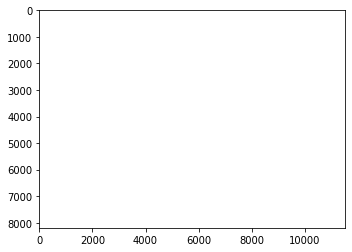

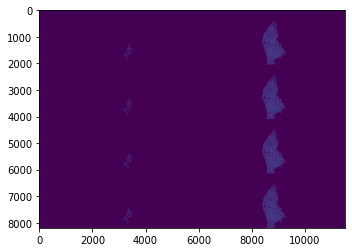

In [23]:
if len(data_list)>1:
    means = big_means_array
    breaks = big_breaks_array
else:
    breaks = ts_data.breaks_array
    means = ts_data.means_array


plt.imshow(means)
plt.show()

plt.imshow(breaks)
plt.show()


In [133]:
# import seaborn as sns

# select only negative magnitudes
no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan

# print("magnitude change heatmap")
# sns.heatmap(orig_means,  linewidths=1)


In [134]:
dates_monitor = []
dates = ts_data.dates
# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [135]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year+1):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 

    breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))
    
    # if we're at the last year
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1 
        continue
    
    # if we're at the first year
    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    # all other years in between
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
    

# Plot output

<Figure size 1600x1200 with 0 Axes>

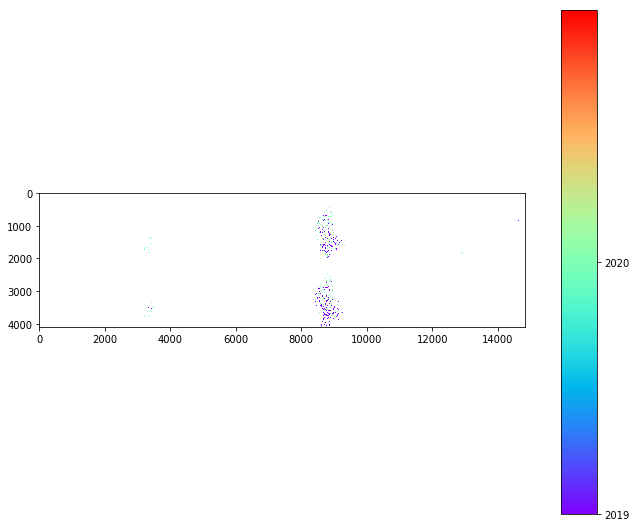

In [143]:
bins = len(idx_starts)
# from matplotlib.pyplot import figure
# figure(num=None, figsize=(20, 15), dpi=80, facecolor='w', edgecolor='k')

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

#norm doesn't work with bins = 2 or less... now the colorbar is ugly, fix it later

if bins == 1:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
if bins == 2:
    im = axes.imshow(breaks_plot_years,cmap=cmap,vmin=0,vmax=bins)
else:
    im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()



print(bounds)

In [175]:
print(bounds)

[0. 1.]


In [ ]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [121]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [122]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [182]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

NameError: name 'latitude' is not defined

In [183]:
print(ts_data.latitude)
print(ts_data.longitude)

40.701497713586164
-8.420088821109099


In [123]:
# this is probs still wrong

from folium.plugins import FloatImage
import base64
latitude = ts_data.latitude
longitude = ts_data.longitude
xpixelsize= ts_data.xpixelsize
ypixelsize= ts_data.ypixelsize
rows = ts_data.nrows
cols = ts_data.ncols

m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + (rows*xpixelsize), longitude + (cols*xpixelsize)]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger_gpu.html'))
m

KeyboardInterrupt: 